# Code for Hydro ML

### Importing libraries

In [ ]:
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from numpy import hstack


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from math import sqrt
from tensorflow import keras 
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from tensorflow.keras.layers import Bidirectional
import datetime
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from numpy import array
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
import pickle
from sklearn.metrics import r2_score 
from sklearn.utils import shuffle


## Quick import

In [ ]:
m17_daily_rainfall = pd.read_csv('drive/MyDrive/Thesis/Thesis/m17_daily_rainfall.csv')
m17_daily = pd.read_csv('drive/MyDrive/Thesis/Thesis/m17_daily.csv')
m17_daily_rainfall['Date and Time'] = pd.to_datetime(m17_daily_rainfall['Date and Time'], dayfirst=True,errors='coerce')
m17_daily['Date and Time'] = pd.to_datetime(m17_daily['Date and Time'], dayfirst=True,errors='coerce')

m18_daily_rainfall = pd.read_csv('drive/MyDrive/Thesis/Thesis/m18_daily_rainfall.csv')
m18_daily = pd.read_csv('drive/MyDrive/Thesis/Thesis/m18_daily.csv')
m18_daily_rainfall['Date and Time'] = pd.to_datetime(m18_daily_rainfall['Date and Time'], dayfirst=True,errors='coerce')
m18_daily['Date and Time'] = pd.to_datetime(m18_daily['Date and Time'], dayfirst=True,errors='coerce')

m19_daily_rainfall = pd.read_csv('drive/MyDrive/Thesis/Thesis/m19_daily_rainfall.csv')
m19_daily = pd.read_csv('drive/MyDrive/Thesis/Thesis/m19_daily.csv')
m19_daily_rainfall['Date and Time'] = pd.to_datetime(m19_daily_rainfall['Date and Time'], dayfirst=True,errors='coerce')
m19_daily['Date and Time'] = pd.to_datetime(m19_daily['Date and Time'], dayfirst=True,errors='coerce')

m20_daily_rainfall = pd.read_csv('drive/MyDrive/Thesis/Thesis/m20_daily_rainfall.csv')
m20_daily = pd.read_csv('drive/MyDrive/Thesis/Thesis/m20_daily.csv')
m20_daily_rainfall['Date and Time'] = pd.to_datetime(m20_daily_rainfall['Date and Time'], dayfirst=True,errors='coerce')
m20_daily['Date and Time'] = pd.to_datetime(m20_daily['Date and Time'], dayfirst=True,errors='coerce')

m21_daily_rainfall = pd.read_csv('drive/MyDrive/Thesis/Thesis/m21_daily_rainfall.csv')
m21_daily = pd.read_csv('drive/MyDrive/Thesis/Thesis/m21_daily.csv')
m21_daily_rainfall['Date and Time'] = pd.to_datetime(m21_daily_rainfall['Date and Time'], dayfirst=True,errors='coerce')
m21_daily['Date and Time'] = pd.to_datetime(m21_daily['Date and Time'], dayfirst=True,errors='coerce')

m22_daily_rainfall = pd.read_csv('drive/MyDrive/Thesis/Thesis/m22_daily_rainfall.csv')
m22_daily = pd.read_csv('drive/MyDrive/Thesis/Thesis/m22_daily.csv')
m22_daily_rainfall['Date and Time'] = pd.to_datetime(m22_daily_rainfall['Date and Time'], dayfirst=True,errors='coerce')
m22_daily['Date and Time'] = pd.to_datetime(m22_daily['Date and Time'], dayfirst=True,errors='coerce')


In [ ]:
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, skips=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)[::skips])
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[::skips])
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)
    

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
def predict_recursively(model, starting_value, second_var, num_predictions, n_steps):
  res = np.zeros(num_predictions)
  first_entry = starting_value
  for i in range(num_predictions):
    end_ix = i + n_steps
    second_entry = second_var[i:end_ix]
    input = np.c_[second_entry, first_entry].reshape(-1,3,2)
    prediction = model.predict_on_batch(input)
    res[i] = prediction
    first_entry = np.append(first_entry[1:],prediction)
  return res


In [ ]:
def predict_recursively_univariate(model, starting_value, num_predictions, n_steps):
  res = np.zeros(num_predictions)
  first_entry = starting_value
  for i in range(num_predictions):
    end_ix = i + n_steps
    input = np.c_[first_entry].reshape(-1,3,1)
    prediction = model.predict_on_batch(input)
    res[i] = prediction
    first_entry = np.append(first_entry[1:],prediction)
  return res


In [ ]:
def predict_recursively_3(model, starting_value, second_var, third_var, num_predictions, n_steps):
  res = np.zeros(num_predictions)
  first_entry = starting_value
  for i in range(num_predictions):
    end_ix = i + n_steps
    second_entry = second_var[i:end_ix]
    third_entry = third_var[i:end_ix]
    input = np.c_[second_entry, first_entry,third_entry].reshape(-1,3,3)
    prediction = model.predict_on_batch(input)
    res[i] = prediction
    first_entry = np.append(first_entry[1:],prediction)
  return res

In [ ]:
initialiser_set = ['glorot_uniform',  'lecun_uniform', 'glorot_normal',  'lecun_normal', ]

## Importing csv

In [ ]:
weather_data = pd.read_csv("drive/MyDrive/Thesis/Thesis/Middle Creek weather station.csv").dropna(axis=1)


In [ ]:
BH_17 = pd.read_csv("drive/MyDrive/Thesis/Thesis/BH  17-2.csv")
BH_17['Date and Time'] = pd.to_datetime(BH_17['Date and Time'], dayfirst=True,errors='coerce')
BH_18 = pd.read_csv("drive/MyDrive/Thesis/Thesis/BH  18-2.csv")
BH_18['Date and Time'] = pd.to_datetime(BH_18['Date and Time'], dayfirst=True,errors='coerce')
BH_19 = pd.read_csv("drive/MyDrive/Thesis/Thesis/BH  19-1.csv")
BH_19['Date and Time'] = pd.to_datetime(BH_19['Date and Time'], dayfirst=True,errors='coerce')
BH_20 = pd.read_csv("drive/MyDrive/Thesis/Thesis/BH  20-2.csv")
BH_20['Date and Time'] = pd.to_datetime(BH_20['Date and Time'], dayfirst=True,errors='coerce')
BH_21 = pd.read_csv("drive/MyDrive/Thesis/Thesis/BH  21-2.csv")
BH_21['Date and Time'] = pd.to_datetime(BH_21['Date and Time'], dayfirst=True,errors='coerce')
BH_22 = pd.read_csv("drive/MyDrive/Thesis/Thesis/BH  22-1.csv")
BH_22['Date and Time'] = pd.to_datetime(BH_22['Date and Time'], dayfirst=True,errors='coerce')

In [ ]:
weather_data = weather_data.rename(columns={'Timestamp (UTC)': 'Date and Time'})
weather_data['Date and Time'] = pd.to_datetime(weather_data['Date and Time'], dayfirst=True,errors='coerce')


In [ ]:
BH_17_daily = BH_17['mAHD'].groupby(BH_17['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
BH_17_daily['Date and Time'] = BH_17_daily['Date and Time'].dt.to_timestamp()
BH_17_daily['mAHD'] = BH_17_daily['mAHD'].interpolate()

BH_18_daily = BH_18['mAHD'].groupby(BH_18['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
BH_18_daily['Date and Time'] = BH_18_daily['Date and Time'].dt.to_timestamp()
BH_18_daily['mAHD'] = BH_18_daily['mAHD'].interpolate()

BH_19_daily = BH_19['mAHD'].groupby(BH_19['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
BH_19_daily['Date and Time'] = BH_19_daily['Date and Time'].dt.to_timestamp()
BH_19_daily['mAHD'] = BH_19_daily['mAHD'].interpolate()

BH_20_daily = BH_20['mAHD'].groupby(BH_20['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
BH_20_daily['Date and Time'] = BH_20_daily['Date and Time'].dt.to_timestamp()
BH_20_daily['mAHD'] = BH_20_daily['mAHD'].interpolate()

BH_21_daily = BH_21['mAHD'].groupby(BH_21['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
BH_21_daily['Date and Time'] = BH_21_daily['Date and Time'].dt.to_timestamp()
BH_21_daily['mAHD'] = BH_21_daily['mAHD'].interpolate()

BH_22_daily = BH_22['mAHD'].groupby(BH_22['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
BH_22_daily['Date and Time'] = BH_22_daily['Date and Time'].dt.to_timestamp()
BH_22_daily['mAHD'] = BH_22_daily['mAHD'].interpolate()

In [ ]:
# Creating hourly datasets
BH_17_hourly = BH_17['mAHD'].groupby(BH_17['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
BH_17_hourly['Date and Time'] = BH_17_hourly['Date and Time'].dt.to_timestamp()
BH_17_hourly['mAHD'] = BH_17_hourly['mAHD'].interpolate()

BH_18_hourly = BH_18['mAHD'].groupby(BH_18['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
BH_18_hourly['Date and Time'] = BH_18_hourly['Date and Time'].dt.to_timestamp()
BH_18_hourly['mAHD'] = BH_18_hourly['mAHD'].interpolate()

BH_19_hourly = BH_19['mAHD'].groupby(BH_19['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
BH_19_hourly['Date and Time'] = BH_19_hourly['Date and Time'].dt.to_timestamp()
BH_19_hourly['mAHD'] = BH_19_hourly['mAHD'].interpolate()

BH_20_hourly = BH_20['mAHD'].groupby(BH_20['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
BH_20_hourly['Date and Time'] = BH_20_hourly['Date and Time'].dt.to_timestamp()
BH_20_hourly['mAHD'] = BH_20_hourly['mAHD'].interpolate()

BH_21_hourly = BH_21['mAHD'].groupby(BH_21['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
BH_21_hourly['Date and Time'] = BH_21_hourly['Date and Time'].dt.to_timestamp()
BH_21_hourly['mAHD'] = BH_21_hourly['mAHD'].interpolate()

BH_22_hourly = BH_22['mAHD'].groupby(BH_22['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
BH_22_hourly['Date and Time'] = BH_22_hourly['Date and Time'].dt.to_timestamp()
BH_22_hourly['mAHD'] = BH_22_hourly['mAHD'].interpolate()

In [ ]:
fields = ['Stilling Well', 'mAHD']

streamflow = pd.read_csv('drive/MyDrive/Thesis/Thesis/Middle Creek surface.csv', skipinitialspace=True, usecols=fields)
streamflow = streamflow.rename(columns={'Stilling Well': 'Date and Time'})
streamflow['Date and Time'] = pd.to_datetime(streamflow['Date and Time'], dayfirst=True,errors='coerce')

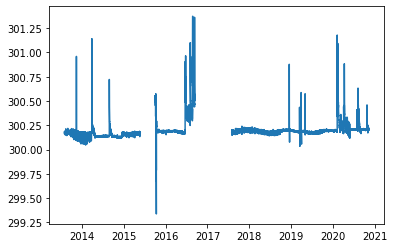

In [ ]:
plt.plot(streamflow['Date and Time'], streamflow['mAHD'] )
plt.show()

In [ ]:
streamflow_daily = streamflow['mAHD'].groupby(streamflow['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
streamflow_daily['Date and Time'] = streamflow_daily['Date and Time'].dt.to_timestamp()
streamflow_daily['mAHD'] = streamflow_daily['mAHD'].dropna(axis=0)

In [ ]:
streamflow_hourly = streamflow['mAHD'].groupby(streamflow['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
streamflow_hourly['Date and Time'] = streamflow_hourly['Date and Time'].dt.to_timestamp()
streamflow_hourly['mAHD'] = streamflow_hourly['mAHD'].dropna(axis=0)

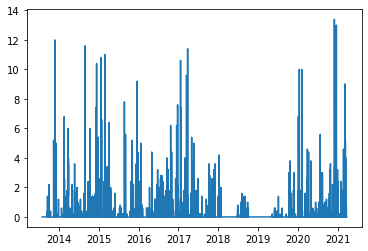

In [ ]:
plt.plot(weather_data['Date and Time'], weather_data['Rainfall'] )
#plt.plot(m19_daily['Date and Time'], m19_daily['mAHD'] )
plt.show()

In [ ]:
mean_rainfall = np.mean(weather_data['Rainfall'])
weather_data['Rainfall departure'] = weather_data['Rainfall'] - mean_rainfall
weather_data['Cumulative rainfall departure'] = np.cumsum(weather_data['Rainfall departure'])


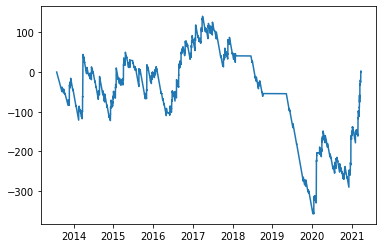

In [ ]:
plt.plot(weather_data['Date and Time'], weather_data['Cumulative rainfall departure'] )
#plt.plot(m19_daily['Date and Time'], m19_daily['mAHD'] )
plt.show()

In [ ]:
weather_data_daily = weather_data['Rainfall'].groupby(weather_data['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
weather_data_daily['Date and Time'] = weather_data_daily['Date and Time'].dt.to_timestamp()
weather_data_daily['Rainfall'] = weather_data_daily['Rainfall'].fillna(0)


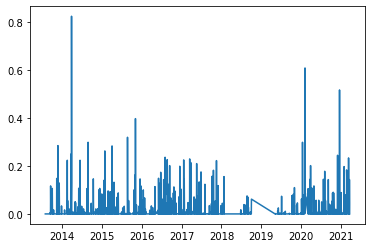

In [ ]:
plt.plot(weather_data_daily['Date and Time'], weather_data_daily['Rainfall'] )
plt.show()

In [ ]:
mean_rainfall = np.mean(weather_data_daily['Rainfall'])
weather_data_daily['Rainfall departure'] = weather_data_daily['Rainfall'] - mean_rainfall
weather_data_daily['Cumulative rainfall departure'] = np.cumsum(weather_data_daily['Rainfall departure'])


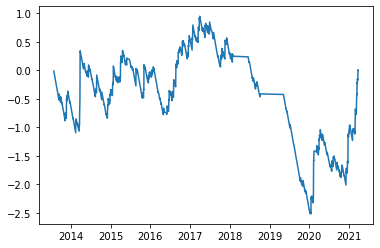

In [ ]:
plt.plot(weather_data_daily['Date and Time'], weather_data_daily['Cumulative rainfall departure'] )
#plt.plot(m19_daily['Date and Time'], m19_daily['mAHD'] )
plt.show()

In [ ]:
weather_data_hourly = weather_data['Rainfall'].groupby(weather_data['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
weather_data_hourly['Date and Time'] = weather_data_hourly['Date and Time'].dt.to_timestamp()
weather_data_hourly['Rainfall'] = weather_data_hourly['Rainfall'].fillna(0)
mean_rainfall = np.mean(weather_data_hourly['Rainfall'])
weather_data_hourly['Rainfall departure'] = weather_data_hourly['Rainfall'] - mean_rainfall
weather_data_hourly['Cumulative rainfall departure'] = np.cumsum(weather_data_hourly['Rainfall departure'])

In [ ]:
m17 = pd.merge(weather_data, BH_17, on='Date and Time')[['Date and Time','Rainfall', 'Cumulative rainfall departure', 'mAHD']]
m18 = pd.merge(weather_data, BH_18, on='Date and Time')[['Date and Time','Rainfall', 'Cumulative rainfall departure', 'mAHD']]
m19 = pd.merge(weather_data, BH_19, on='Date and Time')[['Date and Time','Rainfall', 'Cumulative rainfall departure', 'mAHD']]
m20 = pd.merge(weather_data, BH_20, on='Date and Time')[['Date and Time','Rainfall', 'Cumulative rainfall departure', 'mAHD']]
m21 = pd.merge(weather_data, BH_21, on='Date and Time')[['Date and Time','Rainfall', 'Cumulative rainfall departure', 'mAHD']]
m22 = pd.merge(weather_data, BH_22, on='Date and Time')[['Date and Time','Rainfall', 'Cumulative rainfall departure', 'mAHD']]

models = [m17,m18,m19,m20,m21,m22]

In [ ]:
stream = pd.merge(streamflow.rename(columns={'mAHD': 'streamflow_mAHD'}), weather_data, on='Date and Time')[['Date and Time', 'Rainfall', 'streamflow_mAHD', 'Cumulative rainfall departure']].dropna(axis=0)

In [ ]:
stream

Date and Time  Rainfall  streamflow_mAHD  \
0      2013-08-01 15:00:00       0.0        300.17900   
1      2013-08-01 15:15:00       0.0        300.17970   
2      2013-08-01 15:30:00       0.0        300.18140   
3      2013-08-01 15:45:00       0.0        300.18260   
4      2013-08-01 16:00:00       0.0        300.18420   
...                    ...       ...              ...   
111740 2020-11-11 09:00:00       0.0        300.22183   
111741 2020-11-11 09:30:00       0.0        300.22077   
111742 2020-11-11 10:00:00       0.0        300.21911   
111743 2020-11-11 10:30:00       0.0        300.21795   
111744 2020-11-11 11:00:00       0.0        300.21499   

        Cumulative rainfall departure  
0                           -2.526076  
1                           -2.536964  
2                           -2.547853  
3                           -2.558741  
4                           -2.569629  
...                               ...  
111740                    -259.749439  
111741                    -259.782103  
111742                    -259.814768  
111743                    -259.847433  
111744                    -259.880098  

[91742 rows x 4 columns]

In [ ]:
stream_daily = pd.merge(streamflow_daily.rename(columns={'mAHD': 'streamflow_mAHD'}), weather_data_daily, on='Date and Time')[['Date and Time', 'Rainfall', 'streamflow_mAHD', 'Cumulative rainfall departure']].dropna(axis=0)

In [ ]:
stream_daily

Date and Time  Rainfall  streamflow_mAHD  Cumulative rainfall departure
0       2013-08-01       0.0       300.177664                      -0.043476
1       2013-08-02       0.0       300.173297                      -0.054345
2       2013-08-03       0.0       300.170282                      -0.065214
3       2013-08-04       0.0       300.171953                      -0.076083
4       2013-08-05       0.0       300.173122                      -0.086952
...            ...       ...              ...                            ...
2235    2020-11-07       0.0       300.205798                      -1.767915
2236    2020-11-08       0.0       300.206215                      -1.778784
2237    2020-11-09       0.0       300.206185                      -1.789653
2238    2020-11-10       0.0       300.206025                      -1.800522
2239    2020-11-11       0.0       300.209378                      -1.811391

[1821 rows x 4 columns]

In [ ]:
stream_hourly = pd.merge(streamflow_hourly.rename(columns={'mAHD': 'streamflow_mAHD'}), weather_data_hourly, on='Date and Time')[['Date and Time', 'Rainfall', 'streamflow_mAHD', 'Cumulative rainfall departure']].dropna(axis=0)

In [ ]:
stream_hourly

Date and Time  Rainfall  streamflow_mAHD  \
0     2013-08-01 15:00:00       0.0       300.180675   
1     2013-08-01 16:00:00       0.0       300.184700   
2     2013-08-01 17:00:00       0.0       300.181750   
3     2013-08-01 18:00:00       0.0       300.180400   
4     2013-08-01 19:00:00       0.0       300.178600   
...                   ...       ...              ...   
53449 2020-11-11 07:00:00       0.0       300.211200   
53450 2020-11-11 08:00:00       0.0       300.219970   
53451 2020-11-11 09:00:00       0.0       300.221300   
53452 2020-11-11 10:00:00       0.0       300.218530   
53453 2020-11-11 11:00:00       0.0       300.214990   

       Cumulative rainfall departure  
0                          -0.648569  
1                          -0.659379  
2                          -0.670188  
3                          -0.680998  
4                          -0.691807  
...                              ...  
53449                     -43.511454  
53450                     -43.522264  
53451                     -43.533073  
53452                     -43.543883  
53453                     -43.554692  

[43448 rows x 4 columns]

In [ ]:
m17_daily = pd.merge(weather_data_daily, BH_17_daily, on='Date and Time')
m18_daily = pd.merge(weather_data_daily, BH_18_daily, on='Date and Time')
m19_daily = pd.merge(weather_data_daily, BH_19_daily, on='Date and Time')
m20_daily = pd.merge(weather_data_daily, BH_20_daily, on='Date and Time')
m21_daily = pd.merge(weather_data_daily, BH_21_daily, on='Date and Time')
m22_daily = pd.merge(weather_data_daily, BH_22_daily, on='Date and Time')

models_daily = [m17_daily,m18_daily,m19_daily,m20_daily,m21_daily,m22_daily]

In [ ]:
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, skips=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)[::skips])
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[::skips])
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)
    

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
def predict_recursively(model, starting_value, second_var, num_predictions, n_steps):
  res = np.zeros(num_predictions)
  first_entry = starting_value
  for i in range(num_predictions):
    end_ix = i + n_steps
    second_entry = second_var[i:end_ix]
    input = np.c_[second_entry, first_entry].reshape(-1,3,2)
    prediction = model.predict(input)
    res[i] = prediction
    first_entry = np.append(first_entry[1:],prediction)
  return res


In [ ]:
def predict_recursively_3(model, starting_value, second_var, third_var, num_predictions, n_steps):
  res = np.zeros(num_predictions)
  first_entry = starting_value
  for i in range(num_predictions):
    end_ix = i + n_steps
    second_entry = second_var[i:end_ix]
    third_entry = third_var[i:end_ix]
    input = np.c_[second_entry, first_entry,third_entry].reshape(-1,3,3)
    prediction = model.predict(input)
    res[i] = prediction
    first_entry = np.append(first_entry[1:],prediction)
  return res

In [ ]:
stream_daily.corr()

Rainfall  streamflow_mAHD  \
Rainfall                       1.000000         0.095926   
streamflow_mAHD                0.095926         1.000000   
Cumulative rainfall departure  0.036232        -0.017074   

                               Cumulative rainfall departure  
Rainfall                                            0.036232  
streamflow_mAHD                                    -0.017074  
Cumulative rainfall departure                       1.000000

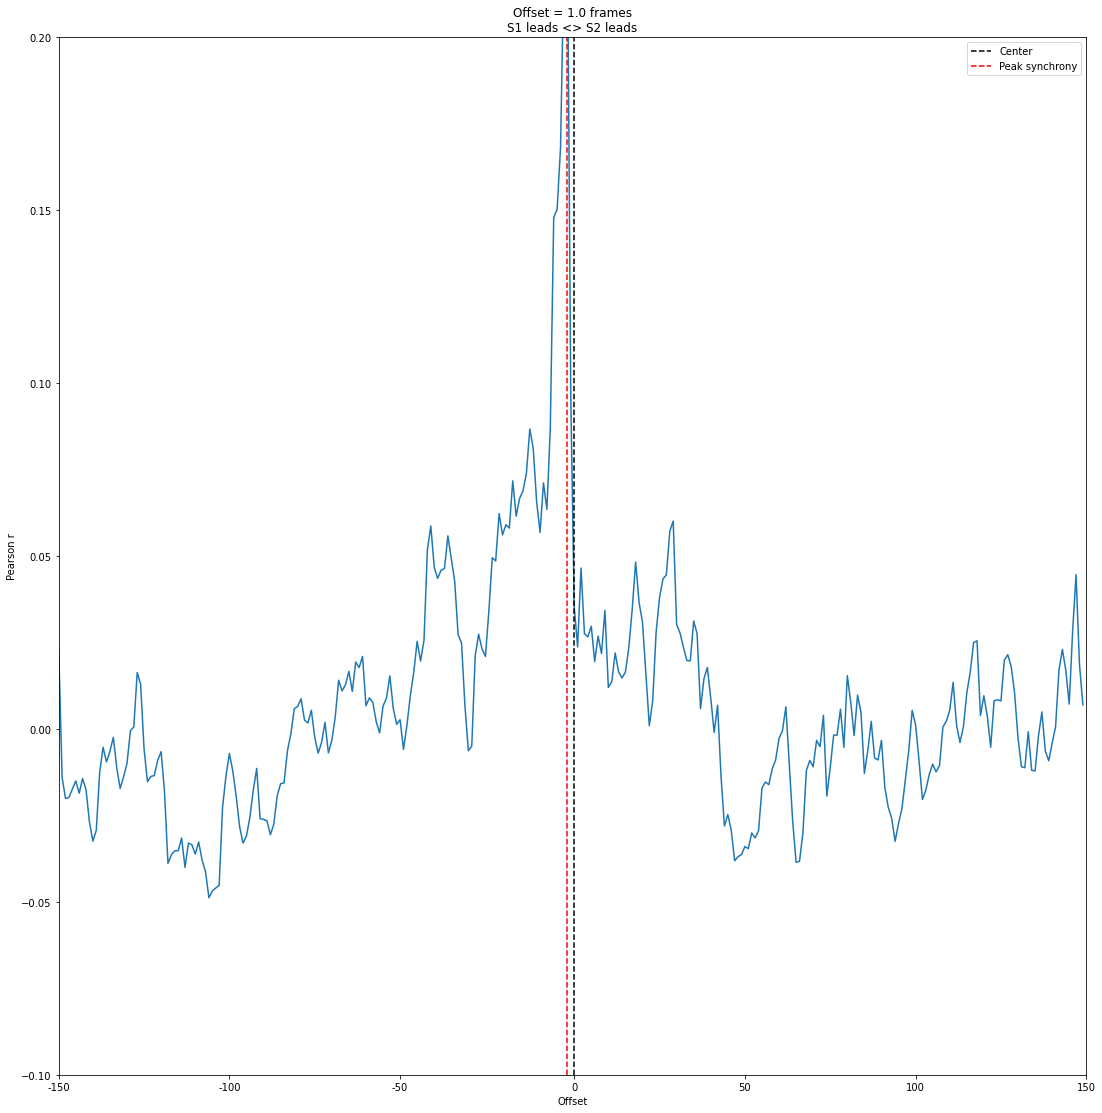

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
f,ax =plt.subplots(1,1)
f.tight_layout()
d1 = stream_daily['Rainfall']
d2 = stream_daily['streamflow_mAHD']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)

ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.1,0.2],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [ ]:
stream_daily['Rainfall'].corr(stream_daily['streamflow_mAHD'].shift(-1))

0.23188364401412667

In [ ]:
import torch
from torch.autograd import Variable
with torch.enable_grad():
  class linearRegression(torch.nn.Module):
      def __init__(self, inputSize, outputSize):
          super(linearRegression, self).__init__()
          self.linear = torch.nn.Linear(inputSize, outputSize)

      def forward(self, x):
          out = self.linear(x)
          return out



x_data = stream_daily['Rainfall']
y_data =  stream_daily['streamflow_mAHD']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

inputDim = 1       # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 1000

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).unsqueeze(1).cuda()).float()
        labels = Variable(torch.from_numpy(y_train).unsqueeze(1).cuda()).float()
    else:
        inputs = Variable(torch.from_numpy(x_train).unsqueeze(1)).float()
        labels = Variable(torch.from_numpy(y_train).unsqueeze(1).view(len(y_train), 1)).float()

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()
y_pred = model(Variable(torch.from_numpy(x_test).unsqueeze(1)).float())
RMSE_value = criterion(y_pred, Variable(torch.from_numpy(y_test).unsqueeze(1).view(len(y_test), 1)).float()).detach().numpy()

  

[[300.16815]
 [300.21158]
 [300.24054]
 ...
 [300.16815]
 [300.16815]
 [300.16815]]


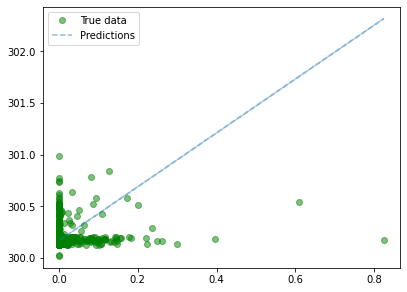

In [ ]:
with torch.no_grad(): # we don't need gradients in the testing phase
    if torch.cuda.is_available():
        predicted = model(Variable(torch.from_numpy(x_train).unsqueeze(1).cuda())).cpu().data.numpy()
    else:
        predicted = model(Variable(torch.from_numpy(x_train).unsqueeze(1).float())).data.numpy()
    print(predicted)

plt.clf()
plt.plot(x_train, y_train, 'go', label='True data', alpha=0.5)
plt.plot(x_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

## Example of daily groundwater level plot

In [ ]:
m20_daily

Unnamed: 0 Date and Time     SF_mAHD     BH_mAHD  discretised_flow
0              0    2013-08-01  300.177664  319.627597                 0
1              1    2013-08-02  300.173297  319.627195                 0
2              2    2013-08-03  300.170282  319.626794                 0
3              3    2013-08-04  300.171953  319.626392                 0
4              4    2013-08-05  300.173122  319.625990                 0
...          ...           ...         ...         ...               ...
1882        1882    2018-09-26  300.176450  318.259065                 0
1883        1883    2018-09-27  300.179308  318.259065                 0
1884        1884    2018-09-28  300.183803  318.259065                 0
1885        1885    2018-09-29  300.190052  318.259065                 0
1886        1886    2018-09-30  300.189329  318.259065                 0

[1887 rows x 5 columns]

Text(0.5, 1.0, 'Groundwater level for Borehole 20-1')

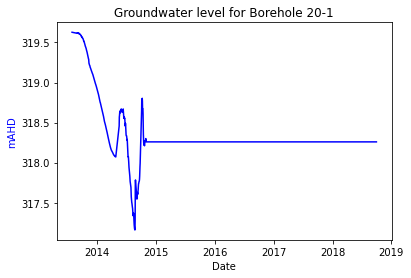

In [ ]:
fig,ax = plt.subplots()
ax.plot(m21_daily['Date and Time'], m21_daily['BH_mAHD'], color="blue" )
#ax.plot(streamflow_daily['Date and Time'], streamflow_daily['mAHD'], color="cyan" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for Borehole 21-1')


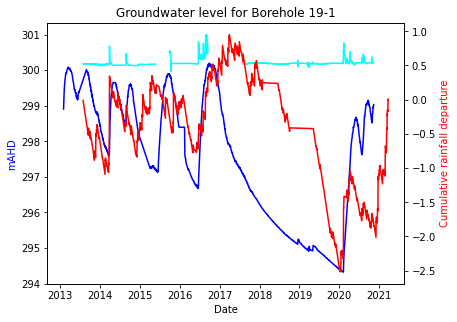

In [ ]:
fig,ax = plt.subplots()
ax.plot(BH_19_daily['Date and Time'], BH_19_daily['mAHD'], color="blue" )
ax.plot(streamflow_daily['Date and Time'], streamflow_daily['mAHD'], color="cyan" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for Borehole 19-1')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(weather_data_daily['Date and Time'], weather_data_daily['Cumulative rainfall departure'],color="red")
ax2.set_ylabel("Cumulative rainfall departure",color="red")
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/BH_19_graphs.png',dpi=300) 
plt.show()


## Example of fine groundwater level plot

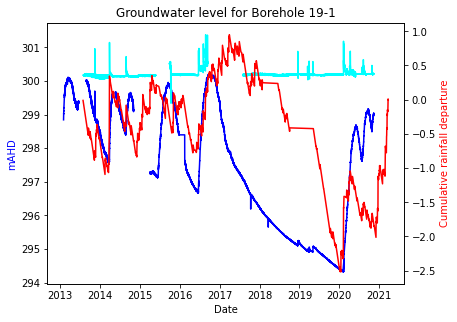

In [ ]:
fig,ax = plt.subplots()
ax.plot(BH_19['Date and Time'], BH_19['mAHD'], color="blue" )
ax.plot(streamflow['Date and Time'], streamflow['mAHD'], color="cyan" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for Borehole 19-1')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(weather_data_daily['Date and Time'], weather_data_daily['Cumulative rainfall departure'],color="red")
ax2.set_ylabel("Cumulative rainfall departure",color="red")
plt.show()


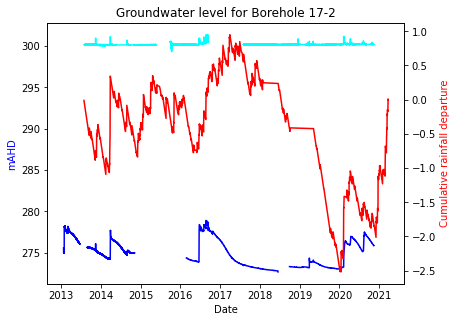

In [ ]:
fig,ax = plt.subplots()
ax.plot(BH_17['Date and Time'], BH_17['mAHD'], color="blue" )
ax.plot(streamflow['Date and Time'], streamflow['mAHD'], color="cyan" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for Borehole 17-2')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(weather_data_daily['Date and Time'], weather_data_daily['Cumulative rainfall departure'],color="red")
ax2.set_ylabel("Cumulative rainfall departure",color="red")
plt.show()

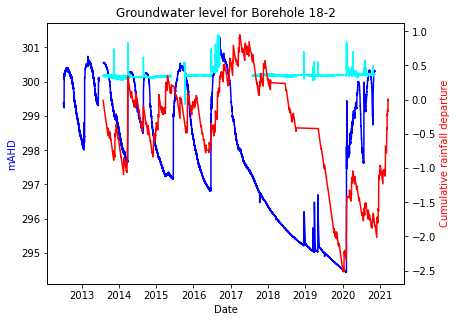

In [ ]:
fig,ax = plt.subplots()
ax.plot(BH_18['Date and Time'], BH_18['mAHD'], color="blue" )
ax.plot(streamflow['Date and Time'], streamflow['mAHD'], color="cyan" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for Borehole 18-2')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(weather_data_daily['Date and Time'], weather_data_daily['Cumulative rainfall departure'],color="red")
ax2.set_ylabel("Cumulative rainfall departure",color="red")
plt.show()


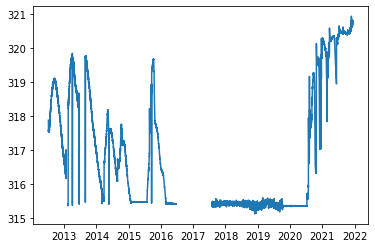

In [ ]:
plt.plot(BH_20['Date and Time'], BH_20['mAHD'] )
plt.show()

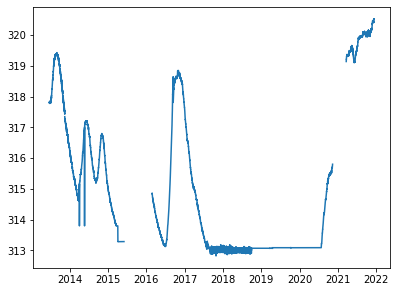

In [ ]:
plt.plot(BH_21['Date and Time'], BH_21['mAHD'] )
plt.show()

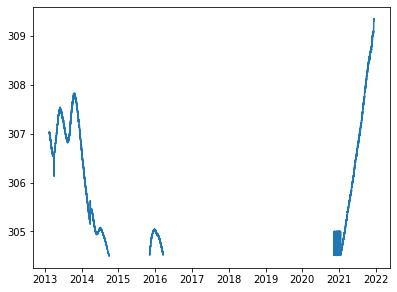

In [ ]:
plt.plot(BH_22['Date and Time'], BH_22['mAHD'] )
plt.show()

## Preprocessing and exploratory data analysis

### Summary statistics of boreholes

In [ ]:
BH_17_daily.describe()

mAHD
count  2851.000000
mean    274.767377
std       1.475721
min     272.722304
25%     273.311896
50%     274.518240
75%     275.880017
max     278.749042

In [ ]:
BH_18_daily.describe()

mAHD
count  3051.000000
mean    298.015381
std       1.933560
min     294.448563
25%     296.341125
50%     298.152615
75%     299.929349
max     301.147208

In [ ]:
BH_19_daily.describe()

mAHD
count  2842.000000
mean    297.537990
std       1.762720
min     294.329771
25%     295.876562
50%     297.777760
75%     299.090495
max     300.194229

In [ ]:
BH_19_daily.describe()

mAHD
count  2842.000000
mean    297.537990
std       1.762720
min     294.329771
25%     295.876562
50%     297.777760
75%     299.090495
max     300.194229

In [ ]:
m17_daily.describe()

Rainfall  Rainfall departure  Cumulative rainfall departure  \
count  2243.000000         2243.000000                    2243.000000   
mean      0.010061           -0.000808                      -0.417206   
std       0.039079            0.039079                       0.787763   
min       0.000000           -0.010869                      -2.519160   
25%       0.000000           -0.010869                      -0.828945   
50%       0.000000           -0.010869                      -0.261494   
75%       0.001389           -0.009480                       0.152503   
max       0.823913            0.813044                       0.949915   

              mAHD  
count  2243.000000  
mean    274.835023  
std       1.378493  
min     272.733583  
25%     273.698469  
50%     274.574886  
75%     275.725882  
max     278.749042

In [ ]:
m18_daily.describe()

Rainfall  Rainfall departure  Cumulative rainfall departure  \
count  2243.000000         2243.000000                    2243.000000   
mean      0.010061           -0.000808                      -0.417206   
std       0.039079            0.039079                       0.787763   
min       0.000000           -0.010869                      -2.519160   
25%       0.000000           -0.010869                      -0.828945   
50%       0.000000           -0.010869                      -0.261494   
75%       0.001389           -0.009480                       0.152503   
max       0.823913            0.813044                       0.949915   

              mAHD  
count  2243.000000  
mean    298.110920  
std       1.854915  
min     294.448563  
25%     296.992510  
50%     298.218229  
75%     299.866536  
max     301.147208

In [ ]:
m19_daily.describe()

Rainfall  Rainfall departure  Cumulative rainfall departure  \
count  2243.000000         2243.000000                    2243.000000   
mean      0.010061           -0.000808                      -0.417206   
std       0.039079            0.039079                       0.787763   
min       0.000000           -0.010869                      -2.519160   
25%       0.000000           -0.010869                      -0.828945   
50%       0.000000           -0.010869                      -0.261494   
75%       0.001389           -0.009480                       0.152503   
max       0.823913            0.813044                       0.949915   

              mAHD  
count  2243.000000  
mean    297.735485  
std       1.649926  
min     294.329771  
25%     296.739312  
50%     298.008813  
75%     299.041062  
max     300.194229

In [ ]:
m20_daily.describe()

Rainfall  Rainfall departure  Cumulative rainfall departure  \
count  1706.000000         1706.000000                    1706.000000   
mean      0.010616           -0.000253                      -0.058880   
std       0.039715            0.039715                       0.454953   
min       0.000000           -0.010869                      -1.093332   
25%       0.000000           -0.010869                      -0.402715   
50%       0.000000           -0.010869                      -0.075162   
75%       0.001389           -0.009480                       0.273715   
max       0.823913            0.813044                       0.949915   

              mAHD  
count  1706.000000  
mean    318.360053  
std       0.383531  
min     317.160156  
25%     318.259065  
50%     318.259065  
75%     318.259065  
max     319.628802

In [ ]:
m21_daily.describe()

Rainfall  Rainfall departure  Cumulative rainfall departure  \
count  2376.000000        2.376000e+03                    2376.000000   
mean      0.010869        7.476249e-19                      -0.459062   
std       0.041136        4.113607e-02                       0.793743   
min       0.000000       -1.086905e-02                      -2.519160   
25%       0.000000       -1.086905e-02                      -0.981064   
50%       0.000000       -1.086905e-02                      -0.326526   
75%       0.001389       -9.480157e-03                       0.125146   
max       0.823913        8.130440e-01                       0.949915   

              mAHD  
count  2376.000000  
mean    314.828965  
std       1.875043  
min     312.895062  
25%     313.083000  
50%     314.251473  
75%     316.054718  
max     319.393907

In [ ]:
m22_daily.describe()

Rainfall  Rainfall departure  Cumulative rainfall departure  \
count  1149.000000         1149.000000                    1149.000000   
mean      0.011861            0.000992                      -0.404297   
std       0.046122            0.046122                       0.452256   
min       0.000000           -0.010869                      -2.013252   
25%       0.000000           -0.010869                      -0.665505   
50%       0.000000           -0.010869                      -0.346379   
75%       0.001389           -0.009480                      -0.062766   
max       0.823913            0.813044                       0.351261   

              mAHD  
count  1149.000000  
mean    305.134115  
std       0.948955  
min     304.502334  
25%     304.516882  
50%     304.669581  
75%     305.194948  
max     307.811937

### Windowing and time-lag analysis

In [ ]:
m17_daily

Date and Time  Rainfall  Rainfall departure  \
0       2013-07-29       0.0           -0.010869   
1       2013-07-30       0.0           -0.010869   
2       2013-07-31       0.0           -0.010869   
3       2013-08-01       0.0           -0.010869   
4       2013-08-02       0.0           -0.010869   
...            ...       ...                 ...   
2238    2020-11-07       0.0           -0.010869   
2239    2020-11-08       0.0           -0.010869   
2240    2020-11-09       0.0           -0.010869   
2241    2020-11-10       0.0           -0.010869   
2242    2020-11-11       0.0           -0.010869   

      Cumulative rainfall departure        mAHD  
0                         -0.010869  275.836038  
1                         -0.021738  275.829895  
2                         -0.032607  275.823753  
3                         -0.043476  275.817610  
4                         -0.054345  275.811468  
...                             ...         ...  
2238                      -1.767915  275.932896  
2239                      -1.778784  275.913479  
2240                      -1.789653  275.895375  
2241                      -1.800522  275.878083  
2242                      -1.811391  275.864741  

[2243 rows x 5 columns]

In [ ]:
m19_daily

Date and Time      mAHD_x      mAHD_y  discretised_flow
0       2013-08-01  300.177664  299.757948                 0
1       2013-08-02  300.173297  299.767222                 0
2       2013-08-03  300.170282  299.776497                 0
3       2013-08-04  300.171953  299.785771                 0
4       2013-08-05  300.173122  299.795046                 0
...            ...         ...         ...               ...
2655    2020-11-07  300.205798  298.959875                 0
2656    2020-11-08  300.206215  298.958896                 0
2657    2020-11-09  300.206185  298.980333                 0
2658    2020-11-10  300.206025  299.012354                 0
2659    2020-11-11  300.209378  299.030739                 0

[2660 rows x 4 columns]

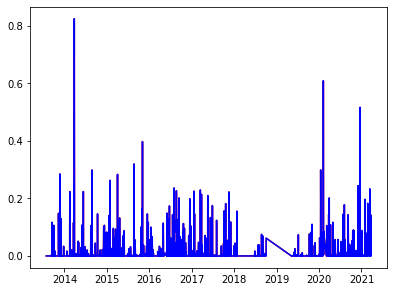

In [ ]:
plt.plot(m19_daily['Date and Time'], m19_daily['Rainfall'], color='red' )
plt.plot(weather_data_daily['Date and Time'], weather_data_daily['Rainfall'], color='blue' )
#plt.plot(m19_daily['Date and Time'], m19_daily['mAHD'] )
#plt.plot(m19_daily['Date and Time'], m19_daily['mAHD'] )
plt.show()

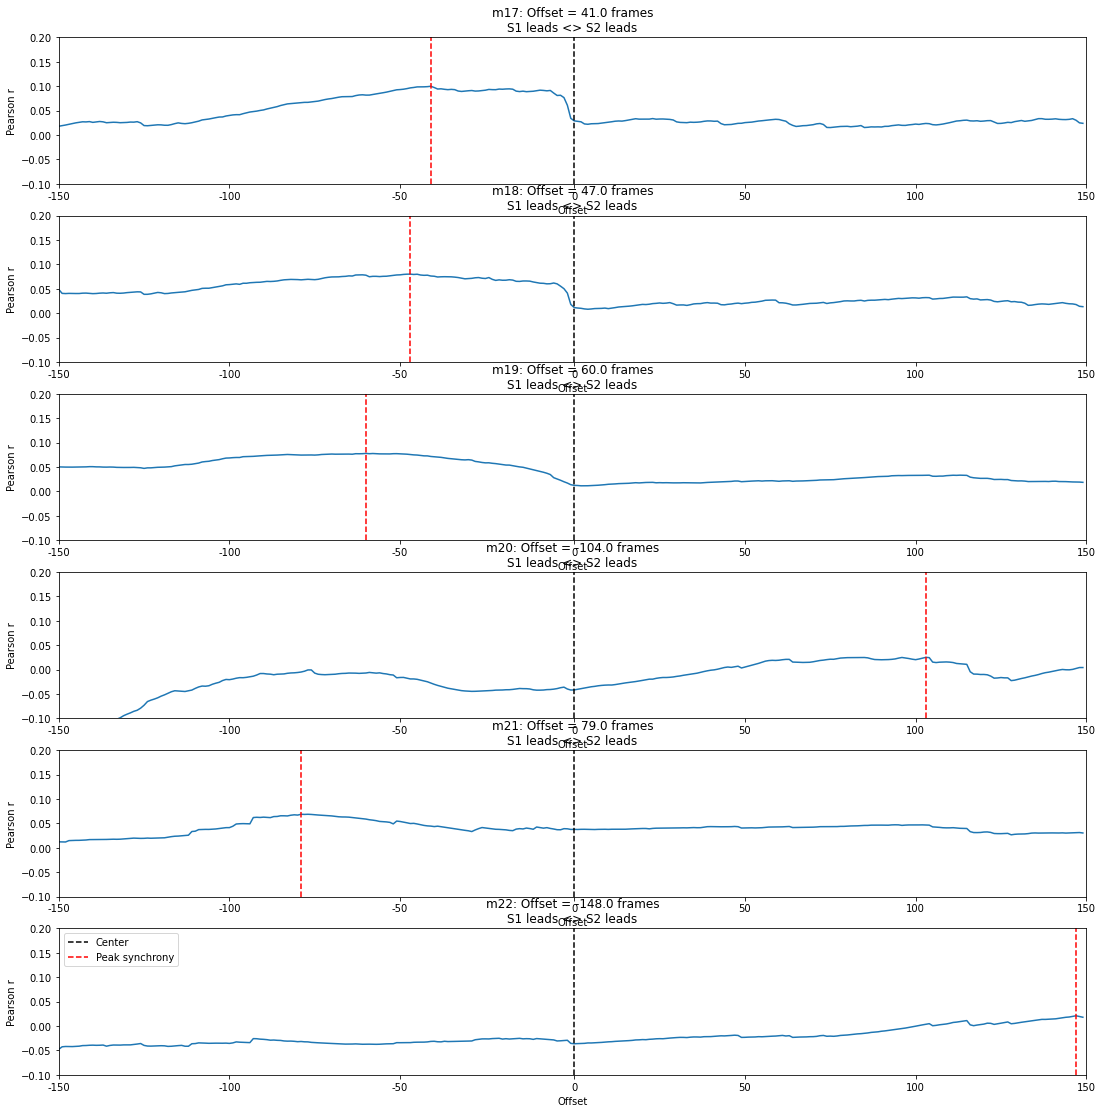

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
f,ax =plt.subplots(6,1)
f.tight_layout()
for i in range(len(models_daily)): 
  d1 = models_daily[i]['Rainfall']
  d2 = models_daily[i]['mAHD']
  seconds = 5
  fps = 30
  rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
  offset = np.floor(len(rs)/2)-np.argmax(rs)
  
  ax[i].plot(rs)
  ax[i].axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
  ax[i].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
  ax[i].set(title=f'm{17+i}: Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.1,0.2],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
  ax[i].set_xticks([0, 50, 100, 151, 201, 251, 301])
  ax[i].set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
  plt.legend()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]




In [ ]:
plt.rcParams["figure.figsize"] = (15,15)

f,ax =plt.subplots(6,1)
f.tight_layout()
for i in range(len(models)): 
  d1 = models[i]['Rainfall']
  d2 = models[i]['mAHD']
  seconds = 5
  fps = 30
  rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
  offset = np.floor(len(rs)/2)-np.argmax(rs)
  
  ax[i].plot(rs)
  ax[i].axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
  ax[i].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
  ax[i].set(title=f'm{17+i}: Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.1,0.2],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
  ax[i].set_xticks([0, 50, 100, 151, 201, 251, 301])
  ax[i].set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
  plt.legend()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


In [ ]:
f,ax =plt.subplots(1,1)

d1 = stream['Rainfall']
d2 = stream['streamflow_mAHD']
seconds=5
fps=150
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)

ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'streamflow: Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.1,0.2],xlim=[0,int(seconds*fps)*2+1], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(range(0,int(seconds*fps)*2,150))
ax.set_xticklabels(range(-int(seconds*fps),int(seconds*fps)+150,150));
plt.legend()
# Roughly a half a day (although merging makes things strange)

In [ ]:
f,ax =plt.subplots(1,1)

d1 = stream_hourly['Rainfall']
d2 = stream_hourly['streamflow_mAHD']
seconds=5
fps=150
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)

ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'streamflow: Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.1,0.2],xlim=[0,int(seconds*fps)*2+1], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(range(0,int(seconds*fps)*2,150))
ax.set_xticklabels(range(-int(seconds*fps),int(seconds*fps)+150,150));
plt.legend()
# Roughly a half a day (although merging makes things strange)

In [ ]:
f,ax =plt.subplots(1,1)

d1 = stream_daily['Rainfall']
d2 = stream_daily['streamflow_mAHD']
seconds=5
fps=150
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs)

ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'streamflow: Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[-0.1,0.2],xlim=[0,int(seconds*fps)*2+1], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(range(0,int(seconds*fps)*2,150))
ax.set_xticklabels(range(-int(seconds*fps),int(seconds*fps)+150,150));
plt.legend()
# Roughly a day (makes sense)

In [ ]:
import torch
from torch.autograd import Variable
with torch.enable_grad():
  class linearRegression(torch.nn.Module):
      def __init__(self, inputSize, outputSize):
          super(linearRegression, self).__init__()
          self.linear = torch.nn.Linear(inputSize, outputSize)

      def forward(self, x):
          out = self.linear(x)
          return out


  def find_optimal_window(x_dataset, y_dataset, input_delay, max_window_size=100):
    res = {}
    for window_size in range(1,max_window_size):
      #lowest_loss = 10000000
      x_data = series_to_supervised(list(x_dataset), n_in=0, n_out=window_size).iloc[:-input_delay].to_numpy(float)
      y_data =  np.ediff1d(y_dataset[input_delay -2 + window_size:].to_numpy())
      x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

      inputDim = window_size       # takes variable 'x' 
      outputDim = 1       # takes variable 'y'
      learningRate = 0.01 
      epochs = 1000

      model = linearRegression(inputDim, outputDim)
      ##### For GPU #######
      if torch.cuda.is_available():
          model.cuda()

      criterion = torch.nn.MSELoss() 
      optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

      for epoch in range(epochs):
          # Converting inputs and labels to Variable
          if torch.cuda.is_available():
              inputs = Variable(torch.from_numpy(x_train).cuda()).float()
              labels = Variable(torch.from_numpy(y_train).cuda()).float()
          else:
              inputs = Variable(torch.from_numpy(x_train)).float()
              labels = Variable(torch.from_numpy(y_train).view(len(y_train), 1)).float()

          # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
          optimizer.zero_grad()

          # get output from the model, given the inputs
          outputs = model(inputs)

          # get loss for the predicted output
          loss = criterion(outputs, labels)
          
          # get gradients w.r.t to parameters
          loss.backward()

          # update parameters
          optimizer.step()
      y_pred = model(Variable(torch.from_numpy(x_test)).float())
      res[window_size] = criterion(y_pred, Variable(torch.from_numpy(y_test).view(len(y_test), 1)).float()).detach().numpy()
    return res

  


In [ ]:
rainfall_lag_windows = find_optimal_window(stream['Rainfall'], stream['streamflow_mAHD'], 37, 40) 
rainfall_lag_windows_daily = find_optimal_window(stream_daily['Rainfall'], stream_daily['streamflow_mAHD'], 1, 40) 
rainfall_lag_windows_hourly = find_optimal_window(stream_hourly['Rainfall'], stream_hourly['streamflow_mAHD'], 20, 40) 


In [ ]:
plt.plot(list(rainfall_lag_windows_daily.keys()),  list(rainfall_lag_windows_daily.values()))

In [ ]:
plt.plot(list(rainfall_lag_windows.keys()),  list(rainfall_lag_windows.values()))

In [ ]:
plt.plot(list(rainfall_lag_windows_hourly.keys()),  list(rainfall_lag_windows_hourly.values()))

## Fine predictions for streamflow

In [ ]:
lag = 37
window_length = 15
x_data = series_to_supervised(list(stream['Rainfall']), n_in=0, n_out=window_length).iloc[:-lag].to_numpy(float)
y_data = np.ediff1d(stream['streamflow_mAHD'][lag - 1+window_length-1:].to_numpy())
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

inputDim = window_length       # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 1000

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda()).float()
        labels = Variable(torch.from_numpy(y_train).cuda()).float()
    else:
        inputs = Variable(torch.from_numpy(x_train)).float()
        labels = Variable(torch.from_numpy(y_train).view(len(y_train), 1)).float()

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

predicted = model(Variable(torch.from_numpy(x_data)).float()).data.numpy()
loc, _ = np.where(streamflow.isna())
for i in loc:
  start_time = streamflow['Date and Time'][i] - datetime.timedelta(hours=26)
  end_time = streamflow['Date and Time'][i] - datetime.timedelta(hours=18, minutes=30)
  mask = (weather_data['Date and Time'] > start_time) & (weather_data['Date and Time'] <= end_time)
  entries = weather_data.loc[mask][-window_length:]
  x_values = np.pad(entries['Rainfall'], (0, window_length-len(entries['Rainfall'])))
  output = model(Variable(torch.from_numpy(x_values)).float()).data.item()
  streamflow['mAHD'][i] = streamflow['mAHD'][i-1] + output


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


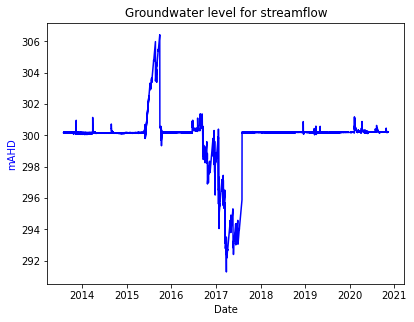

In [ ]:
fig,ax = plt.subplots()
ax.plot(streamflow['Date and Time'], streamflow['mAHD'], color="blue" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for streamflow')
plt.show()

## Hourly predictions for streamflow

In [ ]:
lag = 20
window_length = 9
x_data = series_to_supervised(list(stream_hourly['Rainfall']), n_in=0, n_out=window_length).iloc[:-lag].to_numpy(float)
y_data = np.ediff1d(stream_hourly['streamflow_mAHD'][lag - 1+window_length-1:].to_numpy())
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

inputDim = window_length       # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 1000

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda()).float()
        labels = Variable(torch.from_numpy(y_train).cuda()).float()
    else:
        inputs = Variable(torch.from_numpy(x_train)).float()
        labels = Variable(torch.from_numpy(y_train).view(len(y_train), 1)).float()

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

predicted = model(Variable(torch.from_numpy(x_data)).float()).data.numpy()


In [ ]:
loc, _ = np.where(streamflow_hourly.isna())

In [ ]:
for i in loc:
  #start_time = streamflow_hourly['Date and Time'][i] - datetime.timedelta(hours=26)
  #end_time = streamflow_hourly['Date and Time'][i] - datetime.timedelta(hours=18, minutes=30)
  start_time = streamflow_hourly['Date and Time'][i] - datetime.timedelta(hours=29)
  end_time = streamflow_hourly['Date and Time'][i] - datetime.timedelta(hours=20)
  mask = (weather_data['Date and Time'] > start_time) & (weather_data['Date and Time'] <= end_time)
  entries = weather_data.loc[mask][-window_length:]
  x_values = np.pad(entries['Rainfall'], (0, window_length-len(entries['Rainfall'])))
  output = model(Variable(torch.from_numpy(x_values)).float()).data.item()
  streamflow_hourly['mAHD'][i] = streamflow_hourly['mAHD'][i-1] + output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# streamflow_new = np.zeros(len(streamflow))
# for i in range(len(streamflow)):
#   if (i in loc):
#     start_time = streamflow['Date and Time'][i] - datetime.timedelta(hours=26)
#     end_time = streamflow['Date and Time'][i] - datetime.timedelta(hours=18, minutes=30)
#     mask = (weather_data['Date and Time'] > start_time) & (weather_data['Date and Time'] <= end_time)
#     entries = weather_data.loc[mask][-15:]
#     x_values = np.pad(entries['Rainfall'], (0, 15-len(entries['Rainfall'])))
#     output = model(Variable(torch.from_numpy(x_values)).float()).data.item()
#     streamflow_new['mAHD'][i] = streamflow['mAHD'][i-1] + output
#   else:
#     print(i)
#     streamflow_new['mAHD'][i] = streamflow['mAHD'][i]
  

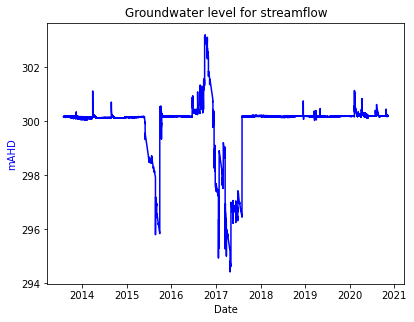

In [ ]:
fig,ax = plt.subplots()
ax.plot(streamflow_hourly['Date and Time'], streamflow_hourly['mAHD'], color="blue" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for streamflow')
plt.show()

In [ ]:
fields = ['Stilling Well', 'mAHD']

streamflow = pd.read_csv('drive/MyDrive/Thesis/Thesis/Middle Creek surface.csv', skipinitialspace=True, usecols=fields)
streamflow = streamflow.rename(columns={'Stilling Well': 'Date and Time'})
streamflow['Date and Time'] = pd.to_datetime(streamflow['Date and Time'], dayfirst=True,errors='coerce')
streamflow_hourly = streamflow['mAHD'].groupby(streamflow['Date and Time'].dt.to_period('H')).mean().to_frame().reset_index()
streamflow_hourly['Date and Time'] = streamflow_hourly['Date and Time'].dt.to_timestamp()
streamflow_hourly['mAHD'] = streamflow_hourly['mAHD'].dropna(axis=0)

In [ ]:
import random
import math
from math import exp

class lin_model:

	def __init__(self, num_epocs, train_data, test_data, num_features, learn_rate, activation):
		self.train_data = train_data
		self.test_data = test_data 
		self.num_features = num_features
		self.num_outputs = self.train_data.shape[1] - num_features 
		self.num_train = self.train_data.shape[0]
		self.w = np.random.uniform(0, 0.5, num_features)  # in case one output class 
		self.b = np.random.uniform(0, 0.5, self.num_outputs) 
		self.learn_rate = learn_rate
		self.max_epoch = num_epocs
		self.use_activation = activation #SIGMOID # 1 is  sigmoid , 2 is step, 3 is linear 
		self.out_delta = np.zeros(self.num_outputs)
		self.activation = activation
 
	def activation_func(self,z_vec):
		if self.use_activation == False:
			y =  1 / (1 + np.exp(z_vec)) # sigmoid/logistic
		else:
			y = z_vec 
		return y
 

	def predict(self, x_vec ): 
		z_vec = x_vec.dot(self.w) - self.b 
		output = self.activation_func(z_vec) # Output  
		return output
	


	def squared_error(self, prediction, actual):
		return  np.sum(np.square(prediction - actual))/prediction.shape[0]# to cater more in one output/class
 
	def encode(self, w): # get  the parameters and encode into the model
		 
		self.w =  w[0:self.num_features]
		self.b = w[self.num_features] 

	def evaluate_proposal(self, data, w):  # BP with SGD (Stocastic BP)

		self.encode(w)  # method to encode w and b
		fx = np.zeros(data.shape[0]) 

		for s in range(0, data.shape[0]):  
				i = s #random.randint(0, data.shape[0]-1)  (we dont shuffle in this implementation)
				input_instance  =  data[i,0:self.num_features]  
				actual  = data[i,self.num_features:]  
				prediction = self.predict(input_instance)  
				fx[s] = prediction

		return fx

	'''def gradient(self, x_vec, output, actual):  # not used in case of Random Walk proposals in MCMC 
		if self.use_activation == SIGMOID :
			out_delta =   (output - actual)*(output*(1-output)) 
		else: # for linear and step function  
			out_delta =   (output - actual) 
		return out_delta

	def update(self, x_vec, output, actual):      # not used by MCMC alg
		self.w+= self.learn_rate *( x_vec *  self.out_delta)
		self.b+=  (1 * self.learn_rate * self.out_delta)'''
	
 

#------------------------------------------------------------------


class MCMC:
	def __init__(self, samples, traindata, testdata, topology, regression):
		self.samples = samples  # NN topology [input, hidden, output]
		self.topology = topology  # max epocs
		self.traindata = traindata  #
		self.testdata = testdata
		random.seed() 
		self.regression = regression # False means classification


	def rmse(self, predictions, targets):
		return np.sqrt(((predictions - targets) ** 2).mean())
 

	def likelihood_func(self, model, data, w, tausq):

		y = data[:, self.topology[0]]
		fx = model.evaluate_proposal(data, w) 
		accuracy = self.rmse(fx, y) #RMSE 
		loss = -0.5 * np.log(2 * math.pi * tausq) - 0.5 * np.square(y - fx) / tausq
		return [np.sum(loss), fx, accuracy] 

 


	def prior_likelihood(self, sigma_squared, nu_1, nu_2, w, tausq): 
		param = self.topology[0]  + 1 # number of parameters in model
		part1 = -1 * (param / 2) * np.log(sigma_squared)
		part2 = 1 / (2 * sigma_squared) * (sum(np.square(w)))
		log_loss = part1 - part2 - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
		return log_loss

	def sampler(self):

		# ------------------- initialize MCMC
		testsize = self.testdata.shape[0]
		trainsize = self.traindata.shape[0]
		samples = self.samples

		x_test = np.linspace(0, 1, num=testsize)
		x_train = np.linspace(0, 1, num=trainsize)

		#self.topology  # [input,   output]
		y_test = self.testdata[:, self.topology[0]]
		y_train = self.traindata[:, self.topology[0]]
	  
		w_size = self.topology[0]  + self.topology[1]  # num of weights and bias (eg. 4 + 1 in case of time series problems used)

		pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
		pos_tau = np.ones((samples, 1))

		fxtrain_samples = np.ones((samples, trainsize))  # fx of train data over all samples
		fxtest_samples = np.ones((samples, testsize))  # fx of test data over all samples
		rmse_train = np.zeros(samples)
		rmse_test = np.zeros(samples)

		w = np.random.randn(w_size)
		w_proposal = np.random.randn(w_size)

		step_w = 0.02;  # defines how much variation you need in changes to w
		step_eta = 0.01;  
		# eta is an additional parameter to cater for noise in predictions (Gaussian likelihood). 
		# note eta is used as tau in the sampler to consider log scale. 
		# eta is not used in multinomial likelihood. 
 

		model = lin_model(0 ,  self.traindata, self.testdata, self.topology[0], 0.1, self.regression) 

		pred_train = model.evaluate_proposal(self.traindata, w)
		pred_test = model.evaluate_proposal(self.testdata, w)

		eta = np.log(np.var(pred_train - y_train))
		tau_pro = np.exp(eta)

		print('evaluate Initial w')

		sigma_squared = 5  # considered by looking at distribution of  similar trained  models - i.e distribution of weights and bias
		nu_1 = 0
		nu_2 = 0

		prior_likelihood = self.prior_likelihood(sigma_squared, nu_1, nu_2, w, tau_pro)  # takes care of the gradients

		[likelihood, pred_train, rmsetrain] = self.likelihood_func(model, self.traindata, w, tau_pro)

		print(likelihood, ' initial likelihood')
		[likelihood_ignore, pred_test, rmsetest] = self.likelihood_func(model, self.testdata, w, tau_pro)


		naccept = 0  

		for i in range(samples - 1):

			w_proposal = w + np.random.normal(0, step_w, w_size)

			eta_pro = eta + np.random.normal(0, step_eta, 1)
			tau_pro = math.exp(eta_pro)

			[likelihood_proposal, pred_train, rmsetrain] = self.likelihood_func(model, self.traindata, w_proposal, tau_pro)
			[likelihood_ignore, pred_test, rmsetest] = self.likelihood_func(model, self.testdata, w_proposal, tau_pro)

			# likelihood_ignore  refers to parameter that will not be used in the alg.

			prior_prop = self.prior_likelihood(sigma_squared, nu_1, nu_2, w_proposal, tau_pro)  # takes care of the gradients
			#print("likelihood proposal:", likelihood_proposal)
			#print("likelihood:", likelihood)
			diff_likelihood = likelihood_proposal - likelihood # since we using log scale: based on https://www.rapidtables.com/math/algebra/Logarithm.html
			diff_priorliklihood = prior_prop - prior_likelihood 
			#print("diff likelihood and prior likelihood:", diff_likelihood + diff_priorliklihood)
			#print("diff likelihood:", diff_likelihood)
			#print("prior likelihood:", diff_priorliklihood)
			#print("exp diff likelihood and prior likelihood:", math.exp(diff_likelihood + diff_priorliklihood))
			if(diff_likelihood + diff_priorliklihood > 1):
				mh_prob = 1
			elif(diff_likelihood + diff_priorliklihood < -500):
				mh_prob = 0
			else:
				mh_prob = min(1, math.exp(diff_likelihood + diff_priorliklihood)) 
      

			u = random.uniform(0, 1)

			if u < mh_prob:
				# Update position
				#print    (i, ' is accepted sample')
				naccept += 1
				likelihood = likelihood_proposal
				prior_likelihood = prior_prop
				w = w_proposal
				eta = eta_pro
				rmse_train[i + 1,] = rmsetrain
				rmse_test[i + 1,] = rmsetest


				print (likelihood, prior_likelihood, rmsetrain, rmsetest, w, 'accepted')

				pos_w[i + 1,] = w_proposal
				pos_tau[i + 1,] = tau_pro
				fxtrain_samples[i + 1,] = pred_train
				fxtest_samples[i + 1,] = pred_test 

			else:
				pos_w[i + 1,] = pos_w[i,]
				pos_tau[i + 1,] = pos_tau[i,]
				fxtrain_samples[i + 1,] = fxtrain_samples[i,]
				fxtest_samples[i + 1,] = fxtest_samples[i,] 
				rmse_train[i + 1,] = rmse_train[i,]
				rmse_test[i + 1,] = rmse_test[i,]

		 
		accept_ratio = naccept / (samples * 1.0) * 100


		print(accept_ratio, '% was accepted')

		burnin = 0.25 * samples  # use post burn in samples

		pos_w = pos_w[int(burnin):, ]
		pos_tau = pos_tau[int(burnin):, ] 
		rmse_train = rmse_train[int(burnin):]
		rmse_test = rmse_test[int(burnin):] 


		rmse_tr = np.mean(rmse_train)
		rmsetr_std = np.std(rmse_train)
		rmse_tes = np.mean(rmse_test)
		rmsetest_std = np.std(rmse_test)
		print(rmse_tr, rmsetr_std, rmse_tes, rmsetest_std, ' rmse_tr, rmsetr_std, rmse_tes, rmsetest_std')


		# let us next test the Bayesian model using the posterior distributions over n trials


		num_trials = 10

		accuracy = np.zeros(num_trials)

		for i in range(num_trials):
			#print(pos_w.mean(axis=0), pos_w.std(axis=0), ' pos w mean, pos w std')
			w_drawn = np.random.normal(pos_w.mean(axis=0), pos_w.std(axis=0), w_size)
			tausq_drawn = np.random.normal(pos_tau.mean(), pos_tau.std()) # a buf is present here - gives negative values at times

			[loss, fx_,  accuracy[i]] = self.likelihood_func(model, self.testdata, w_drawn, tausq_drawn)

			print(i, loss,  accuracy[i],  tausq_drawn , pos_tau.mean(), pos_tau.std(), ' posterior test ')

		print(accuracy.mean(), accuracy.std(), ' is mean and std of accuracy rmse test')
 
 

		return (pos_w, pos_tau, fxtrain_samples, fxtest_samples, rmse_train, rmse_test, accept_ratio)

In [ ]:
traindata = np.concatenate((x_train, y_train[:, None]), axis=1)
testdata = np.concatenate((x_test, y_test[:, None]), axis=1)
features = window_length
output = 1

activation = True
topology = [features, output]

MinCriteria = 0.005  # stop when RMSE reaches MinCriteria ( problem dependent)


numSamples = 2000 # need to decide yourself

mcmc = MCMC(numSamples, traindata, testdata, topology, activation)  # declare class

[pos_w, pos_tau, fx_train, fx_test,   rmse_train, rmse_test, accept_ratio] = mcmc.sampler()
print('sucessfully sampled')


fx_mu = fx_test.mean(axis=0)
fx_high = np.percentile(fx_test, 95, axis=0)
fx_low = np.percentile(fx_test, 5, axis=0)

fx_mu_tr = fx_train.mean(axis=0)
fx_high_tr = np.percentile(fx_train, 95, axis=0)
fx_low_tr = np.percentile(fx_train, 5, axis=0)


rmse_tr = np.mean(rmse_train)
rmsetr_std = np.std(rmse_train)
rmse_tes = np.mean(rmse_test)
rmsetest_std = np.std(rmse_test)

#np.savetxt(outres, (rmse_tr, rmsetr_std, rmse_tes, rmsetest_std, accept_ratio), fmt='%1.5f')



evaluate Initial w
-321462.0177279031  initial likelihood
-313495.5316604351 -6.024661134683717 1.1109078226145075 1.1092868519302577 [ 1.1745465   1.55772611 -1.4530408  -0.03157133  0.13498865  0.9989331
 -0.42846966  0.64944415  0.28985361  1.11229382] accepted
-309541.9962141469 -6.029940244497027 1.108239151624629 1.1065533769610445 [ 1.14883183  1.57125029 -1.44873018 -0.0550901   0.14308336  0.98552516
 -0.42081915  0.66609004  0.32139556  1.10967862] accepted
-296066.1900091378 -6.038008947588685 1.0865780072836202 1.0852167768037435 [ 1.16482915  1.59023976 -1.45155822 -0.04200074  0.1581739   0.97625467
 -0.38189036  0.68045053  0.35126554  1.08786821] accepted
-294798.1864496862 -6.0263880602546465 1.085837383841095 1.0847904677915239 [ 1.17038452  1.5875927  -1.42084363 -0.02932442  0.17192078  0.96436974
 -0.36643573  0.66939783  0.32971751  1.08766289] accepted
-293801.22782463627 -6.024884785779809 1.084162689822907 1.0829221175963888 [ 1.16975585  1.58418473 -1.43418428

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in log


6 21030.53140598623 0.02609397610921385 0.007741063635250251 0.012669822253093278 0.008041829181220326  posterior test 
7 21789.847636645747 0.03007200858409195 0.006633924160938476 0.012669822253093278 0.008041829181220326  posterior test 
8 17272.51693592718 0.042286765491262375 0.012358428806477252 0.012669822253093278 0.008041829181220326  posterior test 
9 16114.544554371501 0.05018831970615472 0.014028714717914116 0.012669822253093278 0.008041829181220326  posterior test 
0.04145811550329094 0.010480163625417822  is mean and std of accuracy rmse test
sucessfully sampled


[]

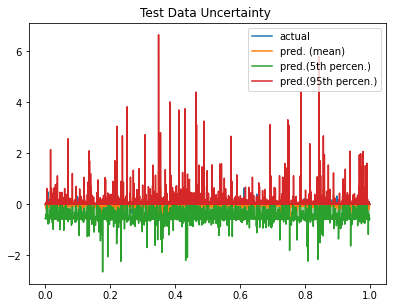

In [ ]:
ytestdata = testdata[:, features]
ytraindata = traindata[:, features]
x_test = np.linspace(0, 1, num=testdata.shape[0])
x_train = np.linspace(0, 1, num=traindata.shape[0])
plt.plot(x_test, ytestdata, label='actual')
plt.plot(x_test, fx_mu, label='pred. (mean)')
plt.plot(x_test, fx_low, label='pred.(5th percen.)')
plt.plot(x_test, fx_high, label='pred.(95th percen.)')
plt.fill_between(x_test, fx_low, fx_high, facecolor='g', alpha=0.4)
plt.legend(loc='upper right')

plt.title("Test Data Uncertainty ")
plt.plot()

In [ ]:
loc, _ = np.where(streamflow_hourly.isna())
loc

array([15876, 15877, 15878, ..., 35067, 35068, 35069])

In [ ]:
def predict_streamflow(w, data, num_features):
  weights = w[0:num_features]
  b = w[num_features]
  z_vec = data.dot(weights) - b 
  output = z_vec # 1 / (1 + np.exp(z_vec)) #activation_func(z_vec)  

  return output

In [ ]:
for i in loc:
  start_time = streamflow_hourly['Date and Time'][i] - datetime.timedelta(hours=29)
  end_time = streamflow_hourly['Date and Time'][i] - datetime.timedelta(hours=20)
  mask = (weather_data['Date and Time'] > start_time) & (weather_data['Date and Time'] <= end_time)
  entries = weather_data.loc[mask][-window_length:]
  x_values = np.pad(entries['Rainfall'], (0, window_length-len(entries['Rainfall'])))
  output = predict_streamflow(pos_w[random.randint(0,len(pos_w)-1)], x_values, window_length)
  streamflow_hourly['mAHD'][i] = streamflow_hourly['mAHD'][i-1] + output


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


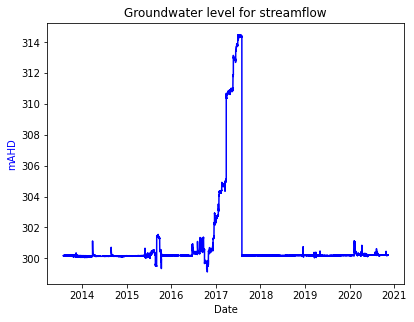

In [ ]:
fig,ax = plt.subplots()
ax.plot(streamflow_hourly['Date and Time'], streamflow_hourly['mAHD'], color="blue" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for streamflow')
plt.show()

## Daily predictions for streamflow

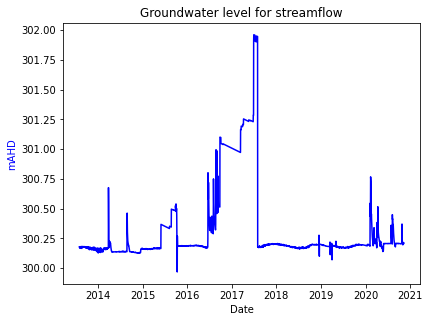

In [ ]:
window_length = 7
x_data = series_to_supervised(list(stream_daily['Rainfall']), n_in=0, n_out=window_length).iloc[:-1].to_numpy(float)
y_data = np.ediff1d(stream_daily['streamflow_mAHD'][1 - 1+window_length - 1:].to_numpy())
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

inputDim = window_length       # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01 
epochs = 1000

model = linearRegression(inputDim, outputDim)
##### For GPU #######
if torch.cuda.is_available():
    model.cuda()

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    if torch.cuda.is_available():
        inputs = Variable(torch.from_numpy(x_train).cuda()).float()
        labels = Variable(torch.from_numpy(y_train).cuda()).float()
    else:
        inputs = Variable(torch.from_numpy(x_train)).float()
        labels = Variable(torch.from_numpy(y_train).view(len(y_train), 1)).float()

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)
    
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

loc, _ = np.where(streamflow_daily.isna())
for i in loc:
  start_time = streamflow_daily['Date and Time'][i] - datetime.timedelta(days=window_length)
  end_time = streamflow_daily['Date and Time'][i] - datetime.timedelta(days=1)
  mask = (weather_data['Date and Time'] > start_time) & (weather_data['Date and Time'] <= end_time)
  entries = weather_data.loc[mask][-window_length:]
  x_values = np.pad(entries['Rainfall'], (0, window_length-len(entries['Rainfall'])))
  output = model(Variable(torch.from_numpy(x_values)).float()).data.item()
  streamflow_daily['mAHD'][i] = streamflow_daily['mAHD'][i-1] + output
fig,ax = plt.subplots()
ax.plot(streamflow_daily['Date and Time'], streamflow_daily['mAHD'], color="blue" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for streamflow')
plt.show()

In [ ]:
fields = ['Stilling Well', 'mAHD']

streamflow = pd.read_csv('drive/MyDrive/Thesis/Thesis/Middle Creek surface.csv', skipinitialspace=True, usecols=fields)
streamflow = streamflow.rename(columns={'Stilling Well': 'Date and Time'})
streamflow['Date and Time'] = pd.to_datetime(streamflow['Date and Time'], dayfirst=True,errors='coerce')
streamflow_daily = streamflow['mAHD'].groupby(streamflow['Date and Time'].dt.to_period('D')).mean().to_frame().reset_index()
streamflow_daily['Date and Time'] = streamflow_daily['Date and Time'].dt.to_timestamp()
streamflow_daily['mAHD'] = streamflow_daily['mAHD'].dropna(axis=0)

In [ ]:
traindata = np.concatenate((x_train, y_train[:, None]), axis=1)
testdata = np.concatenate((x_test, y_test[:, None]), axis=1)
features = window_length
output = 1

activation = True
topology = [features, output]

MinCriteria = 0.005  # stop when RMSE reaches MinCriteria ( problem dependent)


numSamples = 2000 # need to decide yourself

mcmc = MCMC(numSamples, traindata, testdata, topology, activation)  # declare class

[pos_w, pos_tau, fx_train, fx_test,   rmse_train, rmse_test, accept_ratio] = mcmc.sampler()
print('sucessfully sampled')


fx_mu = fx_test.mean(axis=0)
fx_high = np.percentile(fx_test, 95, axis=0)
fx_low = np.percentile(fx_test, 5, axis=0)

fx_mu_tr = fx_train.mean(axis=0)
fx_high_tr = np.percentile(fx_train, 95, axis=0)
fx_low_tr = np.percentile(fx_train, 5, axis=0)


rmse_tr = np.mean(rmse_train)
rmsetr_std = np.std(rmse_train)
rmse_tes = np.mean(rmse_test)
rmsetest_std = np.std(rmse_test)

evaluate Initial w
-8491.433541893966  initial likelihood
-8097.976519538722 -1.9636480978421185 0.36515312128752614 0.36356920044607416 [ 0.14510484 -0.12503947 -0.80342211  1.04868521  0.01122175  0.26249776
 -1.15636538 -0.36063544] accepted
-7316.423891845139 -1.9673516926559227 0.3500410639894958 0.34844890212727664 [ 0.14911984 -0.10299057 -0.79373676  1.07036005 -0.02902084  0.27215258
 -1.17370514 -0.34483398] accepted
-6397.691661870178 -1.9692324463786832 0.3332031372125824 0.3313732344328159 [ 0.13192337 -0.09109329 -0.80521396  1.04335074 -0.02946793  0.27864884
 -1.16975762 -0.3278151 ] accepted
-4899.82032751653 -1.9480646946877034 0.3011770618783751 0.2989134826290557 [ 1.31673154e-01 -6.03216069e-02 -7.76339896e-01  1.00644345e+00
  9.42990024e-04  2.65918708e-01 -1.14672769e+00 -2.94209386e-01] accepted
-4181.501873416792 -1.9519916577156264 0.2840715816804829 0.2815137163225291 [ 0.16211739 -0.06942981 -0.82123054  1.00620534 -0.00533713  0.25497544
 -1.15239441 -0.27

[]

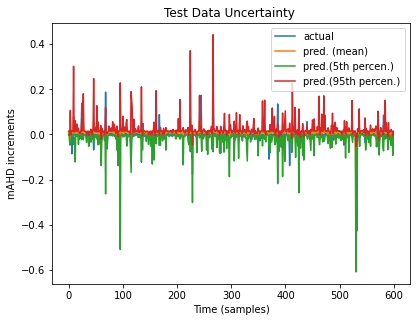

In [ ]:
ytestdata = testdata[:, features]
ytraindata = traindata[:, features]
x_test = np.linspace(0, testdata.shape[0], num=testdata.shape[0])
x_train = np.linspace(0, traindata.shape[0], num=traindata.shape[0])
plt.plot(x_test, ytestdata, label='actual')
plt.plot(x_test, fx_mu, label='pred. (mean)')
plt.plot(x_test, fx_low, label='pred.(5th percen.)')
plt.plot(x_test, fx_high, label='pred.(95th percen.)')
plt.fill_between(x_test, fx_low, fx_high, facecolor='g', alpha=0.4)
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
plt.ylabel('mAHD increments')
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Uncertainty of predictions.png',dpi=300) 
plt.title("Test Data Uncertainty ")
plt.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


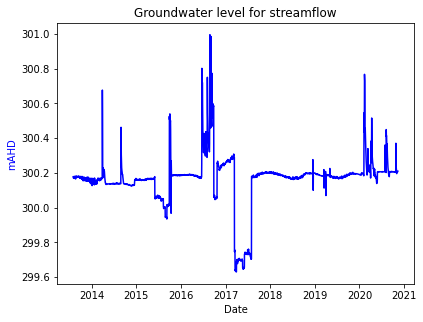

In [ ]:

loc, _ = np.where(streamflow_daily.isna())
for i in loc:
  start_time = streamflow_daily['Date and Time'][i] - datetime.timedelta(days=window_length)
  end_time = streamflow_daily['Date and Time'][i] - datetime.timedelta(days=1)
  mask = (weather_data['Date and Time'] > start_time) & (weather_data['Date and Time'] <= end_time)
  entries = weather_data.loc[mask][-window_length:]
  x_values = np.pad(entries['Rainfall'], (0, window_length-len(entries['Rainfall'])))
  output = predict_streamflow(pos_w[random.randint(0,len(pos_w)-1)], x_values, window_length)
  streamflow_daily['mAHD'][i] = streamflow_daily['mAHD'][i-1] + output
fig,ax = plt.subplots()
ax.plot(streamflow_daily['Date and Time'], streamflow_daily['mAHD'], color="blue" )
ax.set_xlabel('Date')
ax.set_ylabel('mAHD', color='blue')
ax.set_title('Groundwater level for streamflow')
plt.show()


## Re-merging new streamflow values

In [ ]:
m19_daily = pd.merge(streamflow_daily, BH_19_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)
m19_daily = m19_daily.rename(columns={'mAHD_x': 'SF_mAHD', 'mAHD_y': 'BH_mAHD'})
streamflow_mean = np.mean(m19_daily['SF_mAHD'])
streamflow_std = np.std(m19_daily['SF_mAHD'])
m19_daily['discretised_flow'] = np.abs((m19_daily['SF_mAHD'] - streamflow_mean)/streamflow_std) > 1
m19_daily['discretised_flow'] = m19_daily['discretised_flow'].astype(int)
m19_daily_rainfall = pd.merge(weather_data_daily, BH_19_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)

BH_19_daily_split = series_to_supervised(m19_daily.drop(['Date and Time'], axis=1), 3, 1).drop(['var1(t)'], axis=1)


In [ ]:
m19_daily_rainfall = m19_daily_rainfall.rename(columns={'mAHD': 'BH_mAHD'})
m19_daily_merged = pd.merge(m19_daily, m19_daily_rainfall, on='Date and Time')

In [ ]:
BH_19_daily_split

var1(t-3)   var2(t-3)  var3(t-3)   var1(t-2)   var2(t-2)  var3(t-2)  \
3     300.177664  299.757948        0.0  300.173297  299.767222        0.0   
4     300.173297  299.767222        0.0  300.170282  299.776497        0.0   
5     300.170282  299.776497        0.0  300.171953  299.785771        0.0   
6     300.171953  299.785771        0.0  300.173122  299.795046        0.0   
7     300.173122  299.795046        0.0  300.169726  299.804321        0.0   
...          ...         ...        ...         ...         ...        ...   
2655  300.206321  298.910208        0.0  300.205273  298.961167        0.0   
2656  300.205273  298.961167        0.0  300.205254  298.946208        0.0   
2657  300.205254  298.946208        0.0  300.205798  298.959875        0.0   
2658  300.205798  298.959875        0.0  300.206215  298.958896        0.0   
2659  300.206215  298.958896        0.0  300.206185  298.980333        0.0   

       var1(t-1)   var2(t-1)  var3(t-1)     var2(t)  var3(t)  
3     300.170282  299.776497        0.0  299.785771        0  
4     300.171953  299.785771        0.0  299.795046        0  
5     300.173122  299.795046        0.0  299.804321        0  
6     300.169726  299.804321        0.0  299.813595        0  
7     300.174993  299.813595        0.0  299.822870        0  
...          ...         ...        ...         ...      ...  
2655  300.205254  298.946208        0.0  298.959875        0  
2656  300.205798  298.959875        0.0  298.958896        0  
2657  300.206215  298.958896        0.0  298.980333        0  
2658  300.206185  298.980333        0.0  299.012354        0  
2659  300.206025  299.012354        0.0  299.030739        0  

[2657 rows x 11 columns]

In [ ]:
#m19_daily_merged.to_csv('drive/MyDrive/Thesis/Thesis/m19_daily_merged.csv')

In [ ]:
#m19_daily.to_csv('drive/MyDrive/Thesis/Thesis/m19_daily.csv')

In [ ]:
m19_daily_rainfall.to_csv('drive/MyDrive/Thesis/Thesis/m19_daily_rainfall.csv')

In [ ]:
m18_daily = pd.merge(streamflow_daily, BH_18_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)
m18_daily = m18_daily.rename(columns={'mAHD_x': 'SF_mAHD', 'mAHD_y': 'BH_mAHD'})
streamflow_mean = np.mean(m18_daily['SF_mAHD'])
streamflow_std = np.std(m18_daily['SF_mAHD'])
m18_daily['discretised_flow'] = np.abs((m18_daily['SF_mAHD'] - streamflow_mean)/streamflow_std) > 1
m18_daily['discretised_flow'] = m18_daily['discretised_flow'].astype(int)
m18_daily_rainfall = pd.merge(weather_data_daily, BH_18_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)

BH_18_daily_split = series_to_supervised(m18_daily.drop(['Date and Time'], axis=1), 3, 1).drop(['var1(t)'], axis=1)

m18_daily_rainfall = m18_daily_rainfall.rename(columns={'mAHD': 'BH_mAHD'})
m18_daily_merged = pd.merge(m18_daily, m18_daily_rainfall, on='Date and Time')

In [ ]:
#m18_daily_merged.to_csv('drive/MyDrive/Thesis/Thesis/m18_daily_merged.csv')
#m18_daily.to_csv('drive/MyDrive/Thesis/Thesis/m18_daily.csv')
m18_daily_rainfall.to_csv('drive/MyDrive/Thesis/Thesis/m18_daily_rainfall.csv')

In [ ]:
m17_daily = pd.merge(streamflow_daily, BH_17_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)
m17_daily = m17_daily.rename(columns={'mAHD_x': 'SF_mAHD', 'mAHD_y': 'BH_mAHD'})
streamflow_mean = np.mean(m17_daily['SF_mAHD'])
streamflow_std = np.std(m17_daily['SF_mAHD'])
m17_daily['discretised_flow'] = np.abs((m17_daily['SF_mAHD'] - streamflow_mean)/streamflow_std) > 1
m17_daily['discretised_flow'] = m17_daily['discretised_flow'].astype(int)
m17_daily_rainfall = pd.merge(weather_data_daily, BH_17_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)

BH_17_daily_split = series_to_supervised(m17_daily.drop(['Date and Time'], axis=1), 3, 1).drop(['var1(t)'], axis=1)

m17_daily_rainfall = m17_daily_rainfall.rename(columns={'mAHD': 'BH_mAHD'})
m17_daily_merged = pd.merge(m17_daily, m17_daily_rainfall, on='Date and Time')

In [ ]:
#m17_daily_merged.to_csv('drive/MyDrive/Thesis/Thesis/m17_daily_merged.csv')
#m17_daily.to_csv('drive/MyDrive/Thesis/Thesis/m17_daily.csv')
m17_daily_rainfall.to_csv('drive/MyDrive/Thesis/Thesis/m17_daily_rainfall.csv')

In [ ]:
m20_daily = pd.merge(streamflow_daily, BH_20_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)
m20_daily = m20_daily.rename(columns={'mAHD_x': 'SF_mAHD', 'mAHD_y': 'BH_mAHD'})
streamflow_mean = np.mean(m20_daily['SF_mAHD'])
streamflow_std = np.std(m20_daily['SF_mAHD'])
m20_daily['discretised_flow'] = np.abs((m20_daily['SF_mAHD'] - streamflow_mean)/streamflow_std) > 1
m20_daily['discretised_flow'] = m20_daily['discretised_flow'].astype(int)
m20_daily_rainfall = pd.merge(weather_data_daily, BH_20_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)

BH_20_daily_split = series_to_supervised(m20_daily.drop(['Date and Time'], axis=1), 3, 1).drop(['var1(t)'], axis=1)

m20_daily_rainfall = m20_daily_rainfall.rename(columns={'mAHD': 'BH_mAHD'})
m20_daily_merged = pd.merge(m20_daily, m20_daily_rainfall, on='Date and Time')

In [ ]:
m20_daily_merged.to_csv('drive/MyDrive/Thesis/Thesis/m20_daily_merged.csv')
m20_daily.to_csv('drive/MyDrive/Thesis/Thesis/m20_daily.csv')
m20_daily_rainfall.to_csv('drive/MyDrive/Thesis/Thesis/m20_daily_rainfall.csv')

In [ ]:
m21_daily = pd.merge(streamflow_daily, BH_21_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)
m21_daily = m21_daily.rename(columns={'mAHD_x': 'SF_mAHD', 'mAHD_y': 'BH_mAHD'})
streamflow_mean = np.mean(m21_daily['SF_mAHD'])
streamflow_std = np.std(m21_daily['SF_mAHD'])
m21_daily['discretised_flow'] = np.abs((m21_daily['SF_mAHD'] - streamflow_mean)/streamflow_std) > 1
m21_daily['discretised_flow'] = m21_daily['discretised_flow'].astype(int)
m21_daily_rainfall = pd.merge(weather_data_daily, BH_21_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)

BH_21_daily_split = series_to_supervised(m21_daily.drop(['Date and Time'], axis=1), 3, 1).drop(['var1(t)'], axis=1)

m21_daily_rainfall = m21_daily_rainfall.rename(columns={'mAHD': 'BH_mAHD'})
m21_daily_merged = pd.merge(m21_daily, m21_daily_rainfall, on='Date and Time')

In [ ]:
#m21_daily_merged.to_csv('drive/MyDrive/Thesis/Thesis/m21_daily_merged.csv')
#m21_daily.to_csv('drive/MyDrive/Thesis/Thesis/m21_daily.csv')
m21_daily_rainfall.to_csv('drive/MyDrive/Thesis/Thesis/m21_daily_rainfall.csv')

In [ ]:
m22_daily = pd.merge(streamflow_daily, BH_22_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)
m22_daily = m22_daily.rename(columns={'mAHD_x': 'SF_mAHD', 'mAHD_y': 'BH_mAHD'})
streamflow_mean = np.mean(m22_daily['SF_mAHD'])
streamflow_std = np.std(m22_daily['SF_mAHD'])
m22_daily['discretised_flow'] = np.abs((m22_daily['SF_mAHD'] - streamflow_mean)/streamflow_std) > 1
m22_daily['discretised_flow'] = m22_daily['discretised_flow'].astype(int)
m22_daily_rainfall = pd.merge(weather_data_daily, BH_22_daily, on='Date and Time').interpolate('ffill').dropna(axis=0)

BH_22_daily_split = series_to_supervised(m22_daily.drop(['Date and Time'], axis=1), 3, 1).drop(['var1(t)'], axis=1)

m22_daily_rainfall = m22_daily_rainfall.rename(columns={'mAHD': 'BH_mAHD'})
m22_daily_merged = pd.merge(m22_daily, m22_daily_rainfall, on='Date and Time')

In [ ]:
#m22_daily_merged.to_csv('drive/MyDrive/Thesis/Thesis/m22_daily_merged.csv')
#m22_daily.to_csv('drive/MyDrive/Thesis/Thesis/m22_daily.csv')
m22_daily_rainfall.to_csv('drive/MyDrive/Thesis/Thesis/m22_daily_rainfall.csv')

# Individual borehole models

## LSTM model for borehole 19

### Full model

In [ ]:
in_seq1 = array(m19_daily_merged['mAHD_x'][:-1])
in_seq2 = array(m19_daily_merged['mAHD_y'][:-1])
in_seq3 = array(m19_daily_merged['Rainfall'][:-1])
out_seq = array(m19_daily_merged['mAHD_y'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2,in_seq3, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily_merged[m19_daily_merged['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily_merged[m19_daily_merged['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
rainfall_post_2017 = in_seq3[num_pre_2017:]
Num_Exp = 15
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_full_recursive=np.zeros(Num_Exp)
test_acc_full_recursive=np.zeros(Num_Exp)
Step_RMSE_full_recursive=np.zeros([Num_Exp,n_steps_out])

model_full_recursive = Sequential()
model_full_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_full_recursive.add(Dense(n_steps_out))
model_full_recursive.compile(optimizer='adam', loss='mse')
model_full_recursive.summary()
Best_RMSE_full_recursive=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_full_recursive
    #batch_size=64, 
    model_full_recursive.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_full_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively_3(model_full_recursive, x_test_extra_samples[0][:,1], streamflow_post_2017, rainfall_post_2017,num_post_2017-3, 3)
    train_acc_full_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_full_recursive[run] = rmse( y_predicttest, y_test) 
    if test_acc_full_recursive[run]<Best_RMSE_full_recursive:
        Best_RMSE_full_recursive=test_acc_full_recursive[run]
        Best_Predict_Test_full_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_full_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_full_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

### Univariate model

In [ ]:
in_seq1 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 50
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_univar_19_recursive=np.zeros(Num_Exp)
test_acc_univar_19_recursive=np.zeros(Num_Exp)
Step_RMSE_univar_19_recursive=np.zeros([Num_Exp,n_steps_out])

model_univar_19_recursive = Sequential()
model_univar_19_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_univar_19_recursive.add(Dense(n_steps_out))
model_univar_19_recursive.compile(optimizer='adam', loss='mse')
model_univar_19_recursive.summary()
Best_RMSE_univar_19_recursive=1000   #Assigning a large number 

outputs_univar_19_recursive = np.ones((Num_Exp, y_test.shape[0]))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_19_recursive
    #batch_size=64, 
    model_univar_19_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_19_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively_univariate(model_univar_19_recursive, x_test_extra_samples[0], num_post_2017-3, 3)
    train_acc_univar_19_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_19_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_univar_19_recursive[run]) 
    outputs_univar_19_recursive[run,] = y_predicttest
    if test_acc_univar_19_recursive[run]<Best_RMSE_univar_19_recursive:
        Best_RMSE_univar_19_recursive=test_acc_univar_19_recursive[run]
        Best_Predict_Test_univar_19_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_19_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense_18 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 23.639478259861715
Experiment 2 in progress
RMSE value: 22.66591971532262
Experiment 3 in progress
RMSE value: 21.770006875115794
Experiment 4 in progress
RMSE value: 20.9143506400883
Experiment 5 in progress
RMSE value: 20.09526529146949
Experiment 6 in progress
RMSE value: 19.356871001642585
Experiment 7 in progress
RMSE value: 18.663540117050534
Experiment 8 in progress
RMSE value: 17.996565035773905
Experime

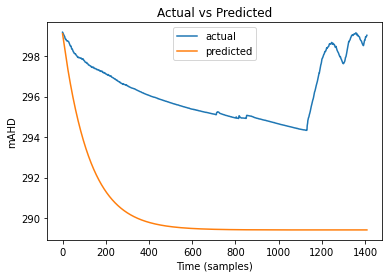

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_19_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

Num_Exp = 15
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_univar_19_post_2017=np.zeros(Num_Exp)
test_acc_univar_19_post_2017=np.zeros(Num_Exp)
Step_RMSE_univar_19_post_2017=np.zeros([Num_Exp,n_steps_out])

model_univar_19_post_2017 = Sequential()
model_univar_19_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_univar_19_post_2017.add(Dense(n_steps_out))
model_univar_19_post_2017.compile(optimizer='adam', loss='mse')
model_univar_19_post_2017.summary()
Best_RMSE_univar_19_post_2017=1000   #Assigning a large number 


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_19_post_2017
    #batch_size=64, 
    model_univar_19_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_19_post_2017.predict(x_train).flatten()
    y_predicttest = model_univar_19_post_2017.predict(x_test).flatten()
    train_acc_univar_19_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_19_post_2017[run] = rmse( y_predicttest, y_test)
    if test_acc_univar_19_post_2017[run]<Best_RMSE_univar_19_post_2017:
        Best_RMSE_univar_19_post_2017=test_acc_univar_19_post_2017[run]
        Best_Predict_Test_univar_19_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_19_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Total time for 15 experiments 1665.8672354221344


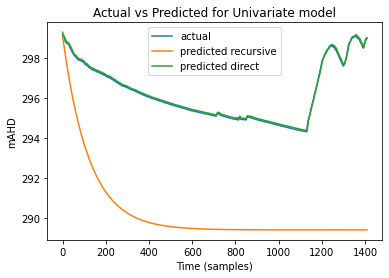

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_19_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_univar_19_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_19_post_2017.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_univar_19_recursive[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_univar_19_post_2017[:])
actual = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

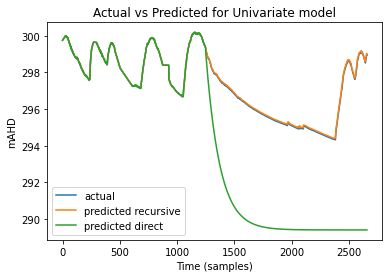

In [ ]:
x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_19.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_univar_19_post_2017

0.06790576194162609

In [ ]:
Best_RMSE_univar_19_recursive

6.2368901648362565

In [ ]:
Best_NSE_univar_19_post_2017 = r2_score(Best_Predict_Test_univar_19_post_2017, y_test[:])
Best_NSE_univar_19_recursive = r2_score(Best_Predict_Test_univar_19_recursive, y_test[:])

In [ ]:
Best_NSE_univar_19_post_2017

0.9977286147824266

In [ ]:
Best_NSE_univar_19_recursive

-10.38728509227479

In [ ]:


saved_map = {
    'outputs_univar_19_recursive': outputs_univar_19_recursive,
    'model_univar_19_post_2017': model_univar_19_post_2017,
    'train_acc_univar_19_post_2017': train_acc_univar_19_post_2017,
    'test_acc_univar_19_post_2017': test_acc_univar_19_post_2017,
    'Step_RMSE_univar_19_post_2017': Step_RMSE_univar_19_post_2017,
    'Best_Predict_test_univar_19_post_2017': Best_Predict_Test_univar_19_post_2017,
    'Best_RMSE_univar_19_post_2017': Best_RMSE_univar_19_post_2017,
    'Best_NSE_univar_19_post_2017': Best_NSE_univar_19_post_2017,
    'model_univar_19_recursive': model_univar_19_recursive,
    'train_acc_univar_19_recursive': train_acc_univar_19_recursive,
    'test_acc_univar_19_recursive': test_acc_univar_19_recursive,
    'Step_RMSE_univar_19_recursive': Step_RMSE_univar_19_recursive,
    'Best_Predict_test_univar_19_recursive': Best_Predict_Test_univar_19_recursive,
    'Best_RMSE_univar_19_recursive': Best_RMSE_univar_19_recursive,
    'Best_NSE_univar_19_recursive': Best_NSE_univar_19_recursive,
    
    'outputs_univar_18_recursive': outputs_univar_18_recursive,
    'model_univar_18_post_2017': model_univar_18_post_2017,
    'train_acc_univar_18_post_2017': train_acc_univar_18_post_2017,
    'test_acc_univar_18_post_2017': test_acc_univar_18_post_2017,
    'Step_RMSE_univar_18_post_2017': Step_RMSE_univar_18_post_2017,
    'Best_predict_test_univar_18_post_2017': Best_Predict_Test_univar_18_post_2017,
    'Best_RMSE_univar_18_post_2017': Best_RMSE_univar_18_post_2017,
    'Best_NSE_univar_18_post_2017': Best_NSE_univar_18_post_2017,
    'model_univar_18_recursive': model_univar_18_recursive,
    'train_acc_univar_18_recursive': train_acc_univar_18_recursive,
    'test_acc_univar_18_recursive': test_acc_univar_18_recursive,
    'Step_RMSE_univar_18_recursive': Step_RMSE_univar_18_recursive,
    'Best_predict_test_univar_18_recursive': Best_Predict_Test_univar_18_recursive,
    'Best_RMSE_univar_18_recursive': Best_RMSE_univar_18_recursive,
    'Best_NSE_univar_18_recursive': Best_NSE_univar_18_recursive,

    'outputs_univar_17_recursive': outputs_univar_17_recursive,
    'model_univar_17_post_2017': model_univar_17_post_2017,
    'train_acc_univar_17_post_2017': train_acc_univar_17_post_2017,
    'test_acc_univar_17_post_2017': test_acc_univar_17_post_2017,
    'Step_RMSE_univar_17_post_2017': Step_RMSE_univar_17_post_2017,
    'Best_predict_test_univar_17_post_2017': Best_Predict_Test_univar_17_post_2017,
    'Best_RMSE_univar_17_post_2017': Best_RMSE_univar_17_post_2017,
    'Best_NSE_univar_17_post_2017': Best_NSE_univar_17_post_2017,
    'model_univar_17_recursive': model_univar_17_recursive,
    'train_acc_univar_17_recursive': train_acc_univar_17_recursive,
    'test_acc_univar_17_recursive': test_acc_univar_17_recursive,
    'Step_RMSE_univar_17_recursive': Step_RMSE_univar_17_recursive,
    'Best_predict_test_univar_17_recursive': Best_Predict_Test_univar_17_recursive,
    'Best_RMSE_univar_17_recursive': Best_RMSE_univar_17_recursive,
    'Best_NSE_univar_17_recursive': Best_NSE_univar_17_recursive,
}

# Save the python variable 'saved_map' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data_univar.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_univar.pickle','rb')
data19 = pickle.load(pick_read)
pick_read.close()

#Best_NSE_streamflow_recursive = data19['Best_NSE_streamflow_recursive']
outputs_univar_19_recursive = data19['outputs_univar_19_recursive']
model_univar_19_post_2017 = data19['model_univar_19_post_2017']
train_acc_univar_19_post_2017 = data19['train_acc_univar_19_post_2017']
test_acc_univar_19_post_2017 = data19['test_acc_univar_19_post_2017']
Step_RMSE_univar_19_post_2017 = data19['Step_RMSE_univar_19_post_2017']
Best_Predict_Test_univar_19_post_2017 = data19['Best_predict_test_univar_19_post_2017']
Best_RMSE_univar_19_post_2017 = data19['Best_RMSE_univar_19_post_2017']
Best_NSE_univar_19_post_2017 = data19['Best_NSE_univar_19_post_2017']

model_univar_19_recursive = data19['model_univar_19_recursive']
train_acc_univar_19_recursive = data19['train_acc_univar_19_recursive']
test_acc_univar_19_recursive = data19['test_acc_univar_19_recursive']
Step_RMSE_univar_19_recursive = data19['Step_RMSE_univar_19_recursive']
Best_Predict_Test_univar_19_recursive = data19['Best_predict_test_univar_19_recursive']
Best_RMSE_univar_19_recursive = data19['Best_RMSE_univar_19_recursive']
Best_NSE_univar_19_recursive = data19['Best_NSE_univar_19_recursive']

model_univar_18_recursive = data19['model_univar_18_recursive']
train_acc_univar_18_recursive = data19['train_acc_univar_18_recursive']
test_acc_univar_18_recursive = data19['test_acc_univar_18_recursive']
Step_RMSE_univar_18_recursive = data19['Step_RMSE_univar_18_recursive']
Best_Predict_Test_univar_18_recursive = data19['Best_predict_test_univar_18_recursive']
Best_RMSE_univar_18_recursive = data19['Best_RMSE_univar_18_recursive']
Best_NSE_univar_18_recursive = data19['Best_NSE_univar_18_recursive']

outputs_univar_18_recursive = data19['outputs_univar_18_recursive']
model_univar_18_post_2017 = data19['model_univar_18_post_2017']
train_acc_univar_18_post_2017 = data19['train_acc_univar_18_post_2017']
test_acc_univar_18_post_2017 = data19['test_acc_univar_18_post_2017']
Step_RMSE_univar_18_post_2017 = data19['Step_RMSE_univar_18_post_2017']
Best_Predict_Test_univar_18_post_2017 = data19['Best_predict_test_univar_18_post_2017']
Best_RMSE_univar_18_post_2017 = data19['Best_RMSE_univar_18_post_2017']
Best_NSE_univar_18_post_2017 = data19['Best_NSE_univar_18_post_2017']

outputs_univar_17_recursive = data19['outputs_univar_17_recursive']
model_univar_17_post_2017 = data19['model_univar_17_post_2017']
train_acc_univar_17_post_2017 = data19['train_acc_univar_17_post_2017']
test_acc_univar_17_post_2017 = data19['test_acc_univar_17_post_2017']
Step_RMSE_univar_17_post_2017 = data19['Step_RMSE_univar_17_post_2017']
Best_Predict_Test_univar_17_post_2017 = data19['Best_predict_test_univar_17_post_2017']
Best_RMSE_univar_17_post_2017 = data19['Best_RMSE_univar_17_post_2017']
Best_NSE_univar_17_post_2017 = data19['Best_NSE_univar_17_post_2017']

model_univar_17_recursive = data19['model_univar_17_recursive']
train_acc_univar_17_recursive = data19['train_acc_univar_17_recursive']
test_acc_univar_17_recursive = data19['test_acc_univar_17_recursive']
Step_RMSE_univar_17_recursive = data19['Step_RMSE_univar_17_recursive']
Best_Predict_Test_univar_17_recursive = data19['Best_predict_test_univar_17_recursive']
Best_RMSE_univar_17_recursive = data19['Best_RMSE_univar_17_recursive']
Best_NSE_univar_17_recursive = data19['Best_NSE_univar_17_recursive']



### Streamflow

In [ ]:
in_seq1 = array(m19_daily['SF_mAHD'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000
 



train_acc_streamflow=np.zeros(Num_Exp)
test_acc_streamflow=np.zeros(Num_Exp)
Step_RMSE_streamflow=np.zeros([Num_Exp,n_steps_out])

model_streamflow = Sequential()
model_streamflow.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow.add(Dense(n_steps_out))
model_streamflow.compile(optimizer='adam', loss='mse')
model_streamflow.summary()
Best_RMSE_streamflow=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow
    #batch_size=64, 
    model_streamflow.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow.predict(x_train).flatten()
    y_predicttest = model_streamflow.predict(x_test).flatten()
    train_acc_streamflow[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow[run] = rmse( y_predicttest, y_test) 
    if test_acc_streamflow[run]<Best_RMSE_streamflow:
        Best_RMSE_streamflow=test_acc_streamflow[run]
        Best_Predict_Test_streamflow=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                520       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress


KeyboardInterrupt: ignored

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

#### Post 2017

In [ ]:
in_seq1 = array(m19_daily['SF_mAHD'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_recursive=np.zeros(Num_Exp)
test_acc_streamflow_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_recursive = Sequential()
model_streamflow_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_recursive.add(Dense(n_steps_out))
model_streamflow_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_recursive.summary()
Best_RMSE_streamflow_recursive=1000   #Assigning a large number 


outputs_streamflow_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_recursive
    #batch_size=64, 
    model_streamflow_recursive.fit(x_train, y_train, epochs=Epochs, verbose=0, batch_size=16, shuffle=False)
    y_predicttrain = model_streamflow_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_recursive, x_test_extra_samples[0][:,1], streamflow_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_recursive[run] = rmse( y_predicttest, y_test) 
    outputs_streamflow_recursive[run,] = y_predicttest
    print("RMSE value:", test_acc_streamflow_recursive[run]) 
    if test_acc_streamflow_recursive[run]<Best_RMSE_streamflow_recursive:
        Best_RMSE_streamflow_recursive=test_acc_streamflow_recursive[run]
        Best_Predict_Test_streamflow_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                520       
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 2.407564864816657
Experiment 2 in progress
RMSE value: 3.471916833081184
Experiment 3 in progress
RMSE value: 3.163398044136603
Experiment 4 in progress
RMSE value: 3.442266640613492
Experiment 5 in progress
RMSE value: 3.433335042098217
Experiment 6 in progress
RMSE value: 3.428086850358096
Experiment 7 in progress
RMSE value: 3.425995221841132
Experiment 8 in progress
RMSE value: 3.4261777620349863
Experiment

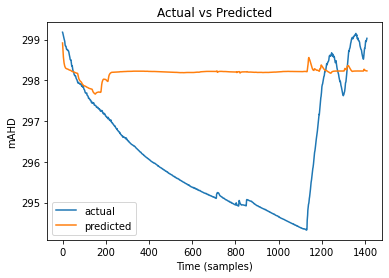

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m19_daily['SF_mAHD'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_post_2017 = Sequential()
model_streamflow_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_post_2017.add(Dense(n_steps_out))
model_streamflow_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_post_2017.summary()
Best_RMSE_streamflow_post_2017=1000   #Assigning a large number 

outputs_streamflow_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_post_2017
    #batch_size=64, 
    model_streamflow_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_post_2017.predict(x_test).flatten()
    train_acc_streamflow_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_post_2017[run] = rmse( y_predicttest, y_test) 
    outputs_streamflow_post_2017[run,] = y_predicttest
    print("RMSE value:", test_acc_streamflow_post_2017[run]) 
    if test_acc_streamflow_post_2017[run]<Best_RMSE_streamflow_post_2017:
        Best_RMSE_streamflow_post_2017=test_acc_streamflow_post_2017[run]
        Best_Predict_Test_streamflow_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                520       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 1.750834405456828
Experiment 2 in progress
RMSE value: 1.6224903026039799
Experiment 3 in progress
RMSE value: 1.4969553679907752
Experiment 4 in progress
RMSE value: 1.3818339559869497
Experiment 5 in progress
RMSE value: 1.288546709127701
Experiment 6 in progress
RMSE value: 1.2332074025390651
Experiment 7 in progress
RMSE value: 1.2288751004762075
Experiment 8 in progress
RMSE value: 1.2626866661794456
Experi

In [ ]:
Best_Predict_Test_streamflow_recursive = Best_Predict_Test_streamflow_recursive[0]

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_recursive, 50, axis=0)
in_between_percentage_streamflow_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_recursive

0.0

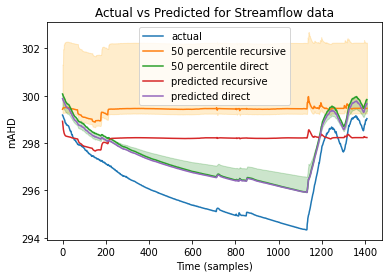

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_post_2017.png',dpi=300) 
plt.show()
plt.close()

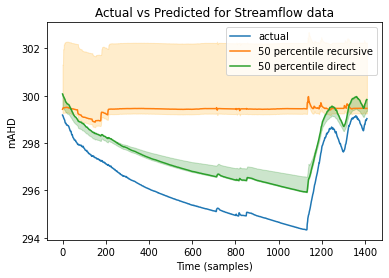

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

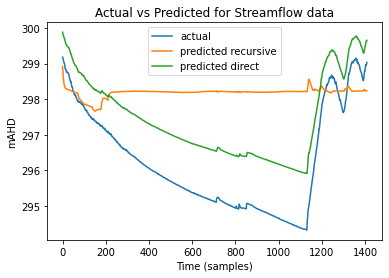

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_post_2017[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_recursive[:])
actual = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

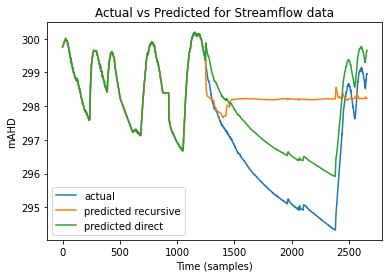

In [ ]:
x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_post_2017

1.2288751004762075

In [ ]:
Best_RMSE_streamflow_recursive

2.407564864816657

In [ ]:
Best_NSE_streamflow_post_2017 = r2_score(Best_Predict_Test_streamflow_post_2017, y_test[:])
Best_NSE_streamflow_recursive = r2_score(Best_Predict_Test_streamflow_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_post_2017

-0.15610089652703074

In [ ]:
Best_NSE_streamflow_recursive

-349.376051263914

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_19_streamflow_post_2017.pickle','rb')
data17 = pickle.load(pick_read)
pick_read.close()


model_streamflow_recursive = data17['model_streamflow_recursive'],
train_acc_streamflow_recursive = data17['train_acc_streamflow_recursive'],
test_acc_streamflow_recursive = data17['test_acc_streamflow_recursive'],
Step_RMSE_streamflow_recursive = data17['Step_RMSE_streamflow_recursive'],
Best_Predict_Test_streamflow_recursive = data17['Best_predict_test_streamflow_recursive'],
Best_RMSE_streamflow_recursive = data17['Best_RMSE_streamflow_recursive'],
Best_NSE_streamflow_recursive = data17['Best_NSE_streamflow_recursive'],
outputs_streamflow_recursive = data17['outputs_streamflow_recursive'],

in_between_percentage_streamflow_recursive = data17['in_between_percentage_streamflow_recursive']

# model_streamflow_post_2017 = data17['model_streamflow_post_2017'],
# train_acc_streamflow_post_2017 = data17['train_acc_streamflow_post_2017'],
# test_acc_streamflow_post_2017 = data17['test_acc_streamflow_post_2017'],
# Step_RMSE_streamflow_post_2017 = data17['Step_RMSE_streamflow_post_2017'],
# Best_Predict_Test_streamflow_post_2017 = data17['Best_predict_test_streamflow_post_2017'],
# Best_RMSE_streamflow_post_2017 = data17['Best_RMSE_streamflow_post_2017'],
# Best_NSE_streamflow_post_2017 = data17['Best_NSE_streamflow_post_2017'],
# outputs_streamflow_post_2017 = data17['outputs_streamflow_post_2017'],

KeyError: ignored

In [ ]:
saved_map = {
    'outputs_streamflow_recursive':outputs_streamflow_recursive,
    'model_streamflow_recursive': model_streamflow_recursive,
    'train_acc_streamflow_recursive': train_acc_streamflow_recursive,
    'test_acc_streamflow_recursive': test_acc_streamflow_recursive,
    'Step_RMSE_streamflow_recursive': Step_RMSE_streamflow_recursive,
    'Best_predict_test_streamflow_recursive': Best_Predict_Test_streamflow_recursive,
    'Best_RMSE_streamflow_recursive': Best_RMSE_streamflow_recursive,
    'Best_NSE_streamflow_recursive':Best_NSE_streamflow_recursive,
    #'RMSE_outputs_streamflow_recursive':RMSE_outputs_streamflow_recursive,

    'outputs_streamflow_post_2017':outputs_streamflow_post_2017,
    'model_streamflow_post_2017': model_streamflow_post_2017,
    'train_acc_streamflow_post_2017': train_acc_streamflow_post_2017,
    'test_acc_streamflow_post_2017': test_acc_streamflow_post_2017,
    'Step_RMSE_streamflow_post_2017': Step_RMSE_streamflow_post_2017,
    'Best_predict_test_streamflow_post_2017': Best_Predict_Test_streamflow_post_2017,
    'Best_RMSE_streamflow_post_2017': Best_RMSE_streamflow_post_2017,
    'Best_NSE_streamflow_post_2017':Best_NSE_streamflow_post_2017,
    #'RMSE_outputs_streamflow_post_2017':RMSE_outputs_streamflow_post_2017,
    'in_between_percentage_streamflow_recursive': in_between_percentage_streamflow_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_19_streamflow_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Discretised streamflow

In [ ]:

in_seq1 = array(m19_daily['discretised_flow'][:-1])
in_seq2 = array(m19_daily['mAHD_y'][:-1])
out_seq = array(m19_daily['mAHD_y'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised=np.zeros(Num_Exp)
test_acc_streamflow_discretised=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised = Sequential()
model_streamflow_discretised.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised.add(Dense(n_steps_out))
model_streamflow_discretised.compile(optimizer='adam', loss='mse')
model_streamflow_discretised.summary()
Best_RMSE_streamflow_discretised=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised
    #batch_size=64, 
    model_streamflow_discretised.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised.predict(x_test).flatten()
    train_acc_streamflow_discretised[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised[run] = rmse( y_predicttest, y_test) 
    if test_acc_streamflow_discretised[run]<Best_RMSE_streamflow_discretised:
        Best_RMSE_streamflow_discretised=test_acc_streamflow_discretised[run]
        Best_Predict_Test_streamflow_discretised=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

#### Post 2017


In [ ]:

in_seq1 = array(m19_daily['discretised_flow'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)


num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_recursive_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised_recursive=np.zeros(Num_Exp)
test_acc_streamflow_discretised_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_recursive = Sequential()
model_streamflow_discretised_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_recursive.add(Dense(n_steps_out))
model_streamflow_discretised_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_recursive.summary()
Best_RMSE_streamflow_discretised_recursive=1000   #Assigning a large number 

start_time=time.time()
outputs_streamflow_discretised_recursive = np.ones((Num_Exp, y_test.shape[0]))

for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_recursive
    #batch_size=64, 
    model_streamflow_discretised_recursive.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_discretised_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_recursive_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_discretised_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_recursive[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_discretised_recursive[run]) 
    outputs_streamflow_discretised_recursive[run,] = y_predicttest
    if test_acc_streamflow_discretised_recursive[run]<Best_RMSE_streamflow_discretised_recursive:
        Best_RMSE_streamflow_discretised_recursive=test_acc_streamflow_discretised_recursive[run]
        Best_Predict_Test_streamflow_discretised_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10)                520       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 14.137864186355754
Experiment 2 in progress
RMSE value: 13.553272574808608
Experiment 3 in progress
RMSE value: 12.992051342429205
Experiment 4 in progress
RMSE value: 12.434053233017105
Experiment 5 in progress
RMSE value: 11.932885483726812
Experiment 6 in progress
RMSE value: 11.448899002463056
Experiment 7 in progress
RMSE value: 10.979322626712149
Experiment 8 in progress
RMSE value: 10.525030525892602
Exp

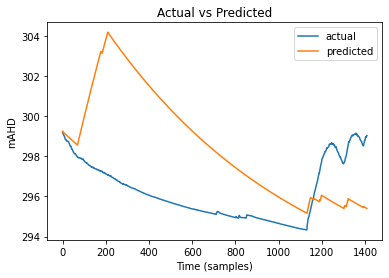

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:

in_seq1 = array(m19_daily['discretised_flow'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)


num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_recursive_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000

train_acc_streamflow_discretised_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_discretised_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_post_2017 = Sequential()
model_streamflow_discretised_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_post_2017.add(Dense(n_steps_out))
model_streamflow_discretised_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_post_2017.summary()
Best_RMSE_streamflow_discretised_post_2017=1000   #Assigning a large number 

outputs_streamflow_discretised_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_post_2017
    #batch_size=64, 
    model_streamflow_discretised_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_post_2017.predict(x_test).flatten()
    train_acc_streamflow_discretised_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_post_2017[run] = rmse( y_predicttest, y_test) 
    print("RMSE: ", test_acc_streamflow_discretised_post_2017[run])
    outputs_streamflow_discretised_post_2017[run,] = y_predicttest
    if test_acc_streamflow_discretised_post_2017[run]<Best_RMSE_streamflow_discretised_post_2017:
        Best_RMSE_streamflow_discretised_post_2017=test_acc_streamflow_discretised_post_2017[run]
        Best_Predict_Test_streamflow_discretised_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10)                520       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE:  0.08971560752903594
Experiment 2 in progress
RMSE:  0.08873782780852849
Experiment 3 in progress
RMSE:  0.08778323426690172
Experiment 4 in progress
RMSE:  0.08692353640850999
Experiment 5 in progress
RMSE:  0.08593543029663606
Experiment 6 in progress
RMSE:  0.08505423842703336
Experiment 7 in progress
RMSE:  0.08415605926091928
Experiment 8 in progress
RMSE:  0.08308655560778028
Experiment 9 in progress
RMSE:  0.08

In [ ]:
outputs_streamflow_discretised_recursive_1 = outputs_streamflow_discretised_recursive

In [ ]:
outputs_streamflow_discretised_recursive = outputs_streamflow_discretised_recursive_1[19:]

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_discretised_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_discretised_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_discretised_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_discretised_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_discretised_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_discretised_recursive, 50, axis=0)
in_between_percentage_streamflow_discretised_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_discretised_recursive

0.875

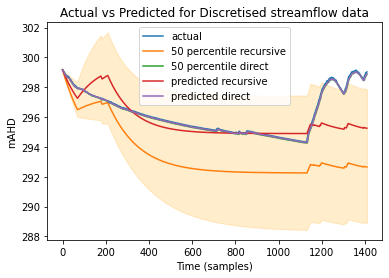

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_post_2017.png',dpi=300) 
plt.show()
plt.close()

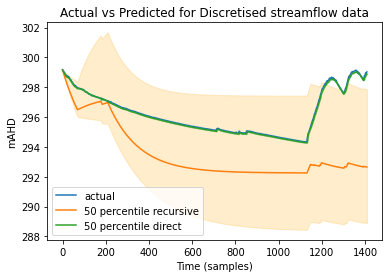

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

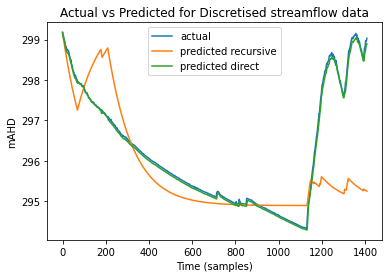

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Discretised_streamflow_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_post_2017[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_recursive[:])
actual = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

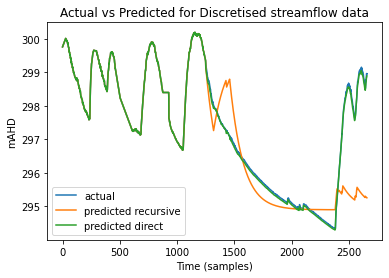

In [ ]:
x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Discretised_streamflow.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_post_2017

0.06538793390722145

In [ ]:
Best_RMSE_streamflow_discretised_recursive

1.3325214199038875

In [ ]:
Best_NSE_streamflow_discretised_post_2017 = r2_score(Best_Predict_Test_streamflow_discretised_post_2017, y_test[:])
Best_NSE_streamflow_discretised_recursive = r2_score(Best_Predict_Test_streamflow_discretised_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_discretised_post_2017

0.9978778108767076

In [ ]:
Best_NSE_streamflow_discretised_recursive

-0.17060287128325058

In [ ]:
saved_map = {
    'outputs_streamflow_discretised_recursive':outputs_streamflow_discretised_recursive,
    'model_streamflow_discretised_recursive': model_streamflow_discretised_recursive,
    'train_acc_streamflow_discretised_recursive': train_acc_streamflow_discretised_recursive,
    'test_acc_streamflow_discretised_recursive': test_acc_streamflow_discretised_recursive,
    'Step_RMSE_streamflow_discretised_recursive': Step_RMSE_streamflow_discretised_recursive,
    'Best_predict_test_streamflow_discretised_recursive': Best_Predict_Test_streamflow_discretised_recursive,
    'Best_RMSE_streamflow_discretised_recursive': Best_RMSE_streamflow_discretised_recursive,
    'Best_NSE_streamflow_discretised_recursive':Best_NSE_streamflow_discretised_recursive,
    #'RMSE_outputs_streamflow_discretised_recursive':RMSE_outputs_streamflow_discretised_recursive,

    'outputs_streamflow_discretised_post_2017':outputs_streamflow_discretised_post_2017,
    'model_streamflow_discretised_post_2017': model_streamflow_discretised_post_2017,
    'train_acc_streamflow_discretised_post_2017': train_acc_streamflow_discretised_post_2017,
    'test_acc_streamflow_discretised_post_2017': test_acc_streamflow_discretised_post_2017,
    'Step_RMSE_streamflow_discretised_post_2017': Step_RMSE_streamflow_discretised_post_2017,
    'Best_predict_test_streamflow_discretised_post_2017': Best_Predict_Test_streamflow_discretised_post_2017,
    'Best_RMSE_streamflow_discretised_post_2017': Best_RMSE_streamflow_discretised_post_2017,
    'Best_NSE_streamflow_discretised_post_2017':Best_NSE_streamflow_discretised_post_2017,
    #'RMSE_outputs_streamflow_discretised_post_2017':RMSE_outputs_streamflow_discretised_post_2017,
    'in_between_percentage_streamflow_discretised_recursive': in_between_percentage_streamflow_discretised_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_19_streamflow_discretised_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Rainfall

In [ ]:

in_seq1 = array(m19_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m19_daily_rainfall['mAHD'][:-1])
out_seq = array(m19_daily_rainfall['mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc=np.zeros(Num_Exp)
test_acc=np.zeros(Num_Exp)
Step_RMSE=np.zeros([Num_Exp,n_steps_out])

model = Sequential()
model.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()
Best_RMSE=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model
    #batch_size=64, 
    model.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model.predict(x_train).flatten()
    y_predicttest = model.predict(x_test).flatten()
    train_acc[run] = rmse( y_predicttrain,y_train) 
    test_acc[run] = rmse( y_predicttest, y_test) 
    if test_acc[run]<Best_RMSE:
        Best_RMSE=test_acc[run]
        Best_Predict_Test=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

#### Post 2017 

In [ ]:

in_seq1 = array(m19_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m19_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m19_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

rainfall_seq_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000




train_acc_rainfall_recursive=np.zeros(Num_Exp)
test_acc_rainfall_recursive=np.zeros(Num_Exp)
Step_RMSE_rainfall_recursive=np.zeros([Num_Exp,n_steps_out])

model_rainfall_recursive = Sequential()
model_rainfall_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_recursive.add(Dense(n_steps_out))
model_rainfall_recursive.compile(optimizer='adam', loss='mse')
model_rainfall_recursive.summary()
Best_RMSE_rainfall_recursive=1000   #Assigning a large number 

outputs_rainfall_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_recursive
    #batch_size=64, 
    model_rainfall_recursive.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_rainfall_recursive, x_test_extra_samples[0][:,1], rainfall_seq_post_2017,num_post_2017-3, 3)
    train_acc_rainfall_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE: ", test_acc_rainfall_recursive[run])
    outputs_rainfall_recursive[run,] = y_predicttest
    if test_acc_rainfall_recursive[run]<Best_RMSE_rainfall_recursive:
        Best_RMSE_rainfall_recursive=test_acc_rainfall_recursive[run]
        Best_Predict_Test_rainfall_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                520       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE:  15.161971142450836
Experiment 2 in progress
RMSE:  8.677227256587388
Experiment 3 in progress
RMSE:  7.874982313570216
Experiment 4 in progress
RMSE:  7.110065600069554
Experiment 5 in progress
RMSE:  6.374007653694323
Experiment 6 in progress
RMSE:  5.694362228687815
Experiment 7 in progress
RMSE:  5.025647224683471
Experiment 8 in progress
RMSE:  4.3698139990371825
Experiment 9 in progress
RMSE:  3.7792509332950566

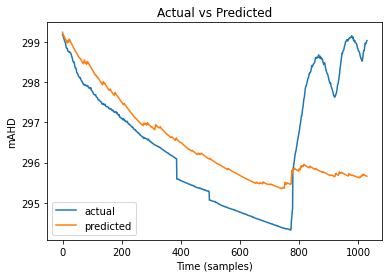

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:

in_seq1 = array(m19_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m19_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m19_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

rainfall_seq_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_rainfall_post_2017=np.zeros(Num_Exp)
test_acc_rainfall_post_2017=np.zeros(Num_Exp)
Step_RMSE_rainfall_post_2017=np.zeros([Num_Exp,n_steps_out])

model_rainfall_post_2017 = Sequential()
model_rainfall_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_post_2017.add(Dense(n_steps_out))
model_rainfall_post_2017.compile(optimizer='adam', loss='mse')
model_rainfall_post_2017.summary()
Best_RMSE_rainfall_post_2017=1000   #Assigning a large number 

outputs_rainfall_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_post_2017
    #batch_size=64, 
    model_rainfall_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_post_2017.predict(x_train).flatten()
    y_predicttest = model_rainfall_post_2017.predict(x_test).flatten()
    train_acc_rainfall_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE: ", test_acc_rainfall_post_2017[run])
    outputs_rainfall_post_2017[run,] = y_predicttest
    if test_acc_rainfall_post_2017[run]<Best_RMSE_rainfall_post_2017:
        Best_RMSE_rainfall_post_2017=test_acc_rainfall_post_2017[run]
        Best_Predict_Test_rainfall_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                520       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE:  0.06887791454493696
Experiment 2 in progress
RMSE:  0.06829572873275748
Experiment 3 in progress
RMSE:  0.06778139930111315
Experiment 4 in progress
RMSE:  0.06716703905128713
Experiment 5 in progress
RMSE:  0.06662255849503021
Experiment 6 in progress
RMSE:  0.06607050625148665
Experiment 7 in progress
RMSE:  0.065575574775659
Experiment 8 in progress
RMSE:  0.06495797334689933
Experiment 9 in progress
RMSE:  0.0644

In [ ]:
fx_high_post_2017 = np.percentile(outputs_rainfall_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_rainfall_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_rainfall_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_rainfall_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_rainfall_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_rainfall_recursive, 50, axis=0)
in_between_percentage_rainfall_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_rainfall_recursive

0.8571428571428571

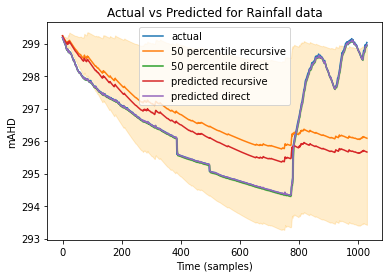

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_rainfall_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_post_2017.png',dpi=300) 
plt.show()
plt.close()

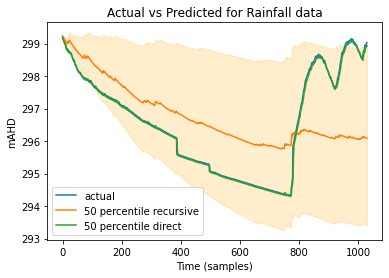

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

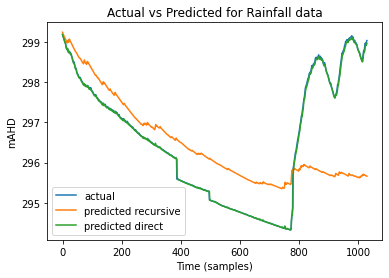

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_post_2017[:], label='predicted direct')

plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_post_2017[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_recursive[:])
actual = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

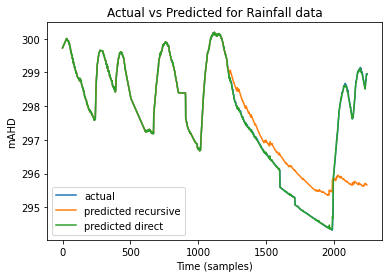

In [ ]:
x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_rainfall_post_2017

0.05849101936102386

In [ ]:
Best_RMSE_rainfall_recursive

1.4290085991129873

In [ ]:
Best_NSE_rainfall_post_2017 = r2_score(Best_Predict_Test_rainfall_post_2017, y_test[:])
Best_NSE_rainfall_recursive = r2_score(Best_Predict_Test_rainfall_recursive, y_test[:])

In [ ]:
Best_NSE_rainfall_post_2017

0.9985269107565959

In [ ]:
Best_NSE_rainfall_recursive

-0.8739922470036756

In [ ]:
saved_map = {
    'outputs_rainfall_recursive':outputs_rainfall_recursive,
    'model_rainfall_recursive': model_rainfall_recursive,
    'train_acc_rainfall_recursive': train_acc_rainfall_recursive,
    'test_acc_rainfall_recursive': test_acc_rainfall_recursive,
    'Step_RMSE_rainfall_recursive': Step_RMSE_rainfall_recursive,
    'Best_predict_test_rainfall_recursive': Best_Predict_Test_rainfall_recursive,
    'Best_RMSE_rainfall_recursive': Best_RMSE_rainfall_recursive,
    'Best_NSE_rainfall_recursive':Best_NSE_rainfall_recursive,
    #'RMSE_outputs_rainfall_recursive':RMSE_outputs_rainfall_recursive,

    'outputs_rainfall_post_2017':outputs_rainfall_post_2017,
    'model_rainfall_post_2017': model_rainfall_post_2017,
    'train_acc_rainfall_post_2017': train_acc_rainfall_post_2017,
    'test_acc_rainfall_post_2017': test_acc_rainfall_post_2017,
    'Step_RMSE_rainfall_post_2017': Step_RMSE_rainfall_post_2017,
    'Best_predict_test_rainfall_post_2017': Best_Predict_Test_rainfall_post_2017,
    'Best_RMSE_rainfall_post_2017': Best_RMSE_rainfall_post_2017,
    'Best_NSE_rainfall_post_2017':Best_NSE_rainfall_post_2017,
    #'RMSE_outputs_rainfall_post_2017':RMSE_outputs_rainfall_post_2017,
    'in_between_percentage_rainfall_recursive': in_between_percentage_rainfall_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_19_rainfall_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

## CNN Model for borehole 19

### Univariate model

In [ ]:
in_seq1 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 50
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_univar_cnn_19_recursive=np.zeros(Num_Exp)
test_acc_univar_cnn_19_recursive=np.zeros(Num_Exp)
Step_RMSE_univar_cnn_19_recursive=np.zeros([Num_Exp,n_steps_out])


model_univar_cnn_19_recursive = Sequential()
model_univar_cnn_19_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_univar_cnn_19_recursive.add(MaxPooling1D(pool_size=2))
model_univar_cnn_19_recursive.add(Flatten())
model_univar_cnn_19_recursive.add(Dense(25, activation='relu'))
model_univar_cnn_19_recursive.add(Dense(1))
model_univar_cnn_19_recursive.compile(optimizer='adam', loss='mse')
model_univar_cnn_19_recursive.summary()
Best_RMSE_univar_cnn_19_recursive = 1000

outputs_univar_cnn_19_recursive = np.ones((Num_Exp, y_test.shape[0]))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_cnn_19_recursive
    #batch_size=64, 
    model_univar_cnn_19_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_cnn_19_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively_univariate(model_univar_cnn_19_recursive, x_test_extra_samples[0], num_post_2017-3, 3)
    train_acc_univar_cnn_19_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_cnn_19_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_univar_cnn_19_recursive[run]) 
    outputs_univar_cnn_19_recursive[run,] = y_predicttest
    if test_acc_univar_cnn_19_recursive[run]<Best_RMSE_univar_cnn_19_recursive:
        Best_RMSE_univar_cnn_19_recursive=test_acc_univar_cnn_19_recursive[run]
        Best_Predict_Test_univar_cnn_19_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_cnn_19_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 25)                1625      
                                                                 
 dense_15 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,843
Trainable params: 1,843
Non-trainable params: 0
____________________________________________________

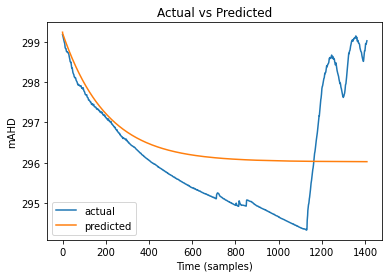

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_cnn_19_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

Num_Exp = 15
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_univar_cnn_19_post_2017=np.zeros(Num_Exp)
test_acc_univar_cnn_19_post_2017=np.zeros(Num_Exp)
Step_RMSE_univar_cnn_19_post_2017=np.zeros([Num_Exp,n_steps_out])

model_univar_cnn_19_post_2017 = Sequential()
model_univar_cnn_19_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_univar_cnn_19_post_2017.add(MaxPooling1D(pool_size=2))
model_univar_cnn_19_post_2017.add(Flatten())
model_univar_cnn_19_post_2017.add(Dense(25, activation='relu'))
model_univar_cnn_19_post_2017.add(Dense(1))
model_univar_cnn_19_post_2017.compile(optimizer='adam', loss='mse')
model_univar_cnn_19_post_2017.summary()
Best_RMSE_univar_cnn_19_post_2017 = 10000

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_cnn_19_post_2017
    #batch_size=64, 
    model_univar_cnn_19_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_cnn_19_post_2017.predict(x_train).flatten()
    y_predicttest = model_univar_cnn_19_post_2017.predict(x_test).flatten()
    train_acc_univar_cnn_19_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_cnn_19_post_2017[run] = rmse( y_predicttest, y_test)
    if test_acc_univar_cnn_19_post_2017[run]<Best_RMSE_univar_cnn_19_post_2017:
        Best_RMSE_univar_cnn_19_post_2017=test_acc_univar_cnn_19_post_2017[run]
        Best_Predict_Test_univar_cnn_19_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_cnn_19_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 25)                1625      
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,843
Trainable params: 1,843
Non-trainable params: 0
____________________________________________________

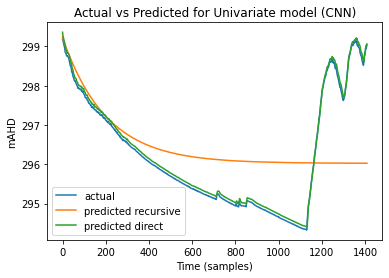

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_cnn_19_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_univar_cnn_19_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_cnn_19_post_2017.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_univar_cnn_19_recursive[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_univar_cnn_19_post_2017[:])
actual = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

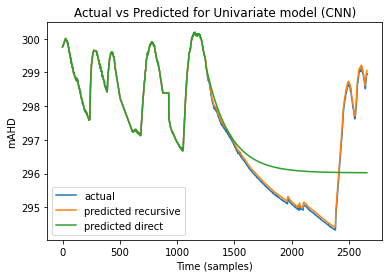

In [ ]:
x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_cnn_19.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_univar_cnn_19_post_2017

0.08429672472907136

In [ ]:
Best_RMSE_univar_cnn_19_recursive

1.2655714476186548

In [ ]:
Best_NSE_univar_cnn_19_post_2017 = r2_score(Best_Predict_Test_univar_cnn_19_post_2017, y_test[:])
Best_NSE_univar_cnn_19_recursive = r2_score(Best_Predict_Test_univar_cnn_19_recursive, y_test[:])

In [ ]:
Best_NSE_univar_cnn_19_post_2017

0.9965278239310428

In [ ]:
Best_NSE_univar_cnn_19_recursive

-2.0287236603289527

### Streamflow

In [ ]:
in_seq1 = array(m19_daily['mAHD_x'][:-1])
in_seq2 = array(m19_daily['mAHD_y'][:-1])
out_seq = array(m19_daily['mAHD_y'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000
 



train_acc_streamflow_cnn=np.zeros(Num_Exp)
test_acc_streamflow_cnn=np.zeros(Num_Exp)
Step_RMSE_streamflow_cnn=np.zeros([Num_Exp,n_steps_out])

model_streamflow_cnn = Sequential()
model_streamflow_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_cnn.add(MaxPooling1D(pool_size=2))
model_streamflow_cnn.add(Flatten())
model_streamflow_cnn.add(Dense(25, activation='relu'))
model_streamflow_cnn.add(Dense(1))
model_streamflow_cnn.compile(optimizer='adam', loss='mse')
model_streamflow_cnn.summary()

# fit model_streamflow_cnn
Best_RMSE_streamflow_cnn=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_cnn
    #batch_size=64, 
    model_streamflow_cnn.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_cnn.predict(x_train).flatten()
    y_predicttest = model_streamflow_cnn.predict(x_test).flatten()
    train_acc_streamflow_cnn[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_cnn[run] = rmse( y_predicttest, y_test) 
    if test_acc_streamflow_cnn[run]<Best_RMSE_streamflow_cnn:
        Best_RMSE_streamflow_cnn=test_acc_streamflow_cnn[run]
        Best_Predict_Test_streamflow_cnn=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_cnn[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)


In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn[:], label='predicted cnn')
plt.plot(x_data, Best_Predict_Test_streamflow[:], label='predicted lstm')

plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow

In [ ]:
Best_RMSE_streamflow_cnn

#### Post 2017

In [ ]:
in_seq1 = array(m19_daily['SF_mAHD'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_cnn_19_recursive=np.zeros(Num_Exp)
test_acc_streamflow_cnn_19_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_cnn_19_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_cnn_19_recursive = Sequential()
model_streamflow_cnn_19_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_cnn_19_recursive.add(MaxPooling1D(pool_size=2))
model_streamflow_cnn_19_recursive.add(Flatten())
model_streamflow_cnn_19_recursive.add(Dense(25, activation='relu'))
model_streamflow_cnn_19_recursive.add(Dense(1))
model_streamflow_cnn_19_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_cnn_19_recursive.summary()

Best_RMSE_streamflow_cnn_19_recursive=1000   #Assigning a large number 

outputs_streamflow_cnn_19_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_19_recursive
    #batch_size=64, 
    model_streamflow_cnn_19_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_cnn_19_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_cnn_19_recursive, x_test_extra_samples[0][:,1], streamflow_cnn_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_cnn_19_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_cnn_19_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_cnn_19_recursive[run]) 
    outputs_streamflow_cnn_19_recursive[run,] = y_predicttest
    if test_acc_streamflow_cnn_19_recursive[run]<Best_RMSE_streamflow_cnn_19_recursive:
        Best_RMSE_streamflow_cnn_19_recursive=test_acc_streamflow_cnn_19_recursive[run]
        Best_Predict_Test_streamflow_cnn_19_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_cnn_19_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 25)                1625      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
___________________________________________________

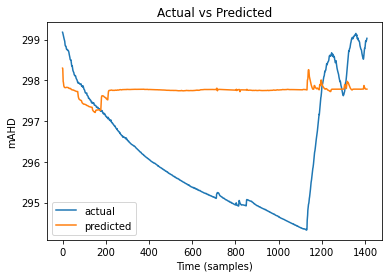

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_19_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m19_daily['SF_mAHD'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_cnn_19_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_cnn_19_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_cnn_19_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_cnn_19_post_2017 = Sequential()
model_streamflow_cnn_19_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_cnn_19_post_2017.add(MaxPooling1D(pool_size=2))
model_streamflow_cnn_19_post_2017.add(Flatten())
model_streamflow_cnn_19_post_2017.add(Dense(25, activation='relu'))
model_streamflow_cnn_19_post_2017.add(Dense(1))
model_streamflow_cnn_19_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_cnn_19_post_2017.summary()

Best_RMSE_streamflow_cnn_19_post_2017=1000   #Assigning a large number 
outputs_streamflow_cnn_19_post_2017 = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_17_post_2017
    #batch_size=64, 
    model_streamflow_cnn_19_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_cnn_19_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_cnn_19_post_2017.predict(x_test).flatten()
    train_acc_streamflow_cnn_19_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_cnn_19_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_cnn_19_post_2017[run])  
    outputs_streamflow_cnn_19_post_2017[run,] = y_predicttest
    if test_acc_streamflow_cnn_19_post_2017[run]<Best_RMSE_streamflow_cnn_19_post_2017:
        Best_RMSE_streamflow_cnn_19_post_2017=test_acc_streamflow_cnn_19_post_2017[run]
        Best_Predict_Test_streamflow_cnn_19_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_cnn_19_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 25)                1625      
                                                                 
 dense_15 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
___________________________________________________

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_cnn_19_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_cnn_19_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_cnn_19_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_cnn_19_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_cnn_19_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_cnn_19_recursive, 50, axis=0)
in_between_percentage_streamflow_cnn_19_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_cnn_19_recursive

0.25

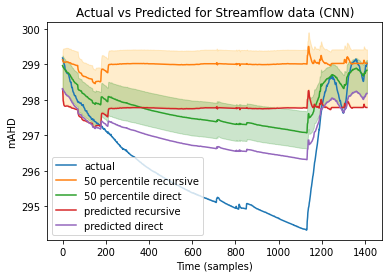

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_19_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_19_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_19_post_2017.png',dpi=300) 
plt.show()
plt.close()

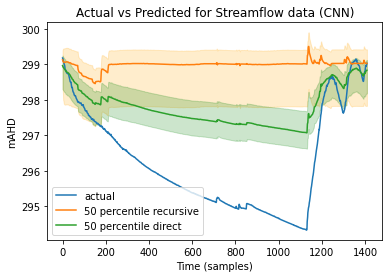

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_19_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

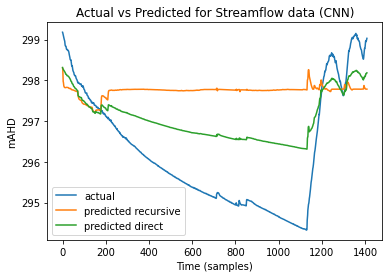

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_19_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_19_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_19_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_cnn_19_post_2017[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_cnn_19_recursive[:])
actual = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

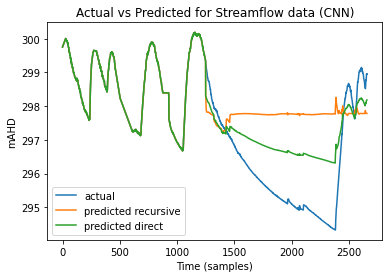

In [ ]:
x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_19.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_cnn_19_post_2017

1.1850893310139978

In [ ]:
Best_RMSE_streamflow_cnn_19_recursive

2.073198227650885

In [ ]:
Best_NSE_streamflow_cnn_19_post_2017 = r2_score(Best_Predict_Test_streamflow_cnn_19_post_2017, y_test[:])
Best_NSE_streamflow_cnn_19_recursive = r2_score(Best_Predict_Test_streamflow_cnn_19_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_cnn_19_post_2017

-3.4398582361890586

In [ ]:
Best_NSE_streamflow_cnn_19_recursive

-261.87545002714927

In [ ]:
saved_map = {
    'outputs_streamflow_cnn_19_post_2017':outputs_streamflow_cnn_19_post_2017,
    'model_streamflow_cnn_19_post_2017': model_streamflow_cnn_19_post_2017,
    'train_acc_streamflow_cnn_19_post_2017': train_acc_streamflow_cnn_19_post_2017,
    'test_acc_streamflow_cnn_19_post_2017': test_acc_streamflow_cnn_19_post_2017,
    'Step_RMSE_streamflow_cnn_19_post_2017': Step_RMSE_streamflow_cnn_19_post_2017,
    'Best_predict_test_streamflow_cnn_19_post_2017': Best_Predict_Test_streamflow_cnn_19_post_2017,
    'Best_RMSE_streamflow_cnn_19_post_2017': Best_RMSE_streamflow_cnn_19_post_2017,
    'Best_NSE_streamflow_cnn_19_post_2017':Best_NSE_streamflow_cnn_19_post_2017,
    
    'outputs_streamflow_cnn_19_recursive':outputs_streamflow_cnn_19_recursive,
    'model_streamflow_cnn_19_recursive': model_streamflow_cnn_19_recursive,
    'train_acc_streamflow_cnn_19_recursive': train_acc_streamflow_cnn_19_recursive,
    'test_acc_streamflow_cnn_19_recursive': test_acc_streamflow_cnn_19_recursive,
    'Step_RMSE_streamflow_cnn_19_recursive': Step_RMSE_streamflow_cnn_19_recursive,
    'Best_predict_test_streamflow_cnn_19_recursive': Best_Predict_Test_streamflow_cnn_19_recursive,
    'Best_RMSE_streamflow_cnn_19_recursive': Best_RMSE_streamflow_cnn_19_recursive,
    'Best_NSE_streamflow_cnn_19_recursive':Best_NSE_streamflow_cnn_19_recursive,
    'in_between_percentage_streamflow_cnn_19_recursive':in_between_percentage_streamflow_cnn_19_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_19_streamflow_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
# saved_map = {

#     'model_streamflow_cnn_19_recursive': model_streamflow_cnn_19_recursive,
#     'train_acc_streamflow_cnn_19_recursive': train_acc_streamflow_cnn_19_recursive,
#     'test_acc_streamflow_cnn_19_recursive': test_acc_streamflow_cnn_19_recursive,
#     'Step_RMSE_streamflow_cnn_19_recursive': Step_RMSE_streamflow_cnn_19_recursive,
#     'Best_predict_test_streamflow_cnn_19_recursive': Best_Predict_Test_streamflow_cnn_19_recursive,
#     'Best_RMSE_streamflow_cnn_19_recursive': Best_RMSE_streamflow_cnn_19_recursive,
#     'Best_NSE_streamflow_cnn_19_recursive':Best_NSE_streamflow_cnn_19_recursive,
#     'model_streamflow_cnn_19_post_2017': model_streamflow_cnn_19_post_2017,
#     'train_acc_streamflow_cnn_19_post_2017': train_acc_streamflow_cnn_19_post_2017,
#     'test_acc_streamflow_cnn_19_post_2017': test_acc_streamflow_cnn_19_post_2017,
#     'Step_RMSE_streamflow_cnn_19_post_2017': Step_RMSE_streamflow_cnn_19_post_2017,
#     'Best_predict_test_streamflow_cnn_19_post_2017': Best_Predict_Test_streamflow_cnn_19_post_2017,
#     'Best_RMSE_streamflow_cnn_19_post_2017': Best_RMSE_streamflow_cnn_19_post_2017,
#     'Best_NSE_streamflow_cnn_19_post_2017':Best_NSE_streamflow_cnn_19_post_2017,
# }

# pick_insert = open('drive/My Drive/Thesis/Thesis/data_19_cnn_post_2017.pickle','wb')
# pickle.dump(saved_map, pick_insert)
# pick_insert.close()

### Discretised streamflow

In [ ]:

in_seq1 = array(m19_daily['discretised_flow'][:-1])
in_seq2 = array(m19_daily['mAHD_y'][:-1])
out_seq = array(m19_daily['mAHD_y'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised_cnn=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn = Sequential()
model_streamflow_discretised_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn.add(Flatten())
model_streamflow_discretised_cnn.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn.add(Dense(1))
model_streamflow_discretised_cnn.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn.summary()
Best_RMSE_streamflow_discretised_cnn=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_cnn
    #batch_size=64, 
    model_streamflow_discretised_cnn.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_cnn.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_cnn.predict(x_test).flatten()
    train_acc_streamflow_discretised_cnn[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_cnn[run] = rmse( y_predicttest, y_test) 
    if test_acc_streamflow_discretised_cnn[run]<Best_RMSE_streamflow_discretised_cnn:
        Best_RMSE_streamflow_discretised_cnn=test_acc_streamflow_discretised_cnn[run]
        Best_Predict_Test_streamflow_discretised_cnn=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

KeyError: ignored

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn[:], label='predicted cnn')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised[:], label='predicted lstm')

plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised

In [ ]:
Best_RMSE_streamflow_discretised_cnn

#### Post 2017


In [ ]:
in_seq1 = array(m19_daily['discretised_flow'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 50
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_discretised_cnn_19_recursive=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_19_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_19_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_19_recursive = Sequential()
model_streamflow_discretised_cnn_19_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_19_recursive.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_19_recursive.add(Flatten())
model_streamflow_discretised_cnn_19_recursive.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_19_recursive.add(Dense(1))
model_streamflow_discretised_cnn_19_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_19_recursive.summary()

Best_RMSE_streamflow_discretised_cnn_19_recursive=1000   #Assigning a large number 

outputs_streamflow_discretised_cnn_19_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_19_recursive
    #batch_size=64, 
    model_streamflow_discretised_cnn_19_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_cnn_19_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_discretised_cnn_19_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_cnn_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_discretised_cnn_19_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_cnn_19_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_discretised_cnn_19_recursive[run]) 
    outputs_streamflow_discretised_cnn_19_recursive[run,] = y_predicttest
    if test_acc_streamflow_discretised_cnn_19_recursive[run]<Best_RMSE_streamflow_discretised_cnn_19_recursive:
        Best_RMSE_streamflow_discretised_cnn_19_recursive=test_acc_streamflow_discretised_cnn_19_recursive[run]
        Best_Predict_Test_streamflow_discretised_cnn_19_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_19_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 25)                1625      
                                                                 
 dense_17 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

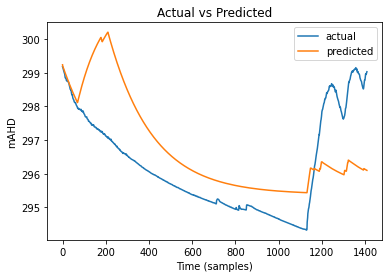

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_19_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m19_daily['discretised_flow'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised_cnn_19_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_19_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_19_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_19_post_2017 = Sequential()
model_streamflow_discretised_cnn_19_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_19_post_2017.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_19_post_2017.add(Flatten())
model_streamflow_discretised_cnn_19_post_2017.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_19_post_2017.add(Dense(1))
model_streamflow_discretised_cnn_19_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_19_post_2017.summary()

Best_RMSE_streamflow_discretised_cnn_19_post_2017=1000   #Assigning a large number 

outputs_streamflow_discretised_cnn_19_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_17_post_2017
    #batch_size=64, 
    model_streamflow_discretised_cnn_19_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_cnn_19_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_cnn_19_post_2017.predict(x_test).flatten()
    train_acc_streamflow_discretised_cnn_19_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_cnn_19_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_discretised_cnn_19_post_2017[run])  
    outputs_streamflow_discretised_cnn_19_post_2017[run,] = y_predicttest
    if test_acc_streamflow_discretised_cnn_19_post_2017[run]<Best_RMSE_streamflow_discretised_cnn_19_post_2017:
        Best_RMSE_streamflow_discretised_cnn_19_post_2017=test_acc_streamflow_discretised_cnn_19_post_2017[run]
        Best_Predict_Test_streamflow_discretised_cnn_19_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_19_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 25)                1625      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_19_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_19_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_19_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_discretised_cnn_19_recursive[29:], 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_discretised_cnn_19_recursive[29:], 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_discretised_cnn_19_recursive[29:], 50, axis=0)
in_between_percentage_streamflow_discretised_cnn_19_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_discretised_cnn_19_recursive

1.0

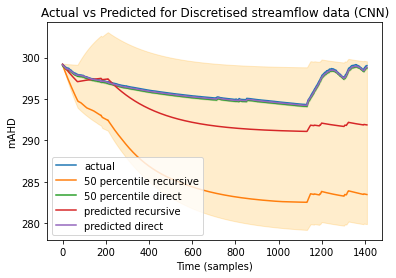

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_19_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_19_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_19_post_2017.png',dpi=300) 
plt.show()
plt.close()

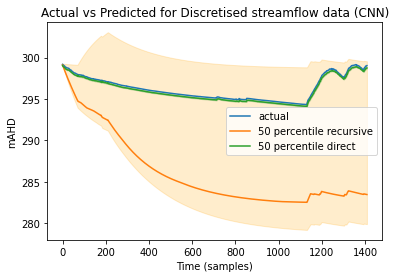

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_19_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

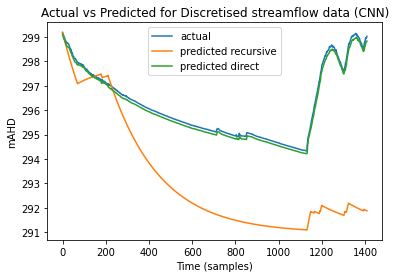

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_19_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_19_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_19_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_19_post_2017[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_19_recursive[:])
actual = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

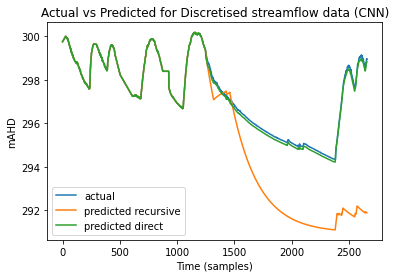

In [ ]:
x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_19.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_cnn_19_post_2017

0.12896907637511557

In [ ]:
Best_RMSE_streamflow_discretised_cnn_19_recursive

3.6466104931098644

In [ ]:
Best_NSE_streamflow_discretised_cnn_19_post_2017 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_19_post_2017, y_test[:])
Best_NSE_streamflow_discretised_cnn_19_recursive = r2_score(Best_Predict_Test_streamflow_discretised_cnn_19_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_discretised_cnn_19_post_2017

0.9918220968645439

In [ ]:
Best_NSE_streamflow_discretised_cnn_19_recursive

-1.5210870701542225

In [ ]:
saved_map = {
    'outputs_streamflow_discretised_cnn_19_recursive':outputs_streamflow_discretised_cnn_19_recursive,
    'model_streamflow_discretised_cnn_19_recursive': model_streamflow_discretised_cnn_19_recursive,
    'train_acc_streamflow_discretised_cnn_19_recursive': train_acc_streamflow_discretised_cnn_19_recursive,
    'test_acc_streamflow_discretised_cnn_19_recursive': test_acc_streamflow_discretised_cnn_19_recursive,
    'Step_RMSE_streamflow_discretised_cnn_19_recursive': Step_RMSE_streamflow_discretised_cnn_19_recursive,
    'Best_predict_test_streamflow_discretised_cnn_19_recursive': Best_Predict_Test_streamflow_discretised_cnn_19_recursive,
    'Best_RMSE_streamflow_discretised_cnn_19_recursive': Best_RMSE_streamflow_discretised_cnn_19_recursive,
    'Best_NSE_streamflow_discretised_cnn_19_recursive':Best_NSE_streamflow_discretised_cnn_19_recursive,

    'outputs_streamflow_discretised_cnn_19_post_2017':outputs_streamflow_discretised_cnn_19_post_2017,
    'model_streamflow_discretised_cnn_19_post_2017': model_streamflow_discretised_cnn_19_post_2017,
    'train_acc_streamflow_discretised_cnn_19_post_2017': train_acc_streamflow_discretised_cnn_19_post_2017,
    'test_acc_streamflow_discretised_cnn_19_post_2017': test_acc_streamflow_discretised_cnn_19_post_2017,
    'Step_RMSE_streamflow_discretised_cnn_19_post_2017': Step_RMSE_streamflow_discretised_cnn_19_post_2017,
    'Best_predict_test_streamflow_discretised_cnn_19_post_2017': Best_Predict_Test_streamflow_discretised_cnn_19_post_2017,
    'Best_RMSE_streamflow_discretised_cnn_19_post_2017': Best_RMSE_streamflow_discretised_cnn_19_post_2017,
    'Best_NSE_streamflow_discretised_cnn_19_post_2017':Best_NSE_streamflow_discretised_cnn_19_post_2017,
    'in_between_percentage_streamflow_discretised_cnn_19_recursive': in_between_percentage_streamflow_discretised_cnn_19_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_19_streamflow_discretised_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Rainfall

In [ ]:

in_seq1 = array(m19_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m19_daily_rainfall['mAHD'][:-1])
out_seq = array(m19_daily_rainfall['mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_rainfall_cnn=np.zeros(Num_Exp)
test_acc_rainfall_cnn=np.zeros(Num_Exp)
Step_RMSE_rainfall_cnn=np.zeros([Num_Exp,n_steps_out])

model_rainfall_cnn = Sequential()
model_rainfall_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_cnn.add(MaxPooling1D(pool_size=2))
model_rainfall_cnn.add(Flatten())
model_rainfall_cnn.add(Dense(25, activation='relu'))
model_rainfall_cnn.add(Dense(1))
model_rainfall_cnn.compile(optimizer='adam', loss='mse')
model_rainfall_cnn.summary()
Best_RMSE_rainfall_cnn=1000 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model
    #batch_size=64, 
    model_rainfall_cnn.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_cnn.predict(x_train).flatten()
    y_predicttest = model_rainfall_cnn.predict(x_test).flatten()
    train_acc_rainfall_cnn[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_cnn[run] = rmse( y_predicttest, y_test) 
    if test_acc_rainfall_cnn[run]<Best_RMSE_rainfall_cnn:
        Best_RMSE_rainfall_cnn=test_acc_rainfall_cnn[run]
        Best_Predict_Test_rainfall_cnn=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_cnn[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn[:], label='predicted cnn')
plt.plot(x_data, Best_Predict_Test[:], label='predicted lstm')

plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE

In [ ]:
Best_RMSE_rainfall_cnn

#### Post 2017

In [ ]:
in_seq1 = array(m19_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m19_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m19_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 35
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_rainfall_cnn_19_recursive=np.zeros(Num_Exp)
test_acc_rainfall_cnn_19_recursive=np.zeros(Num_Exp)
Step_RMSE_rainfall_cnn_19_recursive=np.zeros([Num_Exp,n_steps_out])

model_rainfall_cnn_19_recursive = Sequential()
model_rainfall_cnn_19_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_cnn_19_recursive.add(MaxPooling1D(pool_size=2))
model_rainfall_cnn_19_recursive.add(Flatten())
model_rainfall_cnn_19_recursive.add(Dense(25, activation='relu'))
model_rainfall_cnn_19_recursive.add(Dense(1))
model_rainfall_cnn_19_recursive.compile(optimizer='adam', loss='mse')
model_rainfall_cnn_19_recursive.summary()

Best_RMSE_rainfall_cnn_19_recursive=1000   #Assigning a large number 

outputs_rainfall_cnn_19_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_19_recursive
    #batch_size=64, 
    model_rainfall_cnn_19_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_cnn_19_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_rainfall_cnn_19_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_cnn_post_2017,num_post_2017-3, 3)
    train_acc_rainfall_cnn_19_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_cnn_19_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_rainfall_cnn_19_recursive[run]) 
    outputs_rainfall_cnn_19_recursive[run,] = y_predicttest
    if test_acc_rainfall_cnn_19_recursive[run]<Best_RMSE_rainfall_cnn_19_recursive:
        Best_RMSE_rainfall_cnn_19_recursive=test_acc_rainfall_cnn_19_recursive[run]
        Best_Predict_Test_rainfall_cnn_19_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_cnn_19_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
______________________________________________________

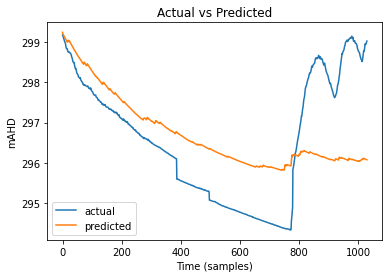

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_19_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m19_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m19_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m19_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 35
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_rainfall_cnn_19_post_2017=np.zeros(Num_Exp)
test_acc_rainfall_cnn_19_post_2017=np.zeros(Num_Exp)
Step_RMSE_rainfall_cnn_19_post_2017=np.zeros([Num_Exp,n_steps_out])

model_rainfall_cnn_19_post_2017 = Sequential()
model_rainfall_cnn_19_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_cnn_19_post_2017.add(MaxPooling1D(pool_size=2))
model_rainfall_cnn_19_post_2017.add(Flatten())
model_rainfall_cnn_19_post_2017.add(Dense(25, activation='relu'))
model_rainfall_cnn_19_post_2017.add(Dense(1))
model_rainfall_cnn_19_post_2017.compile(optimizer='adam', loss='mse')
model_rainfall_cnn_19_post_2017.summary()

Best_RMSE_rainfall_cnn_19_post_2017=1000   #Assigning a large number 

outputs_rainfall_cnn_19_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_17_post_2017
    #batch_size=64, 
    model_rainfall_cnn_19_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_cnn_19_post_2017.predict(x_train).flatten()
    y_predicttest = model_rainfall_cnn_19_post_2017.predict(x_test).flatten()
    train_acc_rainfall_cnn_19_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_cnn_19_post_2017[run] = rmse( y_predicttest, y_test)
    outputs_rainfall_cnn_19_post_2017[run,] = y_predicttest
    print("RMSE value:", test_acc_rainfall_cnn_19_post_2017[run])  
    if test_acc_rainfall_cnn_19_post_2017[run]<Best_RMSE_rainfall_cnn_19_post_2017:
        Best_RMSE_rainfall_cnn_19_post_2017=test_acc_rainfall_cnn_19_post_2017[run]
        Best_Predict_Test_rainfall_cnn_19_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_cnn_19_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

In [ ]:
fx_high_post_2017 = np.percentile(outputs_rainfall_cnn_19_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_rainfall_cnn_19_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_rainfall_cnn_19_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_rainfall_cnn_19_recursive[11:], 95, axis=0)
fx_low_recursive = np.percentile(outputs_rainfall_cnn_19_recursive[11:], 5, axis=0)
fx_mid_recursive = np.percentile(outputs_rainfall_cnn_19_recursive[11:], 50, axis=0)
in_between_percentage_rainfall_cnn_19_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_rainfall_cnn_19_recursive

0.7774538386783285

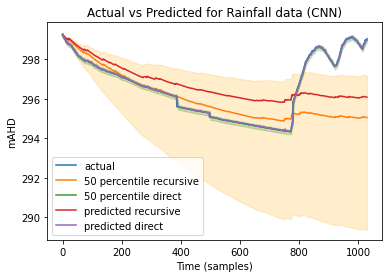

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_19_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_19_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_19_post_2017.png',dpi=300) 
plt.show()
plt.close()

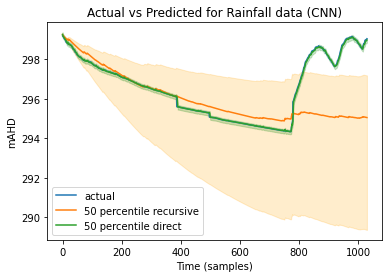

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_19_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

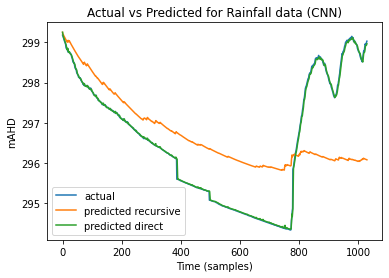

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_19_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_19_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_19_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily_rainfall[m19_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_cnn_19_post_2017[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_cnn_19_recursive[:])
actual = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

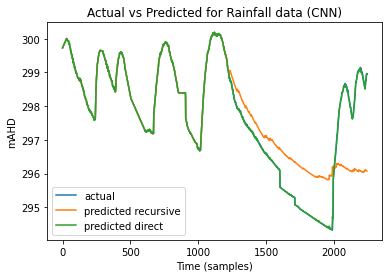

In [ ]:
x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_19.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_rainfall_cnn_19_post_2017

0.054199898146175124

In [ ]:
Best_RMSE_rainfall_cnn_19_recursive

1.3863481604606407

In [ ]:
Best_NSE_rainfall_cnn_19_post_2017 = r2_score(Best_Predict_Test_rainfall_cnn_19_post_2017, y_test[:])
Best_NSE_rainfall_cnn_19_recursive = r2_score(Best_Predict_Test_rainfall_cnn_19_recursive, y_test[:])

In [ ]:
Best_NSE_rainfall_cnn_19_post_2017

0.9987340262760743

In [ ]:
Best_NSE_rainfall_cnn_19_recursive

-1.4043728405570017

In [ ]:
saved_map = {
    'outputs_rainfall_cnn_19_recursive':outputs_rainfall_cnn_19_recursive,
    'model_rainfall_cnn_19_recursive': model_rainfall_cnn_19_recursive,
    'train_acc_rainfall_cnn_19_recursive': train_acc_rainfall_cnn_19_recursive,
    'test_acc_rainfall_cnn_19_recursive': test_acc_rainfall_cnn_19_recursive,
    'Step_RMSE_rainfall_cnn_19_recursive': Step_RMSE_rainfall_cnn_19_recursive,
    'Best_predict_test_rainfall_cnn_19_recursive': Best_Predict_Test_rainfall_cnn_19_recursive,
    'Best_RMSE_rainfall_cnn_19_recursive': Best_RMSE_rainfall_cnn_19_recursive,
    'Best_NSE_rainfall_cnn_19_recursive':Best_NSE_rainfall_cnn_19_recursive,
    
    'outputs_rainfall_cnn_19_post_2017':outputs_rainfall_cnn_19_post_2017,
    'model_rainfall_cnn_19_post_2017': model_rainfall_cnn_19_post_2017,
    'train_acc_rainfall_cnn_19_post_2017': train_acc_rainfall_cnn_19_post_2017,
    'test_acc_rainfall_cnn_19_post_2017': test_acc_rainfall_cnn_19_post_2017,
    'Step_RMSE_rainfall_cnn_19_post_2017': Step_RMSE_rainfall_cnn_19_post_2017,
    'Best_predict_test_rainfall_cnn_19_post_2017': Best_Predict_Test_rainfall_cnn_19_post_2017,
    'Best_RMSE_rainfall_cnn_19_post_2017': Best_RMSE_rainfall_cnn_19_post_2017,
    'Best_NSE_rainfall_cnn_19_post_2017':Best_NSE_rainfall_cnn_19_post_2017,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_19_rainfall_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

## Saving models

In [ ]:
saved_map = {
    'model_rainfall': model,
    'train_acc_rainfall': train_acc,
    'test_acc_rainfall': test_acc,
    'Step_RMSE_rainfall': Step_RMSE,
    'Best_predict_test_rainfall': Best_Predict_Test,
    'Best_RMSE': Best_RMSE,
    'model_streamflow': model_streamflow,
    'train_acc_streamflow': train_acc_streamflow,
    'test_acc_streamflow': test_acc_streamflow,
    'Step_RMSE_streamflow': Step_RMSE_streamflow,
    'Best_predict_test_streamflow': Best_Predict_Test_streamflow,
    'Best_RMSE_streamflow': Best_RMSE_streamflow,
    'model_streamflow_discretised': model_streamflow_discretised,
    'train_acc_streamflow_discretised': train_acc_streamflow_discretised,
    'test_acc_streamflow_discretised': test_acc_streamflow_discretised,
    'Step_RMSE_streamflow_discretised': Step_RMSE_streamflow_discretised,
    'Best_predict_test_streamflow_discretised': Best_Predict_Test_streamflow_discretised,
    'Best_RMSE_streamflow_discretised': Best_RMSE_streamflow_discretised,
    'model_rainfall': model_rainfall_cnn,
    'train_acc_rainfall': train_acc_rainfall_cnn,
    'test_acc_rainfall': test_acc_rainfall_cnn,
    'Step_RMSE_rainfall': Step_RMSE_rainfall_cnn,
    'Best_predict_test_rainfall': Best_Predict_Test_rainfall_cnn,
    'Best_RMSE': Best_RMSE_rainfall_cnn,
    'model_streamflow_cnn': model_streamflow_cnn,
    'train_acc_streamflow_cnn': train_acc_streamflow_cnn,
    'test_acc_streamflow_cnn': test_acc_streamflow_cnn,
    'Step_RMSE_streamflow_cnn': Step_RMSE_streamflow_cnn,
    'Best_predict_test_streamflow_cnn': Best_Predict_Test_streamflow_cnn,
    'Best_RMSE_streamflow_cnn': Best_RMSE_streamflow_cnn,
    'model_streamflow_discretised_cnn': model_streamflow_discretised_cnn,
    'train_acc_streamflow_discretised_cnn': train_acc_streamflow_discretised_cnn,
    'test_acc_streamflow_discretised_cnn': test_acc_streamflow_discretised_cnn,
    'Step_RMSE_streamflow_discretised_cnn': Step_RMSE_streamflow_discretised_cnn,
    'Best_predict_test_streamflow_discretised_cnn': Best_Predict_Test_streamflow_discretised_cnn,
    'Best_RMSE_streamflow_discretised_cnn': Best_RMSE_streamflow_discretised_cnn,
}

# Save the python variable 'saved_map' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
saved_map = {
    'model_rainfall_post_2017': model_rainfall_post_2017,
    'train_acc_rainfall_post_2017': train_acc_rainfall_post_2017,
    'test_acc_rainfall_post_2017': test_acc_rainfall_post_2017,
    'Step_RMSE_rainfall_post_2017': Step_RMSE_rainfall_post_2017,
    'Best_predict_test_rainfall_post_2017': Best_Predict_Test_rainfall_post_2017,
    'Best_RMSE_rainfall_post_2017': Best_RMSE_rainfall_post_2017,
    'Best_NSE_rainfall_post_2017': Best_NSE_rainfall_post_2017,
    

    'model_streamflow_post_2017': model_streamflow_post_2017,
    'train_acc_streamflow_post_2017': train_acc_streamflow_post_2017,
    'test_acc_streamflow_post_2017': test_acc_streamflow_post_2017,
    'Step_RMSE_streamflow_post_2017': Step_RMSE_streamflow_post_2017,
    'Best_predict_test_streamflow_post_2017': Best_Predict_Test_streamflow_post_2017,
    'Best_RMSE_streamflow_post_2017': Best_RMSE_streamflow_post_2017,
    'Best_NSE_streamflow_post_2017': Best_NSE_streamflow_post_2017,
    
    'model_streamflow_discretised_post_2017': model_streamflow_discretised_post_2017,
    'train_acc_streamflow_discretised_post_2017': train_acc_streamflow_discretised_post_2017,
    'test_acc_streamflow_discretised_post_2017': test_acc_streamflow_discretised_post_2017,
    'Step_RMSE_streamflow_discretised_post_2017': Step_RMSE_streamflow_discretised_post_2017,
    'Best_predict_test_streamflow_discretised_post_2017': Best_Predict_Test_streamflow_discretised_post_2017,
    'Best_RMSE_streamflow_discretised_post_2017': Best_RMSE_streamflow_discretised_post_2017,
    'Best_NSE_streamflow_discretised_post_2017': Best_NSE_streamflow_discretised_post_2017,
}

# Save the python variable 'saved_map' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data_post_2017_with_NSE.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
saved_map_recursive = {
    'model_rainfall_recursive': model_rainfall_recursive,
    'train_acc_rainfall_recursive': train_acc_rainfall_recursive,
    'test_acc_rainfall_recursive': test_acc_rainfall_recursive,
    'Step_RMSE_rainfall_recursive': Step_RMSE_rainfall_recursive,
    'Best_predict_test_rainfall_recursive': Best_Predict_Test_rainfall_recursive,
    'Best_RMSE_rainfall_recursive': Best_RMSE_rainfall_recursive,
    'Best_NSE_rainfall_recursive': Best_NSE_rainfall_recursive,

    'model_streamflow_recursive': model_streamflow_recursive,
    'train_acc_streamflow_recursive': train_acc_streamflow_recursive,
    'test_acc_streamflow_recursive': test_acc_streamflow_recursive,
    'Step_RMSE_streamflow_recursive': Step_RMSE_streamflow_recursive,
    'Best_predict_test_streamflow_recursive': Best_Predict_Test_streamflow_recursive,
    'Best_RMSE_streamflow_recursive': Best_RMSE_streamflow_recursive,
    'Best_NSE_streamflow_recursive': Best_NSE_streamflow_recursive,

    'model_streamflow_discretised_recursive': model_streamflow_discretised_recursive,
    'train_acc_streamflow_discretised_recursive': train_acc_streamflow_discretised_recursive,
    'test_acc_streamflow_discretised_recursive': test_acc_streamflow_discretised_recursive,
    'Step_RMSE_streamflow_discretised_recursive': Step_RMSE_streamflow_discretised_recursive,
    'Best_predict_test_streamflow_discretised_recursive': Best_Predict_Test_streamflow_discretised_recursive,
    'Best_RMSE_streamflow_discretised_recursive': Best_RMSE_streamflow_discretised_recursive,
    'Best_NSE_streamflow_discretised_recursive': Best_NSE_streamflow_discretised_recursive,
}

# Save the python variable 'saved_map_recursive' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data_recursive.pickle','wb')
pickle.dump(saved_map_recursive, pick_insert)
pick_insert.close()

In [ ]:
saved_map = {
    'model_rainfall': model,
    'train_acc_rainfall': train_acc,
    'test_acc_rainfall': test_acc,
    'Step_RMSE_rainfall': Step_RMSE,
    'Best_predict_test_rainfall': Best_Predict_Test,
    'Best_RMSE': Best_RMSE,
    'model_streamflow': model_streamflow,
    'train_acc_streamflow': train_acc_streamflow,
    'test_acc_streamflow': test_acc_streamflow,
    'Step_RMSE_streamflow': Step_RMSE_streamflow,
    'Best_predict_test_streamflow': Best_Predict_Test_streamflow,
    'Best_RMSE_streamflow': Best_RMSE_streamflow,
    'model_streamflow_discretised': model_streamflow_discretised,
    'train_acc_streamflow_discretised': train_acc_streamflow_discretised,
    'test_acc_streamflow_discretised': test_acc_streamflow_discretised,
    'Step_RMSE_streamflow_discretised': Step_RMSE_streamflow_discretised,
    'Best_predict_test_streamflow_discretised': Best_Predict_Test_streamflow_discretised,
    'Best_RMSE_streamflow_discretised': Best_RMSE_streamflow_discretised,
    'model_rainfall': model_rainfall_cnn,
    'train_acc_rainfall': train_acc_rainfall_cnn,
    'test_acc_rainfall': test_acc_rainfall_cnn,
    'Step_RMSE_rainfall': Step_RMSE_rainfall_cnn,
    'Best_predict_test_rainfall': Best_Predict_Test_rainfall_cnn,
    'Best_RMSE': Best_RMSE_rainfall_cnn,
    'model_streamflow_cnn': model_streamflow_cnn,
    'train_acc_streamflow_cnn': train_acc_streamflow_cnn,
    'test_acc_streamflow_cnn': test_acc_streamflow_cnn,
    'Step_RMSE_streamflow_cnn': Step_RMSE_streamflow_cnn,
    'Best_predict_test_streamflow_cnn': Best_Predict_Test_streamflow_cnn,
    'Best_RMSE_streamflow_cnn': Best_RMSE_streamflow_cnn,
    'model_streamflow_discretised_cnn': model_streamflow_discretised_cnn,
    'train_acc_streamflow_discretised_cnn': train_acc_streamflow_discretised_cnn,
    'test_acc_streamflow_discretised_cnn': test_acc_streamflow_discretised_cnn,
    'Step_RMSE_streamflow_discretised_cnn': Step_RMSE_streamflow_discretised_cnn,
    'Best_predict_test_streamflow_discretised_cnn': Best_Predict_Test_streamflow_discretised_cnn,
    'Best_RMSE_streamflow_discretised_cnn': Best_RMSE_streamflow_discretised_cnn,
}

# Save the python variable 'saved_map' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data.pickle','rb')
data = pickle.load(pick_read)
pick_read.close()

## Re-opening models

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_recursive.pickle','rb')
data19 = pickle.load(pick_read)
pick_read.close()

#Best_NSE_streamflow_recursive = data19['Best_NSE_streamflow_recursive']
model_streamflow_recursive = data19['model_streamflow_recursive']
train_acc_streamflow_recursive = data19['train_acc_streamflow_recursive']
test_acc_streamflow_recursive = data19['test_acc_streamflow_recursive']
Step_RMSE_streamflow_recursive = data19['Step_RMSE_streamflow_recursive']
Best_Predict_Test_streamflow_recursive = data19['Best_predict_test_streamflow_recursive']
Best_RMSE_streamflow_recursive = data19['Best_RMSE_streamflow_recursive']

#Best_NSE_streamflow_discretised_recursive = data19['Best_NSE_streamflow_discretised_recursive']
model_streamflow_discretised_recursive = data19['model_streamflow_discretised_recursive']
train_acc_streamflow_discretised_recursive = data19['train_acc_streamflow_discretised_recursive']
test_acc_streamflow_discretised_recursive = data19['test_acc_streamflow_discretised_recursive']
Step_RMSE_streamflow_discretised_recursive = data19['Step_RMSE_streamflow_discretised_recursive']
Best_Predict_Test_streamflow_discretised_recursive = data19['Best_predict_test_streamflow_discretised_recursive']
Best_RMSE_streamflow_discretised_recursive = data19['Best_RMSE_streamflow_discretised_recursive']


#Best_NSE_streamflow_discretised_recursive = data19['Best_NSE_streamflow_discretised_recursive']
model_rainfall_recursive = data19['model_rainfall_recursive']
train_acc_rainfall_recursive = data19['train_acc_rainfall_recursive']
test_acc_rainfall_recursive = data19['test_acc_rainfall_recursive']
Step_RMSE_rainfall_recursive = data19['Step_RMSE_rainfall_recursive']
Best_Predict_Test_rainfall_recursive = data19['Best_predict_test_rainfall_recursive']
Best_RMSE_rainfall_recursive = data19['Best_RMSE_rainfall_recursive']


In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_post_2017.pickle','rb')
data19 = pickle.load(pick_read)
pick_read.close()



#Best_NSE_streamflow_post_2017 = data19['Best_NSE_streamflow_post_2017']
model_streamflow_post_2017 = data19['model_streamflow_post_2017'],
train_acc_streamflow_post_2017 = data19['train_acc_streamflow_post_2017'],
test_acc_streamflow_post_2017 = data19['test_acc_streamflow_post_2017'],
Step_RMSE_streamflow_post_2017 = data19['Step_RMSE_streamflow_post_2017'],
Best_Predict_Test_streamflow_post_2017 = data19['Best_predict_test_streamflow_post_2017']
Best_RMSE_streamflow_post_2017 = data19['Best_RMSE_streamflow_post_2017'],



#Best_NSE_streamflow_discretised_post_2017 = data19['Best_NSE_streamflow_discretised_post_2017']
model_streamflow_discretised_post_2017 = data19['model_streamflow_discretised_post_2017'],
train_acc_streamflow_discretised_post_2017 = data19['train_acc_streamflow_discretised_post_2017'],
test_acc_streamflow_discretised_post_2017 = data19['test_acc_streamflow_discretised_post_2017'],
Step_RMSE_streamflow_discretised_post_2017 = data19['Step_RMSE_streamflow_discretised_post_2017'],
Best_Predict_Test_streamflow_discretised_post_2017 = data19['Best_predict_test_streamflow_discretised_post_2017']
Best_RMSE_streamflow_discretised_post_2017 = data19['Best_RMSE_streamflow_discretised_post_2017'],



#Best_NSE_streamflow_discretised_recursive = data19['Best_NSE_streamflow_discretised_recursive']
model_rainfall_post_2017 = data19['model_rainfall_post_2017'],
train_acc_rainfall_post_2017 = data19['train_acc_rainfall_post_2017'],
test_acc_rainfall_post_2017 = data19['test_acc_rainfall_post_2017'],
Step_RMSE_rainfall_post_2017 = data19['Step_RMSE_rainfall_post_2017'],
Best_Predict_Test_rainfall_post_2017 = data19['Best_predict_test_rainfall_post_2017']
Best_RMSE_rainfall_post_2017 = data19['Best_RMSE_post_2017'],


KeyError: ignored

## LSTM model for borehole 18

### Univariate model

In [ ]:
in_seq1 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 50
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_univar_18_recursive=np.zeros(Num_Exp)
test_acc_univar_18_recursive=np.zeros(Num_Exp)
Step_RMSE_univar_18_recursive=np.zeros([Num_Exp,n_steps_out])

model_univar_18_recursive = Sequential()
model_univar_18_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_univar_18_recursive.add(Dense(n_steps_out))
model_univar_18_recursive.compile(optimizer='adam', loss='mse')
model_univar_18_recursive.summary()
Best_RMSE_univar_18_recursive=1000   #Assigning a large number 

outputs_univar_18_recursive = np.ones((Num_Exp, y_test.shape[0]))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_18_recursive
    #batch_size=64, 
    model_univar_18_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_18_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively_univariate(model_univar_18_recursive, x_test_extra_samples[0], num_post_2017-3, 3)
    train_acc_univar_18_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_18_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_univar_18_recursive[run]) 
    outputs_univar_18_recursive[run,] = y_predicttest
    if test_acc_univar_18_recursive[run]<Best_RMSE_univar_18_recursive:
        Best_RMSE_univar_18_recursive=test_acc_univar_18_recursive[run]
        Best_Predict_Test_univar_18_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_18_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 217.92410555879542
Experiment 2 in progress
RMSE value: 139.38916624203756
Experiment 3 in progress
RMSE value: 61.254795956748765
Experiment 4 in progress
RMSE value: 2.936105723672086
Experiment 5 in progress
RMSE value: 2.936105723672086
Experiment 6 in progress
RMSE value: 2.936105723672086
Experiment 7 in progress
RMSE value: 2.936105723672086
Experiment 8 in progress
RMSE value: 2.936105723672086
Experiment 

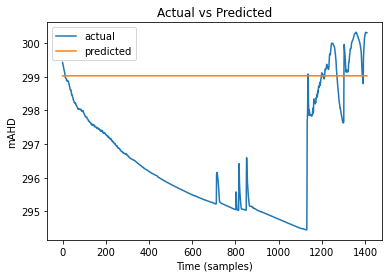

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_18_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

Num_Exp = 15
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_univar_18_post_2017=np.zeros(Num_Exp)
test_acc_univar_18_post_2017=np.zeros(Num_Exp)
Step_RMSE_univar_18_post_2017=np.zeros([Num_Exp,n_steps_out])

model_univar_18_post_2017 = Sequential()
model_univar_18_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_univar_18_post_2017.add(Dense(n_steps_out))
model_univar_18_post_2017.compile(optimizer='adam', loss='mse')
model_univar_18_post_2017.summary()
Best_RMSE_univar_18_post_2017=1000   #Assigning a large number 


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_18_post_2017
    #batch_size=64, 
    model_univar_18_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_18_post_2017.predict(x_train).flatten()
    y_predicttest = model_univar_18_post_2017.predict(x_test).flatten()
    train_acc_univar_18_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_18_post_2017[run] = rmse( y_predicttest, y_test)
    if test_acc_univar_18_post_2017[run]<Best_RMSE_univar_18_post_2017:
        Best_RMSE_univar_18_post_2017=test_acc_univar_18_post_2017[run]
        Best_Predict_Test_univar_18_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_18_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Total time for 15 experiments 1774.584496498108


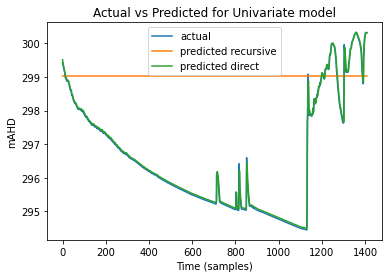

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_univar_18_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_18_post_2017.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_18_pre_2017 = m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_univar_18_recursive[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_univar_18_post_2017[:])
actual = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

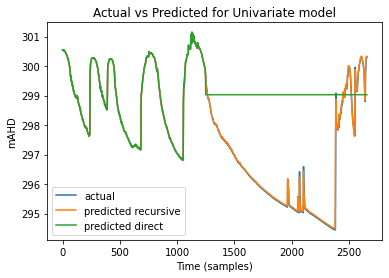

In [ ]:
x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_18.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_univar_18_post_2017

0.17367379274095157

In [ ]:
Best_RMSE_univar_18_recursive

5.486637120611374

In [ ]:
Best_NSE_univar_18_post_2017 = r2_score(Best_Predict_Test_univar_18_post_2017, y_test[:])
Best_NSE_univar_18_recursive = r2_score(Best_Predict_Test_univar_18_recursive, y_test[:])

In [ ]:
Best_NSE_univar_18_post_2017

0.98909514760028

In [ ]:
Best_NSE_univar_18_recursive

-5.98111483720614

### Streamflow

In [ ]:
in_seq1 = array(m18_daily['mAHD_x'][:-1])
in_seq2 = array(m18_daily['mAHD_y'][:-1])
out_seq = array(m18_daily['mAHD_y'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000
 



train_acc_streamflow_18=np.zeros(Num_Exp)
test_acc_streamflow_18=np.zeros(Num_Exp)
Step_RMSE_streamflow_18=np.zeros([Num_Exp,n_steps_out])

model_streamflow_18 = Sequential()
model_streamflow_18.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_18.add(Dense(n_steps_out))
model_streamflow_18.compile(optimizer='adam', loss='mse')
model_streamflow_18.summary()
Best_RMSE_streamflow_18=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_18
    #batch_size=64, 
    model_streamflow_18.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_18.predict(x_train).flatten()
    y_predicttest = model_streamflow_18.predict(x_test).flatten()
    train_acc_streamflow_18[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_18[run] = rmse( y_predicttest, y_test) 
    if test_acc_streamflow_18[run]<Best_RMSE_streamflow_18:
        Best_RMSE_streamflow_18=test_acc_streamflow_18[run]
        Best_Predict_Test_streamflow_18=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_18[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_18[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

#### Post 2017

In [ ]:
in_seq1 = array(m18_daily['SF_mAHD'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_18_recursive=np.zeros(Num_Exp)
test_acc_streamflow_18_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_18_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_18_recursive = Sequential()
model_streamflow_18_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_18_recursive.add(Dense(n_steps_out))
model_streamflow_18_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_18_recursive.summary()
Best_RMSE_streamflow_18_recursive=1000   #Assigning a large number 

outputs_streamflow_18_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_18_recursive
    #batch_size=64, 
    model_streamflow_18_recursive.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_18_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_18_recursive, x_test_extra_samples[0][:,1], streamflow_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_18_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_18_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_18_recursive[run]) 
    outputs_streamflow_18_recursive[run,] = y_predicttest
    if test_acc_streamflow_18_recursive[run]<Best_RMSE_streamflow_18_recursive:
        Best_RMSE_streamflow_18_recursive=test_acc_streamflow_18_recursive[run]
        Best_Predict_Test_streamflow_18_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_18_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 10)                520       
                                                                 
 dense_53 (Dense)            (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 2.0558691715687534
Experiment 2 in progress
RMSE value: 2.768678332490931
Experiment 3 in progress
RMSE value: 3.55839463846271
Experiment 4 in progress
RMSE value: 4.344081234204188
Experiment 5 in progress
RMSE value: 3.8527375984394276
Experiment 6 in progress
RMSE value: 3.4171439489057343
Experiment 7 in progress
RMSE value: 2.638863908053499
Experiment 8 in progress
RMSE value: 2.28510519173014
Experiment

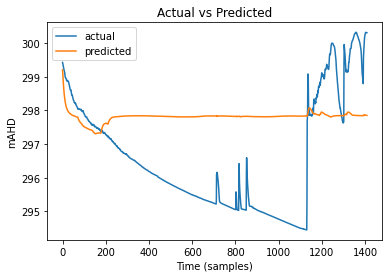

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_18_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m18_daily['SF_mAHD'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_18_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_18_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_18_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_18_post_2017 = Sequential()
model_streamflow_18_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_18_post_2017.add(Dense(n_steps_out))
model_streamflow_18_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_18_post_2017.summary()
Best_RMSE_streamflow_18_post_2017=1000   #Assigning a large number 

outputs_streamflow_18_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_18_post_2017
    #batch_size=64, 
    model_streamflow_18_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_18_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_18_post_2017.predict(x_test).flatten()
    train_acc_streamflow_18_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_18_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_18_post_2017[run]) 
    outputs_streamflow_18_post_2017[run,] = y_predicttest 
    if test_acc_streamflow_18_post_2017[run]<Best_RMSE_streamflow_18_post_2017:
        Best_RMSE_streamflow_18_post_2017=test_acc_streamflow_18_post_2017[run]
        Best_Predict_Test_streamflow_18_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_18_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 10)                520       
                                                                 
 dense_54 (Dense)            (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 1.5938808371551847
Experiment 2 in progress
RMSE value: 1.2007876715295247
Experiment 3 in progress
RMSE value: 1.0263744291146215
Experiment 4 in progress
RMSE value: 1.0158572133465684
Experiment 5 in progress
RMSE value: 1.6558585307723064
Experiment 6 in progress
RMSE value: 1.1763734036575835
Experiment 7 in progress
RMSE value: 1.1882488787200864
Experiment 8 in progress
RMSE value: 1.0782415650680484
Exp

In [ ]:
RMSE_outputs_streamflow_18_post_2017 = np.ones((Num_Exp))
RMSE_outputs_streamflow_18_recursive = np.ones((Num_Exp))
for i in range(Num_Exp):
  RMSE_outputs_streamflow_18_post_2017[i] = rmse( outputs_streamflow_18_post_2017[i], y_test)
  RMSE_outputs_streamflow_18_recursive[i] = rmse( outputs_streamflow_18_recursive[i], y_test)

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_18_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_18_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_18_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_18_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_18_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_18_recursive, 50, axis=0)
in_between_percentage_streamflow_18_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_18_recursive

0.23366477272727273

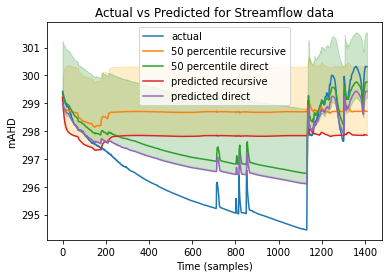

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_18_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_18_post_2017.png',dpi=300) 
plt.show()
plt.close()

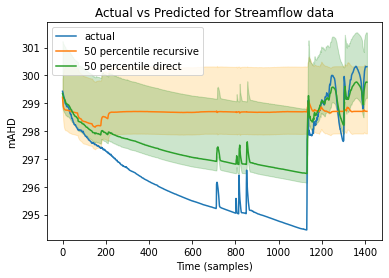

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_18_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

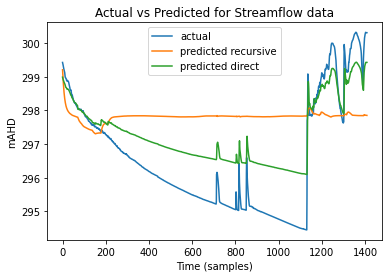

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_18_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_18_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_18_pre_2017 = m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_18_post_2017[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_18_recursive[:])
actual = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

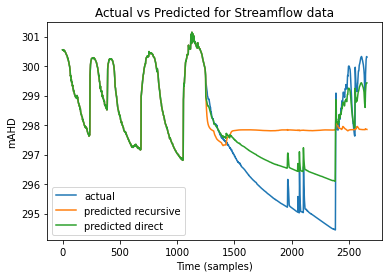

In [ ]:
x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_18.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_18_post_2017

1.0158572133465684

In [ ]:
Best_RMSE_streamflow_18_recursive

2.0558691715687534

In [ ]:
Best_NSE_streamflow_18_post_2017 = r2_score(Best_Predict_Test_streamflow_18_post_2017, y_test[:])
Best_NSE_streamflow_18_recursive = r2_score(Best_Predict_Test_streamflow_18_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_18_post_2017

-0.1451753262861537

In [ ]:
Best_NSE_streamflow_18_recursive

-185.85092101289624

In [ ]:
saved_map = {
    'outputs_streamflow_18_recursive':outputs_streamflow_18_recursive,
    'model_streamflow_18_recursive': model_streamflow_18_recursive,
    'train_acc_streamflow_18_recursive': train_acc_streamflow_18_recursive,
    'test_acc_streamflow_18_recursive': test_acc_streamflow_18_recursive,
    'Step_RMSE_streamflow_18_recursive': Step_RMSE_streamflow_18_recursive,
    'Best_predict_test_streamflow_18_recursive': Best_Predict_Test_streamflow_18_recursive,
    'Best_RMSE_streamflow_18_recursive': Best_RMSE_streamflow_18_recursive,
    'Best_NSE_streamflow_18_recursive':Best_NSE_streamflow_18_recursive,
    #'RMSE_outputs_streamflow_18_recursive':RMSE_outputs_streamflow_18_recursive,

    'outputs_streamflow_18_post_2017':outputs_streamflow_18_post_2017,
    'model_streamflow_18_post_2017': model_streamflow_18_post_2017,
    'train_acc_streamflow_18_post_2017': train_acc_streamflow_18_post_2017,
    'test_acc_streamflow_18_post_2017': test_acc_streamflow_18_post_2017,
    'Step_RMSE_streamflow_18_post_2017': Step_RMSE_streamflow_18_post_2017,
    'Best_predict_test_streamflow_18_post_2017': Best_Predict_Test_streamflow_18_post_2017,
    'Best_RMSE_streamflow_18_post_2017': Best_RMSE_streamflow_18_post_2017,
    'Best_NSE_streamflow_18_post_2017':Best_NSE_streamflow_18_post_2017,
    #'RMSE_outputs_streamflow_18_post_2017':RMSE_outputs_streamflow_18_post_2017,
    'in_between_percentage_streamflow_18_recursive': in_between_percentage_streamflow_18_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_streamflow_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
# pick_read = open('drive/My Drive/Thesis/Thesis/data_19_streamflow_post_2017.pickle','rb')
# data17 = pickle.load(pick_read)
# pick_read.close()


# model_streamflow_18_recursive = data17['model_streamflow_18_recursive'],
# train_acc_streamflow_18_recursive = data17['train_acc_streamflow_18_recursive'],
# test_acc_streamflow_18_recursive = data17['test_acc_streamflow_18_recursive'],
# Step_RMSE_streamflow_18_recursive = data17['Step_RMSE_streamflow_18_recursive'],
# Best_Predict_Test_streamflow_18_recursive = data17['Best_predict_test_streamflow_18_recursive'],
# Best_RMSE_streamflow_18_recursive = data17['Best_RMSE_streamflow_18_recursive'],
# Best_NSE_streamflow_18_recursive = data17['Best_NSE_streamflow_18_recursive'],
# outputs_streamflow_18_recursive = data17['outputs_streamflow_18_recursive'],

# in_between_percentage_streamflow_18_recursive = data17['in_between_percentage_streamflow_18_recursive']

# model_streamflow_18_post_2017 = data17['model_streamflow_18_post_2017'],
# train_acc_streamflow_18_post_2017 = data17['train_acc_streamflow_18_post_2017'],
# test_acc_streamflow_18_post_2017 = data17['test_acc_streamflow_18_post_2017'],
# Step_RMSE_streamflow_18_post_2017 = data17['Step_RMSE_streamflow_18_post_2017'],
# Best_Predict_Test_streamflow_18_post_2017 = data17['Best_predict_test_streamflow_18_post_2017'],
# Best_RMSE_streamflow_18_post_2017 = data17['Best_RMSE_streamflow_18_post_2017'],
# Best_NSE_streamflow_18_post_2017 = data17['Best_NSE_streamflow_18_post_2017'],
# outputs_streamflow_18_post_2017 = data17['outputs_streamflow_18_post_2017'],


### Discretised streamflow

In [ ]:

in_seq1 = array(m18_daily['discretised_flow'][:-1])
in_seq2 = array(m18_daily['mAHD_y'][:-1])
out_seq = array(m18_daily['mAHD_y'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised_18=np.zeros(Num_Exp)
test_acc_streamflow_discretised_18=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_18=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_18 = Sequential()
model_streamflow_discretised_18.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_18.add(Dense(n_steps_out))
model_streamflow_discretised_18.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_18.summary()
Best_RMSE_streamflow_discretised_18=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_18
    #batch_size=64, 
    model_streamflow_discretised_18.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_18.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_18.predict(x_test).flatten()
    train_acc_streamflow_discretised_18[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_18[run] = rmse( y_predicttest, y_test) 
    if test_acc_streamflow_discretised_18[run]<Best_RMSE_streamflow_discretised_18:
        Best_RMSE_streamflow_discretised_18=test_acc_streamflow_discretised_18[run]
        Best_Predict_Test_streamflow_discretised_18=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_18[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_18[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

#### Post 2017

In [ ]:
in_seq1 = array(m18_daily['discretised_flow'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised_18_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_discretised_18_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_18_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_18_post_2017 = Sequential()
model_streamflow_discretised_18_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_18_post_2017.add(Dense(n_steps_out))
model_streamflow_discretised_18_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_18_post_2017.summary()
Best_RMSE_streamflow_discretised_18_post_2017=1000   #Assigning a large number 

outputs_streamflow_discretised_18_post_2017 = np.ones((Num_Exp, y_test.shape[0]))
RMSE_outputs_streamflow_discretised_18_post_2017 = np.ones((Num_Exp))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_18_post_2017
    #batch_size=64, 
    model_streamflow_discretised_18_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_18_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_18_post_2017.predict(x_test).flatten()
    train_acc_streamflow_discretised_18_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_18_post_2017[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_discretised_18_post_2017[run]) 
    outputs_streamflow_discretised_18_post_2017[run,] = y_predicttest
    
    if test_acc_streamflow_discretised_18_post_2017[run]<Best_RMSE_streamflow_discretised_18_post_2017:
        Best_RMSE_streamflow_discretised_18_post_2017=test_acc_streamflow_discretised_18_post_2017[run]
        Best_Predict_Test_streamflow_discretised_18_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_18_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 10)                520       
                                                                 
 dense_55 (Dense)            (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 0.14746028043464962
Experiment 2 in progress
RMSE value: 0.14649956592175672
Experiment 3 in progress
RMSE value: 0.1454774318443546
Experiment 4 in progress
RMSE value: 0.14449992576842866
Experiment 5 in progress
RMSE value: 0.14349769532506365
Experiment 6 in progress
RMSE value: 0.14248961685184974
Experiment 7 in progress
RMSE value: 0.14152744570793782
Experiment 8 in progress
RMSE value: 0.14055120770351

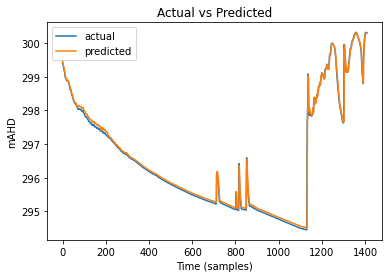

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_18_post_2017[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
saved_map = {
    'outputs_streamflow_discretised_18_post_2017':outputs_streamflow_discretised_18_post_2017,
    'model_streamflow_discretised_18_post_2017': model_streamflow_discretised_18_post_2017,
    'train_acc_streamflow_discretised_18_post_2017': train_acc_streamflow_discretised_18_post_2017,
    'test_acc_streamflow_discretised_18_post_2017': test_acc_streamflow_discretised_18_post_2017,
    'Step_RMSE_streamflow_discretised_18_post_2017': Step_RMSE_streamflow_discretised_18_post_2017,
    'Best_predict_test_streamflow_discretised_18_post_2017': Best_Predict_Test_streamflow_discretised_18_post_2017,
    'Best_RMSE_streamflow_discretised_18_post_2017': Best_RMSE_streamflow_discretised_18_post_2017,
    'Best_NSE_streamflow_discretised_18_post_2017':Best_NSE_streamflow_discretised_18_post_2017,
    'RMSE_outputs_streamflow_discretised_18_post_2017':RMSE_outputs_streamflow_discretised_18_post_2017,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_streamflow_discretised_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_18_streamflow_discretised_post_2017.pickle','rb')
data18 = pickle.load(pick_read)
pick_read.close()

outputs_streamflow_discretised_18_post_2017 = data18['outputs_streamflow_discretised_18_post_2017']
model_streamflow_discretised_18_post_2017 = data18['model_streamflow_discretised_18_post_2017'],
train_acc_streamflow_discretised_18_post_2017 = data18['train_acc_streamflow_discretised_18_post_2017'],
test_acc_streamflow_discretised_18_post_2017 = data18['test_acc_streamflow_discretised_18_post_2017'],
Step_RMSE_streamflow_discretised_18_post_2017 = data18['Step_RMSE_streamflow_discretised_18_post_2017'],
Best_Predict_Test_streamflow_discretised_18_post_2017 = data18['Best_predict_test_streamflow_discretised_18_post_2017'],
Best_RMSE_streamflow_discretised_18_post_2017 = data18['Best_RMSE_streamflow_discretised_18_post_2017'],
Best_NSE_streamflow_discretised_18_post_2017 = data18['Best_NSE_streamflow_discretised_18_post_2017']
#RMSE_outputs_streamflow_discretised_18_post_2017 = data18['RMSE_outputs_streamflow_discretised_18_post_2017']

In [ ]:
in_seq1 = array(m18_daily['discretised_flow'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_discretised_18_recursive=np.zeros(Num_Exp)
test_acc_streamflow_discretised_18_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_18_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_18_recursive = Sequential()
model_streamflow_discretised_18_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_18_recursive.add(Dense(n_steps_out))
model_streamflow_discretised_18_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_18_recursive.summary()
Best_RMSE_streamflow_discretised_18_recursive=1000   #Assigning a large number 


outputs_streamflow_discretised_18_recursive = np.ones((Num_Exp, y_test.shape[0]))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_18_recursive
    #batch_size=64, 
    model_streamflow_discretised_18_recursive.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_18_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_discretised_18_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_discretised_18_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_18_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_discretised_18_recursive[run]) 
    outputs_streamflow_discretised_18_recursive[run,] = y_predicttest
    if test_acc_streamflow_discretised_18_recursive[run]<Best_RMSE_streamflow_discretised_18_recursive:
        Best_RMSE_streamflow_discretised_18_recursive=test_acc_streamflow_discretised_18_recursive[run]
        Best_Predict_Test_streamflow_discretised_18_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_18_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                520       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 13.119479716296185
Experiment 2 in progress
RMSE value: 12.470711130655609
Experiment 3 in progress
RMSE value: 11.894815761757119
Experiment 4 in progress
RMSE value: 11.378263969029021
Experiment 5 in progress
RMSE value: 10.921977182213176
Experiment 6 in progress
RMSE value: 10.509334087023277
Experiment 7 in progress
RMSE value: 10.111916204579162
Experiment 8 in progress
RMSE value: 9.77746405150998
Exper

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_discretised_18_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_discretised_18_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_discretised_18_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_discretised_18_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_discretised_18_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_discretised_18_recursive, 50, axis=0)
in_between_percentage_streamflow_discretised_18_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_discretised_18_recursive

0.0

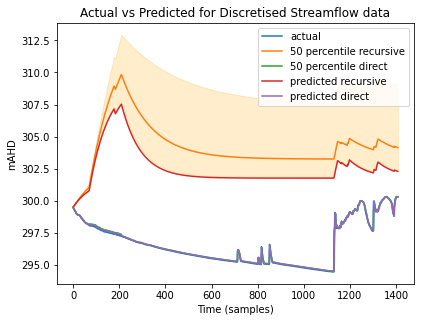

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_18_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_18_post_2017_1.png',dpi=300) 
plt.show()
plt.close()

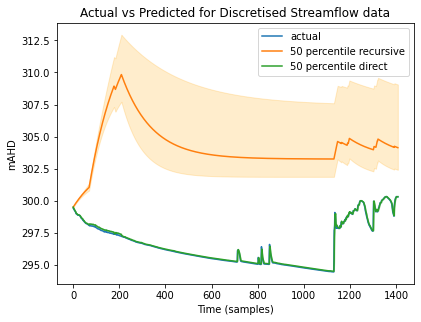

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_18_post_2017_50_only_1.png',dpi=300) 
plt.show()
plt.close()

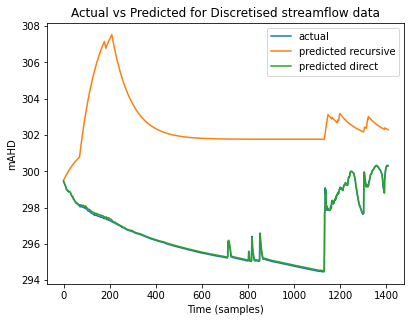

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_18_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_18_post_2017_best_only_1.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_18_pre_2017 = m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_18_post_2017[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_18_recursive[:])
actual = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

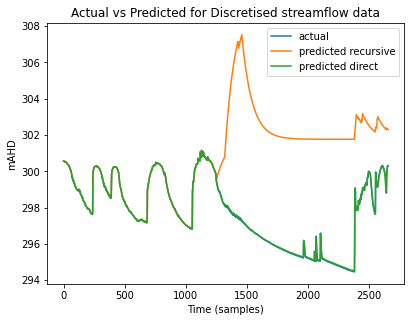

In [ ]:
x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_18_1.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_18_recursive

6.231609877960011

In [ ]:
Best_RMSE_streamflow_discretised_18_post_2017 

(0.12129029236702073,)

In [ ]:
Best_NSE_streamflow_discretised_18_post_2017 = r2_score(Best_Predict_Test_streamflow_discretised_18_post_2017, y_test[:])
Best_NSE_streamflow_discretised_18_recursive = r2_score(Best_Predict_Test_streamflow_discretised_18_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_discretised_18_post_2017

0.994686197509795

In [ ]:
Best_NSE_streamflow_discretised_18_recursive

-16.58282578964768

In [ ]:
saved_map = {
    'outputs_streamflow_discretised_18_recursive':outputs_streamflow_discretised_18_recursive,
    'model_streamflow_discretised_18_recursive': model_streamflow_discretised_18_recursive,
    'train_acc_streamflow_discretised_18_recursive': train_acc_streamflow_discretised_18_recursive,
    'test_acc_streamflow_discretised_18_recursive': test_acc_streamflow_discretised_18_recursive,
    'Step_RMSE_streamflow_discretised_18_recursive': Step_RMSE_streamflow_discretised_18_recursive,
    'Best_predict_test_streamflow_discretised_18_recursive': Best_Predict_Test_streamflow_discretised_18_recursive,
    'Best_RMSE_streamflow_discretised_18_recursive': Best_RMSE_streamflow_discretised_18_recursive,
    'Best_NSE_streamflow_discretised_18_recursive':Best_NSE_streamflow_discretised_18_recursive,

    'outputs_streamflow_discretised_18_post_2017':outputs_streamflow_discretised_18_post_2017,
    'model_streamflow_discretised_18_post_2017': model_streamflow_discretised_18_post_2017,
    'train_acc_streamflow_discretised_18_post_2017': train_acc_streamflow_discretised_18_post_2017,
    'test_acc_streamflow_discretised_18_post_2017': test_acc_streamflow_discretised_18_post_2017,
    'Step_RMSE_streamflow_discretised_18_post_2017': Step_RMSE_streamflow_discretised_18_post_2017,
    'Best_predict_test_streamflow_discretised_18_post_2017': Best_Predict_Test_streamflow_discretised_18_post_2017,
    'Best_RMSE_streamflow_discretised_18_post_2017': Best_RMSE_streamflow_discretised_18_post_2017,
    'Best_NSE_streamflow_discretised_18_post_2017':Best_NSE_streamflow_discretised_18_post_2017,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_streamflow_discretised_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Rainfall

In [ ]:

in_seq1 = array(m18_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m18_daily_rainfall['mAHD'][:-1])
out_seq = array(m18_daily_rainfall['mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_18=np.zeros(Num_Exp)
test_acc_18=np.zeros(Num_Exp)
Step_RMSE_18=np.zeros([Num_Exp,n_steps_out])

model_18 = Sequential()
model_18.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_18.add(Dense(n_steps_out))
model_18.compile(optimizer='adam', loss='mse')
model_18.summary()
Best_RMSE=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_18
    #batch_size=64, 
    model_18.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_18.predict(x_train).flatten()
    y_predicttest = model_18.predict(x_test).flatten()
    train_acc_18[run] = rmse( y_predicttrain,y_train) 
    test_acc_18[run] = rmse( y_predicttest, y_test) 
    if test_acc_18[run]<Best_RMSE_18:
        Best_RMSE_18=test_acc_18[run]
        Best_Predict_Test_18=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_18[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_18[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

#### Post 2017

In [ ]:

in_seq1 = array(m18_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m18_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m18_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_rainfall_18_post_2017=np.zeros(Num_Exp)
test_acc_rainfall_18_post_2017=np.zeros(Num_Exp)
Step_RMSE_rainfall_18_post_2017=np.zeros([Num_Exp,n_steps_out])

model_rainfall_18_post_2017 = Sequential()
model_rainfall_18_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_18_post_2017.add(Dense(n_steps_out))
model_rainfall_18_post_2017.compile(optimizer='adam', loss='mse')
model_rainfall_18_post_2017.summary()
Best_RMSE_rainfall_18_post_2017=1000   #Assigning a large number 


outputs_rainfall_18_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_18_post_2017
    #batch_size=64, 
    model_rainfall_18_post_2017.fit(x_train, y_train, epochs=Epochs,batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_18_post_2017.predict(x_train).flatten()
    y_predicttest = model_rainfall_18_post_2017.predict(x_test).flatten()
    train_acc_rainfall_18_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_18_post_2017[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_rainfall_18_post_2017[run]) 
    outputs_rainfall_18_post_2017[run,] = y_predicttest 
    if test_acc_rainfall_18_post_2017[run]<Best_RMSE_rainfall_18_post_2017:
        Best_RMSE_rainfall_18_post_2017=test_acc_rainfall_18_post_2017[run]
        Best_Predict_Test_rainfall_18_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_18_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                520       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 0.21379754256605926
Experiment 2 in progress
RMSE value: 0.21381070288292622
Experiment 3 in progress
RMSE value: 0.21378823122873417
Experiment 4 in progress
RMSE value: 0.21355051326923064
Experiment 5 in progress
RMSE value: 0.21334171321330744
Experiment 6 in progress
RMSE value: 0.2130177046932552
Experiment 7 in progress
RMSE value: 0.21262773055000753
Experiment 8 in progress
RMSE value: 0.2121256322291289


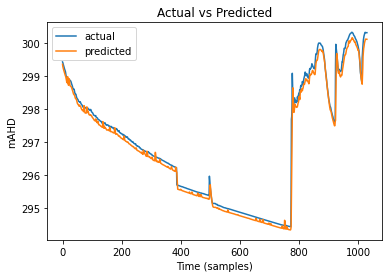

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_18_post_2017[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:

in_seq1 = array(m18_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m18_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m18_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

rainfall_recursive_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_rainfall_18_recursive=np.zeros(Num_Exp)
test_acc_rainfall_18_recursive=np.zeros(Num_Exp)
Step_RMSE_rainfall_18_recursive=np.zeros([Num_Exp,n_steps_out])

model_rainfall_18_recursive = Sequential()
model_rainfall_18_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_18_recursive.add(Dense(n_steps_out))
model_rainfall_18_recursive.compile(optimizer='adam', loss='mse')
model_rainfall_18_recursive.summary()
Best_RMSE_rainfall_18_recursive=1000   #Assigning a large number 

outputs_rainfall_18_recursive = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_18_recursive
    #batch_size=64, 
    model_rainfall_18_recursive.fit(x_train, y_train, epochs=Epochs, verbose=0,batch_size=16, shuffle=False)
    y_predicttrain = model_rainfall_18_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_rainfall_18_recursive, x_test_extra_samples[0][:,1], rainfall_recursive_post_2017,num_post_2017-3, 3)
    train_acc_rainfall_18_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_18_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_rainfall_18_recursive[run]) 
    outputs_rainfall_18_recursive[run,] = y_predicttest 
    if test_acc_rainfall_18_recursive[run]<Best_RMSE_rainfall_18_recursive:
        Best_RMSE_rainfall_18_recursive=test_acc_rainfall_18_recursive[run]
        Best_Predict_Test_rainfall_18_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_18_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)


NameError: ignored

In [ ]:
fx_high_post_2017 = np.percentile(outputs_rainfall_18_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_rainfall_18_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_rainfall_18_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_rainfall_18_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_rainfall_18_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_rainfall_18_recursive, 50, axis=0)
in_between_percentage_rainfall_18_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_rainfall_18_recursive

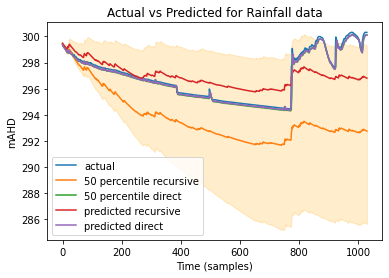

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_rainfall_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_18_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/rainfall_18_post_2017.png',dpi=300) 
plt.show()
plt.close()

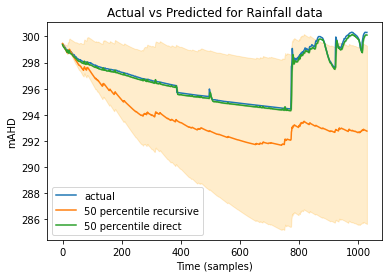

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_18_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

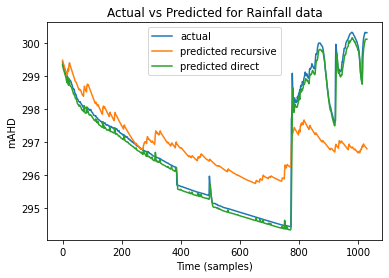

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_18_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_18_post_2017.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_18_pre_2017 = m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_18_post_2017[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_18_recursive[:])
actual = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

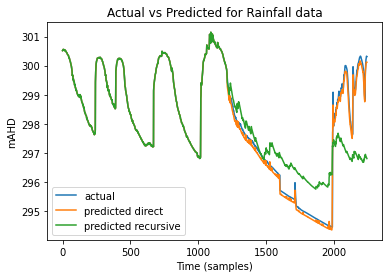

In [ ]:
x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_18.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_rainfall_18_recursive

1.4230272290665968

In [ ]:
Best_RMSE_rainfall_18_post_2017

0.1915571915401052

In [ ]:
Best_NSE_rainfall_18_post_2017 = r2_score(Best_Predict_Test_rainfall_18_post_2017, y_test[:])
Best_NSE_rainfall_18_recursive = r2_score(Best_Predict_Test_rainfall_18_recursive, y_test[:])

In [ ]:
Best_NSE_rainfall_18_post_2017

0.9883590204083531

In [ ]:
Best_NSE_rainfall_18_recursive

-1.7424946777884283

In [ ]:
saved_map = {
    'outputs_rainfall_18_recursive':outputs_rainfall_18_recursive,
    'model_rainfall_18_recursive': model_rainfall_18_recursive,
    'train_acc_rainfall_18_recursive': train_acc_rainfall_18_recursive,
    'test_acc_rainfall_18_recursive': test_acc_rainfall_18_recursive,
    'Step_RMSE_rainfall_18_recursive': Step_RMSE_rainfall_18_recursive,
    'Best_predict_test_rainfall_18_recursive': Best_Predict_Test_rainfall_18_recursive,
    'Best_RMSE_rainfall_18_recursive': Best_RMSE_rainfall_18_recursive,
    'Best_NSE_rainfall_18_recursive':Best_NSE_rainfall_18_recursive,

    'outputs_rainfall_18_post_2017':outputs_rainfall_18_post_2017,
    'model_rainfall_18_post_2017': model_rainfall_18_post_2017,
    'train_acc_rainfall_18_post_2017': train_acc_rainfall_18_post_2017,
    'test_acc_rainfall_18_post_2017': test_acc_rainfall_18_post_2017,
    'Step_RMSE_rainfall_18_post_2017': Step_RMSE_rainfall_18_post_2017,
    'Best_predict_test_rainfall_18_post_2017': Best_Predict_Test_rainfall_18_post_2017,
    'Best_RMSE_rainfall_18_post_2017': Best_RMSE_rainfall_18_post_2017,
    'Best_NSE_rainfall_18_post_2017':Best_NSE_rainfall_18_post_2017,
    'in_between_percentage_rainfall_18_recursive': in_between_percentage_rainfall_18_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_rainfall_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
# saved_map_recursive = {

#     'model_streamflow_18_recursive': model_streamflow_18_recursive,
#     'train_acc_streamflow_18_recursive': train_acc_streamflow_18_recursive,
#     'test_acc_streamflow_18_recursive': test_acc_streamflow_18_recursive,
#     'Step_RMSE_streamflow_18_recursive': Step_RMSE_streamflow_18_recursive,
#     'Best_predict_test_streamflow_18_recursive': Best_Predict_Test_streamflow_18_recursive,
#     'Best_RMSE_streamflow_18_recursive': Best_RMSE_streamflow_18_recursive,
#     'Best_NSE_streamflow_recursive':Best_NSE_streamflow_recursive,
#     'model_streamflow_18_post_2017': model_streamflow_18_post_2017,
#     'train_acc_streamflow_18_post_2017': train_acc_streamflow_18_post_2017,
#     'test_acc_streamflow_18_post_2017': test_acc_streamflow_18_post_2017,
#     'Step_RMSE_streamflow_18_post_2017': Step_RMSE_streamflow_18_post_2017,
#     'Best_predict_test_streamflow_18_post_2017': Best_Predict_Test_streamflow_18_post_2017,
#     'Best_RMSE_streamflow_18_post_2017': Best_RMSE_streamflow_18_post_2017,
#     'Best_NSE_streamflow_post_2017':Best_NSE_streamflow_post_2017,

#     'model_streamflow_discretised_18_recursive': model_streamflow_discretised_18_recursive,
#     'train_acc_streamflow_discretised_18_recursive': train_acc_streamflow_discretised_18_recursive,
#     'test_acc_streamflow_discretised_18_recursive': test_acc_streamflow_discretised_18_recursive,
#     'Step_RMSE_streamflow_discretised_18_recursive': Step_RMSE_streamflow_discretised_18_recursive,
#     'Best_predict_test_streamflow_discretised_18_recursive': Best_Predict_Test_streamflow_discretised_18_recursive,
#     'Best_RMSE_streamflow_discretised_18_recursive': Best_RMSE_streamflow_discretised_18_recursive,
#     'Best_NSE_streamflow_discretised_recursive':Best_NSE_streamflow_discretised_recursive,
#     'model_streamflow_discretised_18_post_2017': model_streamflow_discretised_18_post_2017,
#     'train_acc_streamflow_discretised_18_post_2017': train_acc_streamflow_discretised_18_post_2017,
#     'test_acc_streamflow_discretised_18_post_2017': test_acc_streamflow_discretised_18_post_2017,
#     'Step_RMSE_streamflow_discretised_18_post_2017': Step_RMSE_streamflow_discretised_18_post_2017,
#     'Best_predict_test_streamflow_discretised_18_post_2017': Best_Predict_Test_streamflow_discretised_18_post_2017,
#     'Best_RMSE_streamflow_discretised_18_post_2017': Best_RMSE_streamflow_discretised_18_post_2017,
#     'Best_NSE_streamflow_discretised_post_2017':Best_NSE_streamflow_discretised_post_2017,

#     'model_18_recursive': model_18_recursive,
#     'train_acc_18_recursive': train_acc_18_recursive,
#     'test_acc_18_recursive': test_acc_18_recursive,
#     'Step_RMSE_18_recursive': Step_RMSE_18_recursive,
#     'Best_predict_test_18_recursive': Best_Predict_Test_18_recursive,
#     'Best_RMSE_18_recursive': Best_RMSE_18_recursive,
#     'Best_NSE_rainfall_recursive':Best_NSE_rainfall_recursive,
#     'model_18_post_2017': model_18_post_2017,
#     'train_acc_18_post_2017': train_acc_18_post_2017,
#     'test_acc_18_post_2017': test_acc_18_post_2017,
#     'Step_RMSE_18_post_2017': Step_RMSE_18_post_2017,
#     'Best_predict_test_18_post_2017': Best_Predict_Test_18_post_2017,
#     'Best_RMSE_18_post_2017': Best_RMSE_18_post_2017,
#     'Best_NSE_rainfall_post_2017':Best_NSE_rainfall_post_2017,
# }

# # Save the python variable 'saved_map_recursive' to a Drive file named 'variables.pickle'.
# #
# # Because it's stored in Drive, this file will persist even if the VM times out.

# pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_post_2017.pickle','wb')
# pickle.dump(saved_map_recursive, pick_insert)
# pick_insert.close()

## CNN Model for borehole 18


### Univariate model

In [ ]:
in_seq1 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 50
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_univar_cnn_18_recursive=np.zeros(Num_Exp)
test_acc_univar_cnn_18_recursive=np.zeros(Num_Exp)
Step_RMSE_univar_cnn_18_recursive=np.zeros([Num_Exp,n_steps_out])


model_univar_cnn_18_recursive = Sequential()
model_univar_cnn_18_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_univar_cnn_18_recursive.add(MaxPooling1D(pool_size=2))
model_univar_cnn_18_recursive.add(Flatten())
model_univar_cnn_18_recursive.add(Dense(25, activation='relu'))
model_univar_cnn_18_recursive.add(Dense(1))
model_univar_cnn_18_recursive.compile(optimizer='adam', loss='mse')
model_univar_cnn_18_recursive.summary()
Best_RMSE_univar_cnn_18_recursive = 1000

outputs_univar_cnn_18_recursive = np.ones((Num_Exp, y_test.shape[0]))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_cnn_18_recursive
    #batch_size=64, 
    model_univar_cnn_18_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_cnn_18_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively_univariate(model_univar_cnn_18_recursive, x_test_extra_samples[0], num_post_2017-3, 3)
    train_acc_univar_cnn_18_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_cnn_18_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_univar_cnn_18_recursive[run]) 
    outputs_univar_cnn_18_recursive[run,] = y_predicttest
    if test_acc_univar_cnn_18_recursive[run]<Best_RMSE_univar_cnn_18_recursive:
        Best_RMSE_univar_cnn_18_recursive=test_acc_univar_cnn_18_recursive[run]
        Best_Predict_Test_univar_cnn_18_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_cnn_18_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                1625      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,843
Trainable params: 1,843
Non-trainable params: 0
____________________________________________________

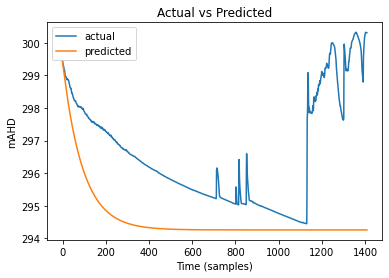

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_cnn_18_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

Num_Exp = 15
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_univar_cnn_18_post_2017=np.zeros(Num_Exp)
test_acc_univar_cnn_18_post_2017=np.zeros(Num_Exp)
Step_RMSE_univar_cnn_18_post_2017=np.zeros([Num_Exp,n_steps_out])

model_univar_cnn_18_post_2017 = Sequential()
model_univar_cnn_18_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_univar_cnn_18_post_2017.add(MaxPooling1D(pool_size=2))
model_univar_cnn_18_post_2017.add(Flatten())
model_univar_cnn_18_post_2017.add(Dense(25, activation='relu'))
model_univar_cnn_18_post_2017.add(Dense(1))
model_univar_cnn_18_post_2017.compile(optimizer='adam', loss='mse')
model_univar_cnn_18_post_2017.summary()
Best_RMSE_univar_cnn_18_post_2017 = 10000

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_cnn_18_post_2017
    #batch_size=64, 
    model_univar_cnn_18_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_cnn_18_post_2017.predict(x_train).flatten()
    y_predicttest = model_univar_cnn_18_post_2017.predict(x_test).flatten()
    train_acc_univar_cnn_18_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_cnn_18_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_univar_cnn_18_post_2017[run]) 
    if test_acc_univar_cnn_18_post_2017[run]<Best_RMSE_univar_cnn_18_post_2017:
        Best_RMSE_univar_cnn_18_post_2017=test_acc_univar_cnn_18_post_2017[run]
        Best_Predict_Test_univar_cnn_18_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_cnn_18_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 25)                1625      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,843
Trainable params: 1,843
Non-trainable params: 0
____________________________________________________

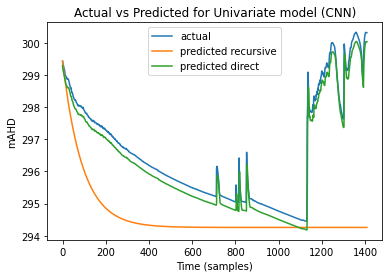

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_cnn_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_univar_cnn_18_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_cnn_18_post_2017.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_18_pre_2017 = m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_univar_cnn_18_recursive[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_univar_cnn_18_post_2017[:])
actual = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

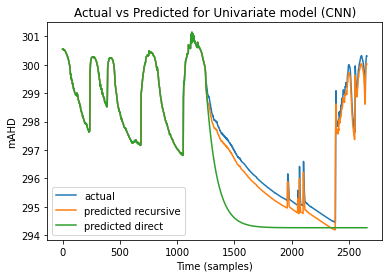

In [ ]:
x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_cnn_18.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_univar_cnn_18_post_2017

0.29752304616003433

In [ ]:
Best_RMSE_univar_cnn_18_recursive

2.5751031771833324

In [ ]:
Best_NSE_univar_cnn_18_post_2017 = r2_score(Best_Predict_Test_univar_cnn_18_post_2017, y_test[:])
Best_NSE_univar_cnn_18_recursive = r2_score(Best_Predict_Test_univar_cnn_18_recursive, y_test[:])

In [ ]:
Best_NSE_univar_cnn_18_post_2017

0.968601659634004

In [ ]:
Best_NSE_univar_cnn_18_recursive

-7.5873231385146

### Streamflow

In [ ]:
in_seq1 = array(m18_daily['mAHD_x'][:-1])
in_seq2 = array(m18_daily['mAHD_y'][:-1])
out_seq = array(m18_daily['mAHD_y'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000
 



In [ ]:


train_acc_streamflow_cnn_18=np.zeros(Num_Exp)
test_acc_streamflow_cnn_18=np.zeros(Num_Exp)
Step_RMSE_streamflow_cnn_18=np.zeros([Num_Exp,n_steps_out])

model_streamflow_cnn_18 = Sequential()
model_streamflow_cnn_18.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_cnn_18.add(MaxPooling1D(pool_size=2))
model_streamflow_cnn_18.add(Flatten())
model_streamflow_cnn_18.add(Dense(25, activation='relu'))
model_streamflow_cnn_18.add(Dense(1))
model_streamflow_cnn_18.compile(optimizer='adam', loss='mse')
model_streamflow_cnn_18.summary()

# fit model_streamflow_cnn_18
Best_RMSE_streamflow_cnn_18=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_cnn_18
    #batch_size=64, 
    model_streamflow_cnn_18.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_cnn_18.predict(x_train).flatten()
    y_predicttest = model_streamflow_cnn_18.predict(x_test).flatten()
    train_acc_streamflow_cnn_18[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_cnn_18[run] = rmse( y_predicttest, y_test) 
    if test_acc_streamflow_cnn_18[run]<Best_RMSE_streamflow_cnn_18:
        Best_RMSE_streamflow_cnn_18=test_acc_streamflow_cnn_18[run]
        Best_Predict_Test_streamflow_cnn_18=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_cnn_18[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)


In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_18[:], label='predicted cnn')
plt.plot(x_data, Best_Predict_Test_streamflow_18[:], label='predicted lstm')

plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_18

In [ ]:
Best_RMSE_streamflow_cnn_18

#### Post 2017

In [ ]:
in_seq1 = array(m18_daily['SF_mAHD'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_cnn_18_recursive=np.zeros(Num_Exp)
test_acc_streamflow_cnn_18_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_cnn_18_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_cnn_18_recursive = Sequential()
model_streamflow_cnn_18_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_cnn_18_recursive.add(MaxPooling1D(pool_size=2))
model_streamflow_cnn_18_recursive.add(Flatten())
model_streamflow_cnn_18_recursive.add(Dense(25, activation='relu'))
model_streamflow_cnn_18_recursive.add(Dense(1))
model_streamflow_cnn_18_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_cnn_18_recursive.summary()

Best_RMSE_streamflow_cnn_18_recursive=1000   #Assigning a large number 

outputs_streamflow_cnn_18_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_18_recursive
    #batch_size=64, 
    model_streamflow_cnn_18_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_cnn_18_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_cnn_18_recursive, x_test_extra_samples[0][:,1], streamflow_cnn_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_cnn_18_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_cnn_18_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_cnn_18_recursive[run]) 
    outputs_streamflow_cnn_18_recursive[run,] = y_predicttest
    if test_acc_streamflow_cnn_18_recursive[run]<Best_RMSE_streamflow_cnn_18_recursive:
        Best_RMSE_streamflow_cnn_18_recursive=test_acc_streamflow_cnn_18_recursive[run]
        Best_Predict_Test_streamflow_cnn_18_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_cnn_18_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
______________________________________________________

KeyboardInterrupt: ignored

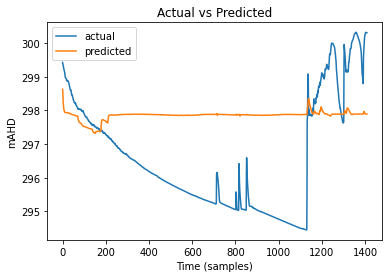

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_18_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m18_daily['SF_mAHD'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_cnn_18_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_cnn_18_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_cnn_18_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_cnn_18_post_2017 = Sequential()
model_streamflow_cnn_18_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_cnn_18_post_2017.add(MaxPooling1D(pool_size=2))
model_streamflow_cnn_18_post_2017.add(Flatten())
model_streamflow_cnn_18_post_2017.add(Dense(25, activation='relu'))
model_streamflow_cnn_18_post_2017.add(Dense(1))
model_streamflow_cnn_18_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_cnn_18_post_2017.summary()

Best_RMSE_streamflow_cnn_18_post_2017=1000   #Assigning a large number 
outputs_streamflow_cnn_18_post_2017 = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_17_post_2017
    #batch_size=64, 
    model_streamflow_cnn_18_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_cnn_18_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_cnn_18_post_2017.predict(x_test).flatten()
    train_acc_streamflow_cnn_18_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_cnn_18_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_cnn_18_post_2017[run])
    outputs_streamflow_cnn_18_post_2017[run,] = y_predicttest  
    if test_acc_streamflow_cnn_18_post_2017[run]<Best_RMSE_streamflow_cnn_18_post_2017:
        Best_RMSE_streamflow_cnn_18_post_2017=test_acc_streamflow_cnn_18_post_2017[run]
        Best_Predict_Test_streamflow_cnn_18_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_cnn_18_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

KeyboardInterrupt: ignored

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_cnn_18_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_cnn_18_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_cnn_18_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_cnn_18_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_cnn_18_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_cnn_18_recursive, 50, axis=0)
in_between_percentage_streamflow_cnn_18_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_cnn_18_recursive

0.1484375

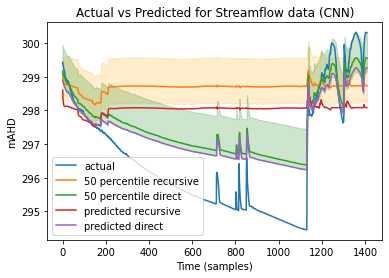

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_18_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_18_post_2017.png',dpi=300) 
plt.show()
plt.close()

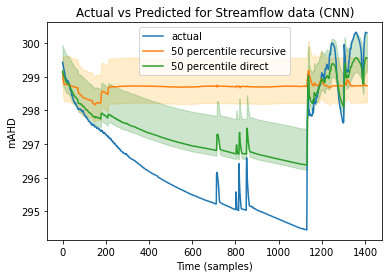

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_18_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

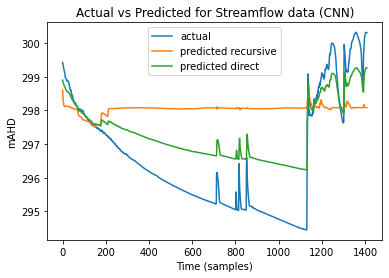

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_18_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_18_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_18_pre_2017 = m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_cnn_18_post_2017[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_cnn_18_recursive[:])
actual = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

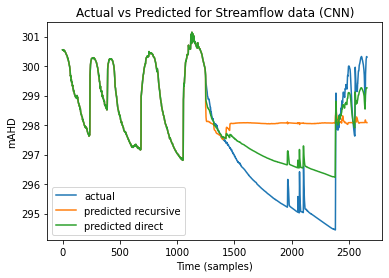

In [ ]:
x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_18.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_cnn_18_post_2017

1.1074732787349482

In [ ]:
Best_RMSE_streamflow_cnn_18_recursive

2.2057753938393665

In [ ]:
Best_NSE_streamflow_cnn_18_post_2017 = r2_score(Best_Predict_Test_streamflow_cnn_18_post_2017, y_test[:])
Best_NSE_streamflow_cnn_18_recursive = r2_score(Best_Predict_Test_streamflow_cnn_18_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_cnn_18_post_2017

-0.6359839277650106

In [ ]:
Best_NSE_streamflow_cnn_18_recursive

-294.6285730667002

In [ ]:
saved_map = {
    'outputs_streamflow_cnn_18_post_2017':outputs_streamflow_cnn_18_post_2017,
    'model_streamflow_cnn_18_post_2017': model_streamflow_cnn_18_post_2017,
    'train_acc_streamflow_cnn_18_post_2017': train_acc_streamflow_cnn_18_post_2017,
    'test_acc_streamflow_cnn_18_post_2017': test_acc_streamflow_cnn_18_post_2017,
    'Step_RMSE_streamflow_cnn_18_post_2017': Step_RMSE_streamflow_cnn_18_post_2017,
    'Best_predict_test_streamflow_cnn_18_post_2017': Best_Predict_Test_streamflow_cnn_18_post_2017,
    'Best_RMSE_streamflow_cnn_18_post_2017': Best_RMSE_streamflow_cnn_18_post_2017,
    'Best_NSE_streamflow_cnn_18_post_2017':Best_NSE_streamflow_cnn_18_post_2017,
    
    'outputs_streamflow_cnn_18_recursive':outputs_streamflow_cnn_18_recursive,
    'model_streamflow_cnn_18_recursive': model_streamflow_cnn_18_recursive,
    'train_acc_streamflow_cnn_18_recursive': train_acc_streamflow_cnn_18_recursive,
    'test_acc_streamflow_cnn_18_recursive': test_acc_streamflow_cnn_18_recursive,
    'Step_RMSE_streamflow_cnn_18_recursive': Step_RMSE_streamflow_cnn_18_recursive,
    'Best_predict_test_streamflow_cnn_18_recursive': Best_Predict_Test_streamflow_cnn_18_recursive,
    'Best_RMSE_streamflow_cnn_18_recursive': Best_RMSE_streamflow_cnn_18_recursive,
    'Best_NSE_streamflow_cnn_18_recursive':Best_NSE_streamflow_cnn_18_recursive,
    'in_between_percentage_streamflow_cnn_18_recursive':in_between_percentage_streamflow_cnn_18_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_streamflow_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Discretised streamflow

In [ ]:
in_seq1 = array(m18_daily['discretised_flow'][:-1])
in_seq2 = array(m18_daily['mAHD_y'][:-1])
out_seq = array(m18_daily['mAHD_y'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000


KeyError: ignored

In [ ]:

train_acc_streamflow_discretised_cnn_18=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_18=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_18=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_18 = Sequential()
model_streamflow_discretised_cnn_18.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_18.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_18.add(Flatten())
model_streamflow_discretised_cnn_18.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_18.add(Dense(1))
model_streamflow_discretised_cnn_18.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_18.summary()
Best_RMSE_streamflow_discretised_cnn_18=1000   #Assigning a large number 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_cnn_18
    #batch_size=64, 
    model_streamflow_discretised_cnn_18.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_cnn_18.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_cnn_18.predict(x_test).flatten()
    train_acc_streamflow_discretised_cnn_18[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_cnn_18[run] = rmse( y_predicttest, y_test) 
    if test_acc_streamflow_discretised_cnn_18[run]<Best_RMSE_streamflow_discretised_cnn_18:
        Best_RMSE_streamflow_discretised_cnn_18=test_acc_streamflow_discretised_cnn_18[run]
        Best_Predict_Test_streamflow_discretised_cnn_18=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_18[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

NameError: ignored

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_18[:], label='predicted cnn')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_18[:], label='predicted lstm')

plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_18

In [ ]:
Best_RMSE_streamflow_discretised_cnn_18

#### Post 2017


In [ ]:
in_seq1 = array(m18_daily['discretised_flow'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 50
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_discretised_cnn_18_recursive=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_18_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_18_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_18_recursive = Sequential()
model_streamflow_discretised_cnn_18_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_18_recursive.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_18_recursive.add(Flatten())
model_streamflow_discretised_cnn_18_recursive.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_18_recursive.add(Dense(1))
model_streamflow_discretised_cnn_18_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_18_recursive.summary()

Best_RMSE_streamflow_discretised_cnn_18_recursive=1000   #Assigning a large number 

outputs_streamflow_discretised_cnn_18_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_18_recursive
    #batch_size=64, 
    model_streamflow_discretised_cnn_18_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_cnn_18_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_discretised_cnn_18_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_cnn_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_discretised_cnn_18_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_cnn_18_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_discretised_cnn_18_recursive[run]) 
    outputs_streamflow_discretised_cnn_18_recursive[run,] = y_predicttest 

    if test_acc_streamflow_discretised_cnn_18_recursive[run]<Best_RMSE_streamflow_discretised_cnn_18_recursive:
        Best_RMSE_streamflow_discretised_cnn_18_recursive=test_acc_streamflow_discretised_cnn_18_recursive[run]
        Best_Predict_Test_streamflow_discretised_cnn_18_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_18_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 2, 64)             320       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 25)                1625      
                                                                 
 dense_21 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
___________________________________________________

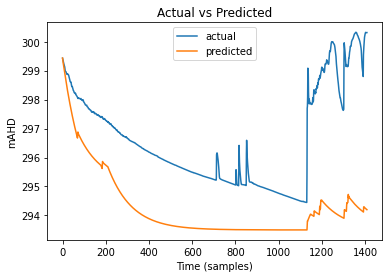

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_18_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m18_daily['discretised_flow'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised_cnn_18_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_18_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_18_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_18_post_2017 = Sequential()
model_streamflow_discretised_cnn_18_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_18_post_2017.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_18_post_2017.add(Flatten())
model_streamflow_discretised_cnn_18_post_2017.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_18_post_2017.add(Dense(1))
model_streamflow_discretised_cnn_18_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_18_post_2017.summary()

Best_RMSE_streamflow_discretised_cnn_18_post_2017=1000   #Assigning a large number 

outputs_streamflow_discretised_cnn_18_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_17_post_2017
    #batch_size=64, 
    model_streamflow_discretised_cnn_18_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16,verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_cnn_18_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_cnn_18_post_2017.predict(x_test).flatten()
    train_acc_streamflow_discretised_cnn_18_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_cnn_18_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_discretised_cnn_18_post_2017[run])  
    outputs_streamflow_discretised_cnn_18_post_2017[run,] = y_predicttest 
    if test_acc_streamflow_discretised_cnn_18_post_2017[run]<Best_RMSE_streamflow_discretised_cnn_18_post_2017:
        Best_RMSE_streamflow_discretised_cnn_18_post_2017=test_acc_streamflow_discretised_cnn_18_post_2017[run]
        Best_Predict_Test_streamflow_discretised_cnn_18_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_18_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

In [ ]:
outputs_streamflow_discretised_cnn_18_recursive_1 = outputs_streamflow_discretised_cnn_18_recursive[25:]

In [ ]:
outputs_streamflow_discretised_cnn_18_post_2017 = outputs_streamflow_discretised_cnn_18_post_2017[0]

In [ ]:
Best_Predict_Test_streamflow_discretised_cnn_18_post_2017 = Best_Predict_Test_streamflow_discretised_cnn_18_post_2017[0]

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_18_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_18_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_18_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_discretised_cnn_18_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_discretised_cnn_18_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_discretised_cnn_18_recursive, 50, axis=0)
in_between_percentage_streamflow_discretised_cnn_18_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_discretised_cnn_18_recursive

0.0007102272727272727

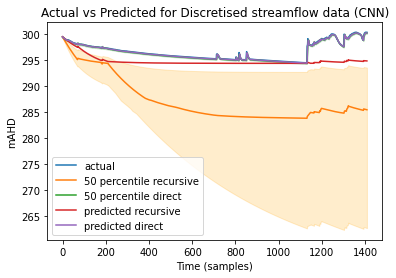

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_18_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_18_post_2017.png',dpi=300) 
plt.show()
plt.close()

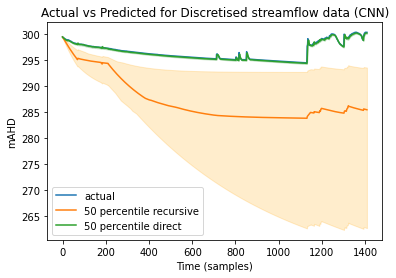

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_18_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

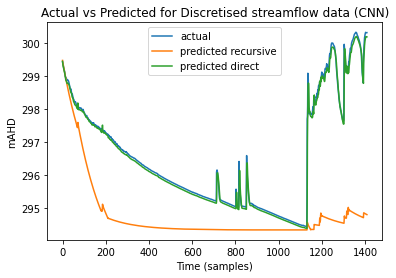

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_18_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_18_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_18_pre_2017 = m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_18_post_2017[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_18_recursive[:])
actual = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

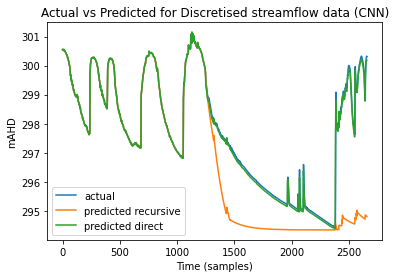

In [ ]:
x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_18.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_cnn_18_post_2017

(0.14739216748432427,)

In [ ]:
Best_RMSE_streamflow_discretised_cnn_18_recursive

2.361850324363757

In [ ]:
Best_NSE_streamflow_discretised_cnn_18_post_2017 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_18_post_2017, y_test[:])
Best_NSE_streamflow_discretised_cnn_18_recursive = r2_score(Best_Predict_Test_streamflow_discretised_cnn_18_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_discretised_cnn_18_post_2017

0.9922155524059526

In [ ]:
Best_NSE_streamflow_discretised_cnn_18_recursive

-4.915743919604311

In [ ]:
saved_map = {
    'outputs_streamflow_discretised_cnn_18_recursive':outputs_streamflow_discretised_cnn_18_recursive,
    'model_streamflow_discretised_cnn_18_recursive': model_streamflow_discretised_cnn_18_recursive,
    'train_acc_streamflow_discretised_cnn_18_recursive': train_acc_streamflow_discretised_cnn_18_recursive,
    'test_acc_streamflow_discretised_cnn_18_recursive': test_acc_streamflow_discretised_cnn_18_recursive,
    'Step_RMSE_streamflow_discretised_cnn_18_recursive': Step_RMSE_streamflow_discretised_cnn_18_recursive,
    'Best_predict_test_streamflow_discretised_cnn_18_recursive': Best_Predict_Test_streamflow_discretised_cnn_18_recursive,
    'Best_RMSE_streamflow_discretised_cnn_18_recursive': Best_RMSE_streamflow_discretised_cnn_18_recursive,
    'Best_NSE_streamflow_discretised_cnn_18_recursive':Best_NSE_streamflow_discretised_cnn_18_recursive,

    'outputs_streamflow_discretised_cnn_18_post_2017':outputs_streamflow_discretised_cnn_18_post_2017,
    'model_streamflow_discretised_cnn_18_post_2017': model_streamflow_discretised_cnn_18_post_2017,
    'train_acc_streamflow_discretised_cnn_18_post_2017': train_acc_streamflow_discretised_cnn_18_post_2017,
    'test_acc_streamflow_discretised_cnn_18_post_2017': test_acc_streamflow_discretised_cnn_18_post_2017,
    'Step_RMSE_streamflow_discretised_cnn_18_post_2017': Step_RMSE_streamflow_discretised_cnn_18_post_2017,
    'Best_predict_test_streamflow_discretised_cnn_18_post_2017': Best_Predict_Test_streamflow_discretised_cnn_18_post_2017,
    'Best_RMSE_streamflow_discretised_cnn_18_post_2017': Best_RMSE_streamflow_discretised_cnn_18_post_2017,
    'Best_NSE_streamflow_discretised_cnn_18_post_2017':Best_NSE_streamflow_discretised_cnn_18_post_2017,
    'in_between_percentage_streamflow_discretised_cnn_18_recursive': in_between_percentage_streamflow_discretised_cnn_18_recursive,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_streamflow_discretised_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Rainfall

In [ ]:

in_seq1 = array(m18_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m18_daily_rainfall['mAHD'][:-1])
out_seq = array(m18_daily_rainfall['mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

x_train = X[0:int(len(X)*4/5)]
x_test = X[int(len(X)*4/5):]
y_train = y[0:int(len(y)*4/5)]
y_test = y[int(len(y)*4/5):]
n_features = X.shape[2]
Num_Exp = 10
n_steps_out = 1
Hidden=10
Epochs=1000



In [ ]:


train_acc_rainfall_cnn=np.zeros(Num_Exp)
test_acc_rainfall_cnn=np.zeros(Num_Exp)
Step_RMSE_rainfall_cnn=np.zeros([Num_Exp,n_steps_out])

model_rainfall_cnn = Sequential()
model_rainfall_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_cnn.add(MaxPooling1D(pool_size=2))
model_rainfall_cnn.add(Flatten())
model_rainfall_cnn.add(Dense(25, activation='relu'))
model_rainfall_cnn.add(Dense(1))
model_rainfall_cnn.compile(optimizer='adam', loss='mse')
model_rainfall_cnn.summary()
Best_RMSE_rainfall_cnn=1000 

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model
    #batch_size=64, 
    model_rainfall_cnn.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_cnn.predict(x_train).flatten()
    y_predicttest = model_rainfall_cnn.predict(x_test).flatten()
    train_acc_rainfall_cnn[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_cnn[run] = rmse( y_predicttest, y_test) 
    if test_acc_rainfall_cnn[run]<Best_RMSE_rainfall_cnn:
        Best_RMSE_rainfall_cnn=test_acc_rainfall_cnn[run]
        Best_Predict_Test_rainfall_cnn=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_cnn[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_18[:], label='predicted cnn')
plt.plot(x_data, Best_Predict_Test_18[:], label='predicted lstm')

plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_18

In [ ]:
Best_RMSE_rainfall_cnn_18

#### Post 2017

In [ ]:
in_seq1 = array(m18_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m18_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m18_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_rainfall_cnn_18_recursive=np.zeros(Num_Exp)
test_acc_rainfall_cnn_18_recursive=np.zeros(Num_Exp)
Step_RMSE_rainfall_cnn_18_recursive=np.zeros([Num_Exp,n_steps_out])

model_rainfall_cnn_18_recursive = Sequential()
model_rainfall_cnn_18_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_cnn_18_recursive.add(MaxPooling1D(pool_size=2))
model_rainfall_cnn_18_recursive.add(Flatten())
model_rainfall_cnn_18_recursive.add(Dense(25, activation='relu'))
model_rainfall_cnn_18_recursive.add(Dense(1))
model_rainfall_cnn_18_recursive.compile(optimizer='adam', loss='mse')
model_rainfall_cnn_18_recursive.summary()

Best_RMSE_rainfall_cnn_18_recursive=1000   #Assigning a large number 
outputs_rainfall_cnn_18_recursive = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_18_recursive
    #batch_size=64, 
    model_rainfall_cnn_18_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_cnn_18_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_rainfall_cnn_18_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_cnn_post_2017,num_post_2017-3, 3)
    train_acc_rainfall_cnn_18_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_cnn_18_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_rainfall_cnn_18_recursive[run]) 
    outputs_rainfall_cnn_18_recursive[run,] = y_predicttest
    if test_acc_rainfall_cnn_18_recursive[run]<Best_RMSE_rainfall_cnn_18_recursive:
        Best_RMSE_rainfall_cnn_18_recursive=test_acc_rainfall_cnn_18_recursive[run]
        Best_Predict_Test_rainfall_cnn_18_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_cnn_18_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                1625      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

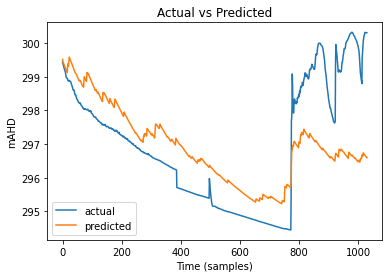

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_18_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m18_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m18_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m18_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_rainfall_cnn_18_post_2017=np.zeros(Num_Exp)
test_acc_rainfall_cnn_18_post_2017=np.zeros(Num_Exp)
Step_RMSE_rainfall_cnn_18_post_2017=np.zeros([Num_Exp,n_steps_out])

model_rainfall_cnn_18_post_2017 = Sequential()
model_rainfall_cnn_18_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_cnn_18_post_2017.add(MaxPooling1D(pool_size=2))
model_rainfall_cnn_18_post_2017.add(Flatten())
model_rainfall_cnn_18_post_2017.add(Dense(25, activation='relu'))
model_rainfall_cnn_18_post_2017.add(Dense(1))
model_rainfall_cnn_18_post_2017.compile(optimizer='adam', loss='mse')
model_rainfall_cnn_18_post_2017.summary()

Best_RMSE_rainfall_cnn_18_post_2017=1000   #Assigning a large number 

outputs_rainfall_cnn_18_post_2017 = np.ones((Num_Exp, y_test.shape[0]))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_17_post_2017
    #batch_size=64, 
    model_rainfall_cnn_18_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_cnn_18_post_2017.predict(x_train).flatten()
    y_predicttest = model_rainfall_cnn_18_post_2017.predict(x_test).flatten()
    train_acc_rainfall_cnn_18_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_cnn_18_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_rainfall_cnn_18_post_2017[run])  
    outputs_rainfall_cnn_18_post_2017[run,] = y_predicttest
    if test_acc_rainfall_cnn_18_post_2017[run]<Best_RMSE_rainfall_cnn_18_post_2017:
        Best_RMSE_rainfall_cnn_18_post_2017=test_acc_rainfall_cnn_18_post_2017[run]
        Best_Predict_Test_rainfall_cnn_18_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_cnn_18_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 25)                1625      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

In [ ]:
fx_high_post_2017 = np.percentile(outputs_rainfall_cnn_18_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_rainfall_cnn_18_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_rainfall_cnn_18_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_rainfall_cnn_18_recursive[8:25], 95, axis=0)
fx_low_recursive = np.percentile(outputs_rainfall_cnn_18_recursive[8:25], 5, axis=0)
fx_mid_recursive = np.percentile(outputs_rainfall_cnn_18_recursive[8:25], 50, axis=0)
in_between_percentage_rainfall_cnn_18_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_rainfall_cnn_18_recursive

0.7220602526724975

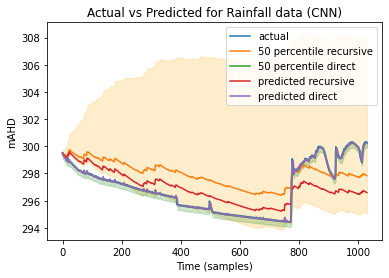

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_18_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_18_post_2017.png',dpi=300) 
plt.show()
plt.close()

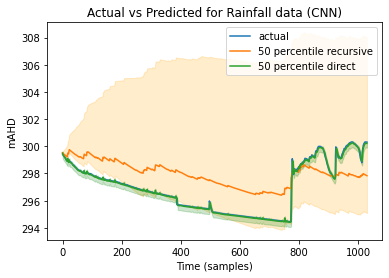

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_18_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

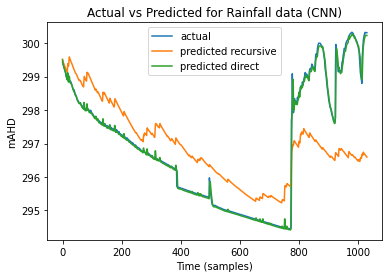

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_18_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_18_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_18_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_18_pre_2017 = m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily_rainfall[m18_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_cnn_18_post_2017[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_cnn_18_recursive[:])
actual = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

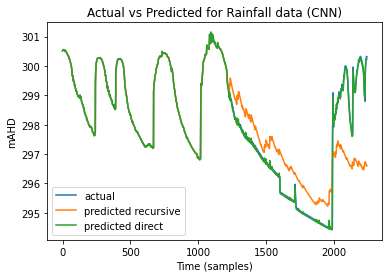

In [ ]:
x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_18.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_rainfall_cnn_18_post_2017

0.13486403529260904

In [ ]:
Best_RMSE_rainfall_cnn_18_recursive

1.4748050883544594

In [ ]:
Best_NSE_rainfall_cnn_18_post_2017 = r2_score(Best_Predict_Test_rainfall_cnn_18_post_2017, y_test[:])
Best_NSE_rainfall_cnn_18_recursive = r2_score(Best_Predict_Test_rainfall_cnn_18_recursive, y_test[:])

In [ ]:
Best_NSE_rainfall_cnn_18_post_2017

0.9943764272364172

In [ ]:
Best_NSE_rainfall_cnn_18_recursive

-0.7783416059147816

In [ ]:
saved_map = {
    'outputs_rainfall_cnn_18_post_2017':outputs_rainfall_cnn_18_post_2017,
    'model_rainfall_cnn_18_post_2017': model_rainfall_cnn_18_post_2017,
    'train_acc_rainfall_cnn_18_post_2017': train_acc_rainfall_cnn_18_post_2017,
    'test_acc_rainfall_cnn_18_post_2017': test_acc_rainfall_cnn_18_post_2017,
    'Step_RMSE_rainfall_cnn_18_post_2017': Step_RMSE_rainfall_cnn_18_post_2017,
    'Best_predict_test_rainfall_cnn_18_post_2017': Best_Predict_Test_rainfall_cnn_18_post_2017,
    'Best_RMSE_rainfall_cnn_18_post_2017': Best_RMSE_rainfall_cnn_18_post_2017,
    'Best_NSE_rainfall_cnn_18_post_2017':Best_NSE_rainfall_cnn_18_post_2017,
    
    'outputs_rainfall_cnn_18_recursive':outputs_rainfall_cnn_18_recursive,
    'model_rainfall_cnn_18_recursive': model_rainfall_cnn_18_recursive,
    'train_acc_rainfall_cnn_18_recursive': train_acc_rainfall_cnn_18_recursive,
    'test_acc_rainfall_cnn_18_recursive': test_acc_rainfall_cnn_18_recursive,
    'Step_RMSE_rainfall_cnn_18_recursive': Step_RMSE_rainfall_cnn_18_recursive,
    'Best_predict_test_rainfall_cnn_18_recursive': Best_Predict_Test_rainfall_cnn_18_recursive,
    'Best_RMSE_rainfall_cnn_18_recursive': Best_RMSE_rainfall_cnn_18_recursive,
    'Best_NSE_rainfall_cnn_18_recursive':Best_NSE_rainfall_cnn_18_recursive,
    
    'in_between_percentage_rainfall_cnn_18_recursive': in_between_percentage_cnn_18_recursive
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_rainfall_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

## Saving models

In [ ]:
saved_map_recursive = {

    'model_streamflow_cnn_18_recursive': model_streamflow_cnn_18_recursive,
    'train_acc_streamflow_cnn_18_recursive': train_acc_streamflow_cnn_18_recursive,
    'test_acc_streamflow_cnn_18_recursive': test_acc_streamflow_cnn_18_recursive,
    'Step_RMSE_streamflow_cnn_18_recursive': Step_RMSE_streamflow_cnn_18_recursive,
    'Best_predict_test_streamflow_cnn_18_recursive': Best_Predict_Test_streamflow_cnn_18_recursive,
    'Best_RMSE_streamflow_cnn_18_recursive': Best_RMSE_streamflow_cnn_18_recursive,
    'Best_NSE_streamflow_cnn_18_recursive':Best_NSE_streamflow_cnn_18_recursive,
    'model_streamflow_cnn_18_post_2017': model_streamflow_cnn_18_post_2017,
    'train_acc_streamflow_cnn_18_post_2017': train_acc_streamflow_cnn_18_post_2017,
    'test_acc_streamflow_cnn_18_post_2017': test_acc_streamflow_cnn_18_post_2017,
    'Step_RMSE_streamflow_cnn_18_post_2017': Step_RMSE_streamflow_cnn_18_post_2017,
    'Best_predict_test_streamflow_cnn_18_post_2017': Best_Predict_Test_streamflow_cnn_18_post_2017,
    'Best_RMSE_streamflow_cnn_18_post_2017': Best_RMSE_streamflow_cnn_18_post_2017,
    'Best_NSE_streamflow_cnn_18_post_2017':Best_NSE_streamflow_cnn_18_post_2017,

    'model_streamflow_discretised_cnn_18_recursive': model_streamflow_discretised_cnn_18_recursive,
    'train_acc_streamflow_discretised_cnn_18_recursive': train_acc_streamflow_discretised_cnn_18_recursive,
    'test_acc_streamflow_discretised_cnn_18_recursive': test_acc_streamflow_discretised_cnn_18_recursive,
    'Step_RMSE_streamflow_discretised_cnn_18_recursive': Step_RMSE_streamflow_discretised_cnn_18_recursive,
    'Best_predict_test_streamflow_discretised_cnn_18_recursive': Best_Predict_Test_streamflow_discretised_cnn_18_recursive,
    'Best_RMSE_streamflow_discretised_cnn_18_recursive': Best_RMSE_streamflow_discretised_cnn_18_recursive,
    'Best_NSE_streamflow_discretised_cnn_18_recursive':Best_NSE_streamflow_discretised_cnn_18_recursive,
    'model_streamflow_discretised_cnn_18_post_2017': model_streamflow_discretised_cnn_18_post_2017,
    'train_acc_streamflow_discretised_cnn_18_post_2017': train_acc_streamflow_discretised_cnn_18_post_2017,
    'test_acc_streamflow_discretised_cnn_18_post_2017': test_acc_streamflow_discretised_cnn_18_post_2017,
    'Step_RMSE_streamflow_discretised_cnn_18_post_2017': Step_RMSE_streamflow_discretised_cnn_18_post_2017,
    'Best_predict_test_streamflow_discretised_cnn_18_post_2017': Best_Predict_Test_streamflow_discretised_cnn_18_post_2017,
    'Best_RMSE_streamflow_discretised_cnn_18_post_2017': Best_RMSE_streamflow_discretised_cnn_18_post_2017,
    'Best_NSE_streamflow_discretised_cnn_18_post_2017':Best_NSE_streamflow_discretised_cnn_18_post_2017,

    'model_rainfall_cnn_18_recursive': model_rainfall_cnn_18_recursive,
    'train_acc_rainfall_cnn_18_recursive': train_acc_rainfall_cnn_18_recursive,
    'test_acc_rainfall_cnn_18_recursive': test_acc_rainfall_cnn_18_recursive,
    'Step_RMSE_rainfall_cnn_18_recursive': Step_RMSE_rainfall_cnn_18_recursive,
    'Best_predict_test_rainfall_cnn_18_recursive': Best_Predict_Test_rainfall_cnn_18_recursive,
    'Best_RMSE_rainfall_cnn_18_recursive': Best_RMSE_rainfall_cnn_18_recursive,
    'Best_NSE_rainfall_cnn_18_recursive':Best_NSE_rainfall_cnn_18_recursive,
    'model_rainfall_cnn_18_post_2017': model_rainfall_cnn_18_post_2017,
    'train_acc_rainfall_cnn_18_post_2017': train_acc_rainfall_cnn_18_post_2017,
    'test_acc_rainfall_cnn_18_post_2017': test_acc_rainfall_cnn_18_post_2017,
    'Step_RMSE_rainfall_cnn_18_post_2017': Step_RMSE_rainfall_cnn_18_post_2017,
    'Best_predict_test_rainfall_cnn_18_post_2017': Best_Predict_Test_rainfall_cnn_18_post_2017,
    'Best_RMSE_rainfall_cnn_18_post_2017': Best_RMSE_rainfall_cnn_18_post_2017,
    'Best_NSE_rainfall_cnn_18_post_2017':Best_NSE_rainfall_cnn_18_post_2017,
}

# Save the python variable 'saved_map_recursive' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data_18_cnn_post_2017.pickle','wb')
pickle.dump(saved_map_recursive, pick_insert)
pick_insert.close()

In [ ]:
saved_map_18 = {
    'model_rainfall_18': model_18,
    'train_acc_rainfall_18': train_acc_18,
    'test_acc_rainfall_18': test_acc_18,
    'Step_RMSE_rainfall_18': Step_RMSE_18,
    'Best_predict_test_rainfall_18': Best_Predict_Test_18,
    'Best_RMSE_18': Best_RMSE_18,
    'model_streamflow_18': model_streamflow_18,
    'train_acc_streamflow_18': train_acc_streamflow_18,
    'test_acc_streamflow_18': test_acc_streamflow_18,
    'Step_RMSE_streamflow_18': Step_RMSE_streamflow_18,
    'Best_predict_test_streamflow_18': Best_Predict_Test_streamflow_18,
    'Best_RMSE_streamflow_18': Best_RMSE_streamflow_18,
    'model_streamflow_discretised_18': model_streamflow_discretised_18,
    'train_acc_streamflow_discretised_18': train_acc_streamflow_discretised_18,
    'test_acc_streamflow_discretised_18': test_acc_streamflow_discretised_18,
    'Step_RMSE_streamflow_discretised_18': Step_RMSE_streamflow_discretised_18,
    'Best_predict_test_streamflow_discretised_18': Best_Predict_Test_streamflow_discretised_18,
    'Best_RMSE_streamflow_discretised_18': Best_RMSE_streamflow_discretised_18,
    'model_rainfall_18': model_rainfall_cnn_18,
    'train_acc_rainfall_18': train_acc_rainfall_cnn_18,
    'test_acc_rainfall_18': test_acc_rainfall_cnn_18,
    'Step_RMSE_rainfall_18': Step_RMSE_rainfall_cnn_18,
    'Best_predict_test_rainfall_18': Best_Predict_Test_rainfall_cnn_18,
    'Best_RMSE_18': Best_RMSE_rainfall_cnn_18,
    'model_streamflow_cnn_18': model_streamflow_cnn_18,
    'train_acc_streamflow_cnn_18': train_acc_streamflow_cnn_18,
    'test_acc_streamflow_cnn_18': test_acc_streamflow_cnn_18,
    'Step_RMSE_streamflow_cnn_18': Step_RMSE_streamflow_cnn_18,
    'Best_predict_test_streamflow_cnn_18': Best_Predict_Test_streamflow_cnn_18,
    'Best_RMSE_streamflow_cnn_18': Best_RMSE_streamflow_cnn_18,
    'model_streamflow_discretised_cnn_18': model_streamflow_discretised_cnn_18,
    'train_acc_streamflow_discretised_cnn_18': train_acc_streamflow_discretised_cnn_18,
    'test_acc_streamflow_discretised_cnn_18': test_acc_streamflow_discretised_cnn_18,
    'Step_RMSE_streamflow_discretised_cnn_18': Step_RMSE_streamflow_discretised_cnn_18,
    'Best_predict_test_streamflow_discretised_cnn_18': Best_Predict_Test_streamflow_discretised_cnn_18,
    'Best_RMSE_streamflow_discretised_cnn_18': Best_RMSE_streamflow_discretised_cnn_18,
}

# Save the python variable 'saved_map_18' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data.pickle','wb')
pickle.dump(saved_map_18, pick_insert)
pick_insert.close()

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data.pickle','rb')
data = pickle.load(pick_read)
pick_read.close()

model = data['model_rainfall']
train_acc = data['train_acc_rainfall']
test_acc = data['test_acc_rainfall']
Step_RMSE = data['Step_RMSE_rainfall']
Best_Predict_Test = data['Best_predict_test_rainfall']
Best_RMSE = data['Best_RMSE']
model_streamflow = data['model_streamflow']
train_acc_streamflow = data['train_acc_streamflow']
test_acc_streamflow = data['test_acc_streamflow']
Step_RMSE_streamflow = data['Step_RMSE_streamflow']
Best_Predict_Test_streamflow = data['Best_predict_test_streamflow']
Best_RMSE_streamflow = data['Best_RMSE_streamflow']
model_streamflow_discretised = data['model_streamflow_discretised']
train_acc_streamflow_discretised = data['train_acc_streamflow_discretised']
test_acc_streamflow_discretised = data['test_acc_streamflow_discretised']
Step_RMSE_streamflow_discretised = data['Step_RMSE_streamflow_discretised']
Best_Predict_Test_streamflow_discretised = data['Best_predict_test_streamflow_discretised']
Best_RMSE_streamflow_discretised = data['Best_RMSE_streamflow_discretised']
model_rainfall_cnn = data['model_rainfall']
train_acc_rainfall_cnn = data['train_acc_rainfall']
test_acc_rainfall_cnn = data['test_acc_rainfall']
Step_RMSE_rainfall_cnn = data['Step_RMSE_rainfall']
Best_Predict_Test_rainfall_cnn = data['Best_predict_test_rainfall']
Best_RMSE_rainfall_cnn = data['Best_RMSE']
model_streamflow_cnn = data['model_streamflow_cnn']
train_acc_streamflow_cnn = data['train_acc_streamflow_cnn']
test_acc_streamflow_cnn = data['test_acc_streamflow_cnn']
Step_RMSE_streamflow_cnn = data['Step_RMSE_streamflow_cnn']
Best_Predict_Test_streamflow_cnn = data['Best_predict_test_streamflow_cnn']
Best_RMSE_streamflow_cnn = data['Best_RMSE_streamflow_cnn']
model_streamflow_discretised_cnn = data['model_streamflow_discretised_cnn']
train_acc_streamflow_discretised_cnn = data['train_acc_streamflow_discretised_cnn']
test_acc_streamflow_discretised_cnn = data['test_acc_streamflow_discretised_cnn']
Step_RMSE_streamflow_discretised_cnn = data['Step_RMSE_streamflow_discretised_cnn']
Best_Predict_Test_streamflow_discretised_cnn = data['Best_predict_test_streamflow_discretised_cnn']
Best_RMSE_streamflow_discretised_cnn = data['Best_RMSE_streamflow_discretised_cnn']

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data18.pickle','rb')
data18 = pickle.load(pick_read)
pick_read.close()

model_18 = data18['model_rainfall_18']
train_acc_18 = data18['train_acc_rainfall_18']
test_acc_18 = data18['test_acc_rainfall_18']
Step_RMSE_18 = data18['Step_RMSE_rainfall_18']
Best_Predict_Test_18 = data18['Best_predict_test_rainfall_18']
Best_RMSE_18 = data18['Best_RMSE_18']
model_streamflow_18 = data18['model_streamflow_18']
train_acc_streamflow_18 = data18['train_acc_streamflow_18']
test_acc_streamflow_18 = data18['test_acc_streamflow_18']
Step_RMSE_streamflow_18 = data18['Step_RMSE_streamflow_18']
Best_Predict_Test_streamflow_18 = data18['Best_predict_test_streamflow_18']
Best_RMSE_streamflow_18 = data18['Best_RMSE_streamflow_18']
model_streamflow_discretised_18 = data18['model_streamflow_discretised_18']
train_acc_streamflow_discretised_18 = data18['train_acc_streamflow_discretised_18']
test_acc_streamflow_discretised_18 = data18['test_acc_streamflow_discretised_18']
Step_RMSE_streamflow_discretised_18 = data18['Step_RMSE_streamflow_discretised_18']
Best_Predict_Test_streamflow_discretised_18 = data18['Best_predict_test_streamflow_discretised_18']
Best_RMSE_streamflow_discretised_18 = data18['Best_RMSE_streamflow_discretised_18']
model_rainfall_cnn_18 = data18['model_rainfall_18']
train_acc_rainfall_cnn_18 = data18['train_acc_rainfall_18']
test_acc_rainfall_cnn_18 = data18['test_acc_rainfall_18']
Step_RMSE_rainfall_cnn_18 = data18['Step_RMSE_rainfall_18']
Best_Predict_Test_rainfall_cnn_18 = data18['Best_predict_test_rainfall_18']
Best_RMSE_rainfall_cnn_18 = data18['Best_RMSE_18']
model_streamflow_cnn_18 = data18['model_streamflow_cnn_18']
train_acc_streamflow_cnn_18 = data18['train_acc_streamflow_cnn_18']
test_acc_streamflow_cnn_18 = data18['test_acc_streamflow_cnn_18']
Step_RMSE_streamflow_cnn_18 = data18['Step_RMSE_streamflow_cnn_18']
Best_Predict_Test_streamflow_cnn_18 = data18['Best_predict_test_streamflow_cnn_18']
Best_RMSE_streamflow_cnn_18 = data18['Best_RMSE_streamflow_cnn_18']
model_streamflow_discretised_cnn_18 = data18['model_streamflow_discretised_cnn_18']
train_acc_streamflow_discretised_cnn_18 = data18['train_acc_streamflow_discretised_cnn_18']
test_acc_streamflow_discretised_cnn_18 = data18['test_acc_streamflow_discretised_cnn_18']
Step_RMSE_streamflow_discretised_cnn_18 = data18['Step_RMSE_streamflow_discretised_cnn_18']
Best_Predict_Test_streamflow_discretised_cnn_18 = data18['Best_predict_test_streamflow_discretised_cnn_18']
Best_RMSE_streamflow_discretised_cnn_18 = data18['Best_RMSE_streamflow_discretised_cnn_18']

## Re-opening models

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_18_post_2017.pickle','rb')
data18 = pickle.load(pick_read)
pick_read.close()


model_streamflow_18_recursive = data18['model_streamflow_18_recursive'],
train_acc_streamflow_18_recursive = data18['train_acc_streamflow_18_recursive'],
test_acc_streamflow_18_recursive = data18['test_acc_streamflow_18_recursive'],
Step_RMSE_streamflow_18_recursive = data18['Step_RMSE_streamflow_18_recursive'],
Best_Predict_Test_streamflow_18_recursive = data18['Best_predict_test_streamflow_18_recursive'],
Best_RMSE_streamflow_18_recursive = data18['Best_RMSE_streamflow_18_recursive'],
model_streamflow_18_post_2017 = data18['model_streamflow_18_post_2017'],
train_acc_streamflow_18_post_2017 = data18['train_acc_streamflow_18_post_2017'],
test_acc_streamflow_18_post_2017 = data18['test_acc_streamflow_18_post_2017'],
Step_RMSE_streamflow_18_post_2017 = data18['Step_RMSE_streamflow_18_post_2017'],
Best_Predict_Test_streamflow_18_post_2017 = data18['Best_predict_test_streamflow_18_post_2017'],
Best_RMSE_streamflow_18_post_2017 = data18['Best_RMSE_streamflow_18_post_2017'],


In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_18_post_2017.pickle','rb')
data18 = pickle.load(pick_read)
pick_read.close()


model_streamflow_discretised_18_recursive = data18['model_streamflow_discretised_18_recursive'],
train_acc_streamflow_discretised_18_recursive = data18['train_acc_streamflow_discretised_18_recursive'],
test_acc_streamflow_discretised_18_recursive = data18['test_acc_streamflow_discretised_18_recursive'],
Step_RMSE_streamflow_discretised_18_recursive = data18['Step_RMSE_streamflow_discretised_18_recursive'],
Best_Predict_Test_streamflow_discretised_18_recursive = data18['Best_predict_test_streamflow_discretised_18_recursive'],
Best_RMSE_streamflow_discretised_18_recursive = data18['Best_RMSE_streamflow_discretised_18_recursive'],
model_streamflow_discretised_18_post_2017 = data18['model_streamflow_discretised_18_post_2017'],
train_acc_streamflow_discretised_18_post_2017 = data18['train_acc_streamflow_discretised_18_post_2017'],
test_acc_streamflow_discretised_18_post_2017 = data18['test_acc_streamflow_discretised_18_post_2017'],
Step_RMSE_streamflow_discretised_18_post_2017 = data18['Step_RMSE_streamflow_discretised_18_post_2017'],
Best_Predict_Test_streamflow_discretised_18_post_2017 = data18['Best_predict_test_streamflow_discretised_18_post_2017'],
Best_RMSE_streamflow_discretised_18_post_2017 = data18['Best_RMSE_streamflow_discretised_18_post_2017'],


In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_18_post_2017.pickle','rb')
data18 = pickle.load(pick_read)
pick_read.close()


model_18_recursive = data18['model_18_recursive'],
train_acc_18_recursive = data18['train_acc_18_recursive'],
test_acc_18_recursive = data18['test_acc_18_recursive'],
Step_RMSE_18_recursive = data18['Step_RMSE_18_recursive'],
Best_Predict_Test_18_recursive = data18['Best_predict_test_18_recursive'],
Best_RMSE_18_recursive = data18['Best_RMSE_18_recursive'],
model_18_post_2017 = data18['model_18_post_2017'],
train_acc_18_post_2017 = data18['train_acc_18_post_2017'],
test_acc_18_post_2017 = data18['test_acc_18_post_2017'],
Step_RMSE_18_post_2017 = data18['Step_RMSE_18_post_2017'],
Best_Predict_Test_18_post_2017 = data18['Best_predict_test_18_post_2017'],
Best_RMSE_18_post_2017 = data18['Best_RMSE_18_post_2017'],



In [ ]:
def MODEL_LSTM(x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs,Hidden):
    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    
    train_acc=np.zeros(Num_Exp)
    test_acc=np.zeros(Num_Exp)
    Step_RMSE=np.zeros([Num_Exp,n_steps_out])
    
    model = Sequential()
    model.add(LSTM(Hidden, activation='relu', input_shape=(n_steps_in,n_features)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    Best_RMSE=1000   #Assigning a large number 
    
    start_time=time.time()
    for run in range(Num_Exp):
        print("Experiment",run+1,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        if test_acc[run]<Best_RMSE:
            Best_RMSE=test_acc[run]
            Best_Predict_Test=y_predicttest
        for j in range(n_steps_out):
            Step_RMSE[run][j]=rmse(y_predicttest[:,j], y_test[:,j])
            
    print("Total time for",Num_Exp,"experiments",time.time()-start_time)
    return train_acc,test_acc,Step_RMSE,Best_Predict_Test, model

In [ ]:
n_steps_in, n_steps_out = 4,1
BH_19_adjusted = BH_19.drop(['Unnamed: 2'], axis=1).interpolate('ffill').dropna(axis=0)
temp = BH_19_adjusted[BH_19_adjusted['Date and Time'].dt.date<datetime.date(2017,1,1)]
temp = temp.set_index('Date and Time')
#BH_19_2017_interpolated = BH_19_interpolated[BH_19_interpolated['Date and Time'].dt.date<datetime.date(2017,1,1)]
# starting_point=826
series = series_to_supervised(list(temp['mAHD']), n_in=n_steps_in, n_out=n_steps_out, skips=24)
train = series.iloc[0:int(len(series)*4/5)]
test = series_to_supervised(list(temp['mAHD']), n_in=n_steps_in, n_out=n_steps_out, skips=24).iloc[int(len(series)*4/5):]


In [ ]:

x_train = train.iloc[:,0:n_steps_in].values
y_train = train.iloc[:,n_steps_in : n_steps_in+n_steps_out ].values
x_test = test.iloc[:,0:n_steps_in].values
y_test = test.iloc[:,n_steps_in : n_steps_in+n_steps_out].values

In [ ]:
Num_Exp=10    #No. of experiments
Epochs=1000
Hidden=10
train_acc=np.zeros(Num_Exp)
test_acc=np.zeros(Num_Exp)
Step_RMSE=np.zeros([Num_Exp,n_steps_out])

train_acc,test_acc,Step_RMSE,Best_Predict_Test,lstm_model=MODEL_LSTM(x_train,x_test,y_train,y_test,Num_Exp,n_steps_in,n_steps_out,Epochs,Hidden)

In [ ]:
d = find_optimal_window(m19_daily['Rainfall'], m19_daily['mAHD'], 60) 
d1 = find_optimal_window(m18_daily['Rainfall'], m19_daily['mAHD'], 47) 
d2 = find_optimal_window(m17_daily['Rainfall'], m19_daily['mAHD'], 41) 

In [ ]:
plt.plot(list(d.keys()),  list(d.values()))

In [ ]:
plt.plot(list(d1.keys()),  list(d1.values()))

In [ ]:
plt.plot(list(d2.keys()),  list(d2.values()))

## LSTM model for borehole 17

### Univariate model

In [ ]:
in_seq1 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 50
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_univar_17_recursive=np.zeros(Num_Exp)
test_acc_univar_17_recursive=np.zeros(Num_Exp)
Step_RMSE_univar_17_recursive=np.zeros([Num_Exp,n_steps_out])

model_univar_17_recursive = Sequential()
model_univar_17_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_univar_17_recursive.add(Dense(n_steps_out))
model_univar_17_recursive.compile(optimizer='adam', loss='mse')
model_univar_17_recursive.summary()
Best_RMSE_univar_17_recursive=1000   #Assigning a large number 

outputs_univar_17_recursive = np.ones((Num_Exp, y_test.shape[0]))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_17_recursive
    #batch_size=64, 
    model_univar_17_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_17_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively_univariate(model_univar_17_recursive, x_test_extra_samples[0], num_post_2017-3, 3)
    train_acc_univar_17_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_17_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_univar_17_recursive[run]) 
    outputs_univar_17_recursive[run,] = y_predicttest
    if test_acc_univar_17_recursive[run]<Best_RMSE_univar_17_recursive:
        Best_RMSE_univar_17_recursive=test_acc_univar_17_recursive[run]
        Best_Predict_Test_univar_17_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_17_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                480       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 36.40223765040445
Experiment 2 in progress
RMSE value: 32.69695962250002
Experiment 3 in progress
RMSE value: 29.240965205654703
Experiment 4 in progress
RMSE value: 4.62330590534158
Experiment 5 in progress
RMSE value: 3.1202945266186157
Experiment 6 in progress
RMSE value: 1.5370180179077602
Experiment 7 in progress
RMSE value: 4.688222198520734
Experiment 8 in progress
RMSE value: 4.469317776167922
Experiment

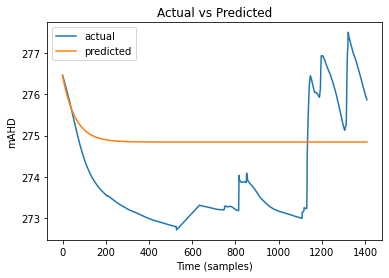

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_17_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

Num_Exp = 15
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_univar_17_post_2017=np.zeros(Num_Exp)
test_acc_univar_17_post_2017=np.zeros(Num_Exp)
Step_RMSE_univar_17_post_2017=np.zeros([Num_Exp,n_steps_out])

model_univar_17_post_2017 = Sequential()
model_univar_17_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_univar_17_post_2017.add(Dense(n_steps_out))
model_univar_17_post_2017.compile(optimizer='adam', loss='mse')
model_univar_17_post_2017.summary()
Best_RMSE_univar_17_post_2017=1000   #Assigning a large number 


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_17_post_2017
    #batch_size=64, 
    model_univar_17_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_17_post_2017.predict(x_train).flatten()
    y_predicttest = model_univar_17_post_2017.predict(x_test).flatten()
    train_acc_univar_17_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_17_post_2017[run] = rmse( y_predicttest, y_test)
    if test_acc_univar_17_post_2017[run]<Best_RMSE_univar_17_post_2017:
        Best_RMSE_univar_17_post_2017=test_acc_univar_17_post_2017[run]
        Best_Predict_Test_univar_17_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_17_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10)                480       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Total time for 15 experiments 1522.3335189819336


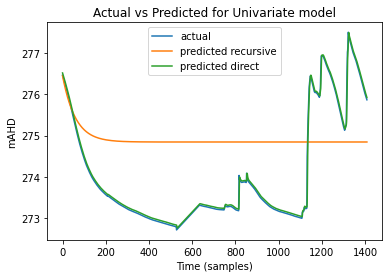

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_univar_17_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_17_post_2017.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_univar_17_recursive[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_univar_17_post_2017[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

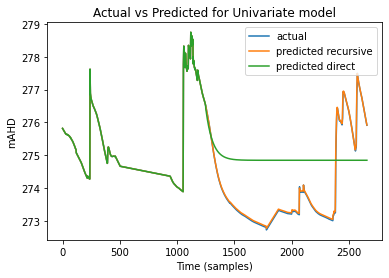

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_17.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_univar_17_post_2017

0.07821807297234896

In [ ]:
Best_RMSE_univar_17_recursive

1.5370180179077602

In [ ]:
Best_NSE_univar_17_post_2017 = r2_score(Best_Predict_Test_univar_17_post_2017, y_test[:])
Best_NSE_univar_17_recursive = r2_score(Best_Predict_Test_univar_17_recursive, y_test[:])

In [ ]:
Best_NSE_univar_17_post_2017

0.9964231484230979

In [ ]:
Best_NSE_univar_17_recursive

-46.02750741249296

### Streamflow


#### Post 2017

In [ ]:
in_seq1 = array(m17_daily['SF_mAHD'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_17_recursive=np.zeros(Num_Exp)
test_acc_streamflow_17_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_17_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_17_recursive = Sequential()
model_streamflow_17_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_17_recursive.add(Dense(n_steps_out))
model_streamflow_17_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_17_recursive.summary()
Best_RMSE_streamflow_17_recursive=1000   #Assigning a large number 

outputs_streamflow_17_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_17_recursive
    #batch_size=64, 
    model_streamflow_17_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_17_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_17_recursive, x_test_extra_samples[0][:,1], streamflow_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_17_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_17_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_17_recursive[run]) 
    outputs_streamflow_17_recursive[run,] = y_predicttest
    if test_acc_streamflow_17_recursive[run]<Best_RMSE_streamflow_17_recursive:
        Best_RMSE_streamflow_17_recursive=test_acc_streamflow_17_recursive[run]
        Best_Predict_Test_streamflow_17_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_17_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                520       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 1.5748240395616233
Experiment 2 in progress
RMSE value: 2.0173578107818417
Experiment 3 in progress
RMSE value: 2.653285444993208
Experiment 4 in progress
RMSE value: 1.4218579142093213
Experiment 5 in progress
RMSE value: 1.9172483429834508
Experiment 6 in progress
RMSE value: 3.7243041546819096
Experiment 7 in progress
RMSE value: 3.1346979587179673
Experiment 8 in progress
RMSE value: 2.558419653329426
Experime

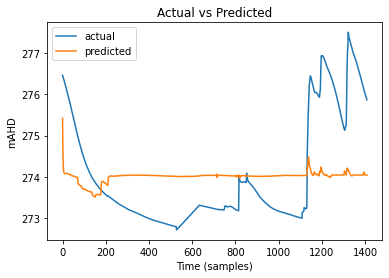

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_17_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m17_daily['SF_mAHD'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_17_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_17_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_17_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_17_post_2017 = Sequential()
model_streamflow_17_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_17_post_2017.add(Dense(n_steps_out))
model_streamflow_17_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_17_post_2017.summary()
Best_RMSE_streamflow_17_post_2017=1000   #Assigning a large number 


outputs_streamflow_17_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_17_post_2017
    #batch_size=64, 
    model_streamflow_17_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16,verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_17_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_17_post_2017.predict(x_test).flatten()
    train_acc_streamflow_17_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_17_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_17_post_2017[run])  
    outputs_streamflow_17_post_2017[run,] = y_predicttest
    if test_acc_streamflow_17_post_2017[run]<Best_RMSE_streamflow_17_post_2017:
        Best_RMSE_streamflow_17_post_2017=test_acc_streamflow_17_post_2017[run]
        Best_Predict_Test_streamflow_17_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_17_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                520       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 0.6872905990325912
Experiment 2 in progress
RMSE value: 0.6663269084864863
Experiment 3 in progress
RMSE value: 0.6483349890071202
Experiment 4 in progress
RMSE value: 0.6326351389902416
Experiment 5 in progress
RMSE value: 0.6191892991482609
Experiment 6 in progress
RMSE value: 0.6083823870825378
Experiment 7 in progress
RMSE value: 0.6011369802489716
Experiment 8 in progress
RMSE value: 0.6003650737536586
Expe

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_17_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_17_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_17_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_17_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_17_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_17_recursive, 50, axis=0)
in_between_percentage_streamflow_17_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_17_recursive

0.27982954545454547

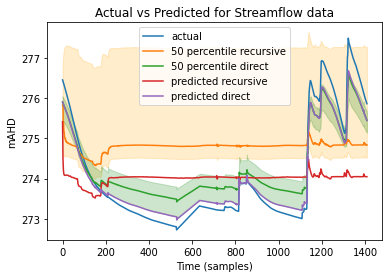

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_17_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_17_post_2017.png',dpi=300) 
plt.show()
plt.close()

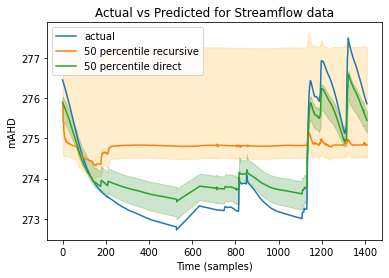

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_17_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

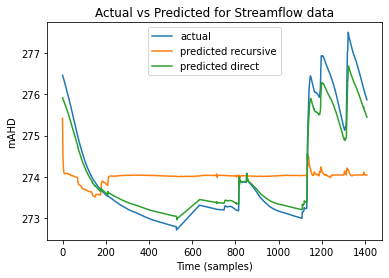

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_17_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_17_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_17_post_2017[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_17_recursive[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

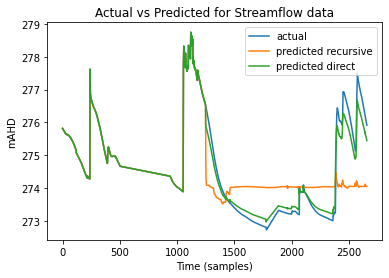

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_17.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_17_post_2017

0.29345319328656666

In [ ]:
Best_RMSE_streamflow_17_recursive

1.2963168872079662

In [ ]:
Best_NSE_streamflow_17_post_2017 = r2_score(Best_Predict_Test_streamflow_17_post_2017, y_test[:])
Best_NSE_streamflow_17_recursive = r2_score(Best_Predict_Test_streamflow_17_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_17_post_2017

0.917603529866261

In [ ]:
Best_NSE_streamflow_17_recursive

-108.12265458006944

In [ ]:
saved_map = {
    'outputs_streamflow_17_post_2017':outputs_streamflow_17_post_2017,
    'model_streamflow_17_post_2017': model_streamflow_17_post_2017,
    'train_acc_streamflow_17_post_2017': train_acc_streamflow_17_post_2017,
    'test_acc_streamflow_17_post_2017': test_acc_streamflow_17_post_2017,
    'Step_RMSE_streamflow_17_post_2017': Step_RMSE_streamflow_17_post_2017,
    'Best_predict_test_streamflow_17_post_2017': Best_Predict_Test_streamflow_17_post_2017,
    'Best_RMSE_streamflow_17_post_2017': Best_RMSE_streamflow_17_post_2017,
    'Best_NSE_streamflow_17_post_2017':Best_NSE_streamflow_17_post_2017,
    
    'outputs_streamflow_17_recursive':outputs_streamflow_17_recursive,
    'model_streamflow_17_recursive': model_streamflow_17_recursive,
    'train_acc_streamflow_17_recursive': train_acc_streamflow_17_recursive,
    'test_acc_streamflow_17_recursive': test_acc_streamflow_17_recursive,
    'Step_RMSE_streamflow_17_recursive': Step_RMSE_streamflow_17_recursive,
    'Best_predict_test_streamflow_17_recursive': Best_Predict_Test_streamflow_17_recursive,
    'Best_RMSE_streamflow_17_recursive': Best_RMSE_streamflow_17_recursive,
    'Best_NSE_streamflow_17_recursive':Best_NSE_streamflow_17_recursive,
    
    'in_between_percentage_streamflow_17_recursive': in_between_percentage_streamflow_17_recursive
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_17_streamflow_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Discretised streamflow

#### Post 2017

In [ ]:

in_seq1 = array(m17_daily['discretised_flow'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)


num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_17_recursive_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised_17_recursive=np.zeros(Num_Exp)
test_acc_streamflow_discretised_17_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_17_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_17_recursive = Sequential()
model_streamflow_discretised_17_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_17_recursive.add(Dense(n_steps_out))
model_streamflow_discretised_17_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_17_recursive.summary()
Best_RMSE_streamflow_discretised_17_recursive=1000   #Assigning a large number 

outputs_streamflow_discretised_17_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_17_recursive
    #batch_size=64, 
    model_streamflow_discretised_17_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    #y_predicttrain = model_streamflow_discretised_17_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_discretised_17_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_17_recursive_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_discretised_17_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_17_recursive[run] = rmse( y_predicttest, y_test)
    # x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
    # plt.figure()
    # plt.plot(x_data, y_test[:], label='actual')
    # plt.plot(x_data, y_predicttest, label='predicted')
    # plt.ylabel('mAHD')  
    # plt.xlabel('Time (samples)') 
    # plt.title('Actual vs Predicted')
    # plt.legend()
    # plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
    # plt.show()
    # plt.close()
    print("RMSE value:", test_acc_streamflow_discretised_17_recursive[run])
    outputs_streamflow_discretised_17_recursive[run,] = y_predicttest 
    if test_acc_streamflow_discretised_17_recursive[run]<Best_RMSE_streamflow_discretised_17_recursive:
        Best_RMSE_streamflow_discretised_17_recursive=test_acc_streamflow_discretised_17_recursive[run]
        Best_Predict_Test_streamflow_discretised_17_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_17_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                520       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value: 7.997429230384919
Experiment 2 in progress
RMSE value: 7.076707453144381
Experiment 3 in progress
RMSE value: 6.282325332469626
Experiment 4 in progress
RMSE value: 5.640195241010349
Experiment 5 in progress
RMSE value: 5.098149466154039
Experiment 6 in progress
RMSE value: 4.625755317735159
Experiment 7 in progress
RMSE value: 4.24354077284701
Experiment 8 in progress
RMSE value: 3.9331594399841996
Experiment 9

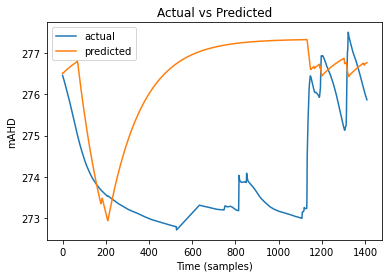

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_17_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
saved_map = {
    'outputs_streamflow_discretised_17_recursive':outputs_streamflow_discretised_17_recursive,
    'model_streamflow_discretised_17_recursive': model_streamflow_discretised_17_recursive,
    'train_acc_streamflow_discretised_17_recursive': train_acc_streamflow_discretised_17_recursive,
    'test_acc_streamflow_discretised_17_recursive': test_acc_streamflow_discretised_17_recursive,
    'Step_RMSE_streamflow_discretised_17_recursive': Step_RMSE_streamflow_discretised_17_recursive,
    'Best_predict_test_streamflow_discretised_17_recursive': Best_Predict_Test_streamflow_discretised_17_recursive,
    'Best_RMSE_streamflow_discretised_17_recursive': Best_RMSE_streamflow_discretised_17_recursive,
    'Best_NSE_streamflow_discretised_17_recursive':Best_NSE_streamflow_discretised_17_recursive,
    
    #'in_between_percentage_streamflow_discretised_17_recursive': in_between_percentage_streamflow_discretised_17_recursive
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_17_streamflow_discretised_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_17_streamflow_discretised_post_2017.pickle','rb')
data17 = pickle.load(pick_read)
pick_read.close()


model_streamflow_discretised_17_recursive = data17['model_streamflow_discretised_17_recursive'],
train_acc_streamflow_discretised_17_recursive = data17['train_acc_streamflow_discretised_17_recursive'],
test_acc_streamflow_discretised_17_recursive = data17['test_acc_streamflow_discretised_17_recursive'],
Step_RMSE_streamflow_discretised_17_recursive = data17['Step_RMSE_streamflow_discretised_17_recursive'],
Best_Predict_Test_streamflow_discretised_17_recursive = data17['Best_predict_test_streamflow_discretised_17_recursive'],
Best_RMSE_streamflow_discretised_17_recursive = data17['Best_RMSE_streamflow_discretised_17_recursive'],
Best_NSE_streamflow_discretised_17_recursive = data17['Best_NSE_streamflow_discretised_17_recursive'],
outputs_streamflow_discretised_17_recursive = data17['outputs_streamflow_discretised_17_recursive'],

In [ ]:
train_acc_streamflow_discretised_17_recursive

(array([0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688,
        0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688,
        0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688,
        0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688,
        0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688, 0.4017688]),)

In [ ]:

in_seq1 = array(m17_daily['discretised_flow'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)


num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_17_recursive_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000

train_acc_streamflow_discretised_17_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_discretised_17_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_17_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_17_post_2017 = Sequential()
model_streamflow_discretised_17_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_17_post_2017.add(Dense(n_steps_out))
model_streamflow_discretised_17_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_17_post_2017.summary()
Best_RMSE_streamflow_discretised_17_post_2017=1000   #Assigning a large number 

outputs_streamflow_discretised_17_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_17_post_2017
    #batch_size=64, 
    model_streamflow_discretised_17_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_17_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_17_post_2017.predict(x_test).flatten()
    train_acc_streamflow_discretised_17_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_17_post_2017[run] = rmse( y_predicttest, y_test) 
    print("RMSE: ", test_acc_streamflow_discretised_17_post_2017[run])
    outputs_streamflow_discretised_17_post_2017[run,] = y_predicttest
    if test_acc_streamflow_discretised_17_post_2017[run]<Best_RMSE_streamflow_discretised_17_post_2017:
        Best_RMSE_streamflow_discretised_17_post_2017=test_acc_streamflow_discretised_17_post_2017[run]
        Best_Predict_Test_streamflow_discretised_17_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_17_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                520       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE:  0.14867513924609319
Experiment 2 in progress
RMSE:  0.13903591730404424
Experiment 3 in progress
RMSE:  0.1125086283129461
Experiment 4 in progress
RMSE:  0.09949820633097338
Experiment 5 in progress
RMSE:  0.0988902702414188
Experiment 6 in progress
RMSE:  0.09832735035970944
Experiment 7 in progress
RMSE:  0.09787709526012019
Experiment 8 in progress
RMSE:  0.09752965781205389
Experiment 9 in progress
RMSE:  0.097305

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_discretised_17_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_discretised_17_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_discretised_17_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_discretised_17_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_discretised_17_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_discretised_17_recursive, 50, axis=0)
in_between_percentage_streamflow_discretised_17_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_discretised_17_recursive

0.11576704545454546

In [ ]:
Best_Predict_Test_streamflow_discretised_17_recursive = Best_Predict_Test_streamflow_discretised_17_recursive[0]

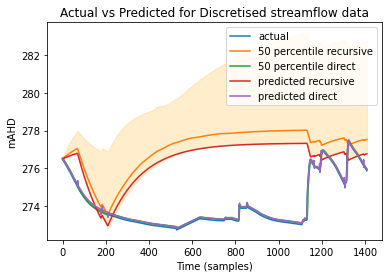

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_17_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_17_post_2017.png',dpi=300) 
plt.show()
plt.close()

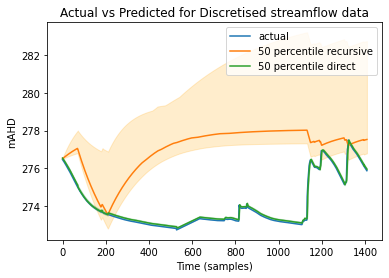

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_17_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

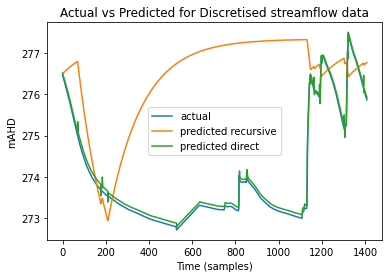

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_17_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_17_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_17_post_2017[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_17_recursive[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

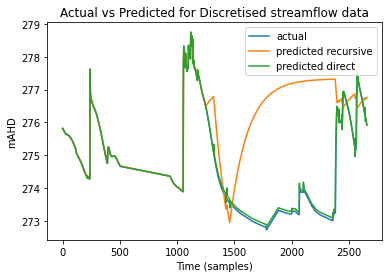

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Discretised_streamflow_18.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_17_post_2017

0.09616114184743514

In [ ]:
Best_RMSE_streamflow_discretised_17_recursive

(2.8958467812846336,)

In [ ]:
Best_NSE_streamflow_discretised_17_post_2017 = r2_score(Best_Predict_Test_streamflow_discretised_17_post_2017, y_test[:])
Best_NSE_streamflow_discretised_17_recursive = r2_score(Best_Predict_Test_streamflow_discretised_17_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_discretised_17_post_2017

0.994460117640185

In [ ]:
Best_NSE_streamflow_discretised_17_recursive

-5.782533085216471

In [ ]:
saved_map = {
    'outputs_streamflow_discretised_17_recursive':outputs_streamflow_discretised_17_recursive,
    'model_streamflow_discretised_17_recursive': model_streamflow_discretised_17_recursive,
    'train_acc_streamflow_discretised_17_recursive': train_acc_streamflow_discretised_17_recursive,
    'test_acc_streamflow_discretised_17_recursive': test_acc_streamflow_discretised_17_recursive,
    'Step_RMSE_streamflow_discretised_17_recursive': Step_RMSE_streamflow_discretised_17_recursive,
    'Best_predict_test_streamflow_discretised_17_recursive': Best_Predict_Test_streamflow_discretised_17_recursive,
    'Best_RMSE_streamflow_discretised_17_recursive': Best_RMSE_streamflow_discretised_17_recursive,
    'Best_NSE_streamflow_discretised_17_recursive':Best_NSE_streamflow_discretised_17_recursive,
    
    'outputs_streamflow_discretised_17_post_2017':outputs_streamflow_discretised_17_post_2017,
    'model_streamflow_discretised_17_post_2017': model_streamflow_discretised_17_post_2017,
    'train_acc_streamflow_discretised_17_post_2017': train_acc_streamflow_discretised_17_post_2017,
    'test_acc_streamflow_discretised_17_post_2017': test_acc_streamflow_discretised_17_post_2017,
    'Step_RMSE_streamflow_discretised_17_post_2017': Step_RMSE_streamflow_discretised_17_post_2017,
    'Best_predict_test_streamflow_discretised_17_post_2017': Best_Predict_Test_streamflow_discretised_17_post_2017,
    'Best_RMSE_streamflow_discretised_17_post_2017': Best_RMSE_streamflow_discretised_17_post_2017,
    'Best_NSE_streamflow_discretised_17_post_2017':Best_NSE_streamflow_discretised_17_post_2017,
    
    'in_between_percentage_streamflow_discretised_17_recursive': in_between_percentage_streamflow_discretised_17_recursive
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_17_streamflow_discretised_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Rainfall

#### Post 2017

In [ ]:

in_seq1 = array(m17_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m17_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m17_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

rainfall_seq_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000




train_acc_rainfall_17_recursive=np.zeros(Num_Exp)
test_acc_rainfall_17_recursive=np.zeros(Num_Exp)
Step_RMSE_rainfall_17_recursive=np.zeros([Num_Exp,n_steps_out])

model_rainfall_17_recursive = Sequential()
model_rainfall_17_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_17_recursive.add(Dense(n_steps_out))
model_rainfall_17_recursive.compile(optimizer='adam', loss='mse')
model_rainfall_17_recursive.summary()
Best_RMSE_rainfall_17_recursive=1000   #Assigning a large number 

outputs_rainfall_17_recursive = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_17_recursive
    #batch_size=64, 
    model_rainfall_17_recursive.fit(x_train, y_train, batch_size=16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_17_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_rainfall_17_recursive, x_test_extra_samples[0][:,1], rainfall_seq_post_2017,num_post_2017-3, 3)
    train_acc_rainfall_17_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_17_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE: ", test_acc_rainfall_17_recursive[run])
    outputs_rainfall_17_recursive[run,] = y_predicttest
    if test_acc_rainfall_17_recursive[run]<Best_RMSE_rainfall_17_recursive:
        Best_RMSE_rainfall_17_recursive=test_acc_rainfall_17_recursive[run]
        Best_Predict_Test_rainfall_17_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_17_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                520       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE:  25.14357100842643
Experiment 2 in progress
RMSE:  17.636533616384494
Experiment 3 in progress
RMSE:  12.933628591838184
Experiment 4 in progress
RMSE:  8.91743691955442
Experiment 5 in progress
RMSE:  4.725754880386542
Experiment 6 in progress
RMSE:  2.825538252140974
Experiment 7 in progress
RMSE:  9.839744860074779
Experiment 8 in progress
RMSE:  9.651531127969637
Experiment 9 in progress
RMSE:  9.456401099938034
E

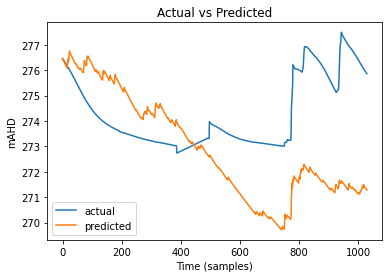

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_17_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:

in_seq1 = array(m17_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m17_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m17_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_rainfall_17_post_2017=np.zeros(Num_Exp)
test_acc_rainfall_17_post_2017=np.zeros(Num_Exp)
Step_RMSE_rainfall_17_post_2017=np.zeros([Num_Exp,n_steps_out])

model_rainfall_17_post_2017 = Sequential()
model_rainfall_17_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_17_post_2017.add(Dense(n_steps_out))
model_rainfall_17_post_2017.compile(optimizer='adam', loss='mse')
model_rainfall_17_post_2017.summary()
Best_RMSE_rainfall_17_post_2017=1000   #Assigning a large number 

outputs_rainfall_17_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_17_post_2017
    #batch_size=64, 
    model_rainfall_17_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_17_post_2017.predict(x_train).flatten()
    y_predicttest = model_rainfall_17_post_2017.predict(x_test).flatten()
    train_acc_rainfall_17_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_17_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE: ", test_acc_rainfall_17_post_2017[run])
    outputs_rainfall_17_post_2017[run,] = y_predicttest
    if test_acc_rainfall_17_post_2017[run]<Best_RMSE_rainfall_17_post_2017:
        Best_RMSE_rainfall_17_post_2017=test_acc_rainfall_17_post_2017[run]
        Best_Predict_Test_rainfall_17_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_17_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10)                520       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE:  0.4811457765535283
Experiment 2 in progress
RMSE:  0.47424496894091495
Experiment 3 in progress
RMSE:  0.46740596499889825
Experiment 4 in progress
RMSE:  0.46035988772960684
Experiment 5 in progress
RMSE:  0.45297516404194366
Experiment 6 in progress
RMSE:  0.4451939831968487
Experiment 7 in progress
RMSE:  0.4369025844040748
Experiment 8 in progress
RMSE:  0.4279072366410624
Experiment 9 in progress
RMSE:  0.417970

In [ ]:
fx_high_post_2017 = np.percentile(outputs_rainfall_17_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_rainfall_17_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_rainfall_17_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_rainfall_17_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_rainfall_17_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_rainfall_17_recursive, 50, axis=0)
in_between_percentage_rainfall_17_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_rainfall_17_recursive

1.0

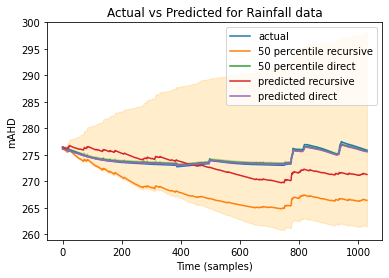

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_rainfall_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_17_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_17_post_2017.png',dpi=300) 
plt.show()
plt.close()

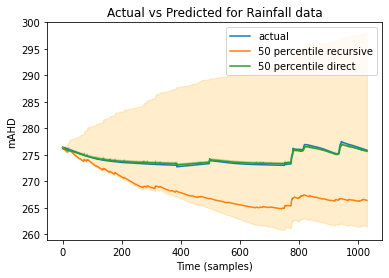

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_17_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

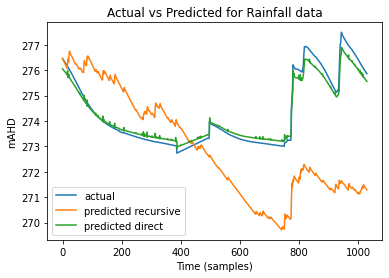

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_17_post_2017[:], label='predicted direct')

plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_17_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_17_pre_2017 = m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_17_post_2017[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_17_recursive[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

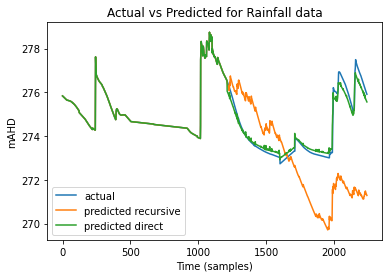

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_17.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_rainfall_17_post_2017

0.2492354780795555

In [ ]:
Best_RMSE_rainfall_17_recursive

2.825538252140974

In [ ]:
Best_NSE_rainfall_17_post_2017 = r2_score(Best_Predict_Test_rainfall_17_post_2017, y_test[:])
Best_NSE_rainfall_17_recursive = r2_score(Best_Predict_Test_rainfall_17_recursive, y_test[:])

In [ ]:
Best_NSE_rainfall_17_post_2017

0.9522078320818375

In [ ]:
Best_NSE_rainfall_17_recursive

-0.9413157392620135

In [ ]:
saved_map = {
    'outputs_rainfall_17_recursive':outputs_rainfall_17_recursive,
    'model_rainfall_17_recursive': model_rainfall_17_recursive,
    'train_acc_rainfall_17_recursive': train_acc_rainfall_17_recursive,
    'test_acc_rainfall_17_recursive': test_acc_rainfall_17_recursive,
    'Step_RMSE_rainfall_17_recursive': Step_RMSE_rainfall_17_recursive,
    'Best_predict_test_rainfall_17_recursive': Best_Predict_Test_rainfall_17_recursive,
    'Best_RMSE_rainfall_17_recursive': Best_RMSE_rainfall_17_recursive,
    'Best_NSE_rainfall_17_recursive':Best_NSE_rainfall_17_recursive,
    
    'outputs_rainfall_17_post_2017':outputs_rainfall_17_post_2017,
    'model_rainfall_17_post_2017': model_rainfall_17_post_2017,
    'train_acc_rainfall_17_post_2017': train_acc_rainfall_17_post_2017,
    'test_acc_rainfall_17_post_2017': test_acc_rainfall_17_post_2017,
    'Step_RMSE_rainfall_17_post_2017': Step_RMSE_rainfall_17_post_2017,
    'Best_predict_test_rainfall_17_post_2017': Best_Predict_Test_rainfall_17_post_2017,
    'Best_RMSE_rainfall_17_post_2017': Best_RMSE_rainfall_17_post_2017,
    'Best_NSE_rainfall_17_post_2017':Best_NSE_rainfall_17_post_2017,
    
    'in_between_percentage_rainfall_17_recursive': in_between_percentage_rainfall_17_recursive
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_17_rainfall_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

In [ ]:
saved_map_recursive = {
    'Best_NSE_streamflow_17_recursive': Best_NSE_streamflow_17_recursive,
    'model_streamflow_17_recursive': model_streamflow_17_recursive,
    'train_acc_streamflow_17_recursive': train_acc_streamflow_17_recursive,
    'test_acc_streamflow_17_recursive': test_acc_streamflow_17_recursive,
    'Step_RMSE_streamflow_17_recursive': Step_RMSE_streamflow_17_recursive,
    'Best_predict_test_streamflow_17_recursive': Best_Predict_Test_streamflow_17_recursive,
    'Best_RMSE_streamflow_17_recursive': Best_RMSE_streamflow_17_recursive,
    'Best_NSE_streamflow_17_post_2017': Best_NSE_streamflow_17_post_2017,
    'model_streamflow_17_post_2017': model_streamflow_17_post_2017,
    'train_acc_streamflow_17_post_2017': train_acc_streamflow_17_post_2017,
    'test_acc_streamflow_17_post_2017': test_acc_streamflow_17_post_2017,
    'Step_RMSE_streamflow_17_post_2017': Step_RMSE_streamflow_17_post_2017,
    'Best_predict_test_streamflow_17_post_2017': Best_Predict_Test_streamflow_17_post_2017,
    'Best_RMSE_streamflow_17_post_2017': Best_RMSE_streamflow_17_post_2017,
    'Best_NSE_streamflow_discretised_17_recursive': Best_NSE_streamflow_discretised_17_recursive,
    'model_streamflow_discretised_17_recursive': model_streamflow_discretised_17_recursive,
    'train_acc_streamflow_discretised_17_recursive': train_acc_streamflow_discretised_17_recursive,
    'test_acc_streamflow_discretised_17_recursive': test_acc_streamflow_discretised_17_recursive,
    'Step_RMSE_streamflow_discretised_17_recursive': Step_RMSE_streamflow_discretised_17_recursive,
    'Best_predict_test_streamflow_discretised_17_recursive': Best_Predict_Test_streamflow_discretised_17_recursive,
    'Best_NSE_streamflow_discretised_17_post_2017': Best_NSE_streamflow_discretised_17_post_2017,
    'Best_RMSE_streamflow_discretised_17_recursive': Best_RMSE_streamflow_discretised_17_recursive,
    'model_streamflow_discretised_17_post_2017': model_streamflow_discretised_17_post_2017,
    'test_acc_streamflow_discretised_17_post_2017': test_acc_streamflow_discretised_17_post_2017,
    'Step_RMSE_streamflow_discretised_17_post_2017': Step_RMSE_streamflow_discretised_17_post_2017,
    'Best_predict_test_streamflow_discretised_17_post_2017': Best_Predict_Test_streamflow_discretised_17_post_2017,
    'Best_RMSE_streamflow_discretised_17_post_2017': Best_RMSE_streamflow_discretised_17_post_2017,
    'Best_NSE_rainfall_17_post_2017':Best_NSE_rainfall_17_post_2017,
    'Best_NSE_rainfall_17_recursive': Best_NSE_rainfall_17_recursive,
    'model_rainfall_17_recursive': model_rainfall_17_recursive,
    'train_acc_rainfall_17_recursive': train_acc_rainfall_17_recursive,
    'test_acc_rainfall_17_recursive': test_acc_rainfall_17_recursive,
    'Step_RMSE_rainfall_17_recursive': Step_RMSE_rainfall_17_recursive,
    'Best_predict_test_rainfall_17_recursive': Best_Predict_Test_rainfall_17_recursive,
    'Best_RMSE_rainfall_17_recursive': Best_RMSE_rainfall_17_recursive,
    'model_rainfall_17_post_2017': model_rainfall_17_post_2017,
    'train_acc_rainfall_17_post_2017': train_acc_rainfall_17_post_2017,
    'test_acc_rainfall_17_post_2017': test_acc_rainfall_17_post_2017,
    'Step_RMSE_rainfall_17_post_2017': Step_RMSE_rainfall_17_post_2017,
    'Best_predict_test_rainfall_17_post_2017': Best_Predict_Test_rainfall_17_post_2017,
    'Best_RMSE_rainfall_17_post_2017': Best_RMSE_rainfall_17_post_2017,
}

# Save the python variable 'saved_map_recursive' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data_17_post_2017_no_rainfall.pickle','wb')
pickle.dump(saved_map_recursive, pick_insert)
pick_insert.close()

In [ ]:
pick_read = open('drive/My Drive/Thesis/Thesis/data_17_post_2017_no_rainfall.pickle','rb')
data17 = pickle.load(pick_read)
pick_read.close()

Best_NSE_streamflow_17_recursive = data17['Best_NSE_streamflow_17_recursive']
model_streamflow_17_recursive = data17['model_streamflow_17_recursive'],
train_acc_streamflow_17_recursive = data17['train_acc_streamflow_17_recursive'],
test_acc_streamflow_17_recursive = data17['test_acc_streamflow_17_recursive'],
Step_RMSE_streamflow_17_recursive = data17['Step_RMSE_streamflow_17_recursive'],
Best_Predict_Test_streamflow_17_recursive = data17['Best_predict_test_streamflow_17_recursive'],
Best_RMSE_streamflow_17_recursive = data17['Best_RMSE_streamflow_17_recursive'],

Best_NSE_streamflow_17_post_2017 = data17['Best_NSE_streamflow_17_post_2017']
model_streamflow_17_post_2017 = data17['model_streamflow_17_post_2017'],
train_acc_streamflow_17_post_2017 = data17['train_acc_streamflow_17_post_2017'],
test_acc_streamflow_17_post_2017 = data17['test_acc_streamflow_17_post_2017'],
Step_RMSE_streamflow_17_post_2017 = data17['Step_RMSE_streamflow_17_post_2017'],
Best_Predict_Test_streamflow_17_post_2017 = data17['Best_predict_test_streamflow_17_post_2017'],
Best_RMSE_streamflow_17_post_2017 = data17['Best_RMSE_streamflow_17_post_2017'],
################################################################################################################

Best_NSE_streamflow_discretised_17_recursive = data17['Best_NSE_streamflow_discretised_17_recursive']
model_streamflow_discretised_17_recursive = data17['model_streamflow_discretised_17_recursive'],
train_acc_streamflow_discretised_17_recursive = data17['train_acc_streamflow_discretised_17_recursive'],
test_acc_streamflow_discretised_17_recursive = data17['test_acc_streamflow_discretised_17_recursive'],
Step_RMSE_streamflow_discretised_17_recursive = data17['Step_RMSE_streamflow_discretised_17_recursive'],
Best_Predict_Test_streamflow_discretised_17_recursive = data17['Best_predict_test_streamflow_discretised_17_recursive'],

Best_NSE_streamflow_discretised_17_post_2017 = data17['Best_NSE_streamflow_discretised_17_post_2017']
Best_RMSE_streamflow_discretised_17_recursive = data17['Best_RMSE_streamflow_discretised_17_recursive'],
model_streamflow_discretised_17_post_2017 = data17['model_streamflow_discretised_17_post_2017'],
test_acc_streamflow_discretised_17_post_2017 = data17['test_acc_streamflow_discretised_17_post_2017'],
Step_RMSE_streamflow_discretised_17_post_2017 = data17['Step_RMSE_streamflow_discretised_17_post_2017'],
Best_Predict_Test_streamflow_discretised_17_post_2017 = data17['Best_predict_test_streamflow_discretised_17_post_2017'],
Best_RMSE_streamflow_discretised_17_post_2017 = data17['Best_RMSE_streamflow_discretised_17_post_2017'],


## CNN Model for borehole 17

### Univariate model

In [ ]:
in_seq1 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 50
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_univar_cnn_17_recursive=np.zeros(Num_Exp)
test_acc_univar_cnn_17_recursive=np.zeros(Num_Exp)
Step_RMSE_univar_cnn_17_recursive=np.zeros([Num_Exp,n_steps_out])


model_univar_cnn_17_recursive = Sequential()
model_univar_cnn_17_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_univar_cnn_17_recursive.add(MaxPooling1D(pool_size=2))
model_univar_cnn_17_recursive.add(Flatten())
model_univar_cnn_17_recursive.add(Dense(25, activation='relu'))
model_univar_cnn_17_recursive.add(Dense(1))
model_univar_cnn_17_recursive.compile(optimizer='adam', loss='mse')
model_univar_cnn_17_recursive.summary()
Best_RMSE_univar_cnn_17_recursive = 1000

outputs_univar_cnn_17_recursive = np.ones((Num_Exp, y_test.shape[0]))
start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_cnn_17_recursive
    #batch_size=64, 
    model_univar_cnn_17_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_cnn_17_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively_univariate(model_univar_cnn_17_recursive, x_test_extra_samples[0], num_post_2017-3, 3)
    train_acc_univar_cnn_17_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_cnn_17_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_univar_cnn_17_recursive[run]) 
    outputs_univar_cnn_17_recursive[run,] = y_predicttest
    if test_acc_univar_cnn_17_recursive[run]<Best_RMSE_univar_cnn_17_recursive:
        Best_RMSE_univar_cnn_17_recursive=test_acc_univar_cnn_17_recursive[run]
        Best_Predict_Test_univar_cnn_17_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_cnn_17_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 25)                1625      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,843
Trainable params: 1,843
Non-trainable params: 0
____________________________________________________

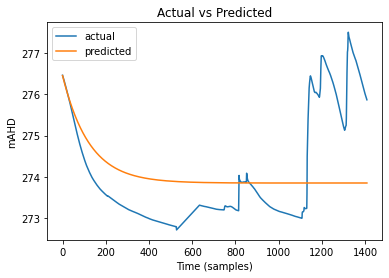

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_cnn_17_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

Num_Exp = 15
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_univar_cnn_17_post_2017=np.zeros(Num_Exp)
test_acc_univar_cnn_17_post_2017=np.zeros(Num_Exp)
Step_RMSE_univar_cnn_17_post_2017=np.zeros([Num_Exp,n_steps_out])

model_univar_cnn_17_post_2017 = Sequential()
model_univar_cnn_17_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_univar_cnn_17_post_2017.add(MaxPooling1D(pool_size=2))
model_univar_cnn_17_post_2017.add(Flatten())
model_univar_cnn_17_post_2017.add(Dense(25, activation='relu'))
model_univar_cnn_17_post_2017.add(Dense(1))
model_univar_cnn_17_post_2017.compile(optimizer='adam', loss='mse')
model_univar_cnn_17_post_2017.summary()
Best_RMSE_univar_cnn_17_post_2017 = 10000

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_univar_cnn_17_post_2017
    #batch_size=64, 
    model_univar_cnn_17_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_univar_cnn_17_post_2017.predict(x_train).flatten()
    y_predicttest = model_univar_cnn_17_post_2017.predict(x_test).flatten()
    train_acc_univar_cnn_17_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_univar_cnn_17_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_univar_cnn_17_post_2017[run]) 
    if test_acc_univar_cnn_17_post_2017[run]<Best_RMSE_univar_cnn_17_post_2017:
        Best_RMSE_univar_cnn_17_post_2017=test_acc_univar_cnn_17_post_2017[run]
        Best_Predict_Test_univar_cnn_17_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_univar_cnn_17_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2, 64)             192       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 25)                1625      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,843
Trainable params: 1,843
Non-trainable params: 0
____________________________________________________

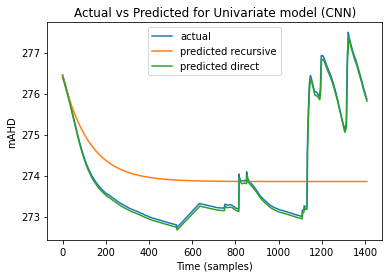

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_univar_cnn_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_univar_cnn_17_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_cnn_17_post_2017.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_univar_cnn_17_recursive[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_univar_cnn_17_post_2017[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

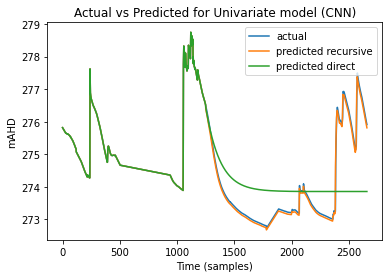

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Univariate model (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Univar_cnn_17.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_univar_cnn_17_post_2017

0.0818768855025026

In [ ]:
Best_RMSE_univar_cnn_17_recursive

1.2842768030607667

In [ ]:
Best_NSE_univar_cnn_17_post_2017 = r2_score(Best_Predict_Test_univar_cnn_17_post_2017, y_test[:])
Best_NSE_univar_cnn_17_recursive = r2_score(Best_Predict_Test_univar_cnn_17_recursive, y_test[:])

In [ ]:
Best_NSE_univar_cnn_17_post_2017

0.9960679317189475

In [ ]:
Best_NSE_univar_cnn_17_recursive

-5.694654998621525

### Streamflow

#### Post 2017

In [ ]:
in_seq1 = array(m17_daily['SF_mAHD'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_cnn_17_recursive=np.zeros(Num_Exp)
test_acc_streamflow_cnn_17_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_cnn_17_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_cnn_17_recursive = Sequential()
model_streamflow_cnn_17_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_cnn_17_recursive.add(MaxPooling1D(pool_size=2))
model_streamflow_cnn_17_recursive.add(Flatten())
model_streamflow_cnn_17_recursive.add(Dense(25, activation='relu'))
model_streamflow_cnn_17_recursive.add(Dense(1))
model_streamflow_cnn_17_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_cnn_17_recursive.summary()

Best_RMSE_streamflow_cnn_17_recursive=1000   #Assigning a large number 
outputs_streamflow_cnn_17_recursive = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_17_recursive
    #batch_size=64, 
    model_streamflow_cnn_17_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_cnn_17_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_cnn_17_recursive, x_test_extra_samples[0][:,1], streamflow_cnn_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_cnn_17_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_cnn_17_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_cnn_17_recursive[run]) 
    outputs_streamflow_cnn_17_recursive[run,] = y_predicttest
    if test_acc_streamflow_cnn_17_recursive[run]<Best_RMSE_streamflow_cnn_17_recursive:
        Best_RMSE_streamflow_cnn_17_recursive=test_acc_streamflow_cnn_17_recursive[run]
        Best_Predict_Test_streamflow_cnn_17_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_cnn_17_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
______________________________________________________

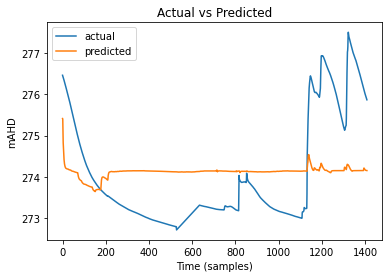

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_17_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m17_daily['SF_mAHD'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_cnn_17_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_cnn_17_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_cnn_17_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_cnn_17_post_2017 = Sequential()
model_streamflow_cnn_17_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_cnn_17_post_2017.add(MaxPooling1D(pool_size=2))
model_streamflow_cnn_17_post_2017.add(Flatten())
model_streamflow_cnn_17_post_2017.add(Dense(25, activation='relu'))
model_streamflow_cnn_17_post_2017.add(Dense(1))
model_streamflow_cnn_17_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_cnn_17_post_2017.summary()

Best_RMSE_streamflow_cnn_17_post_2017=1000   #Assigning a large number 
outputs_streamflow_cnn_17_post_2017 = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_17_post_2017
    #batch_size=64, 
    model_streamflow_cnn_17_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_cnn_17_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_cnn_17_post_2017.predict(x_test).flatten()
    train_acc_streamflow_cnn_17_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_cnn_17_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_cnn_17_post_2017[run])  
    outputs_streamflow_cnn_17_post_2017[run,] = y_predicttest
    if test_acc_streamflow_cnn_17_post_2017[run]<Best_RMSE_streamflow_cnn_17_post_2017:
        Best_RMSE_streamflow_cnn_17_post_2017=test_acc_streamflow_cnn_17_post_2017[run]
        Best_Predict_Test_streamflow_cnn_17_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_cnn_17_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_cnn_17_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_cnn_17_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_cnn_17_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_cnn_17_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_cnn_17_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_cnn_17_recursive, 50, axis=0)
in_between_percentage_streamflow_cnn_17_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_cnn_17_recursive

0.3338068181818182

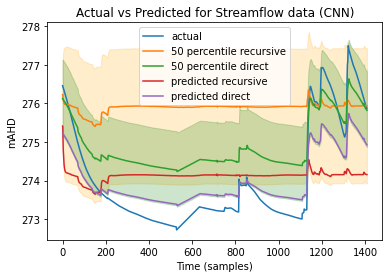

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_17_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_17_post_2017.png',dpi=300) 
plt.show()
plt.close()

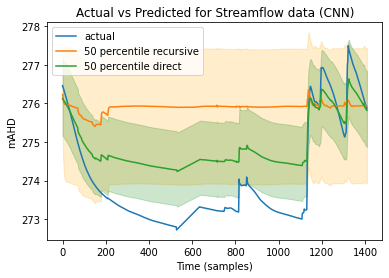

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_17_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

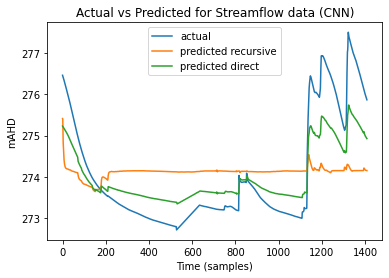

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_cnn_17_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_17_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_cnn_17_post_2017[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_cnn_17_recursive[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

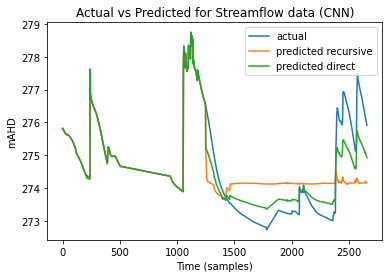

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_cnn_17.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_cnn_17_post_2017

0.663494673975256

In [ ]:
Best_RMSE_streamflow_cnn_17_recursive

1.2926976059498991

In [ ]:
Best_NSE_streamflow_cnn_17_post_2017 = r2_score(Best_Predict_Test_streamflow_cnn_17_post_2017, y_test[:])
Best_NSE_streamflow_cnn_17_recursive = r2_score(Best_Predict_Test_streamflow_cnn_17_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_cnn_17_post_2017

-0.029739645781866386

In [ ]:
Best_NSE_streamflow_cnn_17_recursive

-101.69253284805652

In [ ]:
saved_map = {
    'outputs_streamflow_cnn_17_recursive':outputs_streamflow_cnn_17_recursive,
    'model_streamflow_cnn_17_recursive': model_streamflow_cnn_17_recursive,
    'train_acc_streamflow_cnn_17_recursive': train_acc_streamflow_cnn_17_recursive,
    'test_acc_streamflow_cnn_17_recursive': test_acc_streamflow_cnn_17_recursive,
    'Step_RMSE_streamflow_cnn_17_recursive': Step_RMSE_streamflow_cnn_17_recursive,
    'Best_predict_test_streamflow_cnn_17_recursive': Best_Predict_Test_streamflow_cnn_17_recursive,
    'Best_RMSE_streamflow_cnn_17_recursive': Best_RMSE_streamflow_cnn_17_recursive,
    'Best_NSE_streamflow_cnn_17_recursive':Best_NSE_streamflow_cnn_17_recursive,
    
    'outputs_streamflow_cnn_17_post_2017':outputs_streamflow_cnn_17_post_2017,
    'model_streamflow_cnn_17_post_2017': model_streamflow_cnn_17_post_2017,
    'train_acc_streamflow_cnn_17_post_2017': train_acc_streamflow_cnn_17_post_2017,
    'test_acc_streamflow_cnn_17_post_2017': test_acc_streamflow_cnn_17_post_2017,
    'Step_RMSE_streamflow_cnn_17_post_2017': Step_RMSE_streamflow_cnn_17_post_2017,
    'Best_predict_test_streamflow_cnn_17_post_2017': Best_Predict_Test_streamflow_cnn_17_post_2017,
    'Best_RMSE_streamflow_cnn_17_post_2017': Best_RMSE_streamflow_cnn_17_post_2017,
    'Best_NSE_streamflow_cnn_17_post_2017':Best_NSE_streamflow_cnn_17_post_2017,
    
    'in_between_percentage_streamflow_cnn_17_recursive': in_between_percentage_streamflow_cnn_17_recursive
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_17_streamflow_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Discretised streamflow

#### Post 2017


In [ ]:
in_seq1 = array(m17_daily['discretised_flow'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_discretised_cnn_17_recursive=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_17_recursive=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_17_recursive=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_17_recursive = Sequential()
model_streamflow_discretised_cnn_17_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_17_recursive.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_17_recursive.add(Flatten())
model_streamflow_discretised_cnn_17_recursive.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_17_recursive.add(Dense(1))
model_streamflow_discretised_cnn_17_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_17_recursive.summary()

Best_RMSE_streamflow_discretised_cnn_17_recursive=1000   #Assigning a large number 

outputs_streamflow_discretised_cnn_17_recursive = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_17_recursive
    #batch_size=64, 
    model_streamflow_discretised_cnn_17_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_cnn_17_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_streamflow_discretised_cnn_17_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_cnn_post_2017,num_post_2017-3, 3)
    train_acc_streamflow_discretised_cnn_17_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_cnn_17_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_streamflow_discretised_cnn_17_recursive[run]) 
    outputs_streamflow_discretised_cnn_17_recursive[run,] = y_predicttest
    if test_acc_streamflow_discretised_cnn_17_recursive[run]<Best_RMSE_streamflow_discretised_cnn_17_recursive:
        Best_RMSE_streamflow_discretised_cnn_17_recursive=test_acc_streamflow_discretised_cnn_17_recursive[run]
        Best_Predict_Test_streamflow_discretised_cnn_17_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_17_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 25)                1625      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

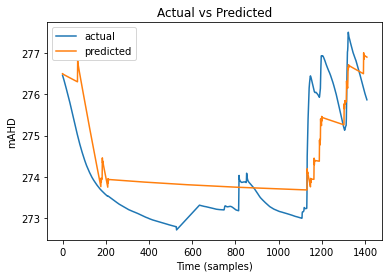

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_17_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m17_daily['discretised_flow'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_streamflow_discretised_cnn_17_post_2017=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_17_post_2017=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_17_post_2017=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_17_post_2017 = Sequential()
model_streamflow_discretised_cnn_17_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_17_post_2017.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_17_post_2017.add(Flatten())
model_streamflow_discretised_cnn_17_post_2017.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_17_post_2017.add(Dense(1))
model_streamflow_discretised_cnn_17_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_17_post_2017.summary()

Best_RMSE_streamflow_discretised_cnn_17_post_2017=1000   #Assigning a large number 
outputs_streamflow_discretised_cnn_17_post_2017 = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_17_post_2017
    #batch_size=64, 
    model_streamflow_discretised_cnn_17_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_streamflow_discretised_cnn_17_post_2017.predict(x_train).flatten()
    y_predicttest = model_streamflow_discretised_cnn_17_post_2017.predict(x_test).flatten()
    train_acc_streamflow_discretised_cnn_17_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_streamflow_discretised_cnn_17_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_streamflow_discretised_cnn_17_post_2017[run])  
    outputs_streamflow_discretised_cnn_17_post_2017[run,] = y_predicttest
    if test_acc_streamflow_discretised_cnn_17_post_2017[run]<Best_RMSE_streamflow_discretised_cnn_17_post_2017:
        Best_RMSE_streamflow_discretised_cnn_17_post_2017=test_acc_streamflow_discretised_cnn_17_post_2017[run]
        Best_Predict_Test_streamflow_discretised_cnn_17_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_17_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 25)                1625      
                                                                 
 dense_15 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

In [ ]:
fx_high_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_17_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_17_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_streamflow_discretised_cnn_17_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_streamflow_discretised_cnn_17_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_streamflow_discretised_cnn_17_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_streamflow_discretised_cnn_17_recursive, 50, axis=0)
in_between_percentage_streamflow_discretised_cnn_17_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_streamflow_discretised_cnn_17_recursive

0.0

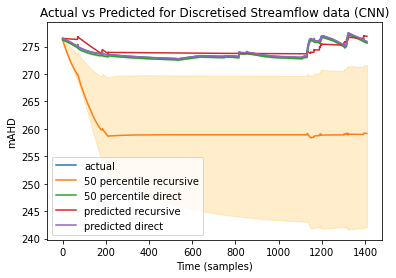

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_17_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised Streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_17_post_2017.png',dpi=300) 
plt.show()
plt.close()

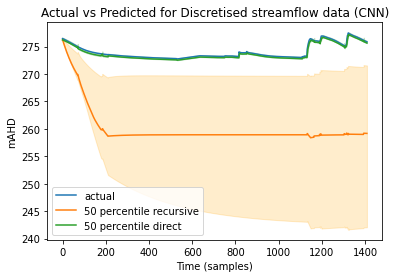

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_17_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

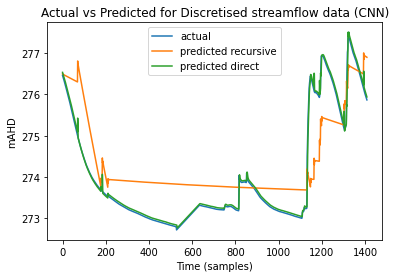

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_17_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_17_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_17_post_2017[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_17_recursive[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

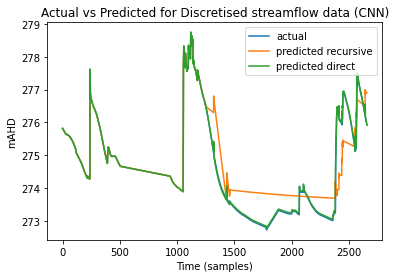

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Discretised streamflow data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_17.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_cnn_17_post_2017

0.07939642987074524

In [ ]:
Best_RMSE_streamflow_discretised_cnn_17_recursive

0.8164533963829549

In [ ]:
Best_NSE_streamflow_discretised_cnn_17_post_2017 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_17_post_2017, y_test[:])
Best_NSE_streamflow_discretised_cnn_17_recursive = r2_score(Best_Predict_Test_streamflow_discretised_cnn_17_recursive, y_test[:])

In [ ]:
Best_NSE_streamflow_discretised_cnn_17_post_2017

0.9963699165755994

In [ ]:
Best_NSE_streamflow_discretised_cnn_17_recursive

0.3206128935252731

In [ ]:
saved_map = {
    'outputs_streamflow_discretised_cnn_17_recursive':outputs_streamflow_discretised_cnn_17_recursive,
    'model_streamflow_discretised_cnn_17_recursive': model_streamflow_discretised_cnn_17_recursive,
    'train_acc_streamflow_discretised_cnn_17_recursive': train_acc_streamflow_discretised_cnn_17_recursive,
    'test_acc_streamflow_discretised_cnn_17_recursive': test_acc_streamflow_discretised_cnn_17_recursive,
    'Step_RMSE_streamflow_discretised_cnn_17_recursive': Step_RMSE_streamflow_discretised_cnn_17_recursive,
    'Best_predict_test_streamflow_discretised_cnn_17_recursive': Best_Predict_Test_streamflow_discretised_cnn_17_recursive,
    'Best_RMSE_streamflow_discretised_cnn_17_recursive': Best_RMSE_streamflow_discretised_cnn_17_recursive,
    'Best_NSE_streamflow_discretised_cnn_17_recursive':Best_NSE_streamflow_discretised_cnn_17_recursive,
    
    'outputs_streamflow_discretised_cnn_17_post_2017':outputs_streamflow_discretised_cnn_17_post_2017,
    'model_streamflow_discretised_cnn_17_post_2017': model_streamflow_discretised_cnn_17_post_2017,
    'train_acc_streamflow_discretised_cnn_17_post_2017': train_acc_streamflow_discretised_cnn_17_post_2017,
    'test_acc_streamflow_discretised_cnn_17_post_2017': test_acc_streamflow_discretised_cnn_17_post_2017,
    'Step_RMSE_streamflow_discretised_cnn_17_post_2017': Step_RMSE_streamflow_discretised_cnn_17_post_2017,
    'Best_predict_test_streamflow_discretised_cnn_17_post_2017': Best_Predict_Test_streamflow_discretised_cnn_17_post_2017,
    'Best_RMSE_streamflow_discretised_cnn_17_post_2017': Best_RMSE_streamflow_discretised_cnn_17_post_2017,
    'Best_NSE_streamflow_discretised_cnn_17_post_2017':Best_NSE_streamflow_discretised_cnn_17_post_2017,
    
    'in_between_percentage_streamflow_discretised_cnn_17_recursive': in_between_percentage_streamflow_discretised_cnn_17_recursive
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_17_streamflow_discretised_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

### Rainfall

#### Post 2017

In [ ]:
in_seq1 = array(m17_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m17_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m17_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_discretised_cnn_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs= 1000

train_acc_rainfall_cnn_17_recursive=np.zeros(Num_Exp)
test_acc_rainfall_cnn_17_recursive=np.zeros(Num_Exp)
Step_RMSE_rainfall_cnn_17_recursive=np.zeros([Num_Exp,n_steps_out])

model_rainfall_cnn_17_recursive = Sequential()
model_rainfall_cnn_17_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_cnn_17_recursive.add(MaxPooling1D(pool_size=2))
model_rainfall_cnn_17_recursive.add(Flatten())
model_rainfall_cnn_17_recursive.add(Dense(25, activation='relu'))
model_rainfall_cnn_17_recursive.add(Dense(1))
model_rainfall_cnn_17_recursive.compile(optimizer='adam', loss='mse')
model_rainfall_cnn_17_recursive.summary()

Best_RMSE_rainfall_cnn_17_recursive=1000   #Assigning a large number 
outputs_rainfall_cnn_17_recursive = np.ones((Num_Exp, y_test.shape[0]))


start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_17_recursive
    #batch_size=64, 
    model_rainfall_cnn_17_recursive.fit(x_train, y_train, batch_size = 16, epochs=Epochs, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_cnn_17_recursive.predict(x_train).flatten()
    y_predicttest = predict_recursively(model_rainfall_cnn_17_recursive, x_test_extra_samples[0][:,1], streamflow_discretised_cnn_post_2017,num_post_2017-3, 3)
    train_acc_rainfall_cnn_17_recursive[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_cnn_17_recursive[run] = rmse( y_predicttest, y_test) 
    print("RMSE value:", test_acc_rainfall_cnn_17_recursive[run]) 
    outputs_rainfall_cnn_17_recursive[run,] = y_predicttest
    if test_acc_rainfall_cnn_17_recursive[run]<Best_RMSE_rainfall_cnn_17_recursive:
        Best_RMSE_rainfall_cnn_17_recursive=test_acc_rainfall_cnn_17_recursive[run]
        Best_Predict_Test_rainfall_cnn_17_recursive=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_cnn_17_recursive[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 2, 64)             320       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 25)                1625      
                                                                 
 dense_27 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
___________________________________________________

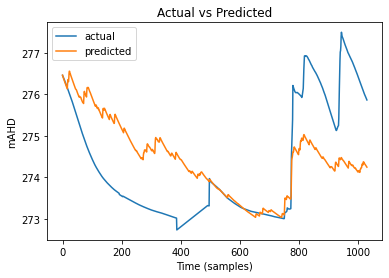

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_17_recursive[:], label='predicted')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
#plt.savefig(name+"_"+Mname+'pred_Step'+'.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
in_seq1 = array(m17_daily_rainfall['Rainfall'][:-1])
in_seq2 = array(m17_daily_rainfall['BH_mAHD'][:-1])
out_seq = array(m17_daily_rainfall['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017 = len(m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017 = len(m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train = X[0:num_pre_2017]
x_test = X[num_pre_2017:]
x_train_extra_samples = X[0:num_pre_2017]
x_test_extra_samples = X[num_pre_2017:]
y_train = y[0:num_pre_2017]
y_test = y[num_pre_2017:]
n_features = X.shape[2]

streamflow_post_2017 = in_seq1[num_pre_2017:]
Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000



train_acc_rainfall_cnn_17_post_2017=np.zeros(Num_Exp)
test_acc_rainfall_cnn_17_post_2017=np.zeros(Num_Exp)
Step_RMSE_rainfall_cnn_17_post_2017=np.zeros([Num_Exp,n_steps_out])

model_rainfall_cnn_17_post_2017 = Sequential()
model_rainfall_cnn_17_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_rainfall_cnn_17_post_2017.add(MaxPooling1D(pool_size=2))
model_rainfall_cnn_17_post_2017.add(Flatten())
model_rainfall_cnn_17_post_2017.add(Dense(25, activation='relu'))
model_rainfall_cnn_17_post_2017.add(Dense(1))
model_rainfall_cnn_17_post_2017.compile(optimizer='adam', loss='mse')
model_rainfall_cnn_17_post_2017.summary()

Best_RMSE_rainfall_cnn_17_post_2017=1000   #Assigning a large number 

outputs_rainfall_cnn_17_post_2017 = np.ones((Num_Exp, y_test.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_rainfall_17_post_2017
    #batch_size=64, 
    model_rainfall_cnn_17_post_2017.fit(x_train, y_train, epochs=Epochs, batch_size=16, verbose=0, shuffle=False)
    y_predicttrain = model_rainfall_cnn_17_post_2017.predict(x_train).flatten()
    y_predicttest = model_rainfall_cnn_17_post_2017.predict(x_test).flatten()
    train_acc_rainfall_cnn_17_post_2017[run] = rmse( y_predicttrain,y_train) 
    test_acc_rainfall_cnn_17_post_2017[run] = rmse( y_predicttest, y_test)
    print("RMSE value:", test_acc_rainfall_cnn_17_post_2017[run])  
    outputs_rainfall_cnn_17_post_2017[run,] = y_predicttest
    if test_acc_rainfall_cnn_17_post_2017[run]<Best_RMSE_rainfall_cnn_17_post_2017:
        Best_RMSE_rainfall_cnn_17_post_2017=test_acc_rainfall_cnn_17_post_2017[run]
        Best_Predict_Test_rainfall_cnn_17_post_2017=y_predicttest
    for j in range(n_steps_out):
      Step_RMSE_rainfall_cnn_17_post_2017[run]=rmse(y_predicttest[:], y_test[:])        
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 2, 64)             320       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 25)                1625      
                                                                 
 dense_25 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
___________________________________________________

In [ ]:
fx_high_post_2017 = np.percentile(outputs_rainfall_cnn_17_post_2017, 95, axis=0)
fx_low_post_2017 = np.percentile(outputs_rainfall_cnn_17_post_2017, 5, axis=0)
fx_mid_post_2017 = np.percentile(outputs_rainfall_cnn_17_post_2017, 50, axis=0)
fx_high_recursive = np.percentile(outputs_rainfall_cnn_17_recursive, 95, axis=0)
fx_low_recursive = np.percentile(outputs_rainfall_cnn_17_recursive, 5, axis=0)
fx_mid_recursive = np.percentile(outputs_rainfall_cnn_17_recursive, 50, axis=0)
in_between_percentage_rainfall_cnn_17_recursive = np.count_nonzero(np.less(fx_low_recursive,y_test) & np.greater_equal(fx_high_recursive,y_test) )/len(y_test)
in_between_percentage_rainfall_cnn_17_recursive

0.5393586005830904

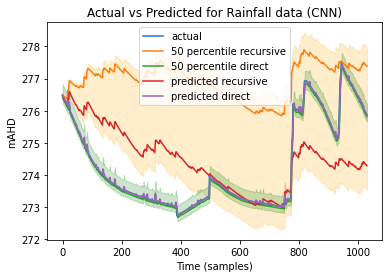

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_17_post_2017[:], label='predicted direct')
plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_17_post_2017.png',dpi=300) 
plt.show()
plt.close()

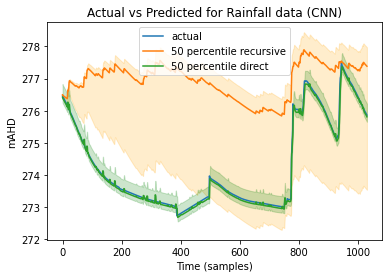

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, fx_mid_recursive[:], label='50 percentile recursive')
plt.plot(x_data, fx_mid_post_2017[:], label='50 percentile direct')

plt.fill_between(x_data, fx_low_recursive, fx_high_recursive, color='orange', alpha=0.2)
plt.fill_between(x_data, fx_low_post_2017, fx_high_post_2017, color='green', alpha=0.2)
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_17_post_2017_50_only.png',dpi=300) 
plt.show()
plt.close()

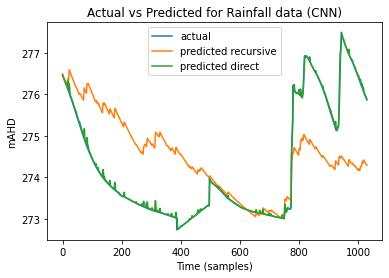

In [ ]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
plt.figure()
plt.plot(x_data, y_test[:], label='actual')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_17_recursive[:], label='predicted recursive')
plt.plot(x_data, Best_Predict_Test_rainfall_cnn_17_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_17_post_2017_best_only.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_17_pre_2017 = m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily_rainfall[m17_daily_rainfall['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_cnn_17_post_2017[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_rainfall_cnn_17_recursive[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

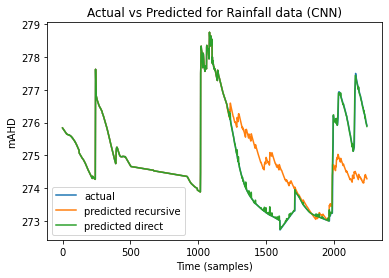

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Rainfall data (CNN)')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Rainfall_cnn_17.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_rainfall_cnn_17_post_2017

0.07225779073403217

In [ ]:
Best_RMSE_rainfall_cnn_17_recursive

1.3817737973059465

In [ ]:
Best_NSE_rainfall_cnn_17_post_2017 = r2_score(Best_Predict_Test_rainfall_cnn_17_post_2017, y_test[:])
Best_NSE_rainfall_cnn_17_recursive = r2_score(Best_Predict_Test_rainfall_cnn_17_recursive, y_test[:])

In [ ]:
Best_NSE_rainfall_cnn_17_post_2017

0.9972645258958678

In [ ]:
Best_NSE_rainfall_cnn_17_recursive

-1.3057522063547484

In [ ]:
saved_map = {
    'outputs_rainfall_cnn_17_recursive':outputs_rainfall_cnn_17_recursive,
    'model_rainfall_cnn_17_recursive': model_rainfall_cnn_17_recursive,
    'train_acc_rainfall_cnn_17_recursive': train_acc_rainfall_cnn_17_recursive,
    'test_acc_rainfall_cnn_17_recursive': test_acc_rainfall_cnn_17_recursive,
    'Step_RMSE_rainfall_cnn_17_recursive': Step_RMSE_rainfall_cnn_17_recursive,
    'Best_predict_test_rainfall_cnn_17_recursive': Best_Predict_Test_rainfall_cnn_17_recursive,
    'Best_RMSE_rainfall_cnn_17_recursive': Best_RMSE_rainfall_cnn_17_recursive,
    'Best_NSE_rainfall_cnn_17_recursive':Best_NSE_rainfall_cnn_17_recursive,
    
    'outputs_rainfall_cnn_17_post_2017':outputs_rainfall_cnn_17_post_2017,
    'model_rainfall_cnn_17_post_2017': model_rainfall_cnn_17_post_2017,
    'train_acc_rainfall_cnn_17_post_2017': train_acc_rainfall_cnn_17_post_2017,
    'test_acc_rainfall_cnn_17_post_2017': test_acc_rainfall_cnn_17_post_2017,
    'Step_RMSE_rainfall_cnn_17_post_2017': Step_RMSE_rainfall_cnn_17_post_2017,
    'Best_predict_test_rainfall_cnn_17_post_2017': Best_Predict_Test_rainfall_cnn_17_post_2017,
    'Best_RMSE_rainfall_cnn_17_post_2017': Best_RMSE_rainfall_cnn_17_post_2017,
    'Best_NSE_rainfall_cnn_17_post_2017':Best_NSE_rainfall_cnn_17_post_2017,
    
    'in_between_percentage_rainfall_cnn_17_recursive': in_between_percentage_rainfall_cnn_17_recursive
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_17_rainfall_cnn_post_2017.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

## Saving CNN Univariate models

In [ ]:

saved_map = {
    'outputs_univar_cnn_19_recursive': outputs_univar_cnn_19_recursive,
    'model_univar_cnn_19_post_2017': model_univar_cnn_19_post_2017,
    'train_acc_univar_cnn_19_post_2017': train_acc_univar_cnn_19_post_2017,
    'test_acc_univar_cnn_19_post_2017': test_acc_univar_cnn_19_post_2017,
    'Step_RMSE_univar_cnn_19_post_2017': Step_RMSE_univar_cnn_19_post_2017,
    'Best_Predict_test_univar_cnn_19_post_2017': Best_Predict_Test_univar_cnn_19_post_2017,
    'Best_RMSE_univar_cnn_19_post_2017': Best_RMSE_univar_cnn_19_post_2017,
    'Best_NSE_univar_cnn_19_post_2017': Best_NSE_univar_cnn_19_post_2017,
    'model_univar_cnn_19_recursive': model_univar_cnn_19_recursive,
    'train_acc_univar_cnn_19_recursive': train_acc_univar_cnn_19_recursive,
    'test_acc_univar_cnn_19_recursive': test_acc_univar_cnn_19_recursive,
    'Step_RMSE_univar_cnn_19_recursive': Step_RMSE_univar_cnn_19_recursive,
    'Best_Predict_test_univar_cnn_19_recursive': Best_Predict_Test_univar_cnn_19_recursive,
    'Best_RMSE_univar_cnn_19_recursive': Best_RMSE_univar_cnn_19_recursive,
    'Best_NSE_univar_cnn_19_recursive': Best_NSE_univar_cnn_19_recursive,
    
    'outputs_univar_cnn_18_recursive': outputs_univar_cnn_18_recursive,
    'model_univar_cnn_18_post_2017': model_univar_cnn_18_post_2017,
    'train_acc_univar_cnn_18_post_2017': train_acc_univar_cnn_18_post_2017,
    'test_acc_univar_cnn_18_post_2017': test_acc_univar_cnn_18_post_2017,
    'Step_RMSE_univar_cnn_18_post_2017': Step_RMSE_univar_cnn_18_post_2017,
    'Best_predict_test_univar_cnn_18_post_2017': Best_Predict_Test_univar_cnn_18_post_2017,
    'Best_RMSE_univar_cnn_18_post_2017': Best_RMSE_univar_cnn_18_post_2017,
    'Best_NSE_univar_cnn_18_post_2017': Best_NSE_univar_cnn_18_post_2017,
    'model_univar_cnn_18_recursive': model_univar_cnn_18_recursive,
    'train_acc_univar_cnn_18_recursive': train_acc_univar_cnn_18_recursive,
    'test_acc_univar_cnn_18_recursive': test_acc_univar_cnn_18_recursive,
    'Step_RMSE_univar_cnn_18_recursive': Step_RMSE_univar_cnn_18_recursive,
    'Best_predict_test_univar_cnn_18_recursive': Best_Predict_Test_univar_cnn_18_recursive,
    'Best_RMSE_univar_cnn_18_recursive': Best_RMSE_univar_cnn_18_recursive,
    'Best_NSE_univar_cnn_18_recursive': Best_NSE_univar_cnn_18_recursive,

    'outputs_univar_cnn_17_recursive': outputs_univar_cnn_17_recursive,
    'model_univar_cnn_17_post_2017': model_univar_cnn_17_post_2017,
    'train_acc_univar_cnn_17_post_2017': train_acc_univar_cnn_17_post_2017,
    'test_acc_univar_cnn_17_post_2017': test_acc_univar_cnn_17_post_2017,
    'Step_RMSE_univar_cnn_17_post_2017': Step_RMSE_univar_cnn_17_post_2017,
    'Best_predict_test_univar_cnn_17_post_2017': Best_Predict_Test_univar_cnn_17_post_2017,
    'Best_RMSE_univar_cnn_17_post_2017': Best_RMSE_univar_cnn_17_post_2017,
    'Best_NSE_univar_cnn_17_post_2017': Best_NSE_univar_cnn_17_post_2017,
    'model_univar_cnn_17_recursive': model_univar_cnn_17_recursive,
    'train_acc_univar_cnn_17_recursive': train_acc_univar_cnn_17_recursive,
    'test_acc_univar_cnn_17_recursive': test_acc_univar_cnn_17_recursive,
    'Step_RMSE_univar_cnn_17_recursive': Step_RMSE_univar_cnn_17_recursive,
    'Best_predict_test_univar_cnn_17_recursive': Best_Predict_Test_univar_cnn_17_recursive,
    'Best_RMSE_univar_cnn_17_recursive': Best_RMSE_univar_cnn_17_recursive,
    'Best_NSE_univar_cnn_17_recursive': Best_NSE_univar_cnn_17_recursive,
}

# Save the python variable 'saved_map' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.

pick_insert = open('drive/My Drive/Thesis/Thesis/data_univar_cnn.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

## Covariate correlation

In [ ]:
BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

In [ ]:
bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_17_post_2017[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_17_recursive[:])
actual = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])

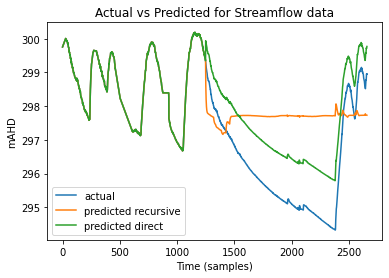

In [ ]:
x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
plt.figure()
plt.plot(x_data, actual, label='actual')
plt.plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
plt.plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
plt.ylabel('mAHD')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted for Streamflow data')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_17_post_2017

1.1876498029082547

In [ ]:
Best_RMSE_streamflow_17_recursive

2.0317342850790787

In [ ]:
# Attempt at merging the weather data and groundwater data
m1 = pd.merge(weather_data, BH_17, on='Date and Time').drop(['Unnamed: 2', 'Unnamed: 3'], axis=1).interpolate('ffill').dropna(axis=0)


In [ ]:
sns.heatmap(weather_data.corr());

In [ ]:
# Useless autocorrelation plot
plt.title("Autocorrelation Plot")
plt.xlabel("Lags")
plt.acorr(m1['mAHD'], maxlags = 3000)

# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show()

In [ ]:
# Useless autocorrelation plot for BH_19
plt.title("Autocorrelation Plot")
plt.xlabel("Lags")
plt.acorr(BH_19_daily['mAHD'].interpolate('ffill').dropna(axis=0), maxlags = 2000)
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.grid(True)
 
plt.show()

In [ ]:
pd.plotting.autocorrelation_plot(BH_19_daily['mAHD'].interpolate('ffill').dropna(axis=0))


In [ ]:
# Groundwater interpolated
plt.plot(m1['mAHD'] )
plt.show()

In [ ]:
plt.plot(BH_18['Date and Time'], BH_18['mAHD'] )
plt.plot(BH_19['Date and Time'], BH_19['mAHD'] )
plt.show()

In [ ]:
plt.plot(BH_17['Date and Time'], BH_17['mAHD'] )

In [ ]:
BH_17_2017 = BH_17[BH_17['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_2017 = BH_18[BH_18['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_2017 = BH_19[BH_19['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_2017 = BH_19_2017.drop(['Unnamed: 2'], axis=1).dropna(axis=0)
BH_18_2017 = BH_18_2017.drop(['Unnamed: 2'], axis=1).dropna(axis=0)
BH_17_2017 = BH_17_2017.drop(['Unnamed: 2'], axis=1).dropna(axis=0)


In [ ]:
plt.plot(BH_19_2017['Date and Time'], BH_19_2017['mAHD'] )

In [ ]:
BH_19_2017['year'] = [d.year for d in BH_19_2017['Date and Time']]
BH_19_2017['month'] = [d.strftime('%b') for d in BH_19_2017['Date and Time']]
years_19 = BH_19_2017['year'].unique()

BH_18_2017['year'] = [d.year for d in BH_18_2017['Date and Time']]
BH_18_2017['month'] = [d.strftime('%b') for d in BH_18_2017['Date and Time']]
years_18 = BH_18_2017['year'].unique()

BH_17_2017['year'] = [d.year for d in BH_17_2017['Date and Time']]
BH_17_2017['month'] = [d.strftime('%b') for d in BH_17_2017['Date and Time']]
years_17 = BH_17_2017['year'].unique()

summary_19 = BH_19_2017.groupby([ 'year','month'], sort=False, as_index=False).mean()
summary_18 = BH_18_2017.groupby([ 'year','month'], sort=False, as_index=False).mean()
summary_17 = BH_17_2017.groupby([ 'year','month'], sort=False, as_index=False).mean()

In [ ]:

# Prep Colors
np.random.seed(100)
mycolors_1 = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years_19), replace=False)
mycolors_2 = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years_18), replace=False)
mycolors_3 = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years_17), replace=False)


# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years_19):
    if (i > 0):        
        plt.plot('month', 'mAHD', data=summary_19.loc[summary_19.year==y, :], color=mycolors_1[i], label=y)
        plt.text(summary_19.loc[summary_19.year==y, :].shape[0]-.9, summary_19.loc[summary_19.year==y, 'mAHD'][-1:].values[0], y, fontsize=12, color=mycolors_1[i])

for i, y in enumerate(years_18):
    if (i > 0):        
        plt.plot('month', 'mAHD', data=summary_18.loc[summary_18.year==y, :], color=mycolors_2[i], label=y)
        plt.text(summary_18.loc[summary_18.year==y, :].shape[0]-.9, summary_18.loc[summary_18.year==y, 'mAHD'][-1:].values[0], y, fontsize=12, color=mycolors_2[i])
        
for i, y in enumerate(years_17):
    if (i > 0):        
        plt.plot('month', 'mAHD', data=summary_17.loc[summary_17.year==y, :], color=mycolors_3[i], label=y)
        plt.text(summary_17.loc[summary_17.year==y, :].shape[0]-.9, summary_17.loc[summary_17.year==y, 'mAHD'][-1:].values[0], y, fontsize=12, color=mycolors_3[i])
        
        
# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(293,301), ylabel='$mAHD$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Ground-water levels Time Series", fontsize=20)
plt.show()

In [ ]:
BH_19_adjusted = BH_19.drop(['Unnamed: 2'], axis=1).interpolate('ffill').dropna(axis=0)
BH_19_interpolated = BH_19_adjusted.set_index('Date and Time')
BH_19_interpolated = BH_19_interpolated[~BH_19_interpolated.index.duplicated()]
BH_19_interpolated

In [ ]:
result_mul = seasonal_decompose(BH_19_interpolated['mAHD'].asfreq(freq='15T').interpolate(), model='multiplicative', extrapolate_trend='freq', freq=35040)

# Additive Decomposition
result_add = seasonal_decompose(BH_19_interpolated['mAHD'].asfreq(freq='15T').interpolate(), model='additive', extrapolate_trend='freq', freq=35040)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

## LSTM Model

In [ ]:
new_temp = BH_19_adjusted[BH_19_adjusted['Date and Time'].dt.date>=datetime.date(2017,1,1)]


In [ ]:
start = list(new_temp['mAHD'][:n_steps_in])

prev = new_temp['mAHD'][:n_steps_in].to_numpy().reshape(1,n_steps_in,1)
for i in range(2850):
  prev = lstm_model.predict(prev)
  start.extend(list(prev[0]))
  



In [ ]:
predictions_post_2017 = pd.DataFrame(start)[:67703]

In [ ]:
predictions_post_2017['Date and Time'] = list(new_temp['Date and Time'])
predictions_post_2017 = predictions_post_2017.rename(columns={0: 'mAHD'})

In [ ]:
plt.figure()
plt.plot(predictions_post_2017['Date and Time'], predictions_post_2017['mAHD'], label='predicted')
plt.plot(predictions_post_2017['Date and Time'], new_temp['mAHD'], label='actual')
plt.ylabel('RMSE')  
plt.xlabel('Time (samples)') 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()
plt.close()

In [ ]:
Overall_Analysis=np.zeros([42,10+n_steps_out*5])

In [ ]:
# def Plot_Mean(name,Overall_Analysis,n_steps_out):
#     labels = ['TrainRMSE(Mean)','TestRMSE(Mean)']
#     MLP_Adam=[Overall_Analysis[0][0],Overall_Analysis[0][5]]
#     MLP_Sgd=[Overall_Analysis[1][0],Overall_Analysis[1][5]]
#     LSTM=[Overall_Analysis[2][0],Overall_Analysis[2][5]]
#     Bi_LSTM=[Overall_Analysis[3][0],Overall_Analysis[3][5]]
#     EN_DC=[Overall_Analysis[4][0],Overall_Analysis[4][5]]
#     RNN=[Overall_Analysis[5][0],Overall_Analysis[5][5]]
#     CNN=[Overall_Analysis[6][0],Overall_Analysis[6][5]]
    
#     yer1=np.array([Overall_Analysis[0][3]-Overall_Analysis[0][0],Overall_Analysis[0][8]-Overall_Analysis[0][5]])
#     yer2=np.array([Overall_Analysis[1][3]-Overall_Analysis[1][0],Overall_Analysis[1][8]-Overall_Analysis[1][5]])
#     yer3=np.array([Overall_Analysis[2][3]-Overall_Analysis[2][0],Overall_Analysis[2][8]-Overall_Analysis[2][5]])
#     yer4=np.array([Overall_Analysis[3][3]-Overall_Analysis[3][0],Overall_Analysis[3][8]-Overall_Analysis[3][5]])
#     yer5=np.array([Overall_Analysis[4][3]-Overall_Analysis[4][0],Overall_Analysis[4][8]-Overall_Analysis[4][5]])
#     yer6=np.array([Overall_Analysis[5][3]-Overall_Analysis[5][0],Overall_Analysis[5][8]-Overall_Analysis[5][5]])
#     yer7=np.array([Overall_Analysis[6][3]-Overall_Analysis[6][0],Overall_Analysis[6][8]-Overall_Analysis[6][5]])
    
#     width = 0.12  # the width of the bars
#     Plot(name,labels,width,MLP_Adam,MLP_Sgd,LSTM,Bi_LSTM,EN_DC,RNN,CNN,yer1,yer2,yer3,yer4,yer5,yer6,yer7,"","","Train&Test_RMSE_Mean_Comparison",4)

# def Plot_Step_RMSE_Mean(name,Overall_Analysis,n_steps_out):
#     MLP_Adam=Overall_Analysis[0,10:n_steps_out*5+10:5]
#     MLP_Sgd=Overall_Analysis[1,10:n_steps_out*5+10:5]
#     LSTM=Overall_Analysis[2,10:n_steps_out*5+10:5]
#     Bi_LSTM=Overall_Analysis[3,10:n_steps_out*5+10:5]
#     EN_DC=Overall_Analysis[4,10:n_steps_out*5+10:5]
#     RNN=Overall_Analysis[5,10:n_steps_out*5+10:5]
#     CNN=Overall_Analysis[6,10:n_steps_out*5+10:5]
#     yer1=np.subtract(Overall_Analysis[0,13:n_steps_out*5+10:5],MLP_Adam)
#     yer2=np.subtract(Overall_Analysis[1,13:n_steps_out*5+10:5],MLP_Sgd)
#     yer3=np.subtract(Overall_Analysis[2,13:n_steps_out*5+10:5],LSTM)
#     yer4=np.subtract(Overall_Analysis[3,13:n_steps_out*5+10:5],Bi_LSTM)
#     yer5=np.subtract(Overall_Analysis[4,13:n_steps_out*5+10:5],EN_DC)
#     yer6=np.subtract(Overall_Analysis[5,13:n_steps_out*5+10:5],RNN)
#     yer7=np.subtract(Overall_Analysis[6,13:n_steps_out*5+10:5],CNN)
#     labels = []
#     for j in range(n_steps_out):
#         labels=np.concatenate((labels,[str(j+1)]))
#     width = 0.12  # the width of the bars
#     Plot(name,labels,width,MLP_Adam,MLP_Sgd,LSTM,Bi_LSTM,EN_DC,RNN,CNN,yer1,yer2,yer3,yer4,yer5,yer6,yer7,"Steps","RMSE(Mean)","Step_RMSE_Comparison",2)
    

# def Plot(name,labels,width,MLP_Adam,MLP_Sgd,LSTM,Bi_LSTM,EN_DC,RNN,CNN,yer1,yer2,yer3,yer4,yer5,yer6,yer7,xlabel,ylabel,Gname,cap):
#     r1 = np.arange(len(labels))
#     r2 = [x + width for x in r1]
#     r3 = [x + width for x in r2]
#     r4 = [x + width for x in r3]
#     r5 = [x + width for x in r4]
#     r6 = [x + width for x in r5]
#     r7 = [x + width for x in r6]

#     fig, ax = plt.subplots()
#     rects1 = ax.bar(r1, MLP_Adam, width,edgecolor = 'black', yerr=yer1, capsize=cap, label='FNN-Adam')
#     rects2 = ax.bar(r2, MLP_Sgd, width,edgecolor = 'black', yerr=yer2,capsize=cap,  label='FNN-SGD')
#     rects3 = ax.bar(r3, LSTM, width,edgecolor = 'black', yerr=yer3,capsize=cap,  label='LSTM')
#     rects4 = ax.bar(r4, Bi_LSTM, width,edgecolor = 'black', yerr=yer4,capsize=cap,  label='BD-LSTM')
#     rects5 = ax.bar(r5, EN_DC, width,edgecolor = 'black', yerr=yer5,capsize=cap,  label='ED-LSTM')
#     rects6 = ax.bar(r6, RNN, width,edgecolor = 'black', yerr=yer6,capsize=cap,  label='RNN')
#     rects7 = ax.bar(r7, CNN, width,edgecolor = 'black', yerr=yer7,capsize=cap,  label='CNN')
    
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.xticks([r + width for r in range(len(MLP_Adam))], labels)
#     plt.setp(ax.get_xticklabels(), fontsize=8)
#     ax.legend()
#     fig.tight_layout()
#     plt.savefig("Results/"+name+"/"+Gname+".png",dpi=300)
#     plt.show()

In [ ]:

# arr = np.dstack((train_acc,test_acc))
# arr=arr.reshape(Num_Exp,2)
# arr=np.concatenate((arr,Step_RMSE), axis=1)
# arr=arr.reshape(Num_Exp,2+n_steps_out)

# ExpIndex=np.array([])
# for j in range(Num_Exp):
#   ExpIndex=np.concatenate((ExpIndex,["Exp"+str(j+1)]))

# ExpIndex1=['TrainRMSE','TestRMSE']
# for j in range(n_steps_out):
#   ExpIndex1=np.concatenate((ExpIndex1,["Step"+str(j+1)]))

# arr=np.round_(arr, decimals = 5) 
# arr = pd.DataFrame(arr, index = ExpIndex , columns = ExpIndex1)
# arr.to_csv(name+"_"+Mname+"ExpAnalysis.csv")
# print(arr)

# Train_Mean=np.mean(train_acc)
# Train_Std=np.std(train_acc)
# Train_CI_LB= Train_Mean-1.96*(Train_Std/np.sqrt(Num_Exp))
# Train_CI_UB= Train_Mean+1.96*(Train_Std/np.sqrt(Num_Exp))

# Test_Mean=np.mean(test_acc)
# Test_Std=np.std(test_acc)
# Test_CI_LB= Test_Mean-1.96*(Test_Std/np.sqrt(Num_Exp))
# Test_CI_UB= Test_Mean+1.96*(Test_Std/np.sqrt(Num_Exp))

# Overall_Analysis[(i-1)*7+(k-1)][0]=Train_Mean
# Overall_Analysis[(i-1)*7+(k-1)][1]=Train_Std
# Overall_Analysis[(i-1)*7+(k-1)][2]=Train_CI_LB
# Overall_Analysis[(i-1)*7+(k-1)][3]=Train_CI_UB
# Overall_Analysis[(i-1)*7+(k-1)][4]=np.min(train_acc)
# Overall_Analysis[(i-1)*7+(k-1)][5]=Test_Mean
# Overall_Analysis[(i-1)*7+(k-1)][6]=Test_Std
# Overall_Analysis[(i-1)*7+(k-1)][7]=Test_CI_LB
# Overall_Analysis[(i-1)*7+(k-1)][8]=Test_CI_UB
# Overall_Analysis[(i-1)*7+(k-1)][9]=np.min(test_acc)

# arr1 = np.vstack(([Train_Mean,Train_Std,Train_CI_LB,Train_CI_UB,np.min(train_acc),np.max(train_acc)],[Test_Mean,Test_Std,Test_CI_LB,Test_CI_UB,np.min(test_acc),np.max(test_acc)]))

# for j in range(n_steps_out):
#   Step_mean = np.mean(Step_RMSE[:,j])
#   Step_std = np.std(Step_RMSE[:,j])
#   Step_min = np.min(Step_RMSE[:,j])
#   Step_CI_LB= Step_mean-1.96*(Step_std/np.sqrt(Num_Exp))
#   Step_CI_UB= Step_mean+1.96*(Step_std/np.sqrt(Num_Exp))
#   arr1=np.vstack((arr1,[Step_mean,Step_std,Step_CI_LB,Step_CI_UB,Step_min,np.max(Step_RMSE[:,j])]))
#   Overall_Analysis[(i-1)*7+(k-1)][5*j+10]= Step_mean
#   Overall_Analysis[(i-1)*7+(k-1)][5*j+11]= Step_std
#   Overall_Analysis[(i-1)*7+(k-1)][5*j+12]= Step_CI_LB
#   Overall_Analysis[(i-1)*7+(k-1)][5*j+13]= Step_CI_UB
#   Overall_Analysis[(i-1)*7+(k-1)][5*j+14]= Step_min
#   arr1=np.round_(arr1, decimals = 5) 
#   arr1 = pd.DataFrame(arr1, index=ExpIndex1, columns = ['Mean','Standard Deviation','CI_LB','CI_UB','Min','Max'])
#   print(arr1)
#   arr1.to_csv(name+"_"+Mname+"/OverallAnalysis.csv")


# x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
# for j in range(n_steps_out):
#   plt.figure()
#   plt.plot(x_data, y_test[:,j], label='actual')
#   plt.plot(x_data, Best_Predict_Test[:,j], label='predicted')
#   plt.ylabel('RMSE')  
#   plt.xlabel('Time (samples)') 
#   plt.title('Actual vs Predicted')
#   plt.legend()
#   plt.savefig(name+"_"+Mname+'/pred_Step'+str(j+1)+'.png',dpi=300) 
#   plt.show()
#   plt.close()



# #Plot mean of train_RMSE and test_RMSE
# #Plot Std of train_RMSE and test_RMSE
# Plot_Mean(name,Overall_Analysis[7*(i-1):(7*i),:],n_steps_out)
# #Plot Step wise RMSE mean for different methods
# Plot_Step_RMSE_Mean(name,Overall_Analysis[7*(i-1):(7*i),:],n_steps_out)


In [ ]:
# Overall_Analysis=Overall_Analysis.astype('float64')
# Overall_Analysis=np.round_(Overall_Analysis, decimals = 4)  
# Index1=[]
# for j in range(7):
#     Index1=np.concatenate((Index1, ['FNN-Adam','FNN-SGD','LSTM','BD-LSTM','ED-LSTM','RNN','CNN']))
# Index2=["Lazer","Sunspot","Mackey","Lorenz","Rossler","Henon","ACFinance"]
# Index2=np.repeat(Index2,7)
# Index=np.dstack((Index2,Index1))
# Index=Index.reshape(49,2)
# Column=['Dataset','Method','Train-RMSE-Mean','Train-RMSE-Std','Train-CI-LB','Train-CI-UB','TrainRMSE-Min','Test-RMSE-Mean','Test-RMSE-Std','Test-CI-LB','Test-CI-UB','Test-RMSE-Min']
# for j in range(1,11):
#     Column=np.concatenate((Column, ['Step'+str(j)+'-RMSE-Mean','Step'+str(j)+'-RMSE-Std','Step'+str(j)+'-CI-LB','Step'+str(j)+'-CI-UB','Step'+str(j)+'-RMSE-Min']))

# Overall_Analysis=np.concatenate((Index,Overall_Analysis), axis=1)
# Overall_Analysis = pd.DataFrame(Overall_Analysis, columns = Column)
# print(Overall_Analysis)
# Overall_Analysis.to_csv("Results/OverallAnalysis.csv")


# Batch model 

## LSTM model

### Discretised Streamflow

In [ ]:
in_seq1_19 = array(m19_daily['discretised_flow'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1_19 = in_seq1_19.reshape((len(in_seq1_19), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1_19, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017_19 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017_19 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train_19 = X[0:num_pre_2017_19]
x_test_19 = X[num_pre_2017_19:]

y_train_19 = y[0:num_pre_2017_19]
y_test_19 = y[num_pre_2017_19:]
n_features = X.shape[2]


###############################################################################################
in_seq1_18 = array(m18_daily['discretised_flow'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1_18 = in_seq1_18.reshape((len(in_seq1_18), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1_18, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017_18 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017_18 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train_18 = X[0:num_pre_2017_18]
x_test_18 = X[num_pre_2017_18:]

y_train_18 = y[0:num_pre_2017_18]
y_test_18 = y[num_pre_2017_18:]
n_features = X.shape[2]

##############################################################################################
in_seq1_17 = array(m17_daily['discretised_flow'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1_17 = in_seq1_17.reshape((len(in_seq1_17), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1_17, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017_17 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017_17 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train_17 = X[0:num_pre_2017_17]
x_test_17 = X[num_pre_2017_17:]

y_train_17 = y[0:num_pre_2017_17]
y_test_17 = y[num_pre_2017_17:]
n_features = X.shape[2]

x_train = np.concatenate([x_train_17,x_train_18,x_train_19])
#x_test = np.concatenate([x_train_17,x_train_18,x_train_19])

y_train = np.concatenate([y_train_17,y_train_18,y_train_19])
#y_test = np.concatenate([y_test_17,y_test_18,y_test_19])

x_train, y_train = shuffle(x_train,y_train)

In [ ]:
streamflow_discretised_post_2017_19 = in_seq1_19[num_pre_2017_19:]
streamflow_discretised_post_2017_18 = in_seq1_18[num_pre_2017_18:]
streamflow_discretised_post_2017_17 = in_seq1_17[num_pre_2017_17:]

Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_discretised_recursive_batch_17=np.zeros(Num_Exp)
test_acc_streamflow_discretised_recursive_batch_17=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_recursive_batch_17=np.zeros([Num_Exp,n_steps_out])

train_acc_streamflow_discretised_recursive_batch_18=np.zeros(Num_Exp)
test_acc_streamflow_discretised_recursive_batch_18=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_recursive_batch_18=np.zeros([Num_Exp,n_steps_out])

train_acc_streamflow_discretised_recursive_batch_19=np.zeros(Num_Exp)
test_acc_streamflow_discretised_recursive_batch_19=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_recursive_batch_19=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_recursive = Sequential()
model_streamflow_discretised_recursive.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_recursive.add(Dense(n_steps_out))
model_streamflow_discretised_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_recursive.summary()
Best_RMSE_streamflow_discretised_recursive_batch_17=1000   #Assigning a large number 
Best_RMSE_streamflow_discretised_recursive_batch_18=1000   #Assigning a large number 
Best_RMSE_streamflow_discretised_recursive_batch_19=1000   #Assigning a large number 


outputs_streamflow_discretised_recursive_batch_17 = np.ones((Num_Exp, y_test_17.shape[0]))
outputs_streamflow_discretised_recursive_batch_18 = np.ones((Num_Exp, y_test_18.shape[0]))
outputs_streamflow_discretised_recursive_batch_19 = np.ones((Num_Exp, y_test_19.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_recursive
    #batch_size=64, 
    model_streamflow_discretised_recursive.fit(x_train, y_train, epochs=Epochs, verbose=0, batch_size=64, shuffle=False)
    y_predicttrain_17 = model_streamflow_discretised_recursive.predict(x_train).flatten()
    y_predicttest_17 = predict_recursively(model_streamflow_discretised_recursive, x_test_17[0][:,1], streamflow_discretised_post_2017_17,num_post_2017_17-3, 3)
    train_acc_streamflow_discretised_recursive_batch_17[run] = rmse( y_predicttrain_17,y_train) 
    test_acc_streamflow_discretised_recursive_batch_17[run] = rmse( y_predicttest_17, y_test_17) 

    print("RMSE value 17:", test_acc_streamflow_discretised_recursive_batch_17[run]) 
    if test_acc_streamflow_discretised_recursive_batch_17[run]<Best_RMSE_streamflow_discretised_recursive_batch_17:
        Best_RMSE_streamflow_discretised_recursive_batch_17=test_acc_streamflow_discretised_recursive_batch_17[run]
        Best_Predict_Test_streamflow_discretised_recursive_batch_17=y_predicttest_17
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_recursive_batch_17[run]=rmse(y_predicttest_17[:], y_test_17[:])

    y_predicttrain_18 = model_streamflow_discretised_recursive.predict(x_train).flatten()
    y_predicttest_18 = predict_recursively(model_streamflow_discretised_recursive, x_test_18[0][:,1], streamflow_discretised_post_2017_18,num_post_2017_18-3, 3)
    train_acc_streamflow_discretised_recursive_batch_18[run] = rmse( y_predicttrain_18,y_train) 
    test_acc_streamflow_discretised_recursive_batch_18[run] = rmse( y_predicttest_18, y_test_18) 

    y_predicttrain_19 = model_streamflow_discretised_recursive.predict(x_train).flatten()
    y_predicttest_19 = predict_recursively(model_streamflow_discretised_recursive, x_test_19[0][:,1], streamflow_discretised_post_2017_19,num_post_2017_19-3, 3)
    train_acc_streamflow_discretised_recursive_batch_19[run] = rmse( y_predicttrain_19,y_train) 
    test_acc_streamflow_discretised_recursive_batch_19[run] = rmse( y_predicttest_19, y_test_19) 

    outputs_streamflow_discretised_recursive_batch_17[run,] = y_predicttest_17
    outputs_streamflow_discretised_recursive_batch_18[run,] = y_predicttest_18
    outputs_streamflow_discretised_recursive_batch_19[run,] = y_predicttest_19

  

    print("RMSE value 18:", test_acc_streamflow_discretised_recursive_batch_18[run]) 
    if test_acc_streamflow_discretised_recursive_batch_18[run]<Best_RMSE_streamflow_discretised_recursive_batch_18:
        Best_RMSE_streamflow_discretised_recursive_batch_18=test_acc_streamflow_discretised_recursive_batch_18[run]
        Best_Predict_Test_streamflow_discretised_recursive_batch_18=y_predicttest_18
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_recursive_batch_18[run]=rmse(y_predicttest_18[:], y_test_18[:])   
    
    print("RMSE value 19:", test_acc_streamflow_discretised_recursive_batch_19[run]) 
    if test_acc_streamflow_discretised_recursive_batch_19[run]<Best_RMSE_streamflow_discretised_recursive_batch_19:
        Best_RMSE_streamflow_discretised_recursive_batch_19=test_acc_streamflow_discretised_recursive_batch_19[run]
        Best_Predict_Test_streamflow_discretised_recursive_batch_19=y_predicttest_19
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_recursive_batch_17[run]=rmse(y_predicttest_17[:], y_test_17[:])   
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                520       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value 17: 4.84880329150198
RMSE value 18: 2.9316923008683915
RMSE value 19: 2.644801292141373
Experiment 2 in progress
RMSE value 17: 4.491724613779495
RMSE value 18: 3.1184287575173752
RMSE value 19: 2.887878667148026
Experiment 3 in progress
RMSE value 17: 4.6513839805492125
RMSE value 18: 5.135784613479162
RMSE value 19: 5.124032311525664
Experiment 4 in progress
RMSE value 17: 31.19103492766715
RMSE value 18: 47.00

In [ ]:
streamflow_discretised_post_2017_batch_19 = in_seq1_19[num_pre_2017_19:]
streamflow_discretised_post_2017_batch_18 = in_seq1_18[num_pre_2017_18:]
streamflow_discretised_post_2017_batch_17 = in_seq1_17[num_pre_2017_17:]

Num_Exp = 30  
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_discretised_post_2017_batch_17=np.zeros(Num_Exp)
test_acc_streamflow_discretised_post_2017_batch_17=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_post_2017_batch_17=np.zeros([Num_Exp,n_steps_out])

train_acc_streamflow_discretised_post_2017_batch_18=np.zeros(Num_Exp)
test_acc_streamflow_discretised_post_2017_batch_18=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_post_2017_batch_18=np.zeros([Num_Exp,n_steps_out])

train_acc_streamflow_discretised_post_2017_batch_19=np.zeros(Num_Exp)
test_acc_streamflow_discretised_post_2017_batch_19=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_post_2017_batch_19=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_post_2017 = Sequential()
model_streamflow_discretised_post_2017.add(LSTM(Hidden, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_post_2017.add(Dense(n_steps_out))
model_streamflow_discretised_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_post_2017.summary()
Best_RMSE_streamflow_discretised_post_2017_batch_17=1000   #Assigning a large number 
Best_RMSE_streamflow_discretised_post_2017_batch_18=1000   #Assigning a large number 
Best_RMSE_streamflow_discretised_post_2017_batch_19=1000   #Assigning a large number 


outputs_streamflow_discretised_post_2017_batch_17 = np.ones((Num_Exp, y_test_17.shape[0]))
outputs_streamflow_discretised_post_2017_batch_18 = np.ones((Num_Exp, y_test_18.shape[0]))
outputs_streamflow_discretised_post_2017_batch_19 = np.ones((Num_Exp, y_test_19.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_post_2017
    #batch_size=64, 
    model_streamflow_discretised_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, batch_size=64, shuffle=False)
    y_predicttrain_17 = model_streamflow_discretised_post_2017.predict(x_train).flatten()
    y_predicttest_17 = model_streamflow_discretised_post_2017.predict(x_test_17).flatten()
    train_acc_streamflow_discretised_post_2017_batch_17[run] = rmse( y_predicttrain_17,y_train) 
    test_acc_streamflow_discretised_post_2017_batch_17[run] = rmse( y_predicttest_17, y_test_17) 

    print("RMSE value 17:", test_acc_streamflow_discretised_post_2017_batch_17[run]) 
    if test_acc_streamflow_discretised_post_2017_batch_17[run]<Best_RMSE_streamflow_discretised_post_2017_batch_17:
        Best_RMSE_streamflow_discretised_post_2017_batch_17=test_acc_streamflow_discretised_post_2017_batch_17[run]
        Best_Predict_Test_streamflow_discretised_post_2017_batch_17=y_predicttest_17
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_post_2017_batch_17[run]=rmse(y_predicttest_17[:], y_test_17[:])

    y_predicttrain_18 = model_streamflow_discretised_post_2017.predict(x_train).flatten()
    y_predicttest_18 = model_streamflow_discretised_post_2017.predict(x_test_18).flatten()
    train_acc_streamflow_discretised_post_2017_batch_18[run] = rmse( y_predicttrain_18,y_train) 
    test_acc_streamflow_discretised_post_2017_batch_18[run] = rmse( y_predicttest_18, y_test_18) 

    print("RMSE value 18:", test_acc_streamflow_discretised_post_2017_batch_18[run]) 
    if test_acc_streamflow_discretised_post_2017_batch_18[run]<Best_RMSE_streamflow_discretised_post_2017_batch_18:
        Best_RMSE_streamflow_discretised_post_2017_batch_18=test_acc_streamflow_discretised_post_2017_batch_18[run]
        Best_Predict_Test_streamflow_discretised_post_2017_batch_18=y_predicttest_18
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_post_2017_batch_18[run]=rmse(y_predicttest_18[:], y_test_18[:])   

    y_predicttrain_19 = model_streamflow_discretised_post_2017.predict(x_train).flatten()
    y_predicttest_19 = model_streamflow_discretised_post_2017.predict(x_test_19).flatten()
    train_acc_streamflow_discretised_post_2017_batch_19[run] = rmse( y_predicttrain_19,y_train) 
    test_acc_streamflow_discretised_post_2017_batch_19[run] = rmse( y_predicttest_19, y_test_19) 

    outputs_streamflow_discretised_post_2017_batch_17[run,] = y_predicttest_17
    outputs_streamflow_discretised_post_2017_batch_18[run,] = y_predicttest_18
    outputs_streamflow_discretised_post_2017_batch_19[run,] = y_predicttest_19

    print("RMSE value 19:", test_acc_streamflow_discretised_post_2017_batch_19[run]) 
    if test_acc_streamflow_discretised_post_2017_batch_19[run]<Best_RMSE_streamflow_discretised_post_2017_batch_19:
        Best_RMSE_streamflow_discretised_post_2017_batch_19=test_acc_streamflow_discretised_post_2017_batch_19[run]
        Best_Predict_Test_streamflow_discretised_post_2017_batch_19=y_predicttest_19
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_post_2017_batch_17[run]=rmse(y_predicttest_17[:], y_test_17[:])   
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10)                520       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
RMSE value 17: 0.0813368441409939
RMSE value 18: 0.1717358652662272
RMSE value 19: 0.05469056854455879
Experiment 2 in progress
RMSE value 17: 0.08131557393144226
RMSE value 18: 0.17115374700910707
RMSE value 19: 0.0541473995525861
Experiment 3 in progress
RMSE value 17: 0.08119596740610466
RMSE value 18: 0.17046676222086052
RMSE value 19: 0.05340605589095843
Experiment 4 in progress
RMSE value 17: 0.0810561482571986
RMSE v

In [ ]:
# outputs_streamflow_post_2017_17_1 = outputs_streamflow_post_2017_17[5:]
# outputs_streamflow_post_2017_18_1 = outputs_streamflow_post_2017_18[5:]
# outputs_streamflow_post_2017_19_1 = outputs_streamflow_post_2017_19[5:]
# outputs_streamflow_post_2017_batch_19 = outputs_streamflow_post_2017_19
# outputs_streamflow_post_2017_batch_18 = outputs_streamflow_post_2017_18
# outputs_streamflow_post_2017_batch_17 = outputs_streamflow_post_2017_17

In [ ]:
fx_high_post_2017_17 = np.percentile(outputs_streamflow_discretised_post_2017_batch_17, 95, axis=0)
fx_low_post_2017_17 = np.percentile(outputs_streamflow_discretised_post_2017_batch_17, 5, axis=0)
fx_mid_post_2017_17 = np.percentile(outputs_streamflow_discretised_post_2017_batch_17, 50, axis=0)
fx_high_recursive_17 = np.percentile(outputs_streamflow_discretised_recursive_batch_17, 95, axis=0)
fx_low_recursive_17 = np.percentile(outputs_streamflow_discretised_recursive_batch_17, 5, axis=0)
fx_mid_recursive_17 = np.percentile(outputs_streamflow_discretised_recursive_batch_17, 50, axis=0)
in_between_percentage_streamflow_discretised_recursive_batch_17 = np.count_nonzero(np.less(fx_low_recursive_17,y_test_17) & np.greater_equal(fx_high_recursive_17,y_test_17) )/len(y_test_17)
in_between_percentage_streamflow_discretised_recursive_batch_17

fx_high_post_2017_18 = np.percentile(outputs_streamflow_discretised_post_2017_batch_18, 95, axis=0)
fx_low_post_2017_18 = np.percentile(outputs_streamflow_discretised_post_2017_batch_18, 5, axis=0)
fx_mid_post_2017_18 = np.percentile(outputs_streamflow_discretised_post_2017_batch_18, 50, axis=0)
fx_high_recursive_18 = np.percentile(outputs_streamflow_discretised_recursive_batch_18, 95, axis=0)
fx_low_recursive_18 = np.percentile(outputs_streamflow_discretised_recursive_batch_18, 5, axis=0)
fx_mid_recursive_18 = np.percentile(outputs_streamflow_discretised_recursive_batch_18, 50, axis=0)
in_between_percentage_streamflow_discretised_recursive_batch_18 = np.count_nonzero(np.less(fx_low_recursive_18,y_test_18) & np.greater_equal(fx_high_recursive_18,y_test_18) )/len(y_test_18)
in_between_percentage_streamflow_discretised_recursive_batch_18

fx_high_post_2017_19 = np.percentile(outputs_streamflow_discretised_post_2017_batch_19, 95, axis=0)
fx_low_post_2017_19 = np.percentile(outputs_streamflow_discretised_post_2017_batch_19, 5, axis=0)
fx_mid_post_2017_19 = np.percentile(outputs_streamflow_discretised_post_2017_batch_19, 50, axis=0)
fx_high_recursive_19 = np.percentile(outputs_streamflow_discretised_recursive_batch_19, 95, axis=0)
fx_low_recursive_19 = np.percentile(outputs_streamflow_discretised_recursive_batch_19, 5, axis=0)
fx_mid_recursive_19 = np.percentile(outputs_streamflow_discretised_recursive_batch_19, 50, axis=0)
in_between_percentage_streamflow_discretised_recursive_batch_19 = np.count_nonzero(np.less(fx_low_recursive_19,y_test_19) & np.greater_equal(fx_high_recursive_19,y_test_19) )/len(y_test_19)
in_between_percentage_streamflow_discretised_recursive_batch_19


0.16193181818181818

In [ ]:
in_between_percentage_streamflow_discretised_recursive_batch_17

0.0

In [ ]:
in_between_percentage_streamflow_discretised_recursive_batch_18

0.19673295454545456

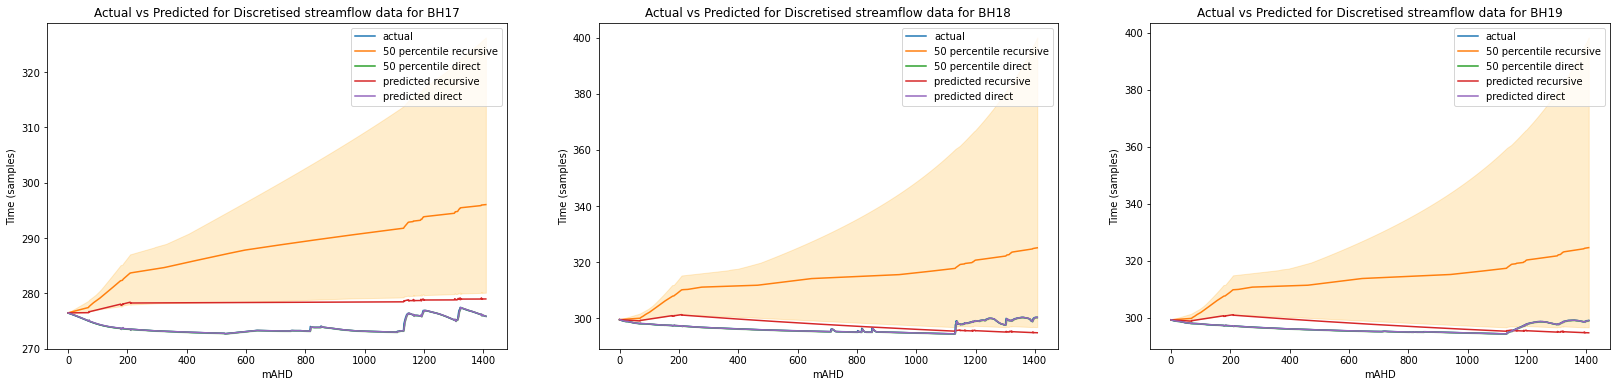

In [ ]:
plt.rcParams["figure.figsize"] = (28,6)


f,ax =plt.subplots(1,3)

x_data_17=np.linspace(0,y_test_17.shape[0], num=y_test_17.shape[0])
#plt.figure()
ax[0].plot(x_data_17, y_test_17[:], label='actual')
ax[0].plot(x_data_17, fx_mid_recursive_17[:], label='50 percentile recursive')
ax[0].plot(x_data_17, fx_mid_post_2017_17[:], label='50 percentile direct')
ax[0].plot(x_data_17, Best_Predict_Test_streamflow_discretised_recursive_batch_17[:], label='predicted recursive')
ax[0].plot(x_data_17, Best_Predict_Test_streamflow_discretised_post_2017_batch_17[:], label='predicted direct')
ax[0].fill_between(x_data_17, fx_low_recursive_17, fx_high_recursive_17, color='orange', alpha=0.2)
ax[0].fill_between(x_data_17, fx_low_post_2017_17, fx_high_post_2017_17, color='green', alpha=0.2)
ax[0].set(title='Actual vs Predicted for Discretised streamflow data for BH17', xlabel='mAHD',ylabel='Time (samples)')
#ax[0].title('Actual vs Predicted for Streamflow_discretised data for BH17')
ax[0].legend()

x_data_18=np.linspace(0,y_test_18.shape[0], num=y_test_18.shape[0])
ax[1].plot(x_data_18, y_test_18[:], label='actual')
ax[1].plot(x_data_18, fx_mid_recursive_18[:], label='50 percentile recursive')
ax[1].plot(x_data_18, fx_mid_post_2017_18[:], label='50 percentile direct')
ax[1].plot(x_data_18, Best_Predict_Test_streamflow_discretised_recursive_batch_18[:], label='predicted recursive')
ax[1].plot(x_data_18, Best_Predict_Test_streamflow_discretised_post_2017_batch_18[:], label='predicted direct')
ax[1].fill_between(x_data_18, fx_low_recursive_18, fx_high_recursive_18, color='orange', alpha=0.2)
ax[1].fill_between(x_data_18, fx_low_post_2017_18, fx_high_post_2017_18, color='green', alpha=0.2)
ax[1].set(title='Actual vs Predicted for Discretised streamflow data for BH18', xlabel='mAHD',ylabel='Time (samples)')
ax[1].legend()

x_data_19=np.linspace(0,y_test_19.shape[0], num=y_test_19.shape[0])
ax[2].plot(x_data_19, y_test_19[:], label='actual')
ax[2].plot(x_data_19, fx_mid_recursive_19[:], label='50 percentile recursive')
ax[2].plot(x_data_19, fx_mid_post_2017_19[:], label='50 percentile direct')
ax[2].plot(x_data_19, Best_Predict_Test_streamflow_discretised_recursive_batch_19[:], label='predicted recursive')
ax[2].plot(x_data_19, Best_Predict_Test_streamflow_discretised_post_2017_batch_19[:], label='predicted direct')
ax[2].fill_between(x_data_19, fx_low_recursive_19, fx_high_recursive_19, color='orange', alpha=0.2)
ax[2].fill_between(x_data_19, fx_low_post_2017_19, fx_high_post_2017_19, color='green', alpha=0.2)
ax[2].set(title='Actual vs Predicted for Discretised streamflow data for BH19', xlabel='mAHD',ylabel='Time (samples)')
ax[2].legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_post_2017_batch.png',dpi=300) 
plt.show()
plt.close()

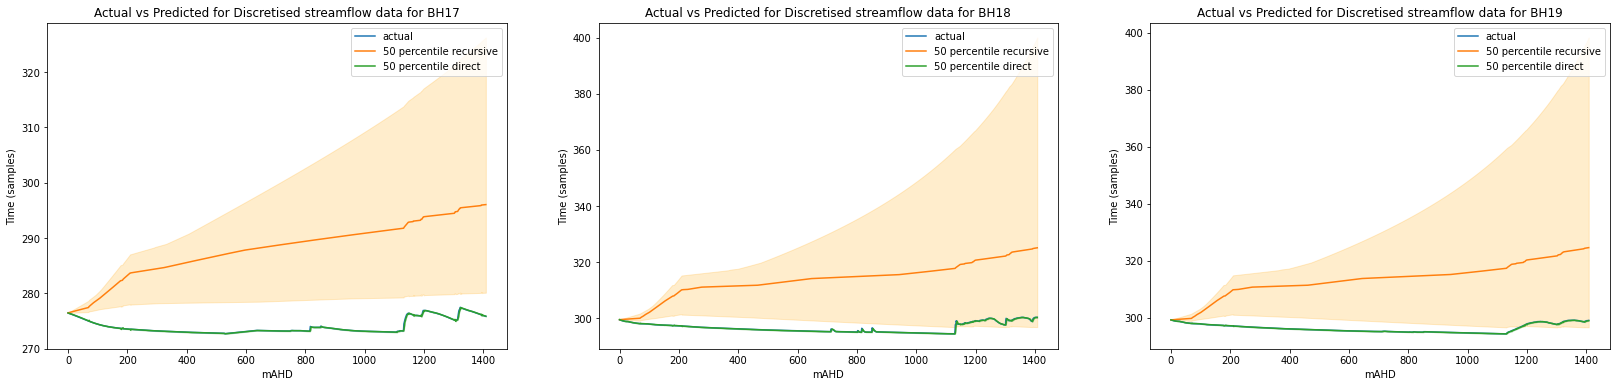

In [ ]:
f,ax =plt.subplots(1,3)

x_data=np.linspace(0,y_test_17.shape[0], num=y_test_17.shape[0])
#plt.figure()
ax[0].plot(x_data, y_test_17[:], label='actual')
ax[0].plot(x_data, fx_mid_recursive_17[:], label='50 percentile recursive')
ax[0].plot(x_data, fx_mid_post_2017_17[:], label='50 percentile direct')

ax[0].fill_between(x_data, fx_low_recursive_17, fx_high_recursive_17, color='orange', alpha=0.2)
ax[0].fill_between(x_data, fx_low_post_2017_17, fx_high_post_2017_17, color='green', alpha=0.2)
ax[0].set(title='Actual vs Predicted for Discretised streamflow data for BH17', xlabel='mAHD',ylabel='Time (samples)')
ax[0].legend()

x_data=np.linspace(0,y_test_18.shape[0], num=y_test_18.shape[0])
#plt.figure()
ax[1].plot(x_data, y_test_18[:], label='actual')
ax[1].plot(x_data, fx_mid_recursive_18[:], label='50 percentile recursive')
ax[1].plot(x_data, fx_mid_post_2017_18[:], label='50 percentile direct')

ax[1].fill_between(x_data, fx_low_recursive_18, fx_high_recursive_18, color='orange', alpha=0.2)
ax[1].fill_between(x_data, fx_low_post_2017_18, fx_high_post_2017_18, color='green', alpha=0.2)
ax[1].set(title='Actual vs Predicted for Discretised streamflow data for BH18', xlabel='mAHD',ylabel='Time (samples)')
ax[1].legend()

x_data=np.linspace(0,y_test_19.shape[0], num=y_test_19.shape[0])
#plt.figure()
ax[2].plot(x_data, y_test_19[:], label='actual')
ax[2].plot(x_data, fx_mid_recursive_19[:], label='50 percentile recursive')
ax[2].plot(x_data, fx_mid_post_2017_19[:], label='50 percentile direct')

ax[2].fill_between(x_data, fx_low_recursive_19, fx_high_recursive_19, color='orange', alpha=0.2)
ax[2].fill_between(x_data, fx_low_post_2017_19, fx_high_post_2017_19, color='green', alpha=0.2)
ax[2].set(title='Actual vs Predicted for Discretised streamflow data for BH19', xlabel='mAHD',ylabel='Time (samples)')
ax[2].legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_post_2017_50_only_batch.png',dpi=300) 
plt.show()
plt.close()

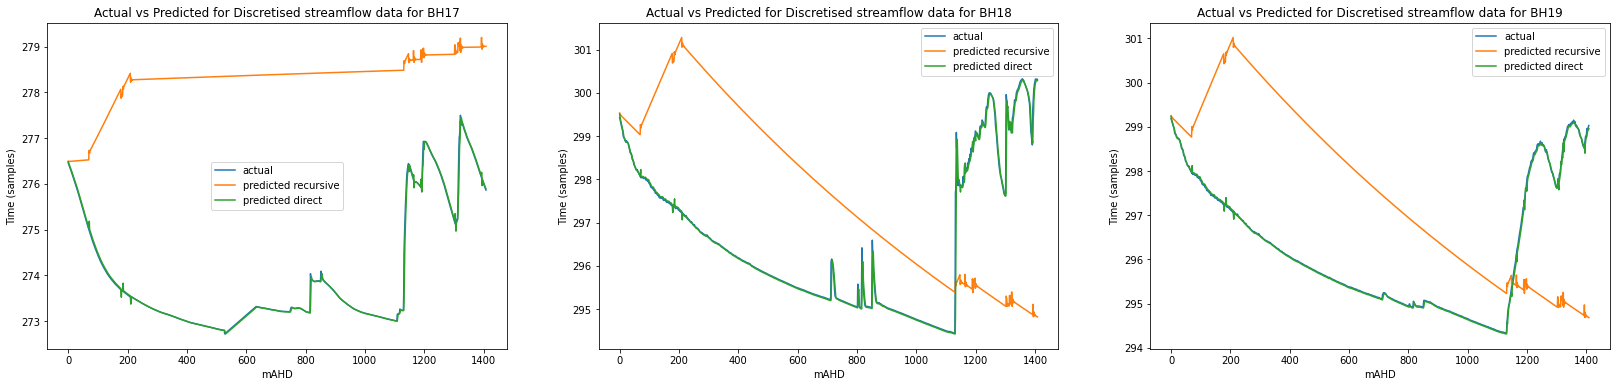

In [ ]:
f,ax =plt.subplots(1,3)

x_data=np.linspace(0,y_test_17.shape[0], num=y_test_17.shape[0])
#plt.figure()
ax[0].plot(x_data, y_test_17[:], label='actual')
ax[0].plot(x_data, Best_Predict_Test_streamflow_discretised_recursive_batch_17[:], label='predicted recursive')
ax[0].plot(x_data, Best_Predict_Test_streamflow_discretised_post_2017_batch_17[:], label='predicted direct')
ax[0].set(title='Actual vs Predicted for Discretised streamflow data for BH17', xlabel='mAHD',ylabel='Time (samples)')
ax[0].legend()

x_data=np.linspace(0,y_test_18.shape[0], num=y_test_18.shape[0])
#plt.figure()
ax[1].plot(x_data, y_test_18[:], label='actual')
ax[1].plot(x_data, Best_Predict_Test_streamflow_discretised_recursive_batch_18[:], label='predicted recursive')
ax[1].plot(x_data, Best_Predict_Test_streamflow_discretised_post_2017_batch_18[:], label='predicted direct')
ax[1].set(title='Actual vs Predicted for Discretised streamflow data for BH18', xlabel='mAHD',ylabel='Time (samples)')
ax[1].legend()

x_data=np.linspace(0,y_test_19.shape[0], num=y_test_19.shape[0])
#plt.figure()
ax[2].plot(x_data, y_test_19[:], label='actual')
ax[2].plot(x_data, Best_Predict_Test_streamflow_discretised_recursive_batch_19[:], label='predicted recursive')
ax[2].plot(x_data, Best_Predict_Test_streamflow_discretised_post_2017_batch_19[:], label='predicted direct')
ax[2].set(title='Actual vs Predicted for Discretised streamflow data for BH19', xlabel='mAHD',ylabel='Time (samples)')
ax[2].legend()


plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_post_2017_best_only_batch.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_post_2017_batch_19[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_recursive_batch_19[:])
actual_19 = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

BH_18_pre_2017 = m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_post_2017_batch_18[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_recursive_batch_18[:])
actual_18 = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_post_2017_batch_17[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_recursive_batch_17[:])
actual_17 = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])


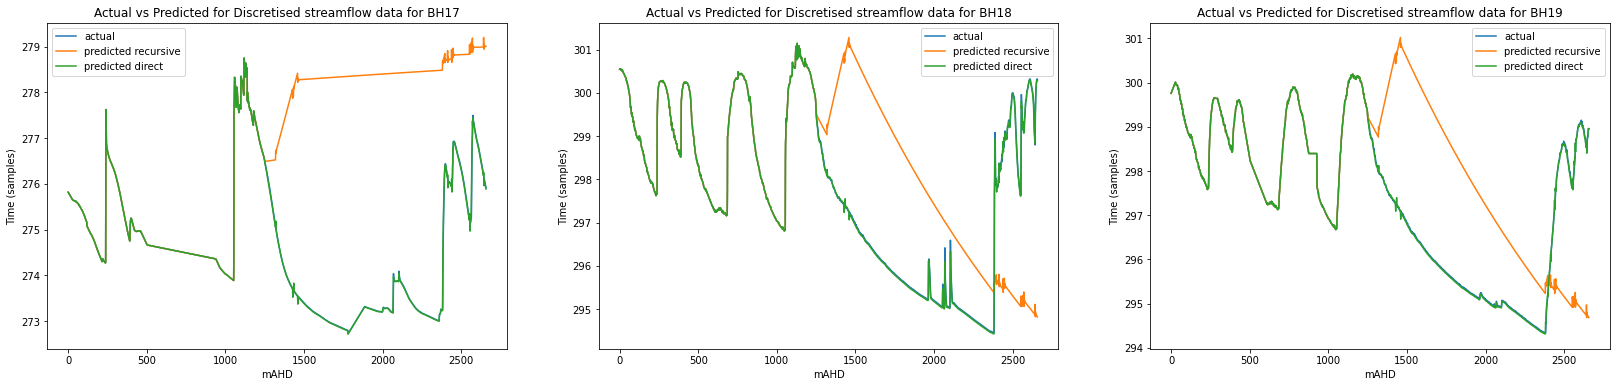

In [ ]:
f,ax =plt.subplots(1,3)

x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
#plt.figure()
ax[0].plot(x_data, actual_17, label='actual')
ax[0].plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
ax[0].plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
ax[0].set(title='Actual vs Predicted for Discretised streamflow data for BH17', xlabel='mAHD',ylabel='Time (samples)')
ax[0].legend()

x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
#plt.figure()
ax[1].plot(x_data, actual_18, label='actual')
ax[1].plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
ax[1].plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
ax[1].set(title='Actual vs Predicted for Discretised streamflow data for BH18', xlabel='mAHD',ylabel='Time (samples)')
ax[1].legend()

x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
#plt.figure()
ax[2].plot(x_data, actual_19, label='actual')
ax[2].plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
ax[2].plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
ax[2].set(title='Actual vs Predicted for Discretised streamflow data for BH19', xlabel='mAHD',ylabel='Time (samples)')
ax[2].legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_batch.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_post_2017_batch_17

0.07403506969346096

In [ ]:
Best_RMSE_streamflow_discretised_post_2017_batch_18

0.1585057150952706

In [ ]:
Best_RMSE_streamflow_discretised_post_2017_batch_19

0.04472767598210187

In [ ]:
Best_RMSE_streamflow_discretised_recursive_batch_17

4.491724613779495

In [ ]:
Best_RMSE_streamflow_discretised_recursive_batch_18

2.9316923008683915

In [ ]:
Best_RMSE_streamflow_discretised_recursive_batch_19

2.644801292141373

In [ ]:
Best_NSE_streamflow_discretised_post_2017_batch_19 = r2_score(Best_Predict_Test_streamflow_discretised_post_2017_batch_19, y_test_19[:])
Best_NSE_streamflow_discretised_recursive_batch_19 = r2_score(Best_Predict_Test_streamflow_discretised_recursive_batch_19, y_test_19[:])
Best_NSE_streamflow_discretised_post_2017_batch_18 = r2_score(Best_Predict_Test_streamflow_discretised_post_2017_batch_18, y_test_18[:])
Best_NSE_streamflow_discretised_recursive_batch_18 = r2_score(Best_Predict_Test_streamflow_discretised_recursive_batch_18, y_test_18[:])
Best_NSE_streamflow_discretised_post_2017_batch_17 = r2_score(Best_Predict_Test_streamflow_discretised_post_2017_batch_17, y_test_17[:])
Best_NSE_streamflow_discretised_recursive_batch_17 = r2_score(Best_Predict_Test_streamflow_discretised_recursive_batch_17, y_test_17[:])

In [ ]:
Best_NSE_streamflow_discretised_post_2017_batch_17

0.9968181996341829

In [ ]:
Best_NSE_streamflow_discretised_recursive_batch_17

-63.579320629354484

In [ ]:
Best_NSE_streamflow_discretised_post_2017_batch_18

0.9910879958634554

In [ ]:
Best_NSE_streamflow_discretised_recursive_batch_18

-1.2384328592401395

In [ ]:
Best_NSE_streamflow_discretised_post_2017_batch_19

0.9990246218197911

In [ ]:
Best_NSE_streamflow_discretised_recursive_batch_19

-0.8979939211892563

In [ ]:
saved_map = {
    
    'model_streamflow_discretised_recursive_batch': model_streamflow_discretised_recursive,
    'model_streamflow_discretised_post_2017_batch': model_streamflow_discretised_post_2017,

    'outputs_streamflow_discretised_recursive_batch_19':outputs_streamflow_discretised_recursive_batch_19,
    'train_acc_streamflow_discretised_recursive_batch_19': train_acc_streamflow_discretised_recursive_batch_19,
    'test_acc_streamflow_discretised_recursive_batch_19': test_acc_streamflow_discretised_recursive_batch_19,
    'Step_RMSE_streamflow_discretised_recursive_batch_19': Step_RMSE_streamflow_discretised_recursive_batch_19,
    'Best_predict_test_streamflow_discretised_recursive_batch_19': Best_Predict_Test_streamflow_discretised_recursive_batch_19,
    'Best_RMSE_streamflow_discretised_recursive_batch_19': Best_RMSE_streamflow_discretised_recursive_batch_19,
    'Best_NSE_streamflow_discretised_recursive_batch_19':Best_NSE_streamflow_discretised_recursive_batch_19,
    'in_between_percentage_streamflow_discretised_recursive_batch_19': in_between_percentage_streamflow_discretised_recursive_batch_19,
    
    
    'outputs_streamflow_discretised_post_2017_batch_19':outputs_streamflow_discretised_post_2017_batch_19,
    'train_acc_streamflow_discretised_post_2017_batch_19': train_acc_streamflow_discretised_post_2017_batch_19,
    'test_acc_streamflow_discretised_post_2017_batch_19': test_acc_streamflow_discretised_post_2017_batch_19,
    'Step_RMSE_streamflow_discretised_post_2017_batch_19': Step_RMSE_streamflow_discretised_post_2017_batch_19,
    'Best_predict_test_streamflow_discretised_post_2017_batch_19': Best_Predict_Test_streamflow_discretised_post_2017_batch_19,
    'Best_RMSE_streamflow_discretised_post_2017_batch_19': Best_RMSE_streamflow_discretised_post_2017_batch_19,
    'Best_NSE_streamflow_discretised_post_2017_batch_19':Best_NSE_streamflow_discretised_post_2017_batch_19,

    'outputs_streamflow_discretised_recursive_batch_18':outputs_streamflow_discretised_recursive_batch_18,
    'train_acc_streamflow_discretised_recursive_batch_18': train_acc_streamflow_discretised_recursive_batch_18,
    'test_acc_streamflow_discretised_recursive_batch_18': test_acc_streamflow_discretised_recursive_batch_18,
    'Step_RMSE_streamflow_discretised_recursive_batch_18': Step_RMSE_streamflow_discretised_recursive_batch_18,
    'Best_predict_test_streamflow_discretised_recursive_batch_18': Best_Predict_Test_streamflow_discretised_recursive_batch_18,
    'Best_RMSE_streamflow_discretised_recursive_batch_18': Best_RMSE_streamflow_discretised_recursive_batch_18,
    'Best_NSE_streamflow_discretised_recursive_batch_18':Best_NSE_streamflow_discretised_recursive_batch_18,
    'in_between_percentage_streamflow_discretised_recursive_batch_18': in_between_percentage_streamflow_discretised_recursive_batch_18,
    
    
    'outputs_streamflow_discretised_post_2017_batch_18':outputs_streamflow_discretised_post_2017_batch_18,
    'train_acc_streamflow_discretised_post_2017_batch_18': train_acc_streamflow_discretised_post_2017_batch_18,
    'test_acc_streamflow_discretised_post_2017_batch_18': test_acc_streamflow_discretised_post_2017_batch_18,
    'Step_RMSE_streamflow_discretised_post_2017_batch_18': Step_RMSE_streamflow_discretised_post_2017_batch_18,
    'Best_predict_test_streamflow_discretised_post_2017_batch_18': Best_Predict_Test_streamflow_discretised_post_2017_batch_18,
    'Best_RMSE_streamflow_discretised_post_2017_batch_18': Best_RMSE_streamflow_discretised_post_2017_batch_18,
    'Best_NSE_streamflow_discretised_post_2017_batch_18':Best_NSE_streamflow_discretised_post_2017_batch_18,

    'outputs_streamflow_discretised_recursive_batch_17':outputs_streamflow_discretised_recursive_batch_17,
    'train_acc_streamflow_discretised_recursive_batch_17': train_acc_streamflow_discretised_recursive_batch_17,
    'test_acc_streamflow_discretised_recursive_batch_17': test_acc_streamflow_discretised_recursive_batch_17,
    'Step_RMSE_streamflow_discretised_recursive_batch_17': Step_RMSE_streamflow_discretised_recursive_batch_17,
    'Best_predict_test_streamflow_discretised_recursive_batch_17': Best_Predict_Test_streamflow_discretised_recursive_batch_17,
    'Best_RMSE_streamflow_discretised_recursive_batch_17': Best_RMSE_streamflow_discretised_recursive_batch_17,
    'Best_NSE_streamflow_discretised_recursive_batch_17':Best_NSE_streamflow_discretised_recursive_batch_17,
    'in_between_percentage_streamflow_discretised_recursive_batch_17': in_between_percentage_streamflow_discretised_recursive_batch_17,
    
    
    'outputs_streamflow_discretised_post_2017_batch_17':outputs_streamflow_discretised_post_2017_batch_17,
    'train_acc_streamflow_discretised_post_2017_batch_17': train_acc_streamflow_discretised_post_2017_batch_17,
    'test_acc_streamflow_discretised_post_2017_batch_17': test_acc_streamflow_discretised_post_2017_batch_17,
    'Step_RMSE_streamflow_discretised_post_2017_batch_17': Step_RMSE_streamflow_discretised_post_2017_batch_17,
    'Best_predict_test_streamflow_discretised_post_2017_batch_17': Best_Predict_Test_streamflow_discretised_post_2017_batch_17,
    'Best_RMSE_streamflow_discretised_post_2017_batch_17': Best_RMSE_streamflow_discretised_post_2017_batch_17,
    'Best_NSE_streamflow_discretised_post_2017_batch_17':Best_NSE_streamflow_discretised_post_2017_batch_17,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_streamflow_discretised_post_2017_batch.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()

## CNN model

### Discretised streamflow

In [ ]:
in_seq1_19 = array(m19_daily['discretised_flow'][:-1])
in_seq2 = array(m19_daily['BH_mAHD'][:-1])
out_seq = array(m19_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1_19 = in_seq1_19.reshape((len(in_seq1_19), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1_19, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017_19 = len(m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017_19 = len(m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train_19 = X[0:num_pre_2017_19]
x_test_19 = X[num_pre_2017_19:]

y_train_19 = y[0:num_pre_2017_19]
y_test_19 = y[num_pre_2017_19:]
n_features = X.shape[2]


###############################################################################################
in_seq1_18 = array(m18_daily['discretised_flow'][:-1])
in_seq2 = array(m18_daily['BH_mAHD'][:-1])
out_seq = array(m18_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1_18 = in_seq1_18.reshape((len(in_seq1_18), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1_18, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017_18 = len(m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017_18 = len(m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train_18 = X[0:num_pre_2017_18]
x_test_18 = X[num_pre_2017_18:]

y_train_18 = y[0:num_pre_2017_18]
y_test_18 = y[num_pre_2017_18:]
n_features = X.shape[2]

##############################################################################################
in_seq1_17 = array(m17_daily['discretised_flow'][:-1])
in_seq2 = array(m17_daily['BH_mAHD'][:-1])
out_seq = array(m17_daily['BH_mAHD'][1:])
# convert to [rows, columns] structure
in_seq1_17 = in_seq1_17.reshape((len(in_seq1_17), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1_17, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

num_pre_2017_17 = len(m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)])
num_post_2017_17 = len(m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)])
x_train_17 = X[0:num_pre_2017_17]
x_test_17 = X[num_pre_2017_17:]

y_train_17 = y[0:num_pre_2017_17]
y_test_17 = y[num_pre_2017_17:]
n_features = X.shape[2]

x_train = np.concatenate([x_train_17,x_train_18,x_train_19])
#x_test = np.concatenate([x_train_17,x_train_18,x_train_19])

y_train = np.concatenate([y_train_17,y_train_18,y_train_19])
#y_test = np.concatenate([y_test_17,y_test_18,y_test_19])

x_train, y_train = shuffle(x_train,y_train)

In [ ]:
streamflow_discretised_cnn_post_2017_19 = in_seq1_19[num_pre_2017_19:]
streamflow_discretised_cnn_post_2017_18 = in_seq1_18[num_pre_2017_18:]
streamflow_discretised_cnn_post_2017_17 = in_seq1_17[num_pre_2017_17:]

Num_Exp = 30
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_discretised_cnn_recursive_batch_17=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_recursive_batch_17=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_recursive_batch_17=np.zeros([Num_Exp,n_steps_out])

train_acc_streamflow_discretised_cnn_recursive_batch_18=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_recursive_batch_18=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_recursive_batch_18=np.zeros([Num_Exp,n_steps_out])

train_acc_streamflow_discretised_cnn_recursive_batch_19=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_recursive_batch_19=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_recursive_batch_19=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_recursive = Sequential()
model_streamflow_discretised_cnn_recursive.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_recursive.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_recursive.add(Flatten())
model_streamflow_discretised_cnn_recursive.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_recursive.add(Dense(1))
model_streamflow_discretised_cnn_recursive.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_recursive.summary()
Best_RMSE_streamflow_discretised_cnn_recursive_batch_17=1000   #Assigning a large number 
Best_RMSE_streamflow_discretised_cnn_recursive_batch_18=1000   #Assigning a large number 
Best_RMSE_streamflow_discretised_cnn_recursive_batch_19=1000   #Assigning a large number 


outputs_streamflow_discretised_cnn_recursive_batch_17 = np.ones((Num_Exp, y_test_17.shape[0]))
outputs_streamflow_discretised_cnn_recursive_batch_18 = np.ones((Num_Exp, y_test_18.shape[0]))
outputs_streamflow_discretised_cnn_recursive_batch_19 = np.ones((Num_Exp, y_test_19.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_cnn_recursive
    #batch_size=64, 
    model_streamflow_discretised_cnn_recursive.fit(x_train, y_train, epochs=Epochs, verbose=0, batch_size=64, shuffle=False)
    y_predicttrain_17 = model_streamflow_discretised_cnn_recursive.predict(x_train).flatten()
    y_predicttest_17 = predict_recursively(model_streamflow_discretised_cnn_recursive, x_test_17[0][:,1], streamflow_discretised_cnn_post_2017_17,num_post_2017_17-3, 3)
    train_acc_streamflow_discretised_cnn_recursive_batch_17[run] = rmse( y_predicttrain_17,y_train) 
    test_acc_streamflow_discretised_cnn_recursive_batch_17[run] = rmse( y_predicttest_17, y_test_17) 

    print("RMSE value 17:", test_acc_streamflow_discretised_cnn_recursive_batch_17[run]) 
    if test_acc_streamflow_discretised_cnn_recursive_batch_17[run]<Best_RMSE_streamflow_discretised_cnn_recursive_batch_17:
        Best_RMSE_streamflow_discretised_cnn_recursive_batch_17=test_acc_streamflow_discretised_cnn_recursive_batch_17[run]
        Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_17=y_predicttest_17
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_recursive_batch_17[run]=rmse(y_predicttest_17[:], y_test_17[:])

    y_predicttrain_18 = model_streamflow_discretised_cnn_recursive.predict(x_train).flatten()
    y_predicttest_18 = predict_recursively(model_streamflow_discretised_cnn_recursive, x_test_18[0][:,1], streamflow_discretised_cnn_post_2017_18,num_post_2017_18-3, 3)
    train_acc_streamflow_discretised_cnn_recursive_batch_18[run] = rmse( y_predicttrain_18,y_train) 
    test_acc_streamflow_discretised_cnn_recursive_batch_18[run] = rmse( y_predicttest_18, y_test_18) 

    y_predicttrain_19 = model_streamflow_discretised_cnn_recursive.predict(x_train).flatten()
    y_predicttest_19 = predict_recursively(model_streamflow_discretised_cnn_recursive, x_test_19[0][:,1], streamflow_discretised_cnn_post_2017_19,num_post_2017_19-3, 3)
    train_acc_streamflow_discretised_cnn_recursive_batch_19[run] = rmse( y_predicttrain_19,y_train) 
    test_acc_streamflow_discretised_cnn_recursive_batch_19[run] = rmse( y_predicttest_19, y_test_19) 

    outputs_streamflow_discretised_cnn_recursive_batch_17[run,] = y_predicttest_17
    outputs_streamflow_discretised_cnn_recursive_batch_18[run,] = y_predicttest_18
    outputs_streamflow_discretised_cnn_recursive_batch_19[run,] = y_predicttest_19

  

    print("RMSE value 18:", test_acc_streamflow_discretised_cnn_recursive_batch_18[run]) 
    if test_acc_streamflow_discretised_cnn_recursive_batch_18[run]<Best_RMSE_streamflow_discretised_cnn_recursive_batch_18:
        Best_RMSE_streamflow_discretised_cnn_recursive_batch_18=test_acc_streamflow_discretised_cnn_recursive_batch_18[run]
        Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_18=y_predicttest_18
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_recursive_batch_18[run]=rmse(y_predicttest_18[:], y_test_18[:])   
    
    print("RMSE value 19:", test_acc_streamflow_discretised_cnn_recursive_batch_19[run]) 
    if test_acc_streamflow_discretised_cnn_recursive_batch_19[run]<Best_RMSE_streamflow_discretised_cnn_recursive_batch_19:
        Best_RMSE_streamflow_discretised_cnn_recursive_batch_19=test_acc_streamflow_discretised_cnn_recursive_batch_19[run]
        Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_19=y_predicttest_19
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_recursive_batch_17[run]=rmse(y_predicttest_17[:], y_test_17[:])   
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 25)                1625      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

In [ ]:
streamflow_discretised_cnn_post_2017_batch_19 = in_seq1_19[num_pre_2017_19:]
streamflow_discretised_cnn_post_2017_batch_18 = in_seq1_18[num_pre_2017_18:]
streamflow_discretised_cnn_post_2017_batch_17 = in_seq1_17[num_pre_2017_17:]

Num_Exp = 30  
n_steps_out = 1
Hidden=10
Epochs=1000


train_acc_streamflow_discretised_cnn_post_2017_batch_17=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_post_2017_batch_17=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_post_2017_batch_17=np.zeros([Num_Exp,n_steps_out])

train_acc_streamflow_discretised_cnn_post_2017_batch_18=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_post_2017_batch_18=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_post_2017_batch_18=np.zeros([Num_Exp,n_steps_out])

train_acc_streamflow_discretised_cnn_post_2017_batch_19=np.zeros(Num_Exp)
test_acc_streamflow_discretised_cnn_post_2017_batch_19=np.zeros(Num_Exp)
Step_RMSE_streamflow_discretised_cnn_post_2017_batch_19=np.zeros([Num_Exp,n_steps_out])

model_streamflow_discretised_cnn_post_2017 = Sequential()
model_streamflow_discretised_cnn_post_2017.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model_streamflow_discretised_cnn_post_2017.add(MaxPooling1D(pool_size=2))
model_streamflow_discretised_cnn_post_2017.add(Flatten())
model_streamflow_discretised_cnn_post_2017.add(Dense(25, activation='relu'))
model_streamflow_discretised_cnn_post_2017.add(Dense(1))
model_streamflow_discretised_cnn_post_2017.compile(optimizer='adam', loss='mse')
model_streamflow_discretised_cnn_post_2017.summary()
Best_RMSE_streamflow_discretised_cnn_post_2017_batch_17=1000   #Assigning a large number 
Best_RMSE_streamflow_discretised_cnn_post_2017_batch_18=1000   #Assigning a large number 
Best_RMSE_streamflow_discretised_cnn_post_2017_batch_19=1000   #Assigning a large number 


outputs_streamflow_discretised_cnn_post_2017_batch_17 = np.ones((Num_Exp, y_test_17.shape[0]))
outputs_streamflow_discretised_cnn_post_2017_batch_18 = np.ones((Num_Exp, y_test_18.shape[0]))
outputs_streamflow_discretised_cnn_post_2017_batch_19 = np.ones((Num_Exp, y_test_19.shape[0]))

start_time=time.time()
for run in range(Num_Exp):
    print("Experiment",run+1,"in progress")
    # fit model_streamflow_discretised_cnn_post_2017
    #batch_size=64, 
    model_streamflow_discretised_cnn_post_2017.fit(x_train, y_train, epochs=Epochs, verbose=0, batch_size=64, shuffle=False)
    y_predicttrain_17 = model_streamflow_discretised_cnn_post_2017.predict(x_train).flatten()
    y_predicttest_17 = model_streamflow_discretised_cnn_post_2017.predict(x_test_17).flatten()
    train_acc_streamflow_discretised_cnn_post_2017_batch_17[run] = rmse( y_predicttrain_17,y_train) 
    test_acc_streamflow_discretised_cnn_post_2017_batch_17[run] = rmse( y_predicttest_17, y_test_17) 

    print("RMSE value 17:", test_acc_streamflow_discretised_cnn_post_2017_batch_17[run]) 
    if test_acc_streamflow_discretised_cnn_post_2017_batch_17[run]<Best_RMSE_streamflow_discretised_cnn_post_2017_batch_17:
        Best_RMSE_streamflow_discretised_cnn_post_2017_batch_17=test_acc_streamflow_discretised_cnn_post_2017_batch_17[run]
        Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_17=y_predicttest_17
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_post_2017_batch_17[run]=rmse(y_predicttest_17[:], y_test_17[:])

    y_predicttrain_18 = model_streamflow_discretised_cnn_post_2017.predict(x_train).flatten()
    y_predicttest_18 = model_streamflow_discretised_cnn_post_2017.predict(x_test_18).flatten()
    train_acc_streamflow_discretised_cnn_post_2017_batch_18[run] = rmse( y_predicttrain_18,y_train) 
    test_acc_streamflow_discretised_cnn_post_2017_batch_18[run] = rmse( y_predicttest_18, y_test_18) 

    print("RMSE value 18:", test_acc_streamflow_discretised_cnn_post_2017_batch_18[run]) 
    if test_acc_streamflow_discretised_cnn_post_2017_batch_18[run]<Best_RMSE_streamflow_discretised_cnn_post_2017_batch_18:
        Best_RMSE_streamflow_discretised_cnn_post_2017_batch_18=test_acc_streamflow_discretised_cnn_post_2017_batch_18[run]
        Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_18=y_predicttest_18
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_post_2017_batch_18[run]=rmse(y_predicttest_18[:], y_test_18[:])   

    y_predicttrain_19 = model_streamflow_discretised_cnn_post_2017.predict(x_train).flatten()
    y_predicttest_19 = model_streamflow_discretised_cnn_post_2017.predict(x_test_19).flatten()
    train_acc_streamflow_discretised_cnn_post_2017_batch_19[run] = rmse( y_predicttrain_19,y_train) 
    test_acc_streamflow_discretised_cnn_post_2017_batch_19[run] = rmse( y_predicttest_19, y_test_19) 

    outputs_streamflow_discretised_cnn_post_2017_batch_17[run,] = y_predicttest_17
    outputs_streamflow_discretised_cnn_post_2017_batch_18[run,] = y_predicttest_18
    outputs_streamflow_discretised_cnn_post_2017_batch_19[run,] = y_predicttest_19

    print("RMSE value 19:", test_acc_streamflow_discretised_cnn_post_2017_batch_19[run]) 
    if test_acc_streamflow_discretised_cnn_post_2017_batch_19[run]<Best_RMSE_streamflow_discretised_cnn_post_2017_batch_19:
        Best_RMSE_streamflow_discretised_cnn_post_2017_batch_19=test_acc_streamflow_discretised_cnn_post_2017_batch_19[run]
        Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_19=y_predicttest_19
    for j in range(n_steps_out):
      Step_RMSE_streamflow_discretised_cnn_post_2017_batch_17[run]=rmse(y_predicttest_17[:], y_test_17[:])   
print("Total time for",Num_Exp,"experiments",time.time()-start_time)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 25)                1625      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,971
Trainable params: 1,971
Non-trainable params: 0
____________________________________________________

In [ ]:
# outputs_streamflow_post_2017_17_1 = outputs_streamflow_post_2017_17[5:]
# outputs_streamflow_post_2017_18_1 = outputs_streamflow_post_2017_18[5:]
# outputs_streamflow_post_2017_19_1 = outputs_streamflow_post_2017_19[5:]
# outputs_streamflow_post_2017_batch_19 = outputs_streamflow_post_2017_19
# outputs_streamflow_post_2017_batch_18 = outputs_streamflow_post_2017_18
# outputs_streamflow_post_2017_batch_17 = outputs_streamflow_post_2017_17

In [ ]:
fx_high_post_2017_17 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_17, 95, axis=0)
fx_low_post_2017_17 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_17, 5, axis=0)
fx_mid_post_2017_17 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_17, 50, axis=0)
fx_high_recursive_17 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_17[0:17], 95, axis=0)
fx_low_recursive_17 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_17[0:17], 5, axis=0)
fx_mid_recursive_17 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_17[0:17], 50, axis=0)
in_between_percentage_streamflow_discretised_cnn_recursive_batch_17 = np.count_nonzero(np.less(fx_low_recursive_17,y_test_17) & np.greater_equal(fx_high_recursive_17,y_test_17) )/len(y_test_17)
in_between_percentage_streamflow_discretised_cnn_recursive_batch_17

fx_high_post_2017_18 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_18, 95, axis=0)
fx_low_post_2017_18 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_18, 5, axis=0)
fx_mid_post_2017_18 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_18, 50, axis=0)
fx_high_recursive_18 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_18[0:17], 95, axis=0)
fx_low_recursive_18 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_18[0:17], 5, axis=0)
fx_mid_recursive_18 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_18[0:17], 50, axis=0)
in_between_percentage_streamflow_discretised_cnn_recursive_batch_18 = np.count_nonzero(np.less(fx_low_recursive_18,y_test_18) & np.greater_equal(fx_high_recursive_18,y_test_18) )/len(y_test_18)
in_between_percentage_streamflow_discretised_cnn_recursive_batch_18

fx_high_post_2017_19 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_19, 95, axis=0)
fx_low_post_2017_19 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_19, 5, axis=0)
fx_mid_post_2017_19 = np.percentile(outputs_streamflow_discretised_cnn_post_2017_batch_19, 50, axis=0)
fx_high_recursive_19 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_19[0:17], 95, axis=0)
fx_low_recursive_19 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_19[0:17], 5, axis=0)
fx_mid_recursive_19 = np.percentile(outputs_streamflow_discretised_cnn_recursive_batch_19[0:17], 50, axis=0)
in_between_percentage_streamflow_discretised_cnn_recursive_batch_19 = np.count_nonzero(np.less(fx_low_recursive_19,y_test_19) & np.greater_equal(fx_high_recursive_19,y_test_19) )/len(y_test_19)
in_between_percentage_streamflow_discretised_cnn_recursive_batch_19


0.8167613636363636

In [ ]:
in_between_percentage_streamflow_discretised_cnn_recursive_batch_17

0.9680397727272727

In [ ]:
in_between_percentage_streamflow_discretised_cnn_recursive_batch_18

0.7897727272727273

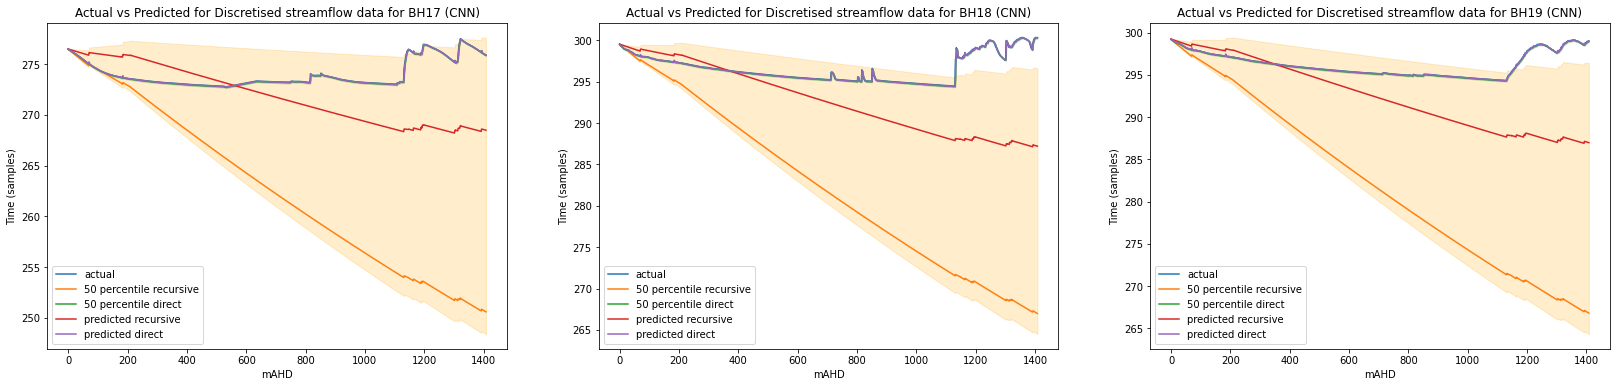

In [ ]:
plt.rcParams["figure.figsize"] = (28,6)


f,ax =plt.subplots(1,3)

x_data_17=np.linspace(0,y_test_17.shape[0], num=y_test_17.shape[0])
#plt.figure()
ax[0].plot(x_data_17, y_test_17[:], label='actual')
ax[0].plot(x_data_17, fx_mid_recursive_17[:], label='50 percentile recursive')
ax[0].plot(x_data_17, fx_mid_post_2017_17[:], label='50 percentile direct')
ax[0].plot(x_data_17, Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_17[:], label='predicted recursive')
ax[0].plot(x_data_17, Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_17[:], label='predicted direct')
ax[0].fill_between(x_data_17, fx_low_recursive_17, fx_high_recursive_17, color='orange', alpha=0.2)
ax[0].fill_between(x_data_17, fx_low_post_2017_17, fx_high_post_2017_17, color='green', alpha=0.2)
ax[0].set(title='Actual vs Predicted for Discretised streamflow data for BH17 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
#ax[0].title('Actual vs Predicted for Streamflow_discretised_cnn data for BH17')
ax[0].legend()

x_data_18=np.linspace(0,y_test_18.shape[0], num=y_test_18.shape[0])
ax[1].plot(x_data_18, y_test_18[:], label='actual')
ax[1].plot(x_data_18, fx_mid_recursive_18[:], label='50 percentile recursive')
ax[1].plot(x_data_18, fx_mid_post_2017_18[:], label='50 percentile direct')
ax[1].plot(x_data_18, Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_18[:], label='predicted recursive')
ax[1].plot(x_data_18, Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_18[:], label='predicted direct')
ax[1].fill_between(x_data_18, fx_low_recursive_18, fx_high_recursive_18, color='orange', alpha=0.2)
ax[1].fill_between(x_data_18, fx_low_post_2017_18, fx_high_post_2017_18, color='green', alpha=0.2)
ax[1].set(title='Actual vs Predicted for Discretised streamflow data for BH18 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
ax[1].legend()

x_data_19=np.linspace(0,y_test_19.shape[0], num=y_test_19.shape[0])
ax[2].plot(x_data_19, y_test_19[:], label='actual')
ax[2].plot(x_data_19, fx_mid_recursive_19[:], label='50 percentile recursive')
ax[2].plot(x_data_19, fx_mid_post_2017_19[:], label='50 percentile direct')
ax[2].plot(x_data_19, Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_19[:], label='predicted recursive')
ax[2].plot(x_data_19, Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_19[:], label='predicted direct')
ax[2].fill_between(x_data_19, fx_low_recursive_19, fx_high_recursive_19, color='orange', alpha=0.2)
ax[2].fill_between(x_data_19, fx_low_post_2017_19, fx_high_post_2017_19, color='green', alpha=0.2)
ax[2].set(title='Actual vs Predicted for Discretised streamflow data for BH19 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
ax[2].legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_post_2017_batch.png',dpi=300) 
plt.show()
plt.close()

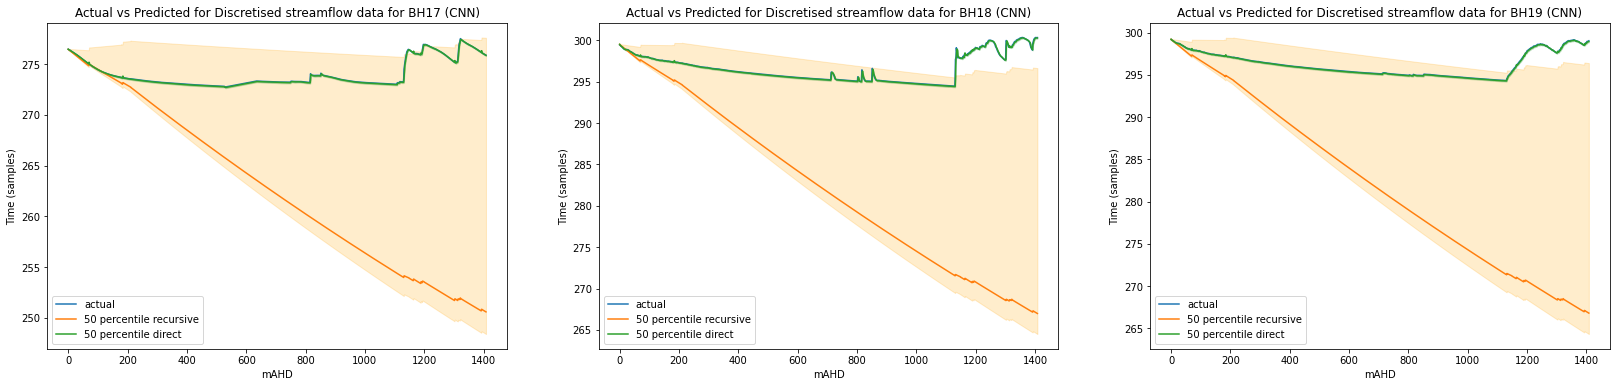

In [ ]:
f,ax =plt.subplots(1,3)

x_data=np.linspace(0,y_test_17.shape[0], num=y_test_17.shape[0])
#plt.figure()
ax[0].plot(x_data, y_test_17[:], label='actual')
ax[0].plot(x_data, fx_mid_recursive_17[:], label='50 percentile recursive')
ax[0].plot(x_data, fx_mid_post_2017_17[:], label='50 percentile direct')

ax[0].fill_between(x_data, fx_low_recursive_17, fx_high_recursive_17, color='orange', alpha=0.2)
ax[0].fill_between(x_data, fx_low_post_2017_17, fx_high_post_2017_17, color='green', alpha=0.2)
ax[0].set(title='Actual vs Predicted for Discretised streamflow data for BH17 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
ax[0].legend()

x_data=np.linspace(0,y_test_18.shape[0], num=y_test_18.shape[0])
#plt.figure()
ax[1].plot(x_data, y_test_18[:], label='actual')
ax[1].plot(x_data, fx_mid_recursive_18[:], label='50 percentile recursive')
ax[1].plot(x_data, fx_mid_post_2017_18[:], label='50 percentile direct')

ax[1].fill_between(x_data, fx_low_recursive_18, fx_high_recursive_18, color='orange', alpha=0.2)
ax[1].fill_between(x_data, fx_low_post_2017_18, fx_high_post_2017_18, color='green', alpha=0.2)
ax[1].set(title='Actual vs Predicted for Discretised streamflow data for BH18 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
ax[1].legend()

x_data=np.linspace(0,y_test_19.shape[0], num=y_test_19.shape[0])
#plt.figure()
ax[2].plot(x_data, y_test_19[:], label='actual')
ax[2].plot(x_data, fx_mid_recursive_19[:], label='50 percentile recursive')
ax[2].plot(x_data, fx_mid_post_2017_19[:], label='50 percentile direct')

ax[2].fill_between(x_data, fx_low_recursive_19, fx_high_recursive_19, color='orange', alpha=0.2)
ax[2].fill_between(x_data, fx_low_post_2017_19, fx_high_post_2017_19, color='green', alpha=0.2)
ax[2].set(title='Actual vs Predicted for Discretised streamflow data for BH19 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
ax[2].legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_post_2017_50_only_batch.png',dpi=300) 
plt.show()
plt.close()

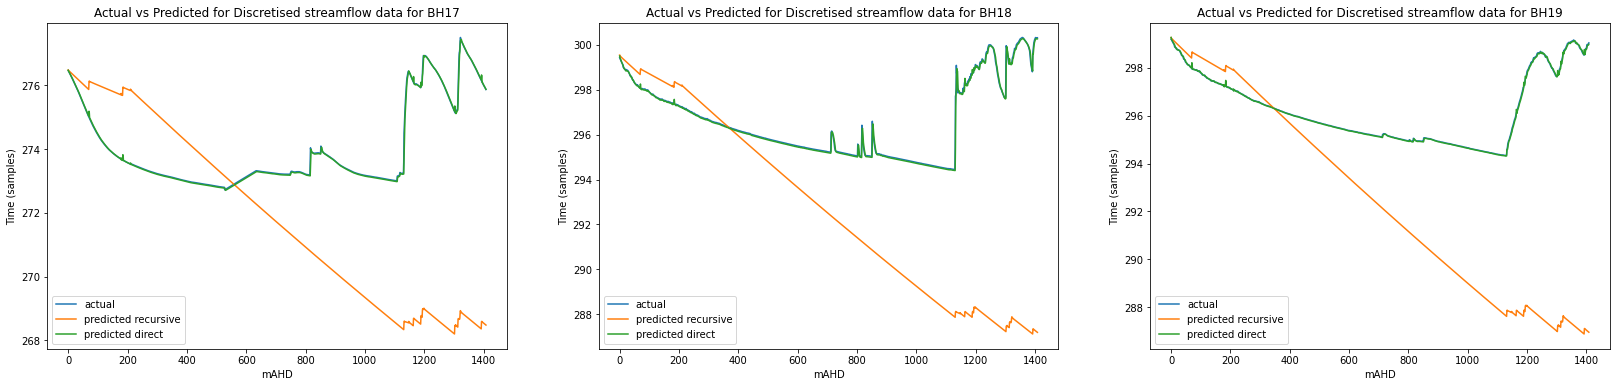

In [ ]:
f,ax =plt.subplots(1,3)

x_data=np.linspace(0,y_test_17.shape[0], num=y_test_17.shape[0])
#plt.figure()
ax[0].plot(x_data, y_test_17[:], label='actual')
ax[0].plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_17[:], label='predicted recursive')
ax[0].plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_17[:], label='predicted direct')
ax[0].set(title='Actual vs Predicted for Discretised streamflow data for BH17', xlabel='mAHD',ylabel='Time (samples)')
ax[0].legend()

x_data=np.linspace(0,y_test_18.shape[0], num=y_test_18.shape[0])
#plt.figure()
ax[1].plot(x_data, y_test_18[:], label='actual')
ax[1].plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_18[:], label='predicted recursive')
ax[1].plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_18[:], label='predicted direct')
ax[1].set(title='Actual vs Predicted for Discretised streamflow data for BH18', xlabel='mAHD',ylabel='Time (samples)')
ax[1].legend()

x_data=np.linspace(0,y_test_19.shape[0], num=y_test_19.shape[0])
#plt.figure()
ax[2].plot(x_data, y_test_19[:], label='actual')
ax[2].plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_19[:], label='predicted recursive')
ax[2].plot(x_data, Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_19[:], label='predicted direct')
ax[2].set(title='Actual vs Predicted for Discretised streamflow data for BH19', xlabel='mAHD',ylabel='Time (samples)')
ax[2].legend()


plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_post_2017_best_only_batch.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
BH_19_pre_2017 = m19_daily[m19_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_19_post_2017 = m19_daily[m19_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

bh19_Best_Predict_Test_post_2017 = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_19[:])
bh19_Best_Predict_Test_recursive = np.append(BH_19_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_19[:])
actual_19 = np.append(BH_19_pre_2017['BH_mAHD'], BH_19_post_2017['BH_mAHD'][:-3])

BH_18_pre_2017 = m18_daily[m18_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_18_post_2017 = m18_daily[m18_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

bh18_Best_Predict_Test_post_2017 = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_18[:])
bh18_Best_Predict_Test_recursive = np.append(BH_18_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_18[:])
actual_18 = np.append(BH_18_pre_2017['BH_mAHD'], BH_18_post_2017['BH_mAHD'][:-3])

BH_17_pre_2017 = m17_daily[m17_daily['Date and Time'].dt.date<datetime.date(2017,1,1)]
BH_17_post_2017 = m17_daily[m17_daily['Date and Time'].dt.date>=datetime.date(2017,1,1)]

bh17_Best_Predict_Test_post_2017 = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_17[:])
bh17_Best_Predict_Test_recursive = np.append(BH_17_pre_2017['BH_mAHD'], Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_17[:])
actual_17 = np.append(BH_17_pre_2017['BH_mAHD'], BH_17_post_2017['BH_mAHD'][:-3])


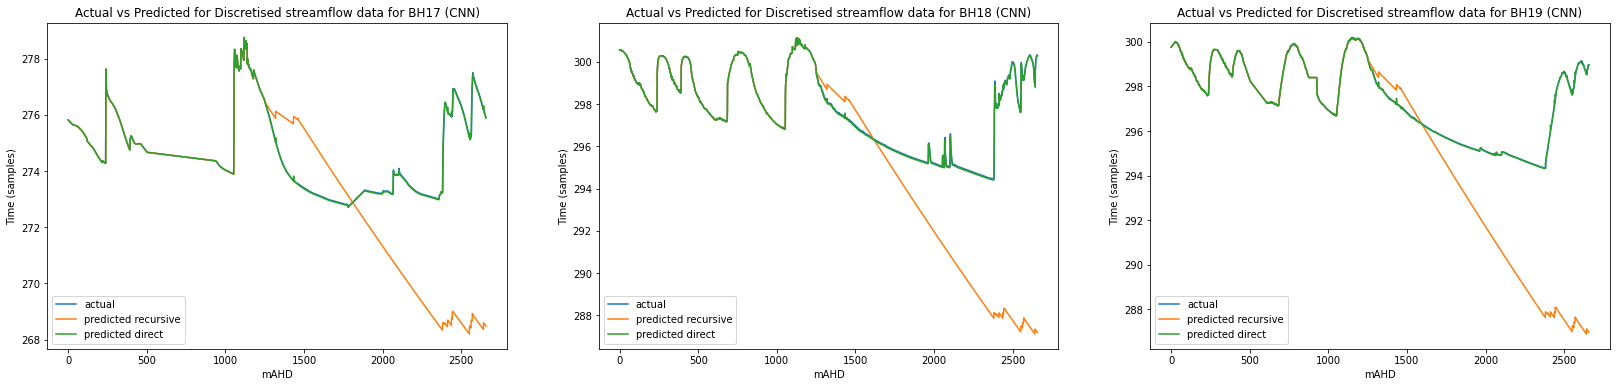

In [ ]:
f,ax =plt.subplots(1,3)

x_data=np.linspace(0,bh17_Best_Predict_Test_post_2017.shape[0], num=bh17_Best_Predict_Test_post_2017.shape[0])
#plt.figure()
ax[0].plot(x_data, actual_17, label='actual')
ax[0].plot(x_data, bh17_Best_Predict_Test_recursive[:], label='predicted recursive')
ax[0].plot(x_data, bh17_Best_Predict_Test_post_2017[:], label='predicted direct')
ax[0].set(title='Actual vs Predicted for Discretised streamflow data for BH17 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
ax[0].legend()

x_data=np.linspace(0,bh18_Best_Predict_Test_post_2017.shape[0], num=bh18_Best_Predict_Test_post_2017.shape[0])
#plt.figure()
ax[1].plot(x_data, actual_18, label='actual')
ax[1].plot(x_data, bh18_Best_Predict_Test_recursive[:], label='predicted recursive')
ax[1].plot(x_data, bh18_Best_Predict_Test_post_2017[:], label='predicted direct')
ax[1].set(title='Actual vs Predicted for Discretised streamflow data for BH18 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
ax[1].legend()

x_data=np.linspace(0,bh19_Best_Predict_Test_post_2017.shape[0], num=bh19_Best_Predict_Test_post_2017.shape[0])
#plt.figure()
ax[2].plot(x_data, actual_19, label='actual')
ax[2].plot(x_data, bh19_Best_Predict_Test_recursive[:], label='predicted recursive')
ax[2].plot(x_data, bh19_Best_Predict_Test_post_2017[:], label='predicted direct')
ax[2].set(title='Actual vs Predicted for Discretised streamflow data for BH19 (CNN)', xlabel='mAHD',ylabel='Time (samples)')
ax[2].legend()
plt.savefig('drive/My Drive/Thesis/Thesis/Image files/Streamflow_discretised_cnn_batch.png',dpi=300) 
plt.show()
plt.close()

In [ ]:
Best_RMSE_streamflow_discretised_cnn_post_2017_batch_17

0.05520093724818667

In [ ]:
Best_RMSE_streamflow_discretised_cnn_post_2017_batch_18

0.12788149616616304

In [ ]:
Best_RMSE_streamflow_discretised_cnn_post_2017_batch_19

0.03608249488510775

In [ ]:
Best_RMSE_streamflow_discretised_cnn_recursive_batch_17

4.032824550004835

In [ ]:
Best_RMSE_streamflow_discretised_cnn_recursive_batch_18

5.840442981790042

In [ ]:
Best_RMSE_streamflow_discretised_cnn_recursive_batch_19


5.499345425602528

In [ ]:
Best_NSE_streamflow_discretised_cnn_post_2017_batch_19 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_19, y_test_19[:])
Best_NSE_streamflow_discretised_cnn_recursive_batch_19 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_19, y_test_19[:])
Best_NSE_streamflow_discretised_cnn_post_2017_batch_18 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_18, y_test_18[:])
Best_NSE_streamflow_discretised_cnn_recursive_batch_18 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_18, y_test_18[:])
Best_NSE_streamflow_discretised_cnn_post_2017_batch_17 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_17, y_test_17[:])
Best_NSE_streamflow_discretised_cnn_recursive_batch_17 = r2_score(Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_17, y_test_17[:])

In [ ]:
Best_NSE_streamflow_discretised_cnn_post_2017_batch_17

0.9982522119151295

In [ ]:
Best_NSE_streamflow_discretised_cnn_recursive_batch_17

-1.103242805734605

In [ ]:
Best_NSE_streamflow_discretised_cnn_post_2017_batch_18

0.9942512919531645

In [ ]:
Best_NSE_streamflow_discretised_cnn_recursive_batch_18

-1.1187762549332723

In [ ]:
Best_NSE_streamflow_discretised_cnn_post_2017_batch_19

0.999367387076138

In [ ]:
Best_NSE_streamflow_discretised_cnn_recursive_batch_19

-0.8925786334977717

In [ ]:
saved_map = {
    
    'model_streamflow_discretised_cnn_recursive_batch': model_streamflow_discretised_cnn_recursive,
    'model_streamflow_discretised_cnn_post_2017_batch': model_streamflow_discretised_cnn_post_2017,

    'outputs_streamflow_discretised_cnn_recursive_batch_19':outputs_streamflow_discretised_cnn_recursive_batch_19,
    'train_acc_streamflow_discretised_cnn_recursive_batch_19': train_acc_streamflow_discretised_cnn_recursive_batch_19,
    'test_acc_streamflow_discretised_cnn_recursive_batch_19': test_acc_streamflow_discretised_cnn_recursive_batch_19,
    'Step_RMSE_streamflow_discretised_cnn_recursive_batch_19': Step_RMSE_streamflow_discretised_cnn_recursive_batch_19,
    'Best_predict_test_streamflow_discretised_cnn_recursive_batch_19': Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_19,
    'Best_RMSE_streamflow_discretised_cnn_recursive_batch_19': Best_RMSE_streamflow_discretised_cnn_recursive_batch_19,
    'Best_NSE_streamflow_discretised_cnn_recursive_batch_19':Best_NSE_streamflow_discretised_cnn_recursive_batch_19,
    'in_between_percentage_streamflow_discretised_cnn_recursive_batch_19': in_between_percentage_streamflow_discretised_cnn_recursive_batch_19,
    
    
    'outputs_streamflow_discretised_cnn_post_2017_batch_19':outputs_streamflow_discretised_cnn_post_2017_batch_19,
    'train_acc_streamflow_discretised_cnn_post_2017_batch_19': train_acc_streamflow_discretised_cnn_post_2017_batch_19,
    'test_acc_streamflow_discretised_cnn_post_2017_batch_19': test_acc_streamflow_discretised_cnn_post_2017_batch_19,
    'Step_RMSE_streamflow_discretised_cnn_post_2017_batch_19': Step_RMSE_streamflow_discretised_cnn_post_2017_batch_19,
    'Best_predict_test_streamflow_discretised_cnn_post_2017_batch_19': Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_19,
    'Best_RMSE_streamflow_discretised_cnn_post_2017_batch_19': Best_RMSE_streamflow_discretised_cnn_post_2017_batch_19,
    'Best_NSE_streamflow_discretised_cnn_post_2017_batch_19':Best_NSE_streamflow_discretised_cnn_post_2017_batch_19,

    'outputs_streamflow_discretised_cnn_recursive_batch_18':outputs_streamflow_discretised_cnn_recursive_batch_18,
    'train_acc_streamflow_discretised_cnn_recursive_batch_18': train_acc_streamflow_discretised_cnn_recursive_batch_18,
    'test_acc_streamflow_discretised_cnn_recursive_batch_18': test_acc_streamflow_discretised_cnn_recursive_batch_18,
    'Step_RMSE_streamflow_discretised_cnn_recursive_batch_18': Step_RMSE_streamflow_discretised_cnn_recursive_batch_18,
    'Best_predict_test_streamflow_discretised_cnn_recursive_batch_18': Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_18,
    'Best_RMSE_streamflow_discretised_cnn_recursive_batch_18': Best_RMSE_streamflow_discretised_cnn_recursive_batch_18,
    'Best_NSE_streamflow_discretised_cnn_recursive_batch_18':Best_NSE_streamflow_discretised_cnn_recursive_batch_18,
    'in_between_percentage_streamflow_discretised_cnn_recursive_batch_18': in_between_percentage_streamflow_discretised_cnn_recursive_batch_18,
    
    
    'outputs_streamflow_discretised_cnn_post_2017_batch_18':outputs_streamflow_discretised_cnn_post_2017_batch_18,
    'train_acc_streamflow_discretised_cnn_post_2017_batch_18': train_acc_streamflow_discretised_cnn_post_2017_batch_18,
    'test_acc_streamflow_discretised_cnn_post_2017_batch_18': test_acc_streamflow_discretised_cnn_post_2017_batch_18,
    'Step_RMSE_streamflow_discretised_cnn_post_2017_batch_18': Step_RMSE_streamflow_discretised_cnn_post_2017_batch_18,
    'Best_predict_test_streamflow_discretised_cnn_post_2017_batch_18': Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_18,
    'Best_RMSE_streamflow_discretised_cnn_post_2017_batch_18': Best_RMSE_streamflow_discretised_cnn_post_2017_batch_18,
    'Best_NSE_streamflow_discretised_cnn_post_2017_batch_18':Best_NSE_streamflow_discretised_cnn_post_2017_batch_18,

    'outputs_streamflow_discretised_cnn_recursive_batch_17':outputs_streamflow_discretised_cnn_recursive_batch_17,
    'train_acc_streamflow_discretised_cnn_recursive_batch_17': train_acc_streamflow_discretised_cnn_recursive_batch_17,
    'test_acc_streamflow_discretised_cnn_recursive_batch_17': test_acc_streamflow_discretised_cnn_recursive_batch_17,
    'Step_RMSE_streamflow_discretised_cnn_recursive_batch_17': Step_RMSE_streamflow_discretised_cnn_recursive_batch_17,
    'Best_predict_test_streamflow_discretised_cnn_recursive_batch_17': Best_Predict_Test_streamflow_discretised_cnn_recursive_batch_17,
    'Best_RMSE_streamflow_discretised_cnn_recursive_batch_17': Best_RMSE_streamflow_discretised_cnn_recursive_batch_17,
    'Best_NSE_streamflow_discretised_cnn_recursive_batch_17':Best_NSE_streamflow_discretised_cnn_recursive_batch_17,
    'in_between_percentage_streamflow_discretised_cnn_recursive_batch_17': in_between_percentage_streamflow_discretised_cnn_recursive_batch_17,
    
    
    'outputs_streamflow_discretised_cnn_post_2017_batch_17':outputs_streamflow_discretised_cnn_post_2017_batch_17,
    'train_acc_streamflow_discretised_cnn_post_2017_batch_17': train_acc_streamflow_discretised_cnn_post_2017_batch_17,
    'test_acc_streamflow_discretised_cnn_post_2017_batch_17': test_acc_streamflow_discretised_cnn_post_2017_batch_17,
    'Step_RMSE_streamflow_discretised_cnn_post_2017_batch_17': Step_RMSE_streamflow_discretised_cnn_post_2017_batch_17,
    'Best_predict_test_streamflow_discretised_cnn_post_2017_batch_17': Best_Predict_Test_streamflow_discretised_cnn_post_2017_batch_17,
    'Best_RMSE_streamflow_discretised_cnn_post_2017_batch_17': Best_RMSE_streamflow_discretised_cnn_post_2017_batch_17,
    'Best_NSE_streamflow_discretised_cnn_post_2017_batch_17':Best_NSE_streamflow_discretised_cnn_post_2017_batch_17,
}

pick_insert = open('drive/My Drive/Thesis/Thesis/data_streamflow_discretised_cnn_post_2017_batch.pickle','wb')
pickle.dump(saved_map, pick_insert)
pick_insert.close()